In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt 

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 100000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class  CharacterTable (object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '-',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

In [7]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    
    big_number = max([a,b])
    small_number = min([a,b])
    q = '{}-{}'.format(big_number, small_number)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(big_number - small_number)
    ans += ' ' * (DIGITS - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 100000


In [8]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS )

Vectorization...


In [9]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:70000]
train_y = y[:70000]
test_x = x[70000:]
test_y = y[70000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(63000, 7, 12)
(63000, 3, 12)
Validation Data:
(7000, 7, 12)
(7000, 3, 12)
Testing Data:
(30000, 7, 12)
(30000, 3, 12)


### hidden size = 64

In [10]:
print('Build model...')
model = Sequential()
model.add(RNN(64, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS))
for _ in range(LAYERS):
    model.add(RNN(64, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

model_hidden64 = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=80,
                      validation_data=(x_val, y_val))

right = 0
preds = model.predict_classes(test_x, verbose=0)

for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                19712     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 12)             780       
_________________________________________________________________
activation_1 (Activation)    (None, 3, 12)             0         
Total params: 53,516
Trainable params: 53,516
Non-trainable params: 0
_________________________________________________________________
Train on 63000 samples, validate on 7000 samples
Epoch 1/80
63000/63000 [==============================] - 6s 97us/step - l

Epoch 53/80
63000/63000 [==============================] - 5s 84us/step - loss: 0.2329 - acc: 0.9292 - val_loss: 0.2321 - val_acc: 0.9271
Epoch 54/80
63000/63000 [==============================] - 5s 83us/step - loss: 0.2251 - acc: 0.9322 - val_loss: 0.2179 - val_acc: 0.9345
Epoch 55/80
63000/63000 [==============================] - 5s 84us/step - loss: 0.2131 - acc: 0.9371 - val_loss: 0.3056 - val_acc: 0.8872
Epoch 56/80
63000/63000 [==============================] - 5s 83us/step - loss: 0.2176 - acc: 0.9314 - val_loss: 0.2296 - val_acc: 0.9226
Epoch 57/80
63000/63000 [==============================] - 5s 82us/step - loss: 0.2034 - acc: 0.9389 - val_loss: 0.1981 - val_acc: 0.9438
Epoch 58/80
63000/63000 [==============================] - 5s 83us/step - loss: 0.1993 - acc: 0.9404 - val_loss: 0.1953 - val_acc: 0.9429
Epoch 59/80
63000/63000 [==============================] - 5s 82us/step - loss: 0.1918 - acc: 0.9415 - val_loss: 0.2788 - val_acc: 0.8813
Epoch 60/80
63000/63000 [=========

Q 947-921 T 26  ☒ 36 
Q 729-62  T 667 ☑ 667
Q 603-527 T 76  ☒ 66 
Q 670-97  T 573 ☑ 573
Q 465-26  T 439 ☒ 449
Q 990-331 T 659 ☒ 669
Q 387-5   T 382 ☑ 382
Q 613-94  T 519 ☒ 529
Q 46-36   T 10  ☑ 10 
Q 329-9   T 320 ☑ 320
Q 979-23  T 956 ☑ 956
Q 258-8   T 250 ☑ 250
Q 829-346 T 483 ☑ 483
Q 376-115 T 261 ☑ 261
Q 627-14  T 613 ☑ 613
Q 768-598 T 170 ☑ 170
Q 790-756 T 34  ☑ 34 
Q 634-86  T 548 ☑ 548
Q 997-29  T 968 ☑ 968
Q 632-606 T 26  ☒ 36 
Q 732-97  T 635 ☑ 635
Q 832-346 T 486 ☑ 486
Q 636-87  T 549 ☑ 549
Q 557-3   T 554 ☑ 554
Q 306-44  T 262 ☑ 262
Q 501-226 T 275 ☒ 285
Q 680-375 T 305 ☑ 305
Q 213-99  T 114 ☑ 114
Q 723-177 T 546 ☑ 546
Q 890-355 T 535 ☑ 535
Q 985-22  T 963 ☑ 963
Q 243-2   T 241 ☑ 241
Q 615-25  T 590 ☑ 590
Q 376-4   T 372 ☑ 372
Q 507-325 T 182 ☑ 182
Q 473-53  T 420 ☑ 420
Q 420-86  T 334 ☑ 334
Q 930-294 T 636 ☑ 636
Q 500-4   T 496 ☑ 496
Q 516-81  T 435 ☑ 435
Q 903-219 T 684 ☑ 684
Q 891-565 T 326 ☑ 326
Q 556-5   T 551 ☑ 551
Q 377-102 T 275 ☑ 275
Q 762-15  T 747 ☑ 747
Q 447-78  

Q 945-27  T 918 ☑ 918
Q 880-27  T 853 ☑ 853
Q 974-36  T 938 ☑ 938
Q 921-387 T 534 ☑ 534
Q 462-63  T 399 ☒ 409
Q 901-92  T 809 ☑ 809
Q 352-30  T 322 ☑ 322
Q 919-655 T 264 ☒ 254
Q 273-44  T 229 ☑ 229
Q 494-41  T 453 ☑ 453
Q 975-559 T 416 ☑ 416
Q 608-477 T 131 ☑ 131
Q 441-434 T 7   ☒ 1  
Q 489-32  T 457 ☑ 457
Q 744-54  T 690 ☑ 690
Q 361-94  T 267 ☑ 267
Q 603-206 T 397 ☒ 307
Q 531-172 T 359 ☑ 359
Q 772-19  T 753 ☑ 753
Q 313-146 T 167 ☑ 167
Q 616-602 T 14  ☒ 1  
Q 929-282 T 647 ☑ 647
Q 217-87  T 130 ☑ 130
Q 295-14  T 281 ☑ 281
Q 499-492 T 7   ☒ 1  
Q 294-209 T 85  ☑ 85 
Q 815-30  T 785 ☑ 785
Q 944-74  T 870 ☑ 870
Q 410-40  T 370 ☑ 370
Q 908-49  T 859 ☑ 859
Q 525-33  T 492 ☑ 492
Q 544-97  T 447 ☑ 447
Q 718-313 T 405 ☑ 405
Q 975-353 T 622 ☑ 622
Q 414-92  T 322 ☒ 332
Q 619-55  T 564 ☑ 564
Q 434-76  T 358 ☑ 358
Q 811-300 T 511 ☑ 511
Q 626-10  T 616 ☒ 626
Q 650-56  T 594 ☒ 504
Q 187-49  T 138 ☑ 138
Q 463-92  T 371 ☒ 381
Q 259-1   T 258 ☑ 258
Q 633-21  T 612 ☑ 612
Q 504-197 T 307 ☑ 307
Q 955-355 

Q 437-60  T 377 ☑ 377
Q 379-167 T 212 ☒ 222
Q 933-85  T 848 ☑ 848
Q 452-25  T 427 ☑ 427
Q 775-678 T 97  ☒ 98 
Q 657-89  T 568 ☑ 568
Q 935-23  T 912 ☑ 912
Q 43-14   T 29  ☑ 29 
Q 357-13  T 344 ☑ 344
Q 339-78  T 261 ☑ 261
Q 695-18  T 677 ☑ 677
Q 90-72   T 18  ☑ 18 
Q 627-5   T 622 ☑ 622
Q 744-69  T 675 ☑ 675
Q 619-517 T 102 ☒ 91 
Q 980-37  T 943 ☑ 943
Q 290-41  T 249 ☑ 249
Q 322-155 T 167 ☑ 167
Q 890-639 T 251 ☑ 251
Q 819-13  T 806 ☑ 806
Q 510-497 T 13  ☑ 13 
Q 335-97  T 238 ☑ 238
Q 403-91  T 312 ☒ 322
Q 251-61  T 190 ☑ 190
Q 247-68  T 179 ☒ 189
Q 529-7   T 522 ☑ 522
Q 460-69  T 391 ☒ 301
Q 933-96  T 837 ☑ 837
Q 271-23  T 248 ☑ 248
Q 740-712 T 28  ☒ 1  
Q 135-8   T 127 ☑ 127
Q 338-128 T 210 ☑ 210
Q 861-38  T 823 ☑ 823
Q 714-444 T 270 ☒ 260
Q 274-134 T 140 ☑ 140
Q 761-24  T 737 ☑ 737
Q 91-45   T 46  ☑ 46 
Q 205-18  T 187 ☑ 187
Q 643-425 T 218 ☑ 218
Q 717-317 T 400 ☑ 400
Q 597-316 T 281 ☑ 281
Q 478-40  T 438 ☑ 438
Q 437-3   T 434 ☑ 434
Q 610-50  T 560 ☑ 560
Q 242-36  T 206 ☑ 206
Q 919-589 

Q 260-9   T 251 ☑ 251
Q 129-69  T 60  ☑ 60 
Q 753-45  T 708 ☑ 708
Q 421-58  T 363 ☑ 363
Q 301-69  T 232 ☑ 232
Q 95-39   T 56  ☑ 56 
Q 799-115 T 684 ☑ 684
Q 833-14  T 819 ☑ 819
Q 753-56  T 697 ☑ 697
Q 980-29  T 951 ☑ 951
Q 974-579 T 395 ☑ 395
Q 796-89  T 707 ☑ 707
Q 975-87  T 888 ☑ 888
Q 815-758 T 57  ☒ 47 
Q 588-3   T 585 ☑ 585
Q 756-0   T 756 ☑ 756
Q 414-2   T 412 ☒ 422
Q 452-55  T 397 ☑ 397
Q 378-372 T 6   ☒ 16 
Q 869-552 T 317 ☑ 317
Q 589-13  T 576 ☑ 576
Q 268-82  T 186 ☑ 186
Q 81-47   T 34  ☑ 34 
Q 944-942 T 2   ☒ 1  
Q 798-615 T 183 ☒ 182
Q 859-179 T 680 ☑ 680
Q 658-22  T 636 ☑ 636
Q 533-332 T 201 ☑ 201
Q 510-490 T 20  ☒ 10 
Q 582-199 T 383 ☑ 383
Q 892-76  T 816 ☑ 816
Q 572-68  T 504 ☑ 504
Q 957-53  T 904 ☑ 904
Q 993-4   T 989 ☑ 989
Q 732-82  T 650 ☑ 650
Q 491-193 T 298 ☑ 298
Q 514-66  T 448 ☑ 448
Q 852-9   T 843 ☑ 843
Q 226-130 T 96  ☒ 86 
Q 672-39  T 633 ☑ 633
Q 827-208 T 619 ☒ 629
Q 880-878 T 2   ☒ 1  
Q 443-6   T 437 ☑ 437
Q 695-180 T 515 ☑ 515
Q 660-225 T 435 ☑ 435
Q 310-230 

Q 877-64  T 813 ☑ 813
Q 86-40   T 46  ☑ 46 
Q 537-270 T 267 ☑ 267
Q 329-14  T 315 ☑ 315
Q 887-550 T 337 ☑ 337
Q 212-27  T 185 ☑ 185
Q 586-414 T 172 ☑ 172
Q 740-27  T 713 ☑ 713
Q 399-56  T 343 ☑ 343
Q 621-58  T 563 ☑ 563
Q 189-5   T 184 ☑ 184
Q 32-12   T 20  ☑ 20 
Q 752-80  T 672 ☑ 672
Q 931-6   T 925 ☑ 925
Q 645-314 T 331 ☑ 331
Q 600-19  T 581 ☑ 581
Q 137-38  T 99  ☑ 99 
Q 705-43  T 662 ☑ 662
Q 390-10  T 380 ☑ 380
Q 690-96  T 594 ☑ 594
Q 710-26  T 684 ☑ 684
Q 820-70  T 750 ☑ 750
Q 546-329 T 217 ☑ 217
Q 596-27  T 569 ☒ 579
Q 781-53  T 728 ☑ 728
Q 805-583 T 222 ☑ 222
Q 667-273 T 394 ☑ 394
Q 741-680 T 61  ☒ 41 
Q 799-82  T 717 ☑ 717
Q 558-327 T 231 ☑ 231
Q 612-444 T 168 ☒ 158
Q 887-92  T 795 ☑ 795
Q 889-749 T 140 ☒ 130
Q 655-401 T 254 ☑ 254
Q 575-8   T 567 ☑ 567
Q 928-96  T 832 ☑ 832
Q 845-5   T 840 ☑ 840
Q 983-530 T 453 ☑ 453
Q 648-28  T 620 ☑ 620
Q 869-33  T 836 ☑ 836
Q 435-30  T 405 ☑ 405
Q 630-238 T 392 ☑ 392
Q 848-706 T 142 ☑ 142
Q 877-53  T 824 ☑ 824
Q 684-311 T 373 ☑ 373
Q 121-49  

Q 123-50  T 73  ☑ 73 
Q 624-466 T 158 ☑ 158
Q 673-0   T 673 ☑ 673
Q 687-612 T 75  ☑ 75 
Q 571-25  T 546 ☑ 546
Q 717-165 T 552 ☑ 552
Q 426-67  T 359 ☒ 369
Q 453-134 T 319 ☒ 329
Q 131-60  T 71  ☑ 71 
Q 286-276 T 10  ☑ 10 
Q 558-130 T 428 ☑ 428
Q 729-420 T 309 ☑ 309
Q 524-13  T 511 ☑ 511
Q 344-275 T 69  ☒ 79 
Q 618-136 T 482 ☑ 482
Q 539-49  T 490 ☑ 490
Q 799-84  T 715 ☑ 715
Q 576-89  T 487 ☑ 487
Q 88-35   T 53  ☑ 53 
Q 695-672 T 23  ☒ 33 
Q 405-19  T 386 ☑ 386
Q 173-42  T 131 ☑ 131
Q 693-410 T 283 ☑ 283
Q 697-534 T 163 ☑ 163
Q 667-664 T 3   ☒ 1  
Q 750-677 T 73  ☑ 73 
Q 862-700 T 162 ☒ 152
Q 363-29  T 334 ☑ 334
Q 145-41  T 104 ☑ 104
Q 158-21  T 137 ☑ 137
Q 792-43  T 749 ☑ 749
Q 474-51  T 423 ☑ 423
Q 761-36  T 725 ☑ 725
Q 786-699 T 87  ☑ 87 
Q 311-12  T 299 ☑ 299
Q 409-110 T 299 ☒ 209
Q 229-30  T 199 ☑ 199
Q 983-420 T 563 ☑ 563
Q 875-18  T 857 ☑ 857
Q 541-280 T 261 ☑ 261
Q 219-84  T 135 ☑ 135
Q 979-270 T 709 ☑ 709
Q 369-90  T 279 ☒ 289
Q 84-46   T 38  ☑ 38 
Q 810-455 T 355 ☑ 355
Q 349-197 

Q 719-393 T 326 ☑ 326
Q 571-396 T 175 ☒ 165
Q 945-28  T 917 ☑ 917
Q 747-165 T 582 ☑ 582
Q 783-2   T 781 ☑ 781
Q 396-79  T 317 ☑ 317
Q 348-87  T 261 ☑ 261
Q 817-88  T 729 ☑ 729
Q 153-5   T 148 ☑ 148
Q 703-325 T 378 ☑ 378
Q 656-395 T 261 ☑ 261
Q 731-448 T 283 ☑ 283
Q 125-8   T 117 ☑ 117
Q 15-8    T 7   ☑ 7  
Q 600-2   T 598 ☑ 598
Q 114-82  T 32  ☑ 32 
Q 722-3   T 719 ☒ 729
Q 997-546 T 451 ☑ 451
Q 748-33  T 715 ☑ 715
Q 507-327 T 180 ☑ 180
Q 655-0   T 655 ☑ 655
Q 592-15  T 577 ☑ 577
Q 566-288 T 278 ☑ 278
Q 432-93  T 339 ☒ 349
Q 733-54  T 679 ☒ 689
Q 170-83  T 87  ☑ 87 
Q 831-4   T 827 ☑ 827
Q 967-11  T 956 ☑ 956
Q 873-52  T 821 ☑ 821
Q 541-472 T 69  ☒ 79 
Q 250-209 T 41  ☑ 41 
Q 816-33  T 783 ☑ 783
Q 425-235 T 190 ☑ 190
Q 201-41  T 160 ☒ 150
Q 690-76  T 614 ☑ 614
Q 80-10   T 70  ☒ 60 
Q 871-72  T 799 ☑ 799
Q 479-12  T 467 ☑ 467
Q 485-4   T 481 ☑ 481
Q 106-78  T 28  ☒ 18 
Q 732-3   T 729 ☑ 729
Q 283-78  T 205 ☑ 205
Q 690-384 T 306 ☑ 306
Q 308-3   T 305 ☑ 305
Q 293-97  T 196 ☑ 196
Q 861-780 

Q 529-66  T 463 ☒ 473
Q 770-27  T 743 ☑ 743
Q 953-90  T 863 ☑ 863
Q 815-638 T 177 ☑ 177
Q 802-475 T 327 ☑ 327
Q 480-424 T 56  ☒ 46 
Q 521-158 T 363 ☑ 363
Q 662-8   T 654 ☑ 654
Q 23-5    T 18  ☑ 18 
Q 854-74  T 780 ☑ 780
Q 798-429 T 369 ☒ 379
Q 921-697 T 224 ☒ 214
Q 994-343 T 651 ☑ 651
Q 381-311 T 70  ☒ 60 
Q 312-33  T 279 ☒ 289
Q 785-21  T 764 ☑ 764
Q 950-675 T 275 ☒ 265
Q 85-31   T 54  ☑ 54 
Q 727-257 T 470 ☑ 470
Q 101-62  T 39  ☑ 39 
Q 799-99  T 700 ☑ 700
Q 788-80  T 708 ☑ 708
Q 843-215 T 628 ☑ 628
Q 358-43  T 315 ☒ 325
Q 523-36  T 487 ☑ 487
Q 361-23  T 338 ☑ 338
Q 764-579 T 185 ☑ 185
Q 988-931 T 57  ☒ 67 
Q 634-56  T 578 ☑ 578
Q 235-26  T 209 ☒ 219
Q 233-81  T 152 ☑ 152
Q 585-318 T 267 ☑ 267
Q 770-33  T 737 ☑ 737
Q 736-64  T 672 ☑ 672
Q 244-60  T 184 ☑ 184
Q 286-34  T 252 ☑ 252
Q 605-54  T 551 ☑ 551
Q 165-7   T 158 ☑ 158
Q 917-97  T 820 ☒ 810
Q 417-89  T 328 ☑ 328
Q 997-81  T 916 ☑ 916
Q 218-78  T 140 ☑ 140
Q 201-91  T 110 ☒ 100
Q 533-430 T 103 ☒ 133
Q 656-98  T 558 ☑ 558
Q 673-128 

Q 444-66  T 378 ☒ 388
Q 364-12  T 352 ☑ 352
Q 827-561 T 266 ☑ 266
Q 357-143 T 214 ☑ 214
Q 774-28  T 746 ☑ 746
Q 557-2   T 555 ☑ 555
Q 504-71  T 433 ☑ 433
Q 528-18  T 510 ☑ 510
Q 839-591 T 248 ☑ 248
Q 493-106 T 387 ☑ 387
Q 124-40  T 84  ☑ 84 
Q 638-32  T 606 ☑ 606
Q 546-3   T 543 ☑ 543
Q 867-648 T 219 ☑ 219
Q 304-40  T 264 ☑ 264
Q 448-90  T 358 ☒ 368
Q 931-13  T 918 ☑ 918
Q 199-49  T 150 ☑ 150
Q 752-449 T 303 ☑ 303
Q 773-30  T 743 ☑ 743
Q 286-43  T 243 ☑ 243
Q 705-57  T 648 ☑ 648
Q 95-18   T 77  ☑ 77 
Q 949-37  T 912 ☑ 912
Q 573-448 T 125 ☑ 125
Q 750-41  T 709 ☒ 719
Q 647-90  T 557 ☑ 557
Q 454-44  T 410 ☑ 410
Q 896-31  T 865 ☑ 865
Q 354-30  T 324 ☑ 324
Q 684-5   T 679 ☑ 679
Q 298-4   T 294 ☑ 294
Q 578-427 T 151 ☑ 151
Q 719-46  T 673 ☑ 673
Q 523-455 T 68  ☑ 68 
Q 888-423 T 465 ☑ 465
Q 828-657 T 171 ☑ 171
Q 522-14  T 508 ☑ 508
Q 766-130 T 636 ☑ 636
Q 569-49  T 520 ☑ 520
Q 785-60  T 725 ☑ 725
Q 259-35  T 224 ☑ 224
Q 830-11  T 819 ☑ 819
Q 485-14  T 471 ☑ 471
Q 935-137 T 798 ☑ 798
Q 872-73  

Q 757-415 T 342 ☑ 342
Q 797-123 T 674 ☑ 674
Q 994-805 T 189 ☑ 189
Q 916-253 T 663 ☑ 663
Q 439-45  T 394 ☑ 394
Q 890-704 T 186 ☒ 166
Q 817-99  T 718 ☑ 718
Q 81-72   T 9   ☑ 9  
Q 415-81  T 334 ☑ 334
Q 432-362 T 70  ☑ 70 
Q 910-662 T 248 ☒ 238
Q 907-584 T 323 ☑ 323
Q 51-16   T 35  ☑ 35 
Q 483-10  T 473 ☒ 483
Q 708-52  T 656 ☑ 656
Q 606-38  T 568 ☑ 568
Q 36-25   T 11  ☑ 11 
Q 548-9   T 539 ☒ 549
Q 380-167 T 213 ☑ 213
Q 989-71  T 918 ☑ 918
Q 643-597 T 46  ☑ 46 
Q 488-17  T 471 ☒ 481
Q 920-295 T 625 ☑ 625
Q 141-45  T 96  ☑ 96 
Q 655-180 T 475 ☑ 475
Q 290-106 T 184 ☑ 184
Q 375-31  T 344 ☑ 344
Q 243-85  T 158 ☑ 158
Q 974-863 T 111 ☒ 102
Q 809-384 T 425 ☑ 425
Q 770-541 T 229 ☑ 229
Q 671-109 T 562 ☒ 552
Q 857-387 T 470 ☑ 470
Q 511-65  T 446 ☑ 446
Q 442-373 T 69  ☒ 79 
Q 740-524 T 216 ☑ 216
Q 788-315 T 473 ☑ 473
Q 97-59   T 38  ☑ 38 
Q 945-8   T 937 ☑ 937
Q 136-47  T 89  ☑ 89 
Q 931-657 T 274 ☒ 264
Q 486-289 T 197 ☒ 187
Q 783-46  T 737 ☑ 737
Q 484-36  T 448 ☒ 458
Q 899-321 T 578 ☑ 578
Q 611-148 

Q 944-51  T 893 ☑ 893
Q 378-73  T 305 ☑ 305
Q 620-92  T 528 ☑ 528
Q 172-15  T 157 ☑ 157
Q 551-11  T 540 ☑ 540
Q 177-9   T 168 ☑ 168
Q 362-361 T 1   ☑ 1  
Q 435-57  T 378 ☑ 378
Q 157-94  T 63  ☑ 63 
Q 811-83  T 728 ☑ 728
Q 891-400 T 491 ☒ 481
Q 324-15  T 309 ☑ 309
Q 67-61   T 6   ☑ 6  
Q 52-20   T 32  ☑ 32 
Q 46-2    T 44  ☑ 44 
Q 991-30  T 961 ☑ 961
Q 181-57  T 124 ☑ 124
Q 31-13   T 18  ☑ 18 
Q 768-489 T 279 ☒ 289
Q 147-37  T 110 ☑ 110
Q 993-503 T 490 ☒ 480
Q 71-60   T 11  ☑ 11 
Q 955-75  T 880 ☑ 880
Q 731-361 T 370 ☑ 370
Q 598-42  T 556 ☑ 556
Q 505-367 T 138 ☑ 138
Q 655-546 T 109 ☑ 109
Q 621-5   T 616 ☑ 616
Q 658-73  T 585 ☑ 585
Q 767-431 T 336 ☑ 336
Q 680-95  T 585 ☑ 585
Q 359-302 T 57  ☑ 57 
Q 498-477 T 21  ☒ 11 
Q 595-19  T 576 ☑ 576
Q 398-29  T 369 ☒ 379
Q 368-98  T 270 ☑ 270
Q 948-81  T 867 ☑ 867
Q 957-288 T 669 ☑ 669
Q 538-48  T 490 ☑ 490
Q 742-4   T 738 ☑ 738
Q 473-6   T 467 ☑ 467
Q 126-89  T 37  ☑ 37 
Q 254-33  T 221 ☑ 221
Q 671-28  T 643 ☑ 643
Q 939-84  T 855 ☑ 855
Q 727-25  

Q 365-70  T 295 ☑ 295
Q 469-6   T 463 ☒ 473
Q 963-261 T 702 ☑ 702
Q 385-24  T 361 ☑ 361
Q 946-39  T 907 ☑ 907
Q 942-23  T 919 ☑ 919
Q 265-46  T 219 ☒ 229
Q 477-391 T 86  ☑ 86 
Q 290-262 T 28  ☑ 28 
Q 124-28  T 96  ☑ 96 
Q 543-64  T 479 ☒ 489
Q 324-68  T 256 ☑ 256
Q 802-308 T 494 ☒ 594
Q 898-859 T 39  ☑ 39 
Q 318-78  T 240 ☑ 240
Q 608-2   T 606 ☑ 606
Q 350-36  T 314 ☑ 314
Q 907-599 T 308 ☒ 208
Q 435-93  T 342 ☑ 342
Q 237-22  T 215 ☑ 215
Q 812-41  T 771 ☑ 771
Q 497-33  T 464 ☑ 464
Q 282-3   T 279 ☒ 289
Q 505-64  T 441 ☑ 441
Q 899-68  T 831 ☑ 831
Q 778-4   T 774 ☑ 774
Q 865-402 T 463 ☑ 463
Q 900-26  T 874 ☑ 874
Q 348-7   T 341 ☑ 341
Q 997-30  T 967 ☑ 967
Q 693-570 T 123 ☑ 123
Q 479-131 T 348 ☑ 348
Q 64-2    T 62  ☑ 62 
Q 944-876 T 68  ☑ 68 
Q 476-425 T 51  ☒ 41 
Q 141-13  T 128 ☑ 128
Q 409-85  T 324 ☑ 324
Q 927-18  T 909 ☑ 909
Q 535-156 T 379 ☑ 379
Q 645-127 T 518 ☑ 518
Q 483-1   T 482 ☒ 492
Q 629-582 T 47  ☑ 47 
Q 969-30  T 939 ☑ 939
Q 388-72  T 316 ☑ 316
Q 871-33  T 838 ☑ 838
Q 702-54  

Q 937-272 T 665 ☑ 665
Q 393-335 T 58  ☒ 48 
Q 841-71  T 770 ☑ 770
Q 752-408 T 344 ☑ 344
Q 988-9   T 979 ☑ 979
Q 208-84  T 124 ☑ 124
Q 628-25  T 603 ☑ 603
Q 86-52   T 34  ☑ 34 
Q 675-147 T 528 ☑ 528
Q 214-1   T 213 ☑ 213
Q 108-82  T 26  ☑ 26 
Q 718-181 T 537 ☑ 537
Q 851-52  T 799 ☒ 709
Q 508-112 T 396 ☑ 396
Q 681-30  T 651 ☑ 651
Q 559-67  T 492 ☑ 492
Q 133-12  T 121 ☑ 121
Q 952-75  T 877 ☑ 877
Q 938-454 T 484 ☑ 484
Q 657-93  T 564 ☑ 564
Q 52-11   T 41  ☑ 41 
Q 413-36  T 377 ☑ 377
Q 943-61  T 882 ☑ 882
Q 559-51  T 508 ☑ 508
Q 748-17  T 731 ☑ 731
Q 584-56  T 528 ☑ 528
Q 923-409 T 514 ☑ 514
Q 17-11   T 6   ☒ 5  
Q 276-45  T 231 ☑ 231
Q 493-41  T 452 ☑ 452
Q 570-45  T 525 ☑ 525
Q 721-620 T 101 ☒ 91 
Q 478-68  T 410 ☑ 410
Q 85-56   T 29  ☑ 29 
Q 733-619 T 114 ☑ 114
Q 634-44  T 590 ☑ 590
Q 835-44  T 791 ☑ 791
Q 485-433 T 52  ☒ 42 
Q 681-25  T 656 ☑ 656
Q 327-126 T 201 ☑ 201
Q 669-158 T 511 ☑ 511
Q 211-6   T 205 ☑ 205
Q 898-161 T 737 ☒ 727
Q 734-30  T 704 ☑ 704
Q 621-24  T 597 ☑ 597
Q 172-3   

Q 465-86  T 379 ☒ 389
Q 697-126 T 571 ☑ 571
Q 344-76  T 268 ☑ 268
Q 525-2   T 523 ☑ 523
Q 706-661 T 45  ☑ 45 
Q 978-28  T 950 ☑ 950
Q 163-4   T 159 ☑ 159
Q 782-10  T 772 ☑ 772
Q 942-119 T 823 ☑ 823
Q 715-3   T 712 ☑ 712
Q 784-27  T 757 ☑ 757
Q 434-30  T 404 ☑ 404
Q 861-54  T 807 ☑ 807
Q 22-7    T 15  ☑ 15 
Q 263-46  T 217 ☑ 217
Q 938-6   T 932 ☑ 932
Q 303-41  T 262 ☑ 262
Q 806-418 T 388 ☑ 388
Q 765-711 T 54  ☑ 54 
Q 307-118 T 189 ☑ 189
Q 873-77  T 796 ☑ 796
Q 736-74  T 662 ☑ 662
Q 488-4   T 484 ☑ 484
Q 985-44  T 941 ☑ 941
Q 855-54  T 801 ☑ 801
Q 208-199 T 9   ☒ 19 
Q 721-61  T 660 ☑ 660
Q 117-91  T 26  ☑ 26 
Q 295-64  T 231 ☑ 231
Q 611-20  T 591 ☑ 591
Q 456-55  T 401 ☑ 401
Q 510-107 T 403 ☑ 403
Q 634-57  T 577 ☑ 577
Q 647-98  T 549 ☑ 549
Q 317-26  T 291 ☑ 291
Q 564-220 T 344 ☑ 344
Q 839-616 T 223 ☑ 223
Q 952-816 T 136 ☒ 126
Q 956-33  T 923 ☑ 923
Q 738-448 T 290 ☑ 290
Q 814-701 T 113 ☒ 103
Q 772-1   T 771 ☒ 772
Q 958-46  T 912 ☑ 912
Q 963-757 T 206 ☒ 106
Q 101-58  T 43  ☑ 43 
Q 675-45  

Q 975-8   T 967 ☑ 967
Q 464-69  T 395 ☒ 405
Q 136-35  T 101 ☑ 101
Q 634-189 T 445 ☑ 445
Q 963-10  T 953 ☑ 953
Q 319-147 T 172 ☑ 172
Q 908-6   T 902 ☑ 902
Q 986-937 T 49  ☒ 39 
Q 118-68  T 50  ☑ 50 
Q 260-200 T 60  ☒ 50 
Q 903-0   T 903 ☑ 903
Q 509-6   T 503 ☒ 513
Q 172-19  T 153 ☑ 153
Q 530-1   T 529 ☒ 539
Q 891-86  T 805 ☑ 805
Q 734-14  T 720 ☑ 720
Q 853-11  T 842 ☑ 842
Q 658-584 T 74  ☑ 74 
Q 830-2   T 828 ☑ 828
Q 916-249 T 667 ☑ 667
Q 882-85  T 797 ☑ 797
Q 660-352 T 308 ☑ 308
Q 282-15  T 267 ☑ 267
Q 328-215 T 113 ☑ 113
Q 461-35  T 426 ☑ 426
Q 377-4   T 373 ☑ 373
Q 692-57  T 635 ☑ 635
Q 508-41  T 467 ☑ 467
Q 190-17  T 173 ☑ 173
Q 978-865 T 113 ☒ 103
Q 533-94  T 439 ☑ 439
Q 725-7   T 718 ☑ 718
Q 940-46  T 894 ☑ 894
Q 47-9    T 38  ☑ 38 
Q 48-13   T 35  ☑ 35 
Q 577-44  T 533 ☑ 533
Q 965-402 T 563 ☒ 553
Q 75-45   T 30  ☑ 30 
Q 656-262 T 394 ☒ 404
Q 796-791 T 5   ☒ 3  
Q 695-61  T 634 ☑ 634
Q 138-7   T 131 ☑ 131
Q 767-191 T 576 ☒ 566
Q 674-496 T 178 ☑ 178
Q 925-40  T 885 ☑ 885
Q 508-38  

Q 250-122 T 128 ☑ 128
Q 196-37  T 159 ☑ 159
Q 435-15  T 420 ☑ 420
Q 544-13  T 531 ☑ 531
Q 730-2   T 728 ☑ 728
Q 701-39  T 662 ☑ 662
Q 931-188 T 743 ☑ 743
Q 244-49  T 195 ☑ 195
Q 46-22   T 24  ☑ 24 
Q 993-434 T 559 ☑ 559
Q 749-65  T 684 ☑ 684
Q 469-73  T 396 ☒ 406
Q 855-596 T 259 ☑ 259
Q 400-101 T 299 ☑ 299
Q 643-85  T 558 ☑ 558
Q 951-28  T 923 ☑ 923
Q 965-36  T 929 ☑ 929
Q 873-92  T 781 ☑ 781
Q 582-16  T 566 ☑ 566
Q 485-422 T 63  ☒ 53 
Q 681-197 T 484 ☑ 484
Q 901-740 T 161 ☒ 131
Q 571-86  T 485 ☑ 485
Q 743-179 T 564 ☑ 564
Q 772-460 T 312 ☑ 312
Q 836-661 T 175 ☑ 175
Q 820-5   T 815 ☑ 815
Q 583-53  T 530 ☑ 530
Q 915-763 T 152 ☑ 152
Q 494-113 T 381 ☑ 381
Q 596-127 T 469 ☒ 479
Q 696-79  T 617 ☑ 617
Q 918-899 T 19  ☑ 19 
Q 669-438 T 231 ☑ 231
Q 871-17  T 854 ☑ 854
Q 904-659 T 245 ☑ 245
Q 464-20  T 444 ☑ 444
Q 655-71  T 584 ☑ 584
Q 188-94  T 94  ☑ 94 
Q 419-356 T 63  ☑ 63 
Q 94-50   T 44  ☑ 44 
Q 411-36  T 375 ☑ 375
Q 536-79  T 457 ☑ 457
Q 795-94  T 701 ☑ 701
Q 766-25  T 741 ☑ 741
Q 283-60  

Q 755-223 T 532 ☑ 532
Q 666-152 T 514 ☑ 514
Q 87-20   T 67  ☑ 67 
Q 584-74  T 510 ☑ 510
Q 935-89  T 846 ☑ 846
Q 726-376 T 350 ☑ 350
Q 370-40  T 330 ☑ 330
Q 594-33  T 561 ☑ 561
Q 992-702 T 290 ☒ 280
Q 814-559 T 255 ☑ 255
Q 881-391 T 490 ☑ 490
Q 226-171 T 55  ☑ 55 
Q 918-698 T 220 ☒ 210
Q 921-211 T 710 ☑ 710
Q 709-18  T 691 ☑ 691
Q 963-352 T 611 ☑ 611
Q 110-68  T 42  ☑ 42 
Q 147-84  T 63  ☑ 63 
Q 340-82  T 258 ☑ 258
Q 728-55  T 673 ☑ 673
Q 870-80  T 790 ☑ 790
Q 977-417 T 560 ☒ 550
Q 274-27  T 247 ☑ 247
Q 929-363 T 566 ☑ 566
Q 953-798 T 155 ☒ 145
Q 643-515 T 128 ☑ 128
Q 629-49  T 580 ☑ 580
Q 225-198 T 27  ☒ 37 
Q 98-85   T 13  ☑ 13 
Q 389-25  T 364 ☑ 364
Q 308-196 T 112 ☑ 112
Q 333-165 T 168 ☑ 168
Q 930-227 T 703 ☑ 703
Q 452-279 T 173 ☑ 173
Q 354-305 T 49  ☑ 49 
Q 901-465 T 436 ☒ 426
Q 453-25  T 428 ☑ 428
Q 518-50  T 468 ☑ 468
Q 433-4   T 429 ☒ 439
Q 466-7   T 459 ☒ 469
Q 705-12  T 693 ☑ 693
Q 745-64  T 681 ☑ 681
Q 567-27  T 540 ☑ 540
Q 630-472 T 158 ☑ 158
Q 835-1   T 834 ☑ 834
Q 961-733 

Q 302-53  T 249 ☑ 249
Q 478-39  T 439 ☒ 449
Q 278-34  T 244 ☑ 244
Q 426-9   T 417 ☑ 417
Q 350-76  T 274 ☑ 274
Q 473-50  T 423 ☑ 423
Q 567-322 T 245 ☑ 245
Q 982-351 T 631 ☑ 631
Q 947-16  T 931 ☑ 931
Q 741-87  T 654 ☑ 654
Q 275-2   T 273 ☑ 273
Q 762-90  T 672 ☑ 672
Q 866-3   T 863 ☑ 863
Q 708-94  T 614 ☑ 614
Q 532-4   T 528 ☑ 528
Q 554-334 T 220 ☑ 220
Q 675-51  T 624 ☑ 624
Q 877-403 T 474 ☑ 474
Q 639-59  T 580 ☑ 580
Q 248-0   T 248 ☑ 248
Q 666-21  T 645 ☑ 645
Q 534-54  T 480 ☑ 480
Q 28-8    T 20  ☑ 20 
Q 540-440 T 100 ☒ 900
Q 816-30  T 786 ☑ 786
Q 311-26  T 285 ☑ 285
Q 813-523 T 290 ☑ 290
Q 618-7   T 611 ☑ 611
Q 924-273 T 651 ☑ 651
Q 869-518 T 351 ☑ 351
Q 563-31  T 532 ☑ 532
Q 794-471 T 323 ☑ 323
Q 200-35  T 165 ☑ 165
Q 310-95  T 215 ☑ 215
Q 758-613 T 145 ☑ 145
Q 969-59  T 910 ☑ 910
Q 651-154 T 497 ☑ 497
Q 993-51  T 942 ☑ 942
Q 656-622 T 34  ☒ 44 
Q 811-19  T 792 ☑ 792
Q 800-61  T 739 ☑ 739
Q 796-224 T 572 ☒ 562
Q 244-36  T 208 ☑ 208
Q 635-37  T 598 ☑ 598
Q 945-81  T 864 ☑ 864
Q 364-69  

Q 427-68  T 359 ☒ 369
Q 422-44  T 378 ☑ 378
Q 831-1   T 830 ☑ 830
Q 93-34   T 59  ☑ 59 
Q 276-72  T 204 ☑ 204
Q 848-406 T 442 ☑ 442
Q 802-24  T 778 ☑ 778
Q 379-12  T 367 ☑ 367
Q 217-52  T 165 ☑ 165
Q 849-107 T 742 ☑ 742
Q 622-96  T 526 ☑ 526
Q 92-54   T 38  ☑ 38 
Q 137-41  T 96  ☑ 96 
Q 849-71  T 778 ☑ 778
Q 696-74  T 622 ☑ 622
Q 338-11  T 327 ☑ 327
Q 545-61  T 484 ☑ 484
Q 791-745 T 46  ☑ 46 
Q 700-104 T 596 ☒ 696
Q 274-70  T 204 ☑ 204
Q 762-377 T 385 ☑ 385
Q 225-86  T 139 ☑ 139
Q 564-4   T 560 ☑ 560
Q 964-78  T 886 ☑ 886
Q 707-117 T 590 ☑ 590
Q 348-252 T 96  ☑ 96 
Q 388-21  T 367 ☑ 367
Q 708-132 T 576 ☑ 576
Q 924-822 T 102 ☒ 92 
Q 873-739 T 134 ☑ 134
Q 434-59  T 375 ☑ 375
Q 609-83  T 526 ☑ 526
Q 703-575 T 128 ☒ 108
Q 621-68  T 553 ☑ 553
Q 745-209 T 536 ☑ 536
Q 485-55  T 430 ☑ 430
Q 602-44  T 558 ☑ 558
Q 318-91  T 227 ☑ 227
Q 578-401 T 177 ☒ 167
Q 151-22  T 129 ☑ 129
Q 263-23  T 240 ☑ 240
Q 202-7   T 195 ☑ 195
Q 604-73  T 531 ☑ 531
Q 840-774 T 66  ☑ 66 
Q 740-34  T 706 ☑ 706
Q 702-10  

Q 828-2   T 826 ☑ 826
Q 25-2    T 23  ☑ 23 
Q 631-421 T 210 ☑ 210
Q 435-68  T 367 ☑ 367
Q 115-66  T 49  ☑ 49 
Q 788-63  T 725 ☑ 725
Q 510-30  T 480 ☑ 480
Q 819-136 T 683 ☑ 683
Q 313-137 T 176 ☑ 176
Q 896-275 T 621 ☑ 621
Q 476-10  T 466 ☑ 466
Q 637-61  T 576 ☑ 576
Q 253-44  T 209 ☑ 209
Q 369-31  T 338 ☑ 338
Q 566-94  T 472 ☒ 482
Q 653-12  T 641 ☑ 641
Q 378-251 T 127 ☑ 127
Q 799-431 T 368 ☑ 368
Q 107-71  T 36  ☑ 36 
Q 372-268 T 104 ☑ 104
Q 389-386 T 3   ☒ 1  
Q 192-96  T 96  ☑ 96 
Q 174-32  T 142 ☑ 142
Q 988-0   T 988 ☑ 988
Q 554-21  T 533 ☑ 533
Q 86-41   T 45  ☑ 45 
Q 88-44   T 44  ☑ 44 
Q 451-37  T 414 ☒ 424
Q 945-596 T 349 ☑ 349
Q 710-594 T 116 ☒ 106
Q 862-363 T 499 ☑ 499
Q 329-60  T 269 ☑ 269
Q 527-223 T 304 ☑ 304
Q 951-88  T 863 ☑ 863
Q 726-14  T 712 ☑ 712
Q 913-97  T 816 ☑ 816
Q 892-82  T 810 ☑ 810
Q 692-224 T 468 ☑ 468
Q 521-223 T 298 ☑ 298
Q 954-147 T 807 ☒ 707
Q 790-26  T 764 ☑ 764
Q 212-77  T 135 ☑ 135
Q 755-33  T 722 ☑ 722
Q 977-82  T 895 ☑ 895
Q 679-270 T 409 ☑ 409
Q 122-89  

Q 527-3   T 524 ☑ 524
Q 288-114 T 174 ☑ 174
Q 350-26  T 324 ☑ 324
Q 627-8   T 619 ☒ 629
Q 635-15  T 620 ☑ 620
Q 504-130 T 374 ☑ 374
Q 255-70  T 185 ☑ 185
Q 626-20  T 606 ☒ 616
Q 716-280 T 436 ☑ 436
Q 655-63  T 592 ☑ 592
Q 217-151 T 66  ☑ 66 
Q 126-0   T 126 ☑ 126
Q 812-584 T 228 ☑ 228
Q 456-32  T 424 ☑ 424
Q 941-899 T 42  ☒ 12 
Q 418-190 T 228 ☒ 238
Q 538-403 T 135 ☑ 135
Q 978-756 T 222 ☒ 212
Q 995-541 T 454 ☑ 454
Q 292-46  T 246 ☑ 246
Q 951-35  T 916 ☑ 916
Q 91-20   T 71  ☑ 71 
Q 670-24  T 646 ☑ 646
Q 146-31  T 115 ☑ 115
Q 846-47  T 799 ☒ 809
Q 420-22  T 398 ☒ 408
Q 132-99  T 33  ☒ 43 
Q 471-356 T 115 ☒ 105
Q 734-205 T 529 ☑ 529
Q 664-208 T 456 ☑ 456
Q 885-63  T 822 ☑ 822
Q 760-84  T 676 ☑ 676
Q 951-67  T 884 ☑ 884
Q 967-243 T 724 ☑ 724
Q 797-262 T 535 ☑ 535
Q 260-59  T 201 ☑ 201
Q 351-76  T 275 ☑ 275
Q 683-89  T 594 ☑ 594
Q 387-68  T 319 ☑ 319
Q 424-69  T 355 ☑ 355
Q 84-9    T 75  ☑ 75 
Q 864-852 T 12  ☑ 12 
Q 634-84  T 550 ☑ 550
Q 291-99  T 192 ☑ 192
Q 562-16  T 546 ☑ 546
Q 829-32  

Q 706-435 T 271 ☑ 271
Q 124-89  T 35  ☒ 45 
Q 423-90  T 333 ☑ 333
Q 721-0   T 721 ☑ 721
Q 172-33  T 139 ☑ 139
Q 790-76  T 714 ☑ 714
Q 539-167 T 372 ☑ 372
Q 791-51  T 740 ☑ 740
Q 42-20   T 22  ☑ 22 
Q 486-64  T 422 ☑ 422
Q 118-83  T 35  ☑ 35 
Q 195-26  T 169 ☑ 169
Q 988-7   T 981 ☑ 981
Q 215-101 T 114 ☒ 104
Q 390-145 T 245 ☒ 235
Q 750-45  T 705 ☑ 705
Q 82-10   T 72  ☑ 72 
Q 32-27   T 5   ☑ 5  
Q 524-401 T 123 ☒ 113
Q 360-16  T 344 ☑ 344
Q 928-688 T 240 ☒ 230
Q 800-67  T 733 ☑ 733
Q 300-6   T 294 ☑ 294
Q 326-50  T 276 ☑ 276
Q 967-47  T 920 ☑ 920
Q 445-64  T 381 ☑ 381
Q 146-106 T 40  ☑ 40 
Q 316-60  T 256 ☑ 256
Q 633-234 T 399 ☑ 399
Q 796-141 T 655 ☑ 655
Q 946-656 T 290 ☑ 290
Q 820-333 T 487 ☑ 487
Q 336-8   T 328 ☒ 338
Q 362-61  T 301 ☑ 301
Q 599-11  T 588 ☑ 588
Q 726-348 T 378 ☑ 378
Q 904-42  T 862 ☑ 862
Q 729-71  T 658 ☑ 658
Q 263-59  T 204 ☑ 204
Q 915-94  T 821 ☑ 821
Q 689-79  T 610 ☑ 610
Q 561-80  T 481 ☒ 491
Q 664-0   T 664 ☑ 664
Q 321-8   T 313 ☑ 313
Q 972-45  T 927 ☑ 927
Q 394-30  

Q 125-44  T 81  ☑ 81 
Q 109-66  T 43  ☑ 43 
Q 357-292 T 65  ☒ 75 
Q 115-43  T 72  ☑ 72 
Q 599-7   T 592 ☑ 592
Q 890-8   T 882 ☑ 882
Q 680-75  T 605 ☑ 605
Q 794-63  T 731 ☑ 731
Q 416-1   T 415 ☒ 425
Q 380-93  T 287 ☑ 287
Q 854-99  T 755 ☑ 755
Q 848-480 T 368 ☑ 368
Q 134-108 T 26  ☒ 36 
Q 379-32  T 347 ☑ 347
Q 894-26  T 868 ☑ 868
Q 446-2   T 444 ☑ 444
Q 396-6   T 390 ☑ 390
Q 500-122 T 378 ☑ 378
Q 666-17  T 649 ☒ 659
Q 136-53  T 83  ☑ 83 
Q 568-5   T 563 ☑ 563
Q 978-86  T 892 ☑ 892
Q 163-139 T 24  ☑ 24 
Q 903-259 T 644 ☑ 644
Q 559-465 T 94  ☑ 94 
Q 906-242 T 664 ☑ 664
Q 303-63  T 240 ☑ 240
Q 220-90  T 130 ☒ 120
Q 804-185 T 619 ☑ 619
Q 920-908 T 12  ☒ 1  
Q 428-40  T 388 ☑ 388
Q 621-6   T 615 ☑ 615
Q 380-85  T 295 ☑ 295
Q 648-621 T 27  ☒ 17 
Q 766-85  T 681 ☑ 681
Q 245-25  T 220 ☑ 220
Q 66-31   T 35  ☑ 35 
Q 501-44  T 457 ☑ 457
Q 349-54  T 295 ☑ 295
Q 436-190 T 246 ☒ 255
Q 407-27  T 380 ☑ 380
Q 711-25  T 686 ☑ 686
Q 626-461 T 165 ☑ 165
Q 870-36  T 834 ☑ 834
Q 57-39   T 18  ☑ 18 
Q 232-62  

Q 982-27  T 955 ☑ 955
Q 853-37  T 816 ☑ 816
Q 606-32  T 574 ☑ 574
Q 422-276 T 146 ☑ 146
Q 493-10  T 483 ☒ 493
Q 744-25  T 719 ☑ 719
Q 359-71  T 288 ☑ 288
Q 917-699 T 218 ☒ 208
Q 678-55  T 623 ☑ 623
Q 510-82  T 428 ☑ 428
Q 769-699 T 70  ☒ 80 
Q 987-12  T 975 ☑ 975
Q 150-65  T 85  ☑ 85 
Q 145-49  T 96  ☑ 96 
Q 864-715 T 149 ☑ 149
Q 572-466 T 106 ☑ 106
Q 862-195 T 667 ☑ 667
Q 695-28  T 667 ☑ 667
Q 675-189 T 486 ☑ 486
Q 994-601 T 393 ☑ 393
Q 73-11   T 62  ☑ 62 
Q 898-869 T 29  ☒ 39 
Q 460-96  T 364 ☑ 364
Q 696-587 T 109 ☑ 109
Q 790-332 T 458 ☑ 458
Q 435-52  T 383 ☑ 383
Q 685-145 T 540 ☑ 540
Q 834-83  T 751 ☑ 751
Q 933-71  T 862 ☑ 862
Q 651-61  T 590 ☑ 590
Q 227-17  T 210 ☑ 210
Q 924-332 T 592 ☑ 592
Q 913-34  T 879 ☑ 879
Q 841-244 T 597 ☑ 597
Q 333-25  T 308 ☑ 308
Q 343-144 T 199 ☒ 209
Q 491-95  T 396 ☒ 406
Q 38-34   T 4   ☑ 4  
Q 399-68  T 331 ☑ 331
Q 324-75  T 249 ☑ 249
Q 855-739 T 116 ☑ 116
Q 879-2   T 877 ☑ 877
Q 381-85  T 296 ☑ 296
Q 433-88  T 345 ☑ 345
Q 291-70  T 221 ☑ 221
Q 845-4   

Q 153-34  T 119 ☑ 119
Q 382-73  T 309 ☒ 319
Q 656-3   T 653 ☑ 653
Q 941-512 T 429 ☑ 429
Q 520-17  T 503 ☑ 503
Q 233-61  T 172 ☑ 172
Q 667-303 T 364 ☑ 364
Q 739-669 T 70  ☑ 70 
Q 821-40  T 781 ☑ 781
Q 648-33  T 615 ☑ 615
Q 694-419 T 275 ☒ 265
Q 895-89  T 806 ☑ 806
Q 570-412 T 158 ☑ 158
Q 679-96  T 583 ☑ 583
Q 870-224 T 646 ☑ 646
Q 353-90  T 263 ☑ 263
Q 331-83  T 248 ☑ 248
Q 632-56  T 576 ☑ 576
Q 803-709 T 94  ☒ 84 
Q 845-802 T 43  ☒ 33 
Q 521-472 T 49  ☑ 49 
Q 353-0   T 353 ☑ 353
Q 742-67  T 675 ☑ 675
Q 951-831 T 120 ☒ 110
Q 465-59  T 406 ☑ 406
Q 808-168 T 640 ☑ 640
Q 897-392 T 505 ☑ 505
Q 784-552 T 232 ☑ 232
Q 545-362 T 183 ☑ 183
Q 760-93  T 667 ☑ 667
Q 623-97  T 526 ☑ 526
Q 976-85  T 891 ☑ 891
Q 537-108 T 429 ☑ 429
Q 623-5   T 618 ☒ 628
Q 447-35  T 412 ☒ 422
Q 491-24  T 467 ☑ 467
Q 982-22  T 960 ☑ 960
Q 803-44  T 759 ☑ 759
Q 700-218 T 482 ☑ 482
Q 547-423 T 124 ☑ 124
Q 761-110 T 651 ☑ 651
Q 420-28  T 392 ☒ 402
Q 26-15   T 11  ☑ 11 
Q 161-29  T 132 ☑ 132
Q 537-41  T 496 ☑ 496
Q 80-45   

Q 57-18   T 39  ☑ 39 
Q 721-36  T 685 ☑ 685
Q 948-167 T 781 ☑ 781
Q 399-39  T 360 ☑ 360
Q 857-7   T 850 ☑ 850
Q 960-846 T 114 ☒ 104
Q 514-456 T 58  ☒ 48 
Q 418-99  T 319 ☒ 329
Q 534-50  T 484 ☑ 484
Q 632-265 T 367 ☑ 367
Q 325-260 T 65  ☑ 65 
Q 609-8   T 601 ☑ 601
Q 676-258 T 418 ☑ 418
Q 526-36  T 490 ☑ 490
Q 700-42  T 658 ☑ 658
Q 821-548 T 273 ☒ 263
Q 957-200 T 757 ☑ 757
Q 419-31  T 388 ☑ 388
Q 461-21  T 440 ☑ 440
Q 614-102 T 512 ☑ 512
Q 719-11  T 708 ☑ 708
Q 882-99  T 783 ☑ 783
Q 487-54  T 433 ☑ 433
Q 452-74  T 378 ☑ 378
Q 606-9   T 597 ☑ 597
Q 79-30   T 49  ☑ 49 
Q 929-806 T 123 ☒ 113
Q 71-2    T 69  ☑ 69 
Q 582-77  T 505 ☑ 505
Q 406-3   T 403 ☒ 413
Q 560-55  T 505 ☑ 505
Q 942-384 T 558 ☑ 558
Q 901-122 T 779 ☒ 789
Q 843-602 T 241 ☑ 241
Q 610-251 T 359 ☒ 369
Q 986-52  T 934 ☑ 934
Q 837-212 T 625 ☑ 625
Q 649-525 T 124 ☑ 124
Q 637-143 T 494 ☑ 494
Q 844-4   T 840 ☑ 840
Q 676-346 T 330 ☑ 330
Q 787-90  T 697 ☑ 697
Q 629-99  T 530 ☑ 530
Q 339-6   T 333 ☑ 333
Q 679-664 T 15  ☒ 25 
Q 461-188 

Q 598-56  T 542 ☑ 542
Q 519-220 T 299 ☑ 299
Q 70-58   T 12  ☑ 12 
Q 174-28  T 146 ☑ 146
Q 691-475 T 216 ☑ 216
Q 884-299 T 585 ☑ 585
Q 548-190 T 358 ☑ 358
Q 278-72  T 206 ☑ 206
Q 164-59  T 105 ☑ 105
Q 185-13  T 172 ☑ 172
Q 537-3   T 534 ☑ 534
Q 236-0   T 236 ☑ 236
Q 92-92   T 0   ☑ 0  
Q 189-79  T 110 ☑ 110
Q 548-8   T 540 ☑ 540
Q 798-118 T 680 ☑ 680
Q 957-495 T 462 ☑ 462
Q 631-64  T 567 ☑ 567
Q 319-65  T 254 ☑ 254
Q 655-521 T 134 ☑ 134
Q 747-116 T 631 ☑ 631
Q 594-90  T 504 ☒ 594
Q 851-93  T 758 ☑ 758
Q 364-34  T 330 ☑ 330
Q 899-416 T 483 ☑ 483
Q 57-41   T 16  ☑ 16 
Q 492-86  T 406 ☑ 406
Q 56-32   T 24  ☑ 24 
Q 883-43  T 840 ☑ 840
Q 612-23  T 589 ☒ 599
Q 401-24  T 377 ☑ 377
Q 902-626 T 276 ☒ 266
Q 724-6   T 718 ☑ 718
Q 383-78  T 305 ☑ 305
Q 34-12   T 22  ☑ 22 
Q 761-310 T 451 ☑ 451
Q 407-404 T 3   ☒ 1  
Q 585-409 T 176 ☒ 166
Q 308-113 T 195 ☑ 195
Q 306-187 T 119 ☑ 119
Q 761-188 T 573 ☑ 573
Q 864-410 T 454 ☑ 454
Q 299-44  T 255 ☑ 255
Q 452-0   T 452 ☒ 462
Q 690-531 T 159 ☑ 159
Q 766-150 

Q 771-693 T 78  ☑ 78 
Q 936-149 T 787 ☑ 787
Q 171-51  T 120 ☑ 120
Q 902-4   T 898 ☑ 898
Q 245-30  T 215 ☑ 215
Q 817-355 T 462 ☑ 462
Q 635-159 T 476 ☑ 476
Q 718-423 T 295 ☑ 295
Q 466-75  T 391 ☑ 391
Q 756-2   T 754 ☑ 754
Q 699-551 T 148 ☑ 148
Q 342-67  T 275 ☑ 275
Q 954-84  T 870 ☑ 870
Q 819-86  T 733 ☑ 733
Q 478-37  T 441 ☑ 441
Q 546-11  T 535 ☑ 535
Q 739-90  T 649 ☑ 649
Q 173-26  T 147 ☑ 147
Q 514-6   T 508 ☒ 518
Q 406-177 T 229 ☒ 239
Q 842-469 T 373 ☑ 373
Q 939-228 T 711 ☑ 711
Q 963-331 T 632 ☑ 632
Q 15-9    T 6   ☑ 6  
Q 227-30  T 197 ☑ 197
Q 440-413 T 27  ☒ 17 
Q 697-667 T 30  ☑ 30 
Q 354-297 T 57  ☑ 57 
Q 777-400 T 377 ☑ 377
Q 751-751 T 0   ☒ 1  
Q 242-41  T 201 ☑ 201
Q 758-14  T 744 ☑ 744
Q 823-23  T 800 ☑ 800
Q 626-98  T 528 ☑ 528
Q 270-76  T 194 ☑ 194
Q 911-59  T 852 ☑ 852
Q 221-41  T 180 ☑ 180
Q 659-92  T 567 ☑ 567
Q 798-288 T 510 ☑ 510
Q 302-25  T 277 ☑ 277
Q 106-12  T 94  ☑ 94 
Q 756-9   T 747 ☑ 747
Q 953-41  T 912 ☑ 912
Q 262-8   T 254 ☑ 254
Q 556-99  T 457 ☑ 457
Q 796-34  

Q 938-52  T 886 ☑ 886
Q 94-66   T 28  ☑ 28 
Q 859-48  T 811 ☑ 811
Q 225-28  T 197 ☑ 197
Q 206-21  T 185 ☑ 185
Q 810-777 T 33  ☒ 13 
Q 831-25  T 806 ☑ 806
Q 988-694 T 294 ☑ 294
Q 706-573 T 133 ☑ 133
Q 559-471 T 88  ☑ 88 
Q 846-48  T 798 ☑ 798
Q 359-94  T 265 ☑ 265
Q 902-745 T 157 ☒ 137
Q 629-158 T 471 ☑ 471
Q 213-57  T 156 ☑ 156
Q 497-74  T 423 ☑ 423
Q 536-1   T 535 ☑ 535
Q 814-304 T 510 ☒ 500
Q 907-907 T 0   ☒ 1  
Q 947-300 T 647 ☑ 647
Q 638-28  T 610 ☑ 610
Q 542-47  T 495 ☑ 495
Q 349-98  T 251 ☑ 251
Q 739-391 T 348 ☑ 348
Q 472-99  T 373 ☑ 373
Q 434-80  T 354 ☑ 354
Q 827-62  T 765 ☑ 765
Q 677-83  T 594 ☑ 594
Q 732-558 T 174 ☑ 174
Q 582-5   T 577 ☑ 577
Q 471-52  T 419 ☒ 429
Q 330-59  T 271 ☑ 271
Q 79-32   T 47  ☑ 47 
Q 807-33  T 774 ☑ 774
Q 859-701 T 158 ☑ 158
Q 632-488 T 144 ☒ 134
Q 583-185 T 398 ☑ 398
Q 58-58   T 0   ☑ 0  
Q 669-324 T 345 ☑ 345
Q 723-76  T 647 ☑ 647
Q 728-140 T 588 ☑ 588
Q 625-42  T 583 ☑ 583
Q 631-89  T 542 ☑ 542
Q 557-273 T 284 ☑ 284
Q 205-85  T 120 ☒ 110
Q 371-65  

Q 821-96  T 725 ☑ 725
Q 412-20  T 392 ☑ 392
Q 295-80  T 215 ☑ 215
Q 114-95  T 19  ☑ 19 
Q 898-71  T 827 ☑ 827
Q 161-58  T 103 ☑ 103
Q 786-59  T 727 ☑ 727
Q 528-31  T 497 ☑ 497
Q 732-238 T 494 ☑ 494
Q 736-172 T 564 ☑ 564
Q 801-517 T 284 ☑ 284
Q 997-314 T 683 ☑ 683
Q 723-263 T 460 ☑ 460
Q 276-3   T 273 ☑ 273
Q 288-38  T 250 ☑ 250
Q 294-264 T 30  ☑ 30 
Q 559-475 T 84  ☑ 84 
Q 172-91  T 81  ☑ 81 
Q 415-14  T 401 ☑ 401
Q 724-502 T 222 ☑ 222
Q 780-76  T 704 ☑ 704
Q 934-73  T 861 ☑ 861
Q 869-121 T 748 ☑ 748
Q 352-95  T 257 ☑ 257
Q 802-20  T 782 ☑ 782
Q 340-13  T 327 ☑ 327
Q 819-348 T 471 ☑ 471
Q 480-42  T 438 ☑ 438
Q 265-52  T 213 ☑ 213
Q 934-687 T 247 ☑ 247
Q 889-772 T 117 ☑ 117
Q 900-2   T 898 ☑ 898
Q 468-4   T 464 ☒ 474
Q 494-61  T 433 ☑ 433
Q 698-59  T 639 ☑ 639
Q 988-28  T 960 ☑ 960
Q 347-13  T 334 ☑ 334
Q 972-39  T 933 ☑ 933
Q 806-754 T 52  ☒ 42 
Q 317-72  T 245 ☑ 245
Q 519-424 T 95  ☒ 85 
Q 602-287 T 315 ☒ 325
Q 830-306 T 524 ☑ 524
Q 643-72  T 571 ☑ 571
Q 250-109 T 141 ☒ 151
Q 493-17  

Q 533-72  T 461 ☑ 461
Q 964-91  T 873 ☑ 873
Q 32-13   T 19  ☑ 19 
Q 306-58  T 248 ☑ 248
Q 622-97  T 525 ☑ 525
Q 681-667 T 14  ☑ 14 
Q 609-227 T 382 ☑ 382
Q 191-27  T 164 ☑ 164
Q 812-30  T 782 ☑ 782
Q 234-50  T 184 ☑ 184
Q 799-73  T 726 ☑ 726
Q 452-169 T 283 ☑ 283
Q 574-96  T 478 ☑ 478
Q 839-6   T 833 ☑ 833
Q 229-7   T 222 ☑ 222
Q 224-39  T 185 ☑ 185
Q 504-269 T 235 ☒ 245
Q 861-90  T 771 ☑ 771
Q 127-89  T 38  ☑ 38 
Q 827-12  T 815 ☑ 815
Q 547-97  T 450 ☑ 450
Q 101-13  T 88  ☑ 88 
Q 283-18  T 265 ☑ 265
Q 999-923 T 76  ☒ 66 
Q 229-69  T 160 ☑ 160
Q 180-7   T 173 ☑ 173
Q 575-21  T 554 ☑ 554
Q 938-495 T 443 ☑ 443
Q 369-4   T 365 ☑ 365
Q 407-24  T 383 ☑ 383
Q 410-9   T 401 ☑ 401
Q 920-343 T 577 ☒ 567
Q 733-247 T 486 ☑ 486
Q 90-44   T 46  ☑ 46 
Q 288-56  T 232 ☑ 232
Q 983-856 T 127 ☒ 117
Q 730-193 T 537 ☑ 537
Q 321-273 T 48  ☑ 48 
Q 549-78  T 471 ☑ 471
Q 779-52  T 727 ☑ 727
Q 537-14  T 523 ☑ 523
Q 646-66  T 580 ☑ 580
Q 412-258 T 154 ☑ 154
Q 962-253 T 709 ☑ 709
Q 930-196 T 734 ☑ 734
Q 352-5   

Q 957-98  T 859 ☑ 859
Q 336-93  T 243 ☑ 243
Q 934-91  T 843 ☑ 843
Q 772-72  T 700 ☑ 700
Q 829-96  T 733 ☑ 733
Q 697-361 T 336 ☑ 336
Q 514-0   T 514 ☑ 514
Q 816-420 T 396 ☑ 396
Q 798-94  T 704 ☑ 704
Q 576-53  T 523 ☑ 523
Q 744-396 T 348 ☑ 348
Q 564-57  T 507 ☑ 507
Q 51-45   T 6   ☑ 6  
Q 484-398 T 86  ☑ 86 
Q 177-1   T 176 ☑ 176
Q 704-431 T 273 ☑ 273
Q 787-28  T 759 ☑ 759
Q 492-78  T 414 ☑ 414
Q 982-189 T 793 ☒ 893
Q 380-232 T 148 ☑ 148
Q 250-98  T 152 ☑ 152
Q 702-471 T 231 ☑ 231
Q 838-220 T 618 ☑ 618
Q 186-68  T 118 ☑ 118
Q 908-9   T 899 ☑ 899
Q 142-59  T 83  ☑ 83 
Q 333-65  T 268 ☑ 268
Q 694-654 T 40  ☑ 40 
Q 414-85  T 329 ☒ 339
Q 975-802 T 173 ☑ 173
Q 899-78  T 821 ☑ 821
Q 454-71  T 383 ☒ 393
Q 706-219 T 487 ☑ 487
Q 219-134 T 85  ☑ 85 
Q 962-676 T 286 ☒ 276
Q 618-601 T 17  ☑ 17 
Q 513-29  T 484 ☑ 484
Q 971-842 T 129 ☒ 119
Q 556-77  T 479 ☒ 489
Q 969-458 T 511 ☑ 511
Q 201-63  T 138 ☑ 138
Q 763-486 T 277 ☑ 277
Q 459-60  T 399 ☒ 409
Q 442-62  T 380 ☑ 380
Q 387-59  T 328 ☑ 328
Q 557-243 

Q 388-296 T 92  ☑ 92 
Q 271-30  T 241 ☑ 241
Q 478-35  T 443 ☒ 453
Q 962-81  T 881 ☑ 881
Q 435-5   T 430 ☑ 430
Q 855-563 T 292 ☑ 292
Q 688-495 T 193 ☑ 193
Q 959-36  T 923 ☑ 923
Q 496-57  T 439 ☒ 449
Q 532-479 T 53  ☑ 53 
Q 883-16  T 867 ☑ 867
Q 610-214 T 396 ☒ 496
Q 909-60  T 849 ☑ 849
Q 652-595 T 57  ☒ 67 
Q 603-48  T 555 ☑ 555
Q 589-33  T 556 ☑ 556
Q 57-47   T 10  ☑ 10 
Q 971-1   T 970 ☑ 970
Q 385-16  T 369 ☑ 369
Q 508-19  T 489 ☒ 499
Q 84-56   T 28  ☑ 28 
Q 623-9   T 614 ☑ 614
Q 550-84  T 466 ☑ 466
Q 997-357 T 640 ☒ 630
Q 439-257 T 182 ☑ 182
Q 112-36  T 76  ☑ 76 
Q 288-50  T 238 ☑ 238
Q 573-108 T 465 ☑ 465
Q 793-709 T 84  ☒ 74 
Q 304-68  T 236 ☑ 236
Q 917-59  T 858 ☑ 858
Q 58-19   T 39  ☒ 49 
Q 613-3   T 610 ☑ 610
Q 721-544 T 177 ☒ 167
Q 438-37  T 401 ☑ 401
Q 677-612 T 65  ☑ 65 
Q 559-31  T 528 ☑ 528
Q 847-123 T 724 ☑ 724
Q 749-132 T 617 ☑ 617
Q 763-24  T 739 ☑ 739
Q 938-41  T 897 ☑ 897
Q 343-46  T 297 ☑ 297
Q 114-69  T 45  ☑ 45 
Q 830-262 T 568 ☑ 568
Q 468-95  T 373 ☒ 383
Q 855-39  

Q 103-13  T 90  ☑ 90 
Q 681-471 T 210 ☑ 210
Q 80-38   T 42  ☑ 42 
Q 939-20  T 919 ☑ 919
Q 537-245 T 292 ☑ 292
Q 96-28   T 68  ☑ 68 
Q 824-70  T 754 ☑ 754
Q 462-64  T 398 ☒ 408
Q 969-475 T 494 ☑ 494
Q 641-56  T 585 ☑ 585
Q 136-86  T 50  ☒ 40 
Q 989-12  T 977 ☑ 977
Q 799-706 T 93  ☒ 80 
Q 952-87  T 865 ☑ 865
Q 590-60  T 530 ☑ 530
Q 719-642 T 77  ☑ 77 
Q 562-377 T 185 ☑ 185
Q 969-75  T 894 ☑ 894
Q 791-1   T 790 ☑ 790
Q 212-87  T 125 ☑ 125
Q 729-94  T 635 ☑ 635
Q 505-58  T 447 ☑ 447
Q 66-16   T 50  ☑ 50 
Q 399-5   T 394 ☒ 393
Q 700-23  T 677 ☑ 677
Q 704-24  T 680 ☑ 680
Q 979-208 T 771 ☑ 771
Q 652-40  T 612 ☑ 612
Q 492-309 T 183 ☒ 173
Q 750-97  T 653 ☑ 653
Q 585-29  T 556 ☑ 556
Q 726-89  T 637 ☑ 637
Q 272-97  T 175 ☑ 175
Q 641-34  T 607 ☑ 607
Q 707-74  T 633 ☑ 633
Q 506-93  T 413 ☒ 423
Q 923-276 T 647 ☑ 647
Q 103-1   T 102 ☑ 102
Q 733-712 T 21  ☒ 1  
Q 198-18  T 180 ☑ 180
Q 807-558 T 249 ☑ 249
Q 313-65  T 248 ☑ 248
Q 830-648 T 182 ☒ 172
Q 740-329 T 411 ☑ 411
Q 624-31  T 593 ☑ 593
Q 681-429 

Q 245-37  T 208 ☑ 208
Q 944-340 T 604 ☒ 504
Q 385-269 T 116 ☑ 116
Q 815-564 T 251 ☑ 251
Q 943-248 T 695 ☑ 695
Q 744-52  T 692 ☑ 692
Q 68-13   T 55  ☑ 55 
Q 804-594 T 210 ☒ 200
Q 94-75   T 19  ☑ 19 
Q 456-197 T 259 ☒ 269
Q 928-905 T 23  ☒ 13 
Q 930-592 T 338 ☑ 338
Q 994-730 T 264 ☒ 254
Q 38-3    T 35  ☑ 35 
Q 726-49  T 677 ☑ 677
Q 512-208 T 304 ☑ 304
Q 288-46  T 242 ☑ 242
Q 387-14  T 373 ☑ 373
Q 958-849 T 109 ☑ 109
Q 932-5   T 927 ☑ 927
Q 545-5   T 540 ☑ 540
Q 430-76  T 354 ☑ 354
Q 545-65  T 480 ☑ 480
Q 808-83  T 725 ☑ 725
Q 943-363 T 580 ☑ 580
Q 79-19   T 60  ☑ 60 
Q 952-204 T 748 ☑ 748
Q 536-436 T 100 ☒ 900
Q 539-4   T 535 ☑ 535
Q 111-48  T 63  ☑ 63 
Q 562-21  T 541 ☑ 541
Q 800-79  T 721 ☑ 721
Q 135-39  T 96  ☑ 96 
Q 812-0   T 812 ☑ 812
Q 160-65  T 95  ☑ 95 
Q 214-71  T 143 ☑ 143
Q 709-451 T 258 ☑ 258
Q 921-805 T 116 ☒ 96 
Q 905-97  T 808 ☑ 808
Q 876-69  T 807 ☑ 807
Q 656-14  T 642 ☑ 642
Q 761-33  T 728 ☑ 728
Q 861-758 T 103 ☒ 13 
Q 856-70  T 786 ☑ 786
Q 933-374 T 559 ☑ 559
Q 938-138 

Q 672-87  T 585 ☑ 585
Q 99-32   T 67  ☑ 67 
Q 726-154 T 572 ☑ 572
Q 691-77  T 614 ☑ 614
Q 605-214 T 391 ☑ 391
Q 371-104 T 267 ☑ 267
Q 76-53   T 23  ☑ 23 
Q 707-103 T 604 ☑ 604
Q 652-476 T 176 ☑ 176
Q 683-82  T 601 ☑ 601
Q 604-61  T 543 ☑ 543
Q 268-43  T 225 ☑ 225
Q 885-0   T 885 ☑ 885
Q 557-23  T 534 ☑ 534
Q 197-45  T 152 ☑ 152
Q 823-100 T 723 ☑ 723
Q 289-131 T 158 ☑ 158
Q 61-60   T 1   ☑ 1  
Q 183-20  T 163 ☑ 163
Q 911-44  T 867 ☑ 867
Q 556-149 T 407 ☑ 407
Q 681-582 T 99  ☑ 99 
Q 457-52  T 405 ☑ 405
Q 370-146 T 224 ☑ 224
Q 903-52  T 851 ☑ 851
Q 720-370 T 350 ☑ 350
Q 115-13  T 102 ☑ 102
Q 925-353 T 572 ☒ 562
Q 161-11  T 150 ☑ 150
Q 850-534 T 316 ☑ 316
Q 608-61  T 547 ☑ 547
Q 617-23  T 594 ☑ 594
Q 475-8   T 467 ☑ 467
Q 964-11  T 953 ☑ 953
Q 265-18  T 247 ☑ 247
Q 767-633 T 134 ☑ 134
Q 240-91  T 149 ☑ 149
Q 821-54  T 767 ☑ 767
Q 509-80  T 429 ☑ 429
Q 887-88  T 799 ☒ 709
Q 455-52  T 403 ☒ 413
Q 90-63   T 27  ☑ 27 
Q 116-1   T 115 ☑ 115
Q 834-95  T 739 ☑ 739
Q 736-56  T 680 ☑ 680
Q 823-61  

Q 725-53  T 672 ☑ 672
Q 81-21   T 60  ☑ 60 
Q 395-25  T 370 ☑ 370
Q 800-86  T 714 ☑ 714
Q 555-23  T 532 ☑ 532
Q 220-72  T 148 ☑ 148
Q 765-50  T 715 ☑ 715
Q 527-85  T 442 ☒ 452
Q 60-31   T 29  ☑ 29 
Q 896-27  T 869 ☒ 879
Q 891-326 T 565 ☑ 565
Q 221-20  T 201 ☑ 201
Q 60-52   T 8   ☑ 8  
Q 106-66  T 40  ☑ 40 
Q 900-56  T 844 ☑ 844
Q 949-29  T 920 ☑ 920
Q 903-15  T 888 ☑ 888
Q 917-775 T 142 ☑ 142
Q 643-2   T 641 ☑ 641
Q 537-11  T 526 ☑ 526
Q 884-59  T 825 ☑ 825
Q 535-30  T 505 ☑ 505
Q 748-73  T 675 ☑ 675
Q 371-1   T 370 ☑ 370
Q 846-314 T 532 ☑ 532
Q 656-297 T 359 ☒ 369
Q 329-43  T 286 ☑ 286
Q 155-59  T 96  ☑ 96 
Q 884-581 T 303 ☑ 303
Q 832-611 T 221 ☑ 221
Q 624-59  T 565 ☑ 565
Q 306-222 T 84  ☑ 84 
Q 763-57  T 706 ☑ 706
Q 996-867 T 129 ☑ 129
Q 86-47   T 39  ☑ 39 
Q 83-52   T 31  ☑ 31 
Q 891-96  T 795 ☑ 795
Q 374-48  T 326 ☑ 326
Q 569-111 T 458 ☑ 458
Q 502-63  T 439 ☒ 449
Q 751-50  T 701 ☑ 701
Q 581-70  T 511 ☑ 511
Q 170-53  T 117 ☑ 117
Q 774-314 T 460 ☑ 460
Q 410-265 T 145 ☑ 145
Q 361-93  

Q 612-52  T 560 ☑ 560
Q 992-91  T 901 ☑ 901
Q 150-8   T 142 ☑ 142
Q 611-93  T 518 ☑ 518
Q 70-54   T 16  ☑ 16 
Q 855-55  T 800 ☑ 800
Q 486-69  T 417 ☑ 417
Q 298-47  T 251 ☑ 251
Q 990-551 T 439 ☑ 439
Q 122-35  T 87  ☑ 87 
Q 423-16  T 407 ☑ 407
Q 312-0   T 312 ☒ 322
Q 809-6   T 803 ☑ 803
Q 133-79  T 54  ☑ 54 
Q 25-7    T 18  ☑ 18 
Q 65-42   T 23  ☑ 23 
Q 951-789 T 162 ☒ 152
Q 717-40  T 677 ☑ 677
Q 445-88  T 357 ☑ 357
Q 936-304 T 632 ☑ 632
Q 461-93  T 368 ☑ 368
Q 275-49  T 226 ☑ 226
Q 851-581 T 270 ☒ 260
Q 786-29  T 757 ☑ 757
Q 206-134 T 72  ☒ 62 
Q 620-87  T 533 ☑ 533
Q 68-43   T 25  ☑ 25 
Q 992-711 T 281 ☒ 271
Q 925-23  T 902 ☑ 902
Q 659-70  T 589 ☒ 599
Q 560-556 T 4   ☒ 1  
Q 926-811 T 115 ☒ 105
Q 952-941 T 11  ☒ 1  
Q 145-71  T 74  ☑ 74 
Q 300-250 T 50  ☒ 40 
Q 767-621 T 146 ☑ 146
Q 149-97  T 52  ☑ 52 
Q 826-9   T 817 ☑ 817
Q 773-86  T 687 ☑ 687
Q 632-260 T 372 ☑ 372
Q 200-67  T 133 ☑ 133
Q 865-76  T 789 ☒ 799
Q 608-27  T 581 ☑ 581
Q 25-14   T 11  ☑ 11 
Q 740-476 T 264 ☑ 264
Q 540-363 

Q 420-8   T 412 ☑ 412
Q 561-306 T 255 ☑ 255
Q 232-6   T 226 ☑ 226
Q 964-651 T 313 ☑ 313
Q 893-650 T 243 ☑ 243
Q 794-208 T 586 ☒ 576
Q 781-365 T 416 ☑ 416
Q 975-719 T 256 ☑ 256
Q 439-48  T 391 ☑ 391
Q 478-12  T 466 ☑ 466
Q 491-68  T 423 ☑ 423
Q 470-6   T 464 ☑ 464
Q 919-842 T 77  ☒ 67 
Q 150-13  T 137 ☑ 137
Q 563-171 T 392 ☑ 392
Q 749-4   T 745 ☑ 745
Q 547-76  T 471 ☑ 471
Q 367-226 T 141 ☑ 141
Q 140-5   T 135 ☑ 135
Q 857-226 T 631 ☑ 631
Q 904-56  T 848 ☑ 848
Q 556-117 T 439 ☑ 439
Q 461-80  T 381 ☒ 391
Q 721-496 T 225 ☑ 225
Q 503-154 T 349 ☑ 349
Q 624-8   T 616 ☑ 616
Q 63-57   T 6   ☒ 7  
Q 510-47  T 463 ☒ 473
Q 637-593 T 44  ☒ 54 
Q 176-67  T 109 ☑ 109
Q 595-97  T 498 ☑ 498
Q 122-55  T 67  ☑ 67 
Q 987-68  T 919 ☑ 919
Q 274-28  T 246 ☑ 246
Q 315-65  T 250 ☑ 250
Q 548-262 T 286 ☒ 296
Q 370-88  T 282 ☑ 282
Q 769-13  T 756 ☑ 756
Q 429-30  T 399 ☒ 409
Q 941-519 T 422 ☒ 412
Q 520-296 T 224 ☑ 224
Q 862-9   T 853 ☒ 863
Q 696-30  T 666 ☑ 666
Q 439-51  T 388 ☑ 388
Q 743-614 T 129 ☑ 129
Q 360-97  

Q 106-88  T 18  ☑ 18 
Q 848-452 T 396 ☑ 396
Q 553-23  T 530 ☑ 530
Q 851-570 T 281 ☑ 281
Q 598-443 T 155 ☑ 155
Q 526-7   T 519 ☒ 529
Q 634-9   T 625 ☑ 625
Q 672-419 T 253 ☑ 253
Q 328-88  T 240 ☑ 240
Q 574-40  T 534 ☑ 534
Q 988-505 T 483 ☑ 483
Q 990-805 T 185 ☒ 165
Q 346-36  T 310 ☑ 310
Q 325-85  T 240 ☑ 240
Q 247-29  T 218 ☑ 218
Q 818-3   T 815 ☑ 815
Q 373-85  T 288 ☑ 288
Q 673-16  T 657 ☑ 657
Q 155-40  T 115 ☑ 115
Q 308-20  T 288 ☑ 288
Q 260-73  T 187 ☑ 187
Q 679-40  T 639 ☑ 639
Q 604-63  T 541 ☑ 541
Q 160-9   T 151 ☑ 151
Q 858-66  T 792 ☑ 792
Q 513-94  T 419 ☒ 429
Q 663-29  T 634 ☑ 634
Q 973-2   T 971 ☑ 971
Q 714-69  T 645 ☑ 645
Q 382-99  T 283 ☑ 283
Q 721-140 T 581 ☑ 581
Q 338-55  T 283 ☑ 283
Q 837-10  T 827 ☑ 827
Q 875-137 T 738 ☑ 738
Q 642-93  T 549 ☑ 549
Q 876-159 T 717 ☑ 717
Q 897-657 T 240 ☒ 230
Q 504-64  T 440 ☑ 440
Q 875-17  T 858 ☑ 858
Q 895-23  T 872 ☑ 872
Q 948-98  T 850 ☑ 850
Q 561-56  T 505 ☑ 505
Q 969-93  T 876 ☑ 876
Q 154-59  T 95  ☑ 95 
Q 200-44  T 156 ☑ 156
Q 84-18   

Q 143-134 T 9   ☒ 1  
Q 420-62  T 358 ☑ 358
Q 805-19  T 786 ☑ 786
Q 724-55  T 669 ☒ 679
Q 157-66  T 91  ☑ 91 
Q 725-558 T 167 ☑ 167
Q 967-95  T 872 ☑ 872
Q 656-149 T 507 ☑ 507
Q 753-144 T 609 ☑ 609
Q 633-48  T 585 ☑ 585
Q 953-112 T 841 ☑ 841
Q 377-58  T 319 ☑ 319
Q 466-9   T 457 ☒ 467
Q 653-16  T 637 ☑ 637
Q 206-7   T 199 ☒ 299
Q 777-578 T 199 ☑ 199
Q 556-27  T 529 ☑ 529
Q 440-71  T 369 ☑ 369
Q 242-88  T 154 ☑ 154
Q 562-26  T 536 ☑ 536
Q 926-806 T 120 ☒ 110
Q 997-201 T 796 ☒ 786
Q 222-45  T 177 ☑ 177
Q 604-181 T 423 ☑ 423
Q 698-345 T 353 ☑ 353
Q 971-711 T 260 ☒ 250
Q 677-326 T 351 ☑ 351
Q 484-99  T 385 ☒ 395
Q 808-39  T 769 ☑ 769
Q 269-14  T 255 ☑ 255
Q 595-94  T 501 ☑ 501
Q 864-170 T 694 ☑ 694
Q 53-35   T 18  ☑ 18 
Q 777-7   T 770 ☑ 770
Q 854-655 T 199 ☑ 199
Q 153-19  T 134 ☑ 134
Q 410-57  T 353 ☑ 353
Q 302-122 T 180 ☑ 180
Q 90-10   T 80  ☒ 70 
Q 738-90  T 648 ☑ 648
Q 668-71  T 597 ☑ 597
Q 252-21  T 231 ☑ 231
Q 726-720 T 6   ☑ 6  
Q 516-84  T 432 ☑ 432
Q 738-571 T 167 ☑ 167
Q 973-588 

Q 932-9   T 923 ☑ 923
Q 850-98  T 752 ☑ 752
Q 232-86  T 146 ☑ 146
Q 641-84  T 557 ☑ 557
Q 27-4    T 23  ☒ 22 
Q 961-89  T 872 ☑ 872
Q 593-228 T 365 ☑ 365
Q 408-79  T 329 ☒ 339
Q 855-50  T 805 ☑ 805
Q 850-30  T 820 ☑ 820
Q 618-18  T 600 ☑ 600
Q 879-404 T 475 ☑ 475
Q 85-43   T 42  ☑ 42 
Q 994-45  T 949 ☑ 949
Q 931-21  T 910 ☑ 910
Q 905-49  T 856 ☑ 856
Q 968-32  T 936 ☑ 936
Q 137-114 T 23  ☑ 23 
Q 642-486 T 156 ☑ 156
Q 984-17  T 967 ☑ 967
Q 414-88  T 326 ☒ 336
Q 848-60  T 788 ☑ 788
Q 801-88  T 713 ☑ 713
Q 210-41  T 169 ☑ 169
Q 702-675 T 27  ☒ 1  
Q 443-39  T 404 ☒ 414
Q 218-91  T 127 ☑ 127
Q 204-44  T 160 ☒ 150
Q 400-27  T 373 ☑ 373
Q 312-85  T 227 ☑ 227
Q 942-678 T 264 ☒ 254
Q 831-462 T 369 ☑ 369
Q 350-81  T 269 ☑ 269
Q 455-8   T 447 ☑ 447
Q 618-142 T 476 ☑ 476
Q 445-56  T 389 ☒ 399
Q 846-67  T 779 ☒ 789
Q 390-178 T 212 ☑ 212
Q 787-192 T 595 ☑ 595
Q 251-94  T 157 ☑ 157
Q 357-64  T 293 ☑ 293
Q 509-56  T 453 ☒ 463
Q 406-380 T 26  ☒ 36 
Q 750-31  T 719 ☑ 719
Q 486-137 T 349 ☑ 349
Q 724-92  

Q 135-13  T 122 ☑ 122
Q 589-179 T 410 ☒ 400
Q 280-35  T 245 ☑ 245
Q 640-49  T 591 ☑ 591
Q 152-58  T 94  ☑ 94 
Q 543-474 T 69  ☒ 79 
Q 656-50  T 606 ☑ 606
Q 912-96  T 816 ☒ 806
Q 872-8   T 864 ☑ 864
Q 908-735 T 173 ☒ 163
Q 481-27  T 454 ☑ 454
Q 730-13  T 717 ☑ 717
Q 791-7   T 784 ☑ 784
Q 376-13  T 363 ☑ 363
Q 707-698 T 9   ☒ 1  
Q 923-33  T 890 ☑ 890
Q 836-2   T 834 ☑ 834
Q 68-42   T 26  ☑ 26 
Q 660-29  T 631 ☑ 631
Q 699-84  T 615 ☑ 615
Q 934-426 T 508 ☒ 408
Q 866-361 T 505 ☑ 505
Q 965-899 T 66  ☑ 66 
Q 785-228 T 557 ☑ 557
Q 504-85  T 419 ☒ 429
Q 21-21   T 0   ☑ 0  
Q 406-9   T 397 ☑ 397
Q 969-167 T 802 ☑ 802
Q 163-57  T 106 ☑ 106
Q 292-60  T 232 ☑ 232
Q 271-70  T 201 ☑ 201
Q 160-98  T 62  ☑ 62 
Q 513-358 T 155 ☑ 155
Q 895-31  T 864 ☑ 864
Q 639-26  T 613 ☑ 613
Q 429-109 T 320 ☑ 320
Q 542-84  T 458 ☑ 458
Q 778-419 T 359 ☒ 369
Q 578-183 T 395 ☑ 395
Q 148-35  T 113 ☑ 113
Q 160-31  T 129 ☑ 129
Q 300-58  T 242 ☑ 242
Q 562-289 T 273 ☑ 273
Q 950-15  T 935 ☑ 935
Q 875-380 T 495 ☑ 495
Q 257-68  

Q 997-307 T 690 ☒ 689
Q 848-86  T 762 ☑ 762
Q 394-67  T 327 ☑ 327
Q 333-91  T 242 ☑ 242
Q 578-443 T 135 ☑ 135
Q 402-21  T 381 ☑ 381
Q 378-318 T 60  ☑ 60 
Q 973-638 T 335 ☑ 335
Q 404-72  T 332 ☑ 332
Q 422-399 T 23  ☑ 23 
Q 153-64  T 89  ☑ 89 
Q 800-515 T 285 ☑ 285
Q 298-32  T 266 ☑ 266
Q 918-460 T 458 ☑ 458
Q 410-348 T 62  ☑ 62 
Q 986-49  T 937 ☑ 937
Q 304-4   T 300 ☒ 200
Q 231-96  T 135 ☑ 135
Q 182-142 T 40  ☒ 30 
Q 610-369 T 241 ☑ 241
Q 692-80  T 612 ☑ 612
Q 417-79  T 338 ☑ 338
Q 795-657 T 138 ☑ 138
Q 115-32  T 83  ☑ 83 
Q 70-47   T 23  ☑ 23 
Q 92-81   T 11  ☑ 11 
Q 122-11  T 111 ☑ 111
Q 816-578 T 238 ☑ 238
Q 801-346 T 455 ☑ 455
Q 968-5   T 963 ☑ 963
Q 448-5   T 443 ☑ 443
Q 985-84  T 901 ☑ 901
Q 890-25  T 865 ☑ 865
Q 232-66  T 166 ☑ 166
Q 901-565 T 336 ☒ 326
Q 163-60  T 103 ☑ 103
Q 703-4   T 699 ☑ 699
Q 741-38  T 703 ☑ 703
Q 300-98  T 202 ☑ 202
Q 748-3   T 745 ☑ 745
Q 513-34  T 479 ☒ 489
Q 386-31  T 355 ☑ 355
Q 542-16  T 526 ☑ 526
Q 899-668 T 231 ☑ 231
Q 913-49  T 864 ☑ 864
Q 628-620 

Q 857-46  T 811 ☑ 811
Q 950-52  T 898 ☑ 898
Q 912-25  T 887 ☑ 887
Q 920-909 T 11  ☒ 1  
Q 714-360 T 354 ☑ 354
Q 965-245 T 720 ☑ 720
Q 887-27  T 860 ☑ 860
Q 213-183 T 30  ☒ 10 
Q 820-502 T 318 ☑ 318
Q 510-15  T 495 ☑ 495
Q 568-25  T 543 ☑ 543
Q 399-2   T 397 ☑ 397
Q 387-105 T 282 ☒ 292
Q 456-420 T 36  ☑ 36 
Q 437-28  T 409 ☒ 419
Q 717-630 T 87  ☑ 87 
Q 732-492 T 240 ☑ 240
Q 509-4   T 505 ☑ 505
Q 762-13  T 749 ☑ 749
Q 841-84  T 757 ☑ 757
Q 767-457 T 310 ☑ 310
Q 681-64  T 617 ☑ 617
Q 6-1     T 5   ☒ 4  
Q 110-44  T 66  ☑ 66 
Q 665-46  T 619 ☑ 619
Q 539-326 T 213 ☑ 213
Q 960-497 T 463 ☑ 463
Q 824-45  T 779 ☒ 789
Q 927-274 T 653 ☑ 653
Q 537-7   T 530 ☑ 530
Q 468-151 T 317 ☑ 317
Q 341-79  T 262 ☑ 262
Q 312-78  T 234 ☑ 234
Q 394-263 T 131 ☑ 131
Q 378-45  T 333 ☑ 333
Q 588-499 T 89  ☑ 89 
Q 188-28  T 160 ☑ 160
Q 536-57  T 479 ☒ 489
Q 580-61  T 519 ☒ 529
Q 731-566 T 165 ☒ 155
Q 618-9   T 609 ☒ 619
Q 135-6   T 129 ☑ 129
Q 534-76  T 458 ☑ 458
Q 889-82  T 807 ☑ 807
Q 118-32  T 86  ☑ 86 
Q 483-239 

Q 245-70  T 175 ☑ 175
Q 835-95  T 740 ☑ 740
Q 820-46  T 774 ☑ 774
Q 963-421 T 542 ☑ 542
Q 593-31  T 562 ☑ 562
Q 953-276 T 677 ☑ 677
Q 312-204 T 108 ☑ 108
Q 823-24  T 799 ☒ 809
Q 221-10  T 211 ☒ 221
Q 728-90  T 638 ☑ 638
Q 841-62  T 779 ☑ 779
Q 939-8   T 931 ☑ 931
Q 196-84  T 112 ☑ 112
Q 886-52  T 834 ☑ 834
Q 759-435 T 324 ☑ 324
Q 459-263 T 196 ☒ 296
Q 627-67  T 560 ☑ 560
Q 672-613 T 59  ☑ 59 
Q 565-55  T 510 ☑ 510
Q 520-3   T 517 ☑ 517
Q 173-95  T 78  ☑ 78 
Q 343-95  T 248 ☑ 248
Q 365-228 T 137 ☑ 137
Q 803-455 T 348 ☑ 348
Q 424-150 T 274 ☑ 274
Q 385-7   T 378 ☑ 378
Q 581-512 T 69  ☑ 69 
Q 519-93  T 426 ☑ 426
Q 457-221 T 236 ☑ 236
Q 665-58  T 607 ☑ 607
Q 738-94  T 644 ☑ 644
Q 674-310 T 364 ☑ 364
Q 629-82  T 547 ☑ 547
Q 423-8   T 415 ☑ 415
Q 526-425 T 101 ☑ 101
Q 601-408 T 193 ☑ 193
Q 919-83  T 836 ☑ 836
Q 623-587 T 36  ☒ 46 
Q 902-82  T 820 ☒ 810
Q 469-423 T 46  ☑ 46 
Q 860-166 T 694 ☑ 694
Q 154-15  T 139 ☑ 139
Q 878-53  T 825 ☑ 825
Q 684-70  T 614 ☑ 614
Q 935-157 T 778 ☑ 778
Q 986-42  

Q 911-96  T 815 ☑ 815
Q 979-679 T 300 ☒ 290
Q 972-74  T 898 ☑ 898
Q 500-36  T 464 ☒ 474
Q 56-35   T 21  ☑ 21 
Q 508-496 T 12  ☒ 1  
Q 688-28  T 660 ☑ 660
Q 624-23  T 601 ☑ 601
Q 147-98  T 49  ☑ 49 
Q 950-43  T 907 ☑ 907
Q 263-98  T 165 ☑ 165
Q 653-544 T 109 ☑ 109
Q 170-6   T 164 ☑ 164
Q 497-410 T 87  ☒ 77 
Q 868-71  T 797 ☑ 797
Q 740-670 T 70  ☒ 60 
Q 772-718 T 54  ☑ 54 
Q 597-6   T 591 ☑ 591
Q 332-294 T 38  ☒ 48 
Q 195-5   T 190 ☑ 190
Q 832-74  T 758 ☑ 758
Q 499-17  T 482 ☒ 492
Q 188-53  T 135 ☑ 135
Q 503-5   T 498 ☑ 498
Q 880-268 T 612 ☑ 612
Q 221-95  T 126 ☑ 126
Q 389-0   T 389 ☒ 399
Q 173-117 T 56  ☒ 55 
Q 852-612 T 240 ☒ 230
Q 921-17  T 904 ☑ 904
Q 632-550 T 82  ☑ 82 
Q 625-76  T 549 ☑ 549
Q 952-15  T 937 ☑ 937
Q 988-966 T 22  ☒ 12 
Q 416-348 T 68  ☑ 68 
Q 210-19  T 191 ☑ 191
Q 747-407 T 340 ☑ 340
Q 222-35  T 187 ☑ 187
Q 25-9    T 16  ☑ 16 
Q 844-31  T 813 ☑ 813
Q 635-60  T 575 ☑ 575
Q 287-5   T 282 ☑ 282
Q 761-81  T 680 ☑ 680
Q 864-46  T 818 ☑ 818
Q 876-635 T 241 ☑ 241
Q 869-339 

Q 884-34  T 850 ☑ 850
Q 108-1   T 107 ☑ 107
Q 733-281 T 452 ☑ 452
Q 53-26   T 27  ☑ 27 
Q 489-95  T 394 ☒ 304
Q 679-76  T 603 ☑ 603
Q 539-123 T 416 ☑ 416
Q 115-14  T 101 ☑ 101
Q 96-89   T 7   ☑ 7  
Q 459-216 T 243 ☒ 253
Q 355-61  T 294 ☑ 294
Q 529-20  T 509 ☒ 519
Q 369-2   T 367 ☑ 367
Q 153-103 T 50  ☑ 50 
Q 904-37  T 867 ☑ 867
Q 523-350 T 173 ☑ 173
Q 533-80  T 453 ☑ 453
Q 613-83  T 530 ☑ 530
Q 76-52   T 24  ☑ 24 
Q 217-59  T 158 ☑ 158
Q 103-10  T 93  ☑ 93 
Q 834-79  T 755 ☑ 755
Q 552-326 T 226 ☑ 226
Q 947-81  T 866 ☑ 866
Q 360-9   T 351 ☑ 351
Q 748-48  T 700 ☑ 700
Q 382-37  T 345 ☑ 345
Q 635-342 T 293 ☑ 293
Q 975-2   T 973 ☑ 973
Q 858-45  T 813 ☑ 813
Q 771-4   T 767 ☑ 767
Q 760-42  T 718 ☑ 718
Q 529-18  T 511 ☑ 511
Q 550-73  T 477 ☑ 477
Q 839-806 T 33  ☒ 23 
Q 619-0   T 619 ☑ 619
Q 884-652 T 232 ☑ 232
Q 923-93  T 830 ☑ 830
Q 641-0   T 641 ☒ 651
Q 149-69  T 80  ☑ 80 
Q 693-232 T 461 ☑ 461
Q 13-9    T 4   ☒ 3  
Q 671-65  T 606 ☑ 606
Q 146-8   T 138 ☑ 138
Q 970-718 T 252 ☑ 252
Q 623-23  

Q 833-591 T 242 ☑ 242
Q 547-62  T 485 ☑ 485
Q 55-4    T 51  ☑ 51 
Q 497-26  T 471 ☒ 481
Q 873-335 T 538 ☑ 538
Q 718-83  T 635 ☑ 635
Q 796-21  T 775 ☑ 775
Q 509-64  T 445 ☑ 445
Q 563-37  T 526 ☑ 526
Q 965-361 T 604 ☒ 504
Q 918-96  T 822 ☑ 822
Q 993-765 T 228 ☑ 228
Q 597-114 T 483 ☑ 483
Q 512-97  T 415 ☒ 425
Q 842-156 T 686 ☑ 686
Q 417-75  T 342 ☑ 342
Q 688-128 T 560 ☑ 560
Q 469-181 T 288 ☑ 288
Q 749-425 T 324 ☑ 324
Q 788-758 T 30  ☒ 20 
Q 695-55  T 640 ☑ 640
Q 270-5   T 265 ☑ 265
Q 779-91  T 688 ☑ 688
Q 759-44  T 715 ☑ 715
Q 929-452 T 477 ☑ 477
Q 68-65   T 3   ☑ 3  
Q 90-2    T 88  ☒ 87 
Q 846-15  T 831 ☑ 831
Q 436-72  T 364 ☑ 364
Q 50-38   T 12  ☒ 11 
Q 546-114 T 432 ☑ 432
Q 900-542 T 358 ☒ 338
Q 558-50  T 508 ☑ 508
Q 961-700 T 261 ☒ 251
Q 298-265 T 33  ☑ 33 
Q 865-85  T 780 ☑ 780
Q 104-27  T 77  ☑ 77 
Q 154-37  T 117 ☑ 117
Q 635-560 T 75  ☑ 75 
Q 825-605 T 220 ☒ 210
Q 29-12   T 17  ☑ 17 
Q 772-236 T 536 ☑ 536
Q 429-7   T 422 ☑ 422
Q 738-158 T 580 ☑ 580
Q 189-0   T 189 ☒ 199
Q 374-158 

Q 988-337 T 651 ☑ 651
Q 740-360 T 380 ☑ 380
Q 721-485 T 236 ☑ 236
Q 678-8   T 670 ☑ 670
Q 567-330 T 237 ☑ 237
Q 702-57  T 645 ☑ 645
Q 981-301 T 680 ☑ 680
Q 725-684 T 41  ☑ 41 
Q 647-116 T 531 ☑ 531
Q 543-85  T 458 ☑ 458
Q 609-74  T 535 ☑ 535
Q 366-31  T 335 ☑ 335
Q 948-33  T 915 ☑ 915
Q 676-543 T 133 ☑ 133
Q 841-118 T 723 ☑ 723
Q 813-590 T 223 ☑ 223
Q 906-91  T 815 ☑ 815
Q 278-54  T 224 ☑ 224
Q 641-45  T 596 ☑ 596
Q 484-86  T 398 ☒ 308
Q 891-145 T 746 ☑ 746
Q 431-52  T 379 ☒ 389
Q 623-554 T 69  ☑ 69 
Q 925-742 T 183 ☑ 183
Q 775-71  T 704 ☑ 704
Q 534-18  T 516 ☑ 516
Q 675-179 T 496 ☑ 496
Q 665-74  T 591 ☑ 591
Q 799-77  T 722 ☑ 722
Q 440-23  T 417 ☑ 417
Q 533-281 T 252 ☑ 252
Q 440-119 T 321 ☑ 321
Q 965-385 T 580 ☑ 580
Q 887-383 T 504 ☑ 504
Q 867-8   T 859 ☒ 869
Q 629-2   T 627 ☑ 627
Q 411-142 T 269 ☒ 279
Q 548-6   T 542 ☑ 542
Q 986-44  T 942 ☑ 942
Q 826-204 T 622 ☑ 622
Q 836-70  T 766 ☑ 766
Q 635-48  T 587 ☑ 587
Q 940-132 T 808 ☒ 818
Q 759-172 T 587 ☑ 587
Q 735-91  T 644 ☑ 644
Q 603-8   

Q 226-20  T 206 ☑ 206
Q 197-68  T 129 ☑ 129
Q 928-305 T 623 ☑ 623
Q 722-92  T 630 ☑ 630
Q 427-20  T 407 ☑ 407
Q 458-162 T 296 ☑ 296
Q 467-424 T 43  ☑ 43 
Q 47-19   T 28  ☑ 28 
Q 239-25  T 214 ☑ 214
Q 564-517 T 47  ☒ 37 
Q 992-54  T 938 ☑ 938
Q 933-11  T 922 ☑ 922
Q 572-63  T 509 ☑ 509
Q 579-342 T 237 ☑ 237
Q 851-98  T 753 ☑ 753
Q 984-594 T 390 ☒ 380
Q 376-73  T 303 ☑ 303
Q 238-34  T 204 ☑ 204
Q 313-63  T 250 ☑ 250
Q 794-44  T 750 ☑ 750
Q 663-84  T 579 ☑ 579
Q 795-552 T 243 ☑ 243
Q 964-97  T 867 ☑ 867
Q 880-76  T 804 ☑ 804
Q 80-78   T 2   ☑ 2  
Q 723-489 T 234 ☑ 234
Q 365-286 T 79  ☒ 89 
Q 407-86  T 321 ☑ 321
Q 626-313 T 313 ☑ 313
Q 307-99  T 208 ☑ 208
Q 23-22   T 1   ☑ 1  
Q 325-94  T 231 ☑ 231
Q 548-92  T 456 ☑ 456
Q 885-72  T 813 ☑ 813
Q 913-84  T 829 ☑ 829
Q 413-106 T 307 ☒ 308
Q 988-624 T 364 ☑ 364
Q 401-17  T 384 ☑ 384
Q 628-237 T 391 ☑ 391
Q 866-352 T 514 ☑ 514
Q 803-740 T 63  ☒ 53 
Q 264-30  T 234 ☑ 234
Q 206-18  T 188 ☑ 188
Q 980-665 T 315 ☒ 305
Q 82-68   T 14  ☑ 14 
Q 744-4   

Q 905-8   T 897 ☑ 897
Q 577-76  T 501 ☑ 501
Q 912-297 T 615 ☑ 615
Q 608-113 T 495 ☒ 595
Q 399-203 T 196 ☑ 196
Q 652-93  T 559 ☑ 559
Q 655-15  T 640 ☑ 640
Q 955-13  T 942 ☑ 942
Q 377-87  T 290 ☑ 290
Q 692-16  T 676 ☑ 676
Q 567-114 T 453 ☑ 453
Q 368-92  T 276 ☑ 276
Q 441-19  T 422 ☒ 432
Q 773-303 T 470 ☑ 470
Q 965-82  T 883 ☑ 883
Q 695-29  T 666 ☑ 666
Q 608-43  T 565 ☑ 565
Q 617-1   T 616 ☑ 616
Q 849-179 T 670 ☑ 670
Q 357-184 T 173 ☑ 173
Q 701-657 T 44  ☑ 44 
Q 720-4   T 716 ☑ 716
Q 313-253 T 60  ☒ 40 
Q 650-600 T 50  ☒ 40 
Q 841-7   T 834 ☑ 834
Q 845-77  T 768 ☑ 768
Q 793-13  T 780 ☑ 780
Q 694-499 T 195 ☑ 195
Q 705-267 T 438 ☑ 438
Q 926-198 T 728 ☑ 728
Q 922-70  T 852 ☑ 852
Q 267-87  T 180 ☑ 180
Q 546-245 T 301 ☑ 301
Q 734-7   T 727 ☑ 727
Q 496-28  T 468 ☒ 478
Q 371-75  T 296 ☑ 296
Q 489-85  T 404 ☑ 404
Q 897-5   T 892 ☑ 892
Q 140-98  T 42  ☑ 42 
Q 121-9   T 112 ☑ 112
Q 195-32  T 163 ☑ 163
Q 727-58  T 669 ☒ 679
Q 388-304 T 84  ☑ 84 
Q 152-54  T 98  ☑ 98 
Q 941-29  T 912 ☑ 912
Q 676-271 

Q 517-427 T 90  ☑ 90 
Q 659-344 T 315 ☑ 315
Q 220-27  T 193 ☑ 193
Q 89-7    T 82  ☑ 82 
Q 658-623 T 35  ☑ 35 
Q 548-56  T 492 ☑ 492
Q 966-6   T 960 ☑ 960
Q 724-388 T 336 ☑ 336
Q 456-158 T 298 ☑ 298
Q 451-30  T 421 ☑ 421
Q 566-75  T 491 ☑ 491
Q 709-32  T 677 ☑ 677
Q 168-33  T 135 ☑ 135
Q 782-74  T 708 ☑ 708
Q 24-1    T 23  ☑ 23 
Q 684-80  T 604 ☑ 604
Q 484-1   T 483 ☑ 483
Q 451-325 T 126 ☑ 126
Q 241-23  T 218 ☑ 218
Q 808-546 T 262 ☑ 262
Q 916-291 T 625 ☑ 625
Q 777-646 T 131 ☑ 131
Q 998-497 T 501 ☒ 491
Q 815-23  T 792 ☑ 792
Q 200-2   T 198 ☑ 198
Q 767-487 T 280 ☑ 280
Q 822-285 T 537 ☑ 537
Q 62-18   T 44  ☑ 44 
Q 927-69  T 858 ☑ 858
Q 811-30  T 781 ☑ 781
Q 171-99  T 72  ☑ 72 
Q 915-617 T 298 ☑ 298
Q 63-38   T 25  ☑ 25 
Q 779-731 T 48  ☑ 48 
Q 654-0   T 654 ☑ 654
Q 481-213 T 268 ☑ 268
Q 485-140 T 345 ☒ 335
Q 716-7   T 709 ☑ 709
Q 17-10   T 7   ☑ 7  
Q 400-78  T 322 ☒ 332
Q 633-77  T 556 ☑ 556
Q 591-77  T 514 ☑ 514
Q 325-19  T 306 ☑ 306
Q 783-710 T 73  ☑ 73 
Q 719-69  T 650 ☑ 650
Q 949-869 

Q 751-239 T 512 ☑ 512
Q 231-1   T 230 ☑ 230
Q 446-14  T 432 ☑ 432
Q 966-89  T 877 ☑ 877
Q 399-67  T 332 ☑ 332
Q 693-264 T 429 ☑ 429
Q 911-8   T 903 ☑ 903
Q 900-630 T 270 ☒ 260
Q 540-76  T 464 ☑ 464
Q 207-81  T 126 ☑ 126
Q 922-526 T 396 ☑ 396
Q 524-29  T 495 ☑ 495
Q 851-848 T 3   ☒ 1  
Q 490-9   T 481 ☒ 491
Q 832-71  T 761 ☑ 761
Q 162-20  T 142 ☑ 142
Q 869-492 T 377 ☑ 377
Q 920-697 T 223 ☒ 213
Q 851-812 T 39  ☒ 29 
Q 623-156 T 467 ☑ 467
Q 628-566 T 62  ☑ 62 
Q 76-66   T 10  ☑ 10 
Q 650-6   T 644 ☑ 644
Q 546-64  T 482 ☑ 482
Q 457-48  T 409 ☒ 419
Q 881-35  T 846 ☑ 846
Q 165-99  T 66  ☒ 76 
Q 871-59  T 812 ☑ 812
Q 423-11  T 412 ☒ 422
Q 647-28  T 619 ☒ 629
Q 932-88  T 844 ☑ 844
Q 983-552 T 431 ☒ 421
Q 815-64  T 751 ☑ 751
Q 469-448 T 21  ☒ 11 
Q 578-24  T 554 ☑ 554
Q 394-259 T 135 ☑ 135
Q 746-89  T 657 ☑ 657
Q 849-197 T 652 ☒ 662
Q 363-250 T 113 ☑ 113
Q 478-83  T 395 ☑ 395
Q 679-63  T 616 ☑ 616
Q 858-511 T 347 ☑ 347
Q 198-53  T 145 ☑ 145
Q 97-56   T 41  ☑ 41 
Q 825-9   T 816 ☑ 816
Q 207-43  

Q 713-35  T 678 ☑ 678
Q 663-33  T 630 ☑ 630
Q 987-87  T 900 ☑ 900
Q 603-225 T 378 ☑ 378
Q 955-17  T 938 ☑ 938
Q 349-79  T 270 ☑ 270
Q 704-20  T 684 ☑ 684
Q 757-40  T 717 ☑ 717
Q 314-29  T 285 ☑ 285
Q 978-79  T 899 ☑ 899
Q 757-180 T 577 ☑ 577
Q 591-273 T 318 ☑ 318
Q 478-43  T 435 ☑ 435
Q 156-12  T 144 ☑ 144
Q 233-85  T 148 ☑ 148
Q 153-4   T 149 ☑ 149
Q 747-36  T 711 ☑ 711
Q 936-77  T 859 ☑ 859
Q 451-11  T 440 ☑ 440
Q 490-98  T 392 ☑ 392
Q 160-85  T 75  ☑ 75 
Q 991-675 T 316 ☒ 306
Q 494-70  T 424 ☑ 424
Q 906-821 T 85  ☑ 85 
Q 242-37  T 205 ☑ 205
Q 930-72  T 858 ☑ 858
Q 105-57  T 48  ☑ 48 
Q 645-42  T 603 ☑ 603
Q 189-18  T 171 ☑ 171
Q 92-64   T 28  ☑ 28 
Q 985-860 T 125 ☒ 115
Q 581-412 T 169 ☑ 169
Q 774-600 T 174 ☒ 164
Q 329-66  T 263 ☑ 263
Q 846-3   T 843 ☑ 843
Q 431-48  T 383 ☒ 393
Q 677-40  T 637 ☑ 637
Q 899-306 T 593 ☑ 593
Q 967-906 T 61  ☑ 61 
Q 922-221 T 701 ☒ 601
Q 289-25  T 264 ☑ 264
Q 590-80  T 510 ☑ 510
Q 931-15  T 916 ☑ 916
Q 571-87  T 484 ☑ 484
Q 302-202 T 100 ☒ 900
Q 853-419 

Q 402-2   T 400 ☑ 400
Q 775-8   T 767 ☑ 767
Q 246-67  T 179 ☒ 189
Q 658-21  T 637 ☑ 637
Q 179-23  T 156 ☑ 156
Q 891-605 T 286 ☒ 276
Q 107-81  T 26  ☑ 26 
Q 747-31  T 716 ☑ 716
Q 304-35  T 269 ☑ 269
Q 677-304 T 373 ☑ 373
Q 127-96  T 31  ☑ 31 
Q 448-76  T 372 ☒ 382
Q 280-6   T 274 ☑ 274
Q 403-46  T 357 ☑ 357
Q 632-94  T 538 ☑ 538
Q 217-60  T 157 ☑ 157
Q 884-31  T 853 ☑ 853
Q 368-31  T 337 ☑ 337
Q 350-39  T 311 ☑ 311
Q 262-1   T 261 ☑ 261
Q 995-157 T 838 ☑ 838
Q 205-39  T 166 ☑ 166
Q 982-26  T 956 ☑ 956
Q 543-18  T 525 ☑ 525
Q 313-80  T 233 ☑ 233
Q 625-65  T 560 ☑ 560
Q 740-132 T 608 ☑ 608
Q 786-363 T 423 ☑ 423
Q 815-523 T 292 ☑ 292
Q 629-9   T 620 ☑ 620
Q 593-44  T 549 ☑ 549
Q 998-84  T 914 ☑ 914
Q 689-42  T 647 ☑ 647
Q 900-512 T 388 ☒ 368
Q 442-53  T 389 ☒ 399
Q 478-16  T 462 ☑ 462
Q 872-354 T 518 ☑ 518
Q 568-67  T 501 ☑ 501
Q 927-401 T 526 ☑ 526
Q 469-2   T 467 ☒ 477
Q 946-269 T 677 ☑ 677
Q 966-608 T 358 ☑ 358
Q 564-5   T 559 ☒ 569
Q 975-142 T 833 ☑ 833
Q 590-2   T 588 ☒ 598
Q 518-59  

Q 498-11  T 487 ☑ 487
Q 826-6   T 820 ☑ 820
Q 997-49  T 948 ☑ 948
Q 560-18  T 542 ☑ 542
Q 624-243 T 381 ☑ 381
Q 198-55  T 143 ☑ 143
Q 542-22  T 520 ☑ 520
Q 379-7   T 372 ☑ 372
Q 489-90  T 399 ☒ 309
Q 380-372 T 8   ☒ 1  
Q 216-92  T 124 ☑ 124
Q 527-28  T 499 ☒ 509
Q 267-99  T 168 ☑ 168
Q 697-62  T 635 ☑ 635
Q 166-80  T 86  ☑ 86 
Q 804-7   T 797 ☑ 797
Q 489-17  T 472 ☒ 482
Q 964-90  T 874 ☑ 874
Q 692-250 T 442 ☑ 442
Q 774-10  T 764 ☑ 764
Q 737-718 T 19  ☑ 19 
Q 599-17  T 582 ☒ 592
Q 784-644 T 140 ☒ 130
Q 945-688 T 257 ☑ 257
Q 880-340 T 540 ☑ 540
Q 881-354 T 527 ☑ 527
Q 775-184 T 591 ☑ 591
Q 859-630 T 229 ☑ 229
Q 619-351 T 268 ☑ 268
Q 279-15  T 264 ☑ 264
Q 521-6   T 515 ☑ 515
Q 139-74  T 65  ☑ 65 
Q 706-93  T 613 ☑ 613
Q 778-30  T 748 ☑ 748
Q 645-141 T 504 ☑ 504
Q 401-3   T 398 ☒ 408
Q 970-224 T 746 ☑ 746
Q 203-79  T 124 ☒ 114
Q 522-64  T 458 ☑ 458
Q 108-63  T 45  ☑ 45 
Q 540-290 T 250 ☑ 250
Q 805-751 T 54  ☒ 44 
Q 103-95  T 8   ☒ 1  
Q 788-98  T 690 ☑ 690
Q 123-43  T 80  ☑ 80 
Q 567-411 

Q 877-166 T 711 ☑ 711
Q 769-664 T 105 ☑ 105
Q 766-67  T 699 ☒ 609
Q 27-16   T 11  ☑ 11 
Q 678-59  T 619 ☒ 629
Q 381-55  T 326 ☑ 326
Q 928-137 T 791 ☒ 891
Q 668-49  T 619 ☒ 629
Q 365-347 T 18  ☑ 18 
Q 371-145 T 226 ☑ 226
Q 544-79  T 465 ☑ 465
Q 819-313 T 506 ☑ 506
Q 779-87  T 692 ☑ 692
Q 813-241 T 572 ☑ 572
Q 546-355 T 191 ☑ 191
Q 319-24  T 295 ☑ 295
Q 528-58  T 470 ☑ 470
Q 902-36  T 866 ☑ 866
Q 484-340 T 144 ☑ 144
Q 762-497 T 265 ☑ 265
Q 637-7   T 630 ☑ 630
Q 181-74  T 107 ☑ 107
Q 732-80  T 652 ☑ 652
Q 373-260 T 113 ☒ 103
Q 577-426 T 151 ☑ 151
Q 124-97  T 27  ☑ 27 
Q 861-738 T 123 ☒ 113
Q 329-71  T 258 ☑ 258
Q 728-2   T 726 ☑ 726
Q 749-52  T 697 ☑ 697
Q 173-118 T 55  ☒ 54 
Q 240-83  T 157 ☑ 157
Q 856-221 T 635 ☑ 635
Q 983-375 T 608 ☑ 608
Q 918-13  T 905 ☑ 905
Q 856-582 T 274 ☑ 274
Q 669-3   T 666 ☑ 666
Q 824-51  T 773 ☑ 773
Q 967-748 T 219 ☑ 219
Q 370-345 T 25  ☑ 25 
Q 480-55  T 425 ☑ 425
Q 72-26   T 46  ☑ 46 
Q 266-19  T 247 ☑ 247
Q 947-19  T 928 ☑ 928
Q 235-61  T 174 ☑ 174
Q 943-44  

Q 848-355 T 493 ☑ 493
Q 590-205 T 385 ☑ 385
Q 694-61  T 633 ☑ 633
Q 628-626 T 2   ☒ 1  
Q 703-40  T 663 ☑ 663
Q 880-635 T 245 ☑ 245
Q 892-205 T 687 ☑ 687
Q 238-45  T 193 ☑ 193
Q 711-34  T 677 ☑ 677
Q 697-60  T 637 ☑ 637
Q 60-16   T 44  ☑ 44 
Q 672-34  T 638 ☑ 638
Q 997-17  T 980 ☑ 980
Q 382-81  T 301 ☑ 301
Q 127-3   T 124 ☑ 124
Q 326-193 T 133 ☒ 143
Q 962-443 T 519 ☑ 519
Q 56-20   T 36  ☑ 36 
Q 240-57  T 183 ☑ 183
Q 502-70  T 432 ☑ 432
Q 398-19  T 379 ☒ 389
Q 577-491 T 86  ☑ 86 
Q 693-93  T 600 ☑ 600
Q 465-448 T 17  ☑ 17 
Q 797-719 T 78  ☒ 88 
Q 721-53  T 668 ☑ 668
Q 821-36  T 785 ☑ 785
Q 424-140 T 284 ☑ 284
Q 290-74  T 216 ☒ 206
Q 104-88  T 16  ☑ 16 
Q 944-790 T 154 ☒ 144
Q 914-78  T 836 ☑ 836
Q 974-86  T 888 ☑ 888
Q 381-236 T 145 ☑ 145
Q 911-254 T 657 ☑ 657
Q 117-17  T 100 ☒ 900
Q 997-778 T 219 ☒ 210
Q 681-9   T 672 ☑ 672
Q 258-230 T 28  ☒ 18 
Q 927-110 T 817 ☑ 817
Q 159-53  T 106 ☑ 106
Q 444-12  T 432 ☑ 432
Q 614-24  T 590 ☑ 590
Q 907-16  T 891 ☑ 891
Q 793-678 T 115 ☑ 115
Q 389-83  

Q 501-281 T 220 ☑ 220
Q 692-209 T 483 ☑ 483
Q 985-250 T 735 ☑ 735
Q 253-18  T 235 ☑ 235
Q 877-23  T 854 ☑ 854
Q 323-29  T 294 ☑ 294
Q 869-564 T 305 ☑ 305
Q 561-59  T 502 ☑ 502
Q 180-68  T 112 ☑ 112
Q 560-22  T 538 ☑ 538
Q 17-1    T 16  ☑ 16 
Q 506-16  T 490 ☑ 490
Q 784-26  T 758 ☑ 758
Q 758-339 T 419 ☑ 419
Q 728-164 T 564 ☒ 565
Q 350-25  T 325 ☑ 325
Q 914-69  T 845 ☑ 845
Q 855-789 T 66  ☑ 66 
Q 482-58  T 424 ☑ 424
Q 896-0   T 896 ☑ 896
Q 153-40  T 113 ☑ 113
Q 517-56  T 461 ☑ 461
Q 940-20  T 920 ☑ 920
Q 705-56  T 649 ☑ 649
Q 226-207 T 19  ☑ 19 
Q 839-423 T 416 ☑ 416
Q 729-16  T 713 ☑ 713
Q 97-80   T 17  ☑ 17 
Q 167-30  T 137 ☑ 137
Q 95-26   T 69  ☑ 69 
Q 388-340 T 48  ☒ 38 
Q 210-9   T 201 ☑ 201
Q 378-94  T 284 ☑ 284
Q 920-21  T 899 ☑ 899
Q 547-19  T 528 ☑ 528
Q 726-21  T 705 ☑ 705
Q 410-6   T 404 ☒ 413
Q 940-320 T 620 ☑ 620
Q 131-117 T 14  ☑ 14 
Q 249-92  T 157 ☑ 157
Q 343-7   T 336 ☑ 336
Q 922-52  T 870 ☑ 870
Q 931-144 T 787 ☑ 787
Q 240-2   T 238 ☑ 238
Q 302-94  T 208 ☑ 208
Q 246-194 

Q 911-95  T 816 ☑ 816
Q 672-360 T 312 ☑ 312
Q 224-97  T 127 ☑ 127
Q 875-621 T 254 ☑ 254
Q 50-11   T 39  ☑ 39 
Q 284-13  T 271 ☑ 271
Q 520-60  T 460 ☑ 460
Q 215-34  T 181 ☑ 181
Q 645-90  T 555 ☑ 555
Q 445-87  T 358 ☑ 358
Q 916-264 T 652 ☑ 652
Q 707-40  T 667 ☑ 667
Q 197-76  T 121 ☑ 121
Q 825-30  T 795 ☑ 795
Q 736-731 T 5   ☒ 15 
Q 660-554 T 106 ☑ 106
Q 499-3   T 496 ☑ 496
Q 554-385 T 169 ☑ 169
Q 859-818 T 41  ☒ 31 
Q 317-69  T 248 ☑ 248
Q 740-450 T 290 ☒ 280
Q 851-804 T 47  ☒ 37 
Q 379-14  T 365 ☑ 365
Q 680-470 T 210 ☒ 200
Q 710-674 T 36  ☒ 46 
Q 295-152 T 143 ☑ 143
Q 94-59   T 35  ☑ 35 
Q 858-709 T 149 ☑ 149
Q 80-56   T 24  ☑ 24 
Q 668-7   T 661 ☑ 661
Q 571-90  T 481 ☒ 491
Q 626-9   T 617 ☑ 617
Q 767-38  T 729 ☑ 729
Q 327-74  T 253 ☑ 253
Q 707-32  T 675 ☑ 675
Q 163-53  T 110 ☑ 110
Q 285-62  T 223 ☑ 223
Q 738-605 T 133 ☑ 133
Q 502-378 T 124 ☒ 114
Q 894-532 T 362 ☑ 362
Q 522-317 T 205 ☑ 205
Q 900-58  T 842 ☑ 842
Q 857-592 T 265 ☑ 265
Q 393-34  T 359 ☑ 359
Q 867-213 T 654 ☑ 654
Q 265-63  

Q 654-16  T 638 ☑ 638
Q 852-41  T 811 ☑ 811
Q 773-44  T 729 ☑ 729
Q 624-80  T 544 ☑ 544
Q 617-11  T 606 ☑ 606
Q 768-314 T 454 ☑ 454
Q 197-95  T 102 ☑ 102
Q 390-74  T 316 ☑ 316
Q 367-7   T 360 ☑ 360
Q 991-38  T 953 ☑ 953
Q 404-54  T 350 ☑ 350
Q 504-83  T 421 ☑ 421
Q 496-64  T 432 ☑ 432
Q 682-2   T 680 ☑ 680
Q 811-41  T 770 ☑ 770
Q 708-77  T 631 ☑ 631
Q 386-26  T 360 ☑ 360
Q 967-77  T 890 ☑ 890
Q 967-79  T 888 ☑ 888
Q 767-667 T 100 ☑ 100
Q 863-618 T 245 ☑ 245
Q 651-86  T 565 ☑ 565
Q 761-355 T 406 ☑ 406
Q 907-332 T 575 ☑ 575
Q 192-13  T 179 ☑ 179
Q 887-35  T 852 ☑ 852
Q 717-75  T 642 ☑ 642
Q 620-167 T 453 ☒ 463
Q 722-96  T 626 ☑ 626
Q 245-10  T 235 ☑ 235
Q 68-68   T 0   ☑ 0  
Q 380-99  T 281 ☑ 281
Q 958-202 T 756 ☑ 756
Q 995-47  T 948 ☑ 948
Q 665-9   T 656 ☑ 656
Q 595-52  T 543 ☑ 543
Q 910-50  T 860 ☑ 860
Q 327-65  T 262 ☑ 262
Q 408-63  T 345 ☑ 345
Q 214-201 T 13  ☒ 33 
Q 363-9   T 354 ☑ 354
Q 568-422 T 146 ☑ 146
Q 563-48  T 515 ☑ 515
Q 942-753 T 189 ☑ 189
Q 334-185 T 149 ☑ 149
Q 273-83  

Q 117-95  T 22  ☑ 22 
Q 86-12   T 74  ☑ 74 
Q 300-159 T 141 ☑ 141
Q 706-26  T 680 ☑ 680
Q 816-329 T 487 ☑ 487
Q 889-451 T 438 ☑ 438
Q 479-317 T 162 ☒ 152
Q 649-92  T 557 ☑ 557
Q 893-13  T 880 ☑ 880
Q 641-82  T 559 ☑ 559
Q 506-397 T 109 ☒ 108
Q 769-565 T 204 ☑ 204
Q 769-282 T 487 ☑ 487
Q 387-192 T 195 ☑ 195
Q 955-197 T 758 ☑ 758
Q 158-22  T 136 ☑ 136
Q 436-64  T 372 ☑ 372
Q 997-472 T 525 ☑ 525
Q 780-55  T 725 ☑ 725
Q 95-24   T 71  ☑ 71 
Q 188-100 T 88  ☑ 88 
Q 501-449 T 52  ☑ 52 
Q 880-389 T 491 ☑ 491
Q 270-43  T 227 ☑ 227
Q 348-93  T 255 ☑ 255
Q 983-13  T 970 ☑ 970
Q 324-102 T 222 ☑ 222
Q 279-37  T 242 ☑ 242
Q 757-252 T 505 ☑ 505
Q 472-93  T 379 ☒ 389
Q 766-26  T 740 ☑ 740
Q 662-86  T 576 ☑ 576
Q 374-64  T 310 ☑ 310
Q 960-320 T 640 ☑ 640
Q 986-192 T 794 ☑ 794
Q 896-433 T 463 ☑ 463
Q 878-15  T 863 ☒ 862
Q 730-101 T 629 ☑ 629
Q 139-31  T 108 ☑ 108
Q 78-50   T 28  ☑ 28 
Q 940-296 T 644 ☑ 644
Q 232-191 T 41  ☒ 31 
Q 402-9   T 393 ☑ 393
Q 311-39  T 272 ☑ 272
Q 632-5   T 627 ☑ 627
Q 280-41  

Q 740-2   T 738 ☑ 738
Q 234-22  T 212 ☒ 222
Q 213-25  T 188 ☑ 188
Q 974-1   T 973 ☒ 983
Q 780-500 T 280 ☒ 270
Q 613-10  T 603 ☒ 613
Q 490-20  T 470 ☑ 470
Q 901-732 T 169 ☒ 139
Q 276-19  T 257 ☑ 257
Q 275-0   T 275 ☑ 275
Q 446-72  T 374 ☒ 384
Q 99-70   T 29  ☑ 29 
Q 532-137 T 395 ☑ 395
Q 959-26  T 933 ☑ 933
Q 323-124 T 199 ☑ 199
Q 338-3   T 335 ☑ 335
Q 898-16  T 882 ☑ 882
Q 736-339 T 397 ☑ 397
Q 689-517 T 172 ☑ 172
Q 409-93  T 316 ☑ 316
Q 296-54  T 242 ☑ 242
Q 814-474 T 340 ☑ 340
Q 316-43  T 273 ☑ 273
Q 631-5   T 626 ☑ 626
Q 959-38  T 921 ☑ 921
Q 298-8   T 290 ☑ 290
Q 540-241 T 299 ☑ 299
Q 826-353 T 473 ☑ 473
Q 869-0   T 869 ☒ 879
Q 87-81   T 6   ☑ 6  
Q 713-54  T 659 ☑ 659
Q 578-347 T 231 ☒ 221
Q 256-45  T 211 ☑ 211
Q 712-62  T 650 ☑ 650
Q 76-59   T 17  ☑ 17 
Q 136-87  T 49  ☑ 49 
Q 722-253 T 469 ☒ 479
Q 840-431 T 409 ☒ 309
Q 554-214 T 340 ☑ 340
Q 864-436 T 428 ☑ 428
Q 460-15  T 445 ☑ 445
Q 758-17  T 741 ☑ 741
Q 761-728 T 33  ☒ 23 
Q 328-64  T 264 ☑ 264
Q 379-23  T 356 ☑ 356
Q 766-28  

Q 108-40  T 68  ☑ 68 
Q 245-21  T 224 ☑ 224
Q 190-82  T 108 ☑ 108
Q 237-72  T 165 ☑ 165
Q 107-62  T 45  ☑ 45 
Q 994-868 T 126 ☑ 126
Q 292-85  T 207 ☑ 207
Q 464-76  T 388 ☒ 398
Q 893-439 T 454 ☑ 454
Q 612-66  T 546 ☑ 546
Q 250-33  T 217 ☑ 217
Q 794-319 T 475 ☑ 475
Q 741-653 T 88  ☑ 88 
Q 50-49   T 1   ☑ 1  
Q 360-18  T 342 ☑ 342
Q 129-95  T 34  ☑ 34 
Q 568-119 T 449 ☒ 459
Q 877-588 T 289 ☑ 289
Q 703-671 T 32  ☒ 23 
Q 217-148 T 69  ☑ 69 
Q 978-20  T 958 ☑ 958
Q 626-438 T 188 ☑ 188
Q 735-4   T 731 ☑ 731
Q 376-93  T 283 ☑ 283
Q 607-19  T 588 ☑ 588
Q 419-35  T 384 ☑ 384
Q 889-35  T 854 ☑ 854
Q 906-535 T 371 ☒ 361
Q 284-94  T 190 ☑ 190
Q 219-60  T 159 ☑ 159
Q 753-98  T 655 ☑ 655
Q 730-115 T 615 ☑ 615
Q 913-13  T 900 ☒ 990
Q 763-202 T 561 ☑ 561
Q 710-67  T 643 ☑ 643
Q 743-372 T 371 ☑ 371
Q 191-17  T 174 ☑ 174
Q 523-54  T 469 ☒ 479
Q 268-80  T 188 ☑ 188
Q 809-7   T 802 ☑ 802
Q 854-1   T 853 ☑ 853
Q 838-659 T 179 ☑ 179
Q 231-83  T 148 ☑ 148
Q 428-65  T 363 ☑ 363
Q 578-56  T 522 ☑ 522
Q 605-9   

Q 84-2    T 82  ☑ 82 
Q 978-438 T 540 ☒ 530
Q 674-8   T 666 ☑ 666
Q 198-6   T 192 ☑ 192
Q 229-41  T 188 ☑ 188
Q 51-10   T 41  ☑ 41 
Q 809-2   T 807 ☑ 807
Q 564-59  T 505 ☑ 505
Q 560-548 T 12  ☒ 1  
Q 644-643 T 1   ☑ 1  
Q 648-40  T 608 ☑ 608
Q 967-719 T 248 ☑ 248
Q 798-3   T 795 ☑ 795
Q 854-18  T 836 ☑ 836
Q 722-663 T 59  ☒ 49 
Q 269-77  T 192 ☒ 292
Q 703-49  T 654 ☑ 654
Q 667-41  T 626 ☑ 626
Q 626-272 T 354 ☒ 364
Q 632-98  T 534 ☑ 534
Q 769-10  T 759 ☑ 759
Q 256-4   T 252 ☒ 262
Q 282-46  T 236 ☑ 236
Q 675-34  T 641 ☑ 641
Q 166-98  T 68  ☑ 68 
Q 353-290 T 63  ☑ 63 
Q 973-477 T 496 ☑ 496
Q 426-71  T 355 ☑ 355
Q 571-8   T 563 ☑ 563
Q 52-6    T 46  ☑ 46 
Q 776-123 T 653 ☑ 653
Q 559-268 T 291 ☑ 291
Q 845-47  T 798 ☑ 798
Q 717-85  T 632 ☑ 632
Q 665-459 T 206 ☑ 206
Q 117-68  T 49  ☑ 49 
Q 483-20  T 463 ☑ 463
Q 570-3   T 567 ☑ 567
Q 102-68  T 34  ☑ 34 
Q 718-442 T 276 ☒ 266
Q 618-98  T 520 ☑ 520
Q 448-7   T 441 ☒ 451
Q 209-74  T 135 ☑ 135
Q 457-16  T 441 ☑ 441
Q 185-56  T 129 ☑ 129
Q 420-76  

Q 720-634 T 86  ☑ 86 
Q 834-292 T 542 ☑ 542
Q 280-188 T 92  ☑ 92 
Q 604-94  T 510 ☑ 510
Q 844-21  T 823 ☑ 823
Q 712-558 T 154 ☒ 144
Q 383-16  T 367 ☑ 367
Q 233-17  T 216 ☑ 216
Q 476-44  T 432 ☑ 432
Q 342-25  T 317 ☑ 317
Q 550-8   T 542 ☑ 542
Q 628-2   T 626 ☑ 626
Q 133-66  T 67  ☑ 67 
Q 763-35  T 728 ☑ 728
Q 984-0   T 984 ☑ 984
Q 479-87  T 392 ☑ 392
Q 72-14   T 58  ☑ 58 
Q 817-23  T 794 ☑ 794
Q 371-95  T 276 ☑ 276
Q 757-566 T 191 ☑ 191
Q 640-30  T 610 ☑ 610
Q 737-389 T 348 ☑ 348
Q 982-325 T 657 ☑ 657
Q 218-146 T 72  ☒ 83 
Q 814-67  T 747 ☑ 747
Q 193-120 T 73  ☑ 73 
Q 604-306 T 298 ☑ 298
Q 373-96  T 277 ☑ 277
Q 824-8   T 816 ☑ 816
Q 806-89  T 717 ☑ 717
Q 961-664 T 297 ☑ 297
Q 391-13  T 378 ☑ 378
Q 646-64  T 582 ☑ 582
Q 675-56  T 619 ☑ 619
Q 289-83  T 206 ☑ 206
Q 707-8   T 699 ☑ 699
Q 480-89  T 391 ☑ 391
Q 626-282 T 344 ☒ 354
Q 513-182 T 331 ☑ 331
Q 890-63  T 827 ☑ 827
Q 647-70  T 577 ☑ 577
Q 755-79  T 676 ☑ 676
Q 547-461 T 86  ☑ 86 
Q 420-16  T 404 ☒ 414
Q 906-95  T 811 ☑ 811
Q 904-99  

Q 669-38  T 631 ☑ 631
Q 199-20  T 179 ☒ 189
Q 375-93  T 282 ☑ 282
Q 946-8   T 938 ☑ 938
Q 783-13  T 770 ☑ 770
Q 93-74   T 19  ☑ 19 
Q 538-178 T 360 ☑ 360
Q 430-61  T 369 ☑ 369
Q 250-12  T 238 ☑ 238
Q 224-56  T 168 ☑ 168
Q 350-33  T 317 ☑ 317
Q 928-97  T 831 ☑ 831
Q 60-35   T 25  ☑ 25 
Q 755-436 T 319 ☑ 319
Q 132-83  T 49  ☑ 49 
Q 39-17   T 22  ☑ 22 
Q 838-262 T 576 ☑ 576
Q 128-95  T 33  ☑ 33 
Q 75-5    T 70  ☑ 70 
Q 626-73  T 553 ☑ 553
Q 677-433 T 244 ☑ 244
MSG : Accuracy is 0.8477


### hidden 128

In [11]:
print('Build model...')
model = Sequential()
model.add(RNN(128, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS))
for _ in range(LAYERS):
    model.add(RNN(128, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

model_hidden128 = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=80,
                      validation_data=(x_val, y_val))

right = 0
preds = model.predict_classes(test_x, verbose=0)

for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 12)             1548      
_________________________________________________________________
activation_2 (Activation)    (None, 3, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________
Train on 63000 samples, validate on 7000 samples
Epoch 1/80
63000/63000 [==============================] - 12s 183us/step

63000/63000 [==============================] - 10s 166us/step - loss: 0.0399 - acc: 0.9895 - val_loss: 0.0396 - val_acc: 0.9894
Epoch 53/80
63000/63000 [==============================] - 11s 179us/step - loss: 0.0392 - acc: 0.9892 - val_loss: 0.1031 - val_acc: 0.9657
Epoch 54/80
63000/63000 [==============================] - 14s 218us/step - loss: 0.0450 - acc: 0.9874 - val_loss: 0.0319 - val_acc: 0.9911
Epoch 55/80
63000/63000 [==============================] - 13s 208us/step - loss: 0.0274 - acc: 0.9938 - val_loss: 0.0321 - val_acc: 0.9914
Epoch 56/80
63000/63000 [==============================] - 11s 178us/step - loss: 0.0455 - acc: 0.9868 - val_loss: 0.0993 - val_acc: 0.9644
Epoch 57/80
63000/63000 [==============================] - 11s 177us/step - loss: 0.0344 - acc: 0.9911 - val_loss: 0.0310 - val_acc: 0.9917
Epoch 58/80
63000/63000 [==============================] - 11s 176us/step - loss: 0.0231 - acc: 0.9948 - val_loss: 0.1191 - val_acc: 0.9649
Epoch 59/80
63000/63000 [=======

Q 279-84  T 195 ☑ 195
Q 765-83  T 682 ☑ 682
Q 999-94  T 905 ☑ 905
Q 567-288 T 279 ☑ 279
Q 295-67  T 228 ☑ 228
Q 401-317 T 84  ☑ 84 
Q 468-253 T 215 ☑ 215
Q 468-35  T 433 ☑ 433
Q 947-921 T 26  ☑ 26 
Q 729-62  T 667 ☑ 667
Q 603-527 T 76  ☑ 76 
Q 670-97  T 573 ☑ 573
Q 465-26  T 439 ☑ 439
Q 990-331 T 659 ☑ 659
Q 387-5   T 382 ☑ 382
Q 613-94  T 519 ☑ 519
Q 46-36   T 10  ☑ 10 
Q 329-9   T 320 ☑ 320
Q 979-23  T 956 ☑ 956
Q 258-8   T 250 ☑ 250
Q 829-346 T 483 ☑ 483
Q 376-115 T 261 ☑ 261
Q 627-14  T 613 ☑ 613
Q 768-598 T 170 ☑ 170
Q 790-756 T 34  ☑ 34 
Q 634-86  T 548 ☑ 548
Q 997-29  T 968 ☑ 968
Q 632-606 T 26  ☑ 26 
Q 732-97  T 635 ☑ 635
Q 832-346 T 486 ☑ 486
Q 636-87  T 549 ☑ 549
Q 557-3   T 554 ☑ 554
Q 306-44  T 262 ☑ 262
Q 501-226 T 275 ☑ 275
Q 680-375 T 305 ☑ 305
Q 213-99  T 114 ☑ 114
Q 723-177 T 546 ☑ 546
Q 890-355 T 535 ☑ 535
Q 985-22  T 963 ☑ 963
Q 243-2   T 241 ☑ 241
Q 615-25  T 590 ☑ 590
Q 376-4   T 372 ☑ 372
Q 507-325 T 182 ☑ 182
Q 473-53  T 420 ☑ 420
Q 420-86  T 334 ☑ 334
Q 930-294 

Q 164-85  T 79  ☑ 79 
Q 413-390 T 23  ☒ 33 
Q 994-95  T 899 ☑ 899
Q 759-421 T 338 ☑ 338
Q 219-35  T 184 ☑ 184
Q 945-27  T 918 ☑ 918
Q 880-27  T 853 ☑ 853
Q 974-36  T 938 ☑ 938
Q 921-387 T 534 ☑ 534
Q 462-63  T 399 ☑ 399
Q 901-92  T 809 ☑ 809
Q 352-30  T 322 ☑ 322
Q 919-655 T 264 ☑ 264
Q 273-44  T 229 ☑ 229
Q 494-41  T 453 ☑ 453
Q 975-559 T 416 ☑ 416
Q 608-477 T 131 ☑ 131
Q 441-434 T 7   ☒ 8  
Q 489-32  T 457 ☑ 457
Q 744-54  T 690 ☑ 690
Q 361-94  T 267 ☑ 267
Q 603-206 T 397 ☒ 497
Q 531-172 T 359 ☑ 359
Q 772-19  T 753 ☑ 753
Q 313-146 T 167 ☑ 167
Q 616-602 T 14  ☑ 14 
Q 929-282 T 647 ☑ 647
Q 217-87  T 130 ☑ 130
Q 295-14  T 281 ☑ 281
Q 499-492 T 7   ☑ 7  
Q 294-209 T 85  ☑ 85 
Q 815-30  T 785 ☑ 785
Q 944-74  T 870 ☑ 870
Q 410-40  T 370 ☑ 370
Q 908-49  T 859 ☑ 859
Q 525-33  T 492 ☑ 492
Q 544-97  T 447 ☑ 447
Q 718-313 T 405 ☑ 405
Q 975-353 T 622 ☑ 622
Q 414-92  T 322 ☑ 322
Q 619-55  T 564 ☑ 564
Q 434-76  T 358 ☑ 358
Q 811-300 T 511 ☑ 511
Q 626-10  T 616 ☑ 616
Q 650-56  T 594 ☑ 594
Q 187-49  

Q 608-269 T 339 ☑ 339
Q 248-83  T 165 ☑ 165
Q 891-460 T 431 ☑ 431
Q 790-642 T 148 ☑ 148
Q 958-727 T 231 ☑ 231
Q 681-36  T 645 ☑ 645
Q 67-39   T 28  ☑ 28 
Q 233-66  T 167 ☑ 167
Q 928-162 T 766 ☑ 766
Q 960-62  T 898 ☑ 898
Q 266-92  T 174 ☑ 174
Q 999-57  T 942 ☑ 942
Q 802-533 T 269 ☑ 269
Q 999-982 T 17  ☑ 17 
Q 461-29  T 432 ☑ 432
Q 434-431 T 3   ☒ 1  
Q 264-60  T 204 ☑ 204
Q 725-164 T 561 ☑ 561
Q 518-17  T 501 ☑ 501
Q 827-40  T 787 ☑ 787
Q 954-78  T 876 ☑ 876
Q 732-533 T 199 ☒ 299
Q 871-58  T 813 ☑ 813
Q 97-81   T 16  ☑ 16 
Q 841-356 T 485 ☑ 485
Q 412-89  T 323 ☑ 323
Q 326-234 T 92  ☑ 92 
Q 711-72  T 639 ☑ 639
Q 888-86  T 802 ☑ 802
Q 822-597 T 225 ☑ 225
Q 828-357 T 471 ☑ 471
Q 270-221 T 49  ☑ 49 
Q 10-6    T 4   ☒ 5  
Q 503-266 T 237 ☑ 237
Q 916-42  T 874 ☑ 874
Q 274-12  T 262 ☑ 262
Q 663-571 T 92  ☑ 92 
Q 226-22  T 204 ☑ 204
Q 371-91  T 280 ☑ 280
Q 179-79  T 100 ☑ 100
Q 845-319 T 526 ☑ 526
Q 146-35  T 111 ☑ 111
Q 892-872 T 20  ☑ 20 
Q 844-218 T 626 ☑ 626
Q 351-50  T 301 ☑ 301
Q 677-540 

Q 473-89  T 384 ☑ 384
Q 871-672 T 199 ☑ 199
Q 853-499 T 354 ☑ 354
Q 529-43  T 486 ☑ 486
Q 651-60  T 591 ☑ 591
Q 736-26  T 710 ☑ 710
Q 258-73  T 185 ☑ 185
Q 432-6   T 426 ☑ 426
Q 152-3   T 149 ☑ 149
Q 737-259 T 478 ☑ 478
Q 90-73   T 17  ☑ 17 
Q 315-40  T 275 ☑ 275
Q 237-3   T 234 ☑ 234
Q 656-4   T 652 ☑ 652
Q 431-248 T 183 ☑ 183
Q 59-16   T 43  ☑ 43 
Q 204-40  T 164 ☑ 164
Q 621-468 T 153 ☑ 153
Q 324-63  T 261 ☑ 261
Q 580-66  T 514 ☑ 514
Q 544-87  T 457 ☑ 457
Q 684-3   T 681 ☑ 681
Q 603-60  T 543 ☑ 543
Q 548-45  T 503 ☑ 503
Q 958-2   T 956 ☑ 956
Q 935-442 T 493 ☑ 493
Q 429-184 T 245 ☑ 245
Q 272-27  T 245 ☑ 245
Q 814-104 T 710 ☑ 710
Q 128-20  T 108 ☑ 108
Q 532-42  T 490 ☑ 490
Q 296-59  T 237 ☑ 237
Q 542-4   T 538 ☑ 538
Q 201-16  T 185 ☑ 185
Q 982-19  T 963 ☑ 963
Q 480-330 T 150 ☑ 150
Q 221-209 T 12  ☑ 12 
Q 858-2   T 856 ☑ 856
Q 489-47  T 442 ☑ 442
Q 322-104 T 218 ☑ 218
Q 594-73  T 521 ☑ 521
Q 618-71  T 547 ☑ 547
Q 478-309 T 169 ☑ 169
Q 519-20  T 499 ☑ 499
Q 705-73  T 632 ☑ 632
Q 263-6   

Q 566-34  T 532 ☑ 532
Q 556-26  T 530 ☑ 530
Q 945-372 T 573 ☑ 573
Q 807-158 T 649 ☑ 649
Q 817-5   T 812 ☑ 812
Q 931-82  T 849 ☑ 849
Q 956-23  T 933 ☑ 933
Q 582-84  T 498 ☑ 498
Q 706-45  T 661 ☑ 661
Q 168-87  T 81  ☑ 81 
Q 309-37  T 272 ☑ 272
Q 491-395 T 96  ☑ 96 
Q 967-334 T 633 ☑ 633
Q 608-358 T 250 ☑ 250
Q 276-28  T 248 ☑ 248
Q 401-22  T 379 ☑ 379
Q 413-257 T 156 ☑ 156
Q 917-49  T 868 ☑ 868
Q 166-46  T 120 ☑ 120
Q 685-497 T 188 ☑ 188
Q 951-62  T 889 ☑ 889
Q 477-82  T 395 ☑ 395
Q 345-292 T 53  ☒ 43 
Q 456-41  T 415 ☑ 415
Q 934-661 T 273 ☑ 273
Q 895-180 T 715 ☑ 715
Q 935-435 T 500 ☑ 500
Q 765-8   T 757 ☑ 757
Q 284-80  T 204 ☑ 204
Q 645-67  T 578 ☑ 578
Q 817-44  T 773 ☑ 773
Q 771-9   T 762 ☑ 762
Q 985-462 T 523 ☑ 523
Q 913-17  T 896 ☑ 896
Q 335-74  T 261 ☑ 261
Q 465-131 T 334 ☑ 334
Q 772-363 T 409 ☑ 409
Q 895-696 T 199 ☑ 199
Q 505-382 T 123 ☑ 123
Q 380-134 T 246 ☑ 246
Q 234-185 T 49  ☑ 49 
Q 820-666 T 154 ☑ 154
Q 595-13  T 582 ☑ 582
Q 769-48  T 721 ☑ 721
Q 638-31  T 607 ☑ 607
Q 638-39  

Q 799-61  T 738 ☑ 738
Q 722-68  T 654 ☑ 654
Q 765-696 T 69  ☑ 69 
Q 785-70  T 715 ☑ 715
Q 27-8    T 19  ☑ 19 
Q 235-121 T 114 ☑ 114
Q 596-159 T 437 ☑ 437
Q 336-77  T 259 ☑ 259
Q 523-81  T 442 ☑ 442
Q 772-653 T 119 ☑ 119
Q 744-34  T 710 ☑ 710
Q 551-48  T 503 ☑ 503
Q 94-74   T 20  ☑ 20 
Q 643-3   T 640 ☑ 640
Q 189-90  T 99  ☑ 99 
Q 828-49  T 779 ☑ 779
Q 283-275 T 8   ☒ 9  
Q 74-67   T 7   ☑ 7  
Q 855-583 T 272 ☑ 272
Q 316-301 T 15  ☑ 15 
Q 576-347 T 229 ☑ 229
Q 759-18  T 741 ☑ 741
Q 899-831 T 68  ☑ 68 
Q 863-92  T 771 ☑ 771
Q 979-290 T 689 ☑ 689
Q 150-143 T 7   ☒ 77 
Q 621-581 T 40  ☑ 40 
Q 393-68  T 325 ☑ 325
Q 954-467 T 487 ☑ 487
Q 175-48  T 127 ☑ 127
Q 644-61  T 583 ☑ 583
Q 424-47  T 377 ☑ 377
Q 432-1   T 431 ☑ 431
Q 839-530 T 309 ☑ 309
Q 220-38  T 182 ☑ 182
Q 533-7   T 526 ☑ 526
Q 42-42   T 0   ☑ 0  
Q 105-64  T 41  ☑ 41 
Q 402-118 T 284 ☑ 284
Q 428-0   T 428 ☑ 428
Q 732-498 T 234 ☑ 234
Q 263-37  T 226 ☑ 226
Q 777-5   T 772 ☑ 772
Q 640-7   T 633 ☑ 633
Q 988-12  T 976 ☑ 976
Q 808-15  

Q 724-1   T 723 ☑ 723
Q 127-20  T 107 ☑ 107
Q 559-392 T 167 ☑ 167
Q 393-31  T 362 ☑ 362
Q 321-199 T 122 ☑ 122
Q 807-412 T 395 ☑ 395
Q 218-174 T 44  ☑ 44 
Q 473-3   T 470 ☑ 470
Q 579-76  T 503 ☑ 503
Q 657-131 T 526 ☑ 526
Q 531-24  T 507 ☑ 507
Q 560-83  T 477 ☑ 477
Q 774-66  T 708 ☑ 708
Q 379-40  T 339 ☑ 339
Q 769-67  T 702 ☑ 702
Q 178-39  T 139 ☑ 139
Q 477-25  T 452 ☑ 452
Q 879-832 T 47  ☑ 47 
Q 365-39  T 326 ☑ 326
Q 974-515 T 459 ☑ 459
Q 115-62  T 53  ☑ 53 
Q 904-65  T 839 ☑ 839
Q 769-104 T 665 ☑ 665
Q 888-32  T 856 ☑ 856
Q 785-243 T 542 ☑ 542
Q 576-180 T 396 ☑ 396
Q 330-0   T 330 ☑ 330
Q 468-7   T 461 ☑ 461
Q 733-597 T 136 ☑ 136
Q 516-93  T 423 ☑ 423
Q 683-10  T 673 ☑ 673
Q 271-25  T 246 ☑ 246
Q 608-22  T 586 ☑ 586
Q 844-386 T 458 ☑ 458
Q 913-462 T 451 ☑ 451
Q 798-95  T 703 ☑ 703
Q 500-52  T 448 ☑ 448
Q 559-90  T 469 ☑ 469
Q 736-92  T 644 ☑ 644
Q 752-402 T 350 ☑ 350
Q 221-127 T 94  ☑ 94 
Q 863-823 T 40  ☒ 30 
Q 673-334 T 339 ☑ 339
Q 731-1   T 730 ☑ 730
Q 176-110 T 66  ☑ 66 
Q 740-8   

Q 933-193 T 740 ☑ 740
Q 984-21  T 963 ☑ 963
Q 189-6   T 183 ☑ 183
Q 305-81  T 224 ☑ 224
Q 394-10  T 384 ☑ 384
Q 912-72  T 840 ☑ 840
Q 917-416 T 501 ☑ 501
Q 824-81  T 743 ☑ 743
Q 32-15   T 17  ☑ 17 
Q 466-60  T 406 ☑ 406
Q 996-363 T 633 ☑ 633
Q 94-53   T 41  ☑ 41 
Q 699-6   T 693 ☑ 693
Q 168-0   T 168 ☑ 168
Q 636-85  T 551 ☑ 551
Q 307-9   T 298 ☑ 298
Q 288-161 T 127 ☑ 127
Q 897-376 T 521 ☑ 521
Q 397-44  T 353 ☑ 353
Q 567-35  T 532 ☑ 532
Q 307-4   T 303 ☑ 303
Q 483-8   T 475 ☑ 475
Q 859-849 T 10  ☑ 10 
Q 469-320 T 149 ☑ 149
Q 988-628 T 360 ☑ 360
Q 913-576 T 337 ☑ 337
Q 478-338 T 140 ☑ 140
Q 410-392 T 18  ☑ 18 
Q 114-16  T 98  ☑ 98 
Q 808-440 T 368 ☑ 368
Q 420-13  T 407 ☑ 407
Q 445-49  T 396 ☑ 396
Q 442-93  T 349 ☑ 349
Q 304-84  T 220 ☑ 220
Q 288-75  T 213 ☑ 213
Q 742-82  T 660 ☑ 660
Q 741-35  T 706 ☑ 706
Q 655-515 T 140 ☑ 140
Q 249-48  T 201 ☑ 201
Q 960-434 T 526 ☑ 526
Q 305-47  T 258 ☑ 258
Q 221-87  T 134 ☑ 134
Q 936-561 T 375 ☑ 375
Q 434-6   T 428 ☑ 428
Q 688-592 T 96  ☑ 96 
Q 567-74  

Q 930-87  T 843 ☑ 843
Q 915-39  T 876 ☑ 876
Q 627-18  T 609 ☑ 609
Q 65-24   T 41  ☑ 41 
Q 373-4   T 369 ☑ 369
Q 67-51   T 16  ☑ 16 
Q 408-51  T 357 ☑ 357
Q 674-33  T 641 ☑ 641
Q 806-236 T 570 ☑ 570
Q 484-212 T 272 ☑ 272
Q 877-808 T 69  ☒ 79 
Q 387-92  T 295 ☑ 295
Q 492-467 T 25  ☑ 25 
Q 855-658 T 197 ☑ 197
Q 650-44  T 606 ☑ 606
Q 124-17  T 107 ☑ 107
Q 877-79  T 798 ☑ 798
Q 422-213 T 209 ☑ 209
Q 285-18  T 267 ☑ 267
Q 608-460 T 148 ☑ 148
Q 818-717 T 101 ☑ 101
Q 328-52  T 276 ☑ 276
Q 731-7   T 724 ☑ 724
Q 944-4   T 940 ☑ 940
Q 320-139 T 181 ☑ 181
Q 839-7   T 832 ☑ 832
Q 518-391 T 127 ☑ 127
Q 344-206 T 138 ☑ 138
Q 657-115 T 542 ☑ 542
Q 620-325 T 295 ☑ 295
Q 617-33  T 584 ☑ 584
Q 350-67  T 283 ☑ 283
Q 154-111 T 43  ☑ 43 
Q 653-89  T 564 ☑ 564
Q 99-87   T 12  ☑ 12 
Q 189-135 T 54  ☑ 54 
Q 243-98  T 145 ☑ 145
Q 555-317 T 238 ☑ 238
Q 904-799 T 105 ☑ 105
Q 979-33  T 946 ☑ 946
Q 740-179 T 561 ☑ 561
Q 249-20  T 229 ☑ 229
Q 463-121 T 342 ☑ 342
Q 743-604 T 139 ☑ 139
Q 927-336 T 591 ☑ 591
Q 789-95  

Q 458-448 T 10  ☑ 10 
Q 778-774 T 4   ☒ 3  
Q 520-71  T 449 ☑ 449
Q 754-199 T 555 ☑ 555
Q 580-39  T 541 ☑ 541
Q 949-319 T 630 ☑ 630
Q 598-55  T 543 ☑ 543
Q 485-44  T 441 ☑ 441
Q 366-9   T 357 ☑ 357
Q 760-97  T 663 ☑ 663
Q 758-422 T 336 ☑ 336
Q 490-45  T 445 ☑ 445
Q 187-65  T 122 ☑ 122
Q 990-313 T 677 ☑ 677
Q 118-86  T 32  ☑ 32 
Q 570-64  T 506 ☑ 506
Q 819-26  T 793 ☑ 793
Q 142-29  T 113 ☑ 113
Q 652-343 T 309 ☑ 309
Q 590-31  T 559 ☑ 559
Q 40-14   T 26  ☑ 26 
Q 666-34  T 632 ☑ 632
Q 144-110 T 34  ☒ 33 
Q 624-215 T 409 ☑ 409
Q 957-62  T 895 ☑ 895
Q 411-344 T 67  ☑ 67 
Q 806-350 T 456 ☑ 456
Q 788-550 T 238 ☑ 238
Q 745-0   T 745 ☑ 745
Q 906-609 T 297 ☑ 297
Q 319-51  T 268 ☑ 268
Q 374-58  T 316 ☑ 316
Q 444-86  T 358 ☑ 358
Q 247-239 T 8   ☑ 8  
Q 742-459 T 283 ☑ 283
Q 373-84  T 289 ☑ 289
Q 247-97  T 150 ☑ 150
Q 150-103 T 47  ☑ 47 
Q 306-74  T 232 ☑ 232
Q 621-39  T 582 ☑ 582
Q 783-89  T 694 ☑ 694
Q 351-338 T 13  ☑ 13 
Q 875-190 T 685 ☑ 685
Q 491-177 T 314 ☑ 314
Q 317-93  T 224 ☑ 224
Q 385-48  

Q 984-574 T 410 ☑ 410
Q 496-6   T 490 ☑ 490
Q 154-44  T 110 ☑ 110
Q 103-4   T 99  ☑ 99 
Q 452-189 T 263 ☑ 263
Q 860-10  T 850 ☑ 850
Q 433-2   T 431 ☑ 431
Q 94-61   T 33  ☑ 33 
Q 653-63  T 590 ☑ 590
Q 816-4   T 812 ☑ 812
Q 96-67   T 29  ☑ 29 
Q 422-0   T 422 ☑ 422
Q 871-29  T 842 ☑ 842
Q 840-198 T 642 ☑ 642
Q 847-88  T 759 ☑ 759
Q 717-43  T 674 ☑ 674
Q 887-736 T 151 ☑ 151
Q 487-81  T 406 ☑ 406
Q 835-17  T 818 ☑ 818
Q 354-8   T 346 ☑ 346
Q 622-69  T 553 ☑ 553
Q 544-46  T 498 ☑ 498
Q 758-9   T 749 ☑ 749
Q 591-50  T 541 ☑ 541
Q 915-228 T 687 ☑ 687
Q 610-8   T 602 ☑ 602
Q 83-47   T 36  ☑ 36 
Q 706-37  T 669 ☑ 669
Q 738-478 T 260 ☑ 260
Q 802-416 T 386 ☑ 386
Q 111-87  T 24  ☑ 24 
Q 579-69  T 510 ☑ 510
Q 951-512 T 439 ☑ 439
Q 136-1   T 135 ☑ 135
Q 308-74  T 234 ☑ 234
Q 650-11  T 639 ☑ 639
Q 756-55  T 701 ☑ 701
Q 347-158 T 189 ☑ 189
Q 769-727 T 42  ☑ 42 
Q 90-42   T 48  ☑ 48 
Q 969-705 T 264 ☑ 264
Q 989-819 T 170 ☑ 170
Q 271-148 T 123 ☑ 123
Q 683-134 T 549 ☑ 549
Q 807-6   T 801 ☑ 801
Q 811-734 

Q 550-148 T 402 ☑ 402
Q 829-97  T 732 ☑ 732
Q 950-427 T 523 ☑ 523
Q 478-1   T 477 ☑ 477
Q 96-45   T 51  ☑ 51 
Q 682-70  T 612 ☑ 612
Q 676-53  T 623 ☑ 623
Q 432-19  T 413 ☑ 413
Q 856-68  T 788 ☑ 788
Q 901-867 T 34  ☒ 24 
Q 997-39  T 958 ☑ 958
Q 700-60  T 640 ☑ 640
Q 178-2   T 176 ☑ 176
Q 19-15   T 4   ☒ 3  
Q 855-748 T 107 ☑ 107
Q 905-94  T 811 ☑ 811
Q 711-190 T 521 ☑ 521
Q 524-194 T 330 ☑ 330
Q 697-93  T 604 ☑ 604
Q 399-30  T 369 ☑ 369
Q 80-69   T 11  ☑ 11 
Q 547-63  T 484 ☑ 484
Q 159-0   T 159 ☑ 159
Q 453-98  T 355 ☑ 355
Q 626-88  T 538 ☑ 538
Q 842-69  T 773 ☑ 773
Q 615-69  T 546 ☑ 546
Q 304-0   T 304 ☑ 304
Q 151-82  T 69  ☑ 69 
Q 859-653 T 206 ☑ 206
Q 397-199 T 198 ☑ 198
Q 888-390 T 498 ☑ 498
Q 792-446 T 346 ☑ 346
Q 958-382 T 576 ☑ 576
Q 170-35  T 135 ☑ 135
Q 595-80  T 515 ☑ 515
Q 282-14  T 268 ☑ 268
Q 781-132 T 649 ☑ 649
Q 484-19  T 465 ☑ 465
Q 632-3   T 629 ☑ 629
Q 916-23  T 893 ☑ 893
Q 896-49  T 847 ☑ 847
Q 86-24   T 62  ☑ 62 
Q 269-54  T 215 ☑ 215
Q 481-285 T 196 ☑ 196
Q 380-27  

Q 975-193 T 782 ☑ 782
Q 139-17  T 122 ☑ 122
Q 983-67  T 916 ☑ 916
Q 824-698 T 126 ☑ 126
Q 962-94  T 868 ☑ 868
Q 67-36   T 31  ☑ 31 
Q 156-30  T 126 ☑ 126
Q 103-61  T 42  ☑ 42 
Q 939-43  T 896 ☑ 896
Q 595-445 T 150 ☑ 150
Q 680-399 T 281 ☑ 281
Q 311-11  T 300 ☑ 300
Q 457-247 T 210 ☑ 210
Q 855-77  T 778 ☑ 778
Q 354-222 T 132 ☑ 132
Q 806-56  T 750 ☑ 750
Q 627-266 T 361 ☑ 361
Q 413-39  T 374 ☑ 374
Q 140-48  T 92  ☑ 92 
Q 82-41   T 41  ☑ 41 
Q 860-69  T 791 ☑ 791
Q 668-11  T 657 ☑ 657
Q 758-86  T 672 ☑ 672
Q 569-91  T 478 ☑ 478
Q 444-11  T 433 ☑ 433
Q 273-98  T 175 ☑ 175
Q 564-66  T 498 ☑ 498
Q 488-99  T 389 ☑ 389
Q 71-47   T 24  ☑ 24 
Q 469-97  T 372 ☑ 372
Q 434-84  T 350 ☑ 350
Q 591-88  T 503 ☑ 503
Q 811-439 T 372 ☑ 372
Q 601-367 T 234 ☑ 234
Q 628-29  T 599 ☑ 599
Q 903-339 T 564 ☑ 564
Q 95-5    T 90  ☑ 90 
Q 292-88  T 204 ☑ 204
Q 208-102 T 106 ☑ 106
Q 993-808 T 185 ☑ 185
Q 219-40  T 179 ☑ 179
Q 869-262 T 607 ☑ 607
Q 639-143 T 496 ☑ 496
Q 729-59  T 670 ☑ 670
Q 362-12  T 350 ☑ 350
Q 633-16  

Q 998-566 T 432 ☑ 432
Q 691-237 T 454 ☑ 454
Q 367-356 T 11  ☑ 11 
Q 105-17  T 88  ☑ 88 
Q 947-26  T 921 ☑ 921
Q 924-662 T 262 ☑ 262
Q 628-192 T 436 ☑ 436
Q 732-148 T 584 ☑ 584
Q 601-228 T 373 ☑ 373
Q 760-8   T 752 ☑ 752
Q 88-43   T 45  ☑ 45 
Q 891-93  T 798 ☑ 798
Q 328-223 T 105 ☑ 105
Q 886-70  T 816 ☑ 816
Q 688-6   T 682 ☑ 682
Q 515-72  T 443 ☑ 443
Q 154-0   T 154 ☑ 154
Q 82-42   T 40  ☑ 40 
Q 680-72  T 608 ☑ 608
Q 786-61  T 725 ☑ 725
Q 251-169 T 82  ☒ 72 
Q 30-9    T 21  ☑ 21 
Q 855-94  T 761 ☑ 761
Q 508-180 T 328 ☑ 328
Q 708-51  T 657 ☑ 657
Q 143-42  T 101 ☑ 101
Q 296-61  T 235 ☑ 235
Q 491-254 T 237 ☑ 237
Q 964-831 T 133 ☑ 133
Q 356-92  T 264 ☑ 264
Q 484-49  T 435 ☑ 435
Q 579-1   T 578 ☑ 578
Q 984-984 T 0   ☒ 7  
Q 301-280 T 21  ☒ 11 
Q 571-378 T 193 ☑ 193
Q 440-297 T 143 ☒ 153
Q 297-26  T 271 ☑ 271
Q 259-24  T 235 ☑ 235
Q 791-61  T 730 ☑ 730
Q 68-7    T 61  ☑ 61 
Q 860-854 T 6   ☒ 7  
Q 334-72  T 262 ☑ 262
Q 759-28  T 731 ☑ 731
Q 544-95  T 449 ☑ 449
Q 921-94  T 827 ☑ 827
Q 48-0    

Q 466-323 T 143 ☑ 143
Q 246-83  T 163 ☑ 163
Q 124-33  T 91  ☑ 91 
Q 750-123 T 627 ☑ 627
Q 891-343 T 548 ☑ 548
Q 963-148 T 815 ☑ 815
Q 672-412 T 260 ☑ 260
Q 78-36   T 42  ☑ 42 
Q 369-63  T 306 ☑ 306
Q 624-47  T 577 ☑ 577
Q 172-71  T 101 ☑ 101
Q 710-317 T 393 ☑ 393
Q 435-64  T 371 ☑ 371
Q 136-50  T 86  ☑ 86 
Q 130-30  T 100 ☑ 100
Q 285-40  T 245 ☑ 245
Q 410-77  T 333 ☑ 333
Q 905-778 T 127 ☑ 127
Q 988-610 T 378 ☑ 378
Q 840-616 T 224 ☑ 224
Q 407-249 T 158 ☑ 158
Q 636-69  T 567 ☑ 567
Q 846-89  T 757 ☑ 757
Q 65-2    T 63  ☑ 63 
Q 909-35  T 874 ☑ 874
Q 392-96  T 296 ☑ 296
Q 881-108 T 773 ☑ 773
Q 597-98  T 499 ☑ 499
Q 957-2   T 955 ☑ 955
Q 390-66  T 324 ☑ 324
Q 557-76  T 481 ☑ 481
Q 61-37   T 24  ☑ 24 
Q 651-77  T 574 ☑ 574
Q 479-55  T 424 ☑ 424
Q 935-53  T 882 ☑ 882
Q 52-32   T 20  ☑ 20 
Q 861-331 T 530 ☑ 530
Q 502-95  T 407 ☑ 407
Q 818-102 T 716 ☑ 716
Q 38-19   T 19  ☑ 19 
Q 346-72  T 274 ☑ 274
Q 143-45  T 98  ☑ 98 
Q 851-379 T 472 ☑ 472
Q 690-28  T 662 ☑ 662
Q 299-287 T 12  ☒ 1  
Q 606-72  

Q 280-14  T 266 ☑ 266
Q 704-46  T 658 ☑ 658
Q 571-499 T 72  ☑ 72 
Q 275-20  T 255 ☑ 255
Q 330-94  T 236 ☑ 236
Q 864-87  T 777 ☑ 777
Q 417-68  T 349 ☑ 349
Q 849-741 T 108 ☑ 108
Q 533-71  T 462 ☑ 462
Q 461-5   T 456 ☑ 456
Q 941-518 T 423 ☑ 423
Q 542-384 T 158 ☑ 158
Q 970-79  T 891 ☑ 891
Q 915-90  T 825 ☑ 825
Q 420-0   T 420 ☑ 420
Q 342-128 T 214 ☑ 214
Q 910-726 T 184 ☑ 184
Q 698-5   T 693 ☑ 693
Q 716-433 T 283 ☑ 283
Q 991-4   T 987 ☑ 987
Q 559-30  T 529 ☑ 529
Q 780-255 T 525 ☑ 525
Q 140-37  T 103 ☑ 103
Q 837-333 T 504 ☑ 504
Q 392-91  T 301 ☑ 301
Q 519-35  T 484 ☑ 484
Q 393-33  T 360 ☑ 360
Q 565-66  T 499 ☑ 499
Q 874-43  T 831 ☑ 831
Q 272-42  T 230 ☑ 230
Q 908-58  T 850 ☑ 850
Q 827-37  T 790 ☑ 790
Q 20-5    T 15  ☑ 15 
Q 289-57  T 232 ☑ 232
Q 289-68  T 221 ☑ 221
Q 676-417 T 259 ☑ 259
Q 564-2   T 562 ☑ 562
Q 175-4   T 171 ☑ 171
Q 756-554 T 202 ☑ 202
Q 821-23  T 798 ☑ 798
Q 459-253 T 206 ☒ 106
Q 727-1   T 726 ☑ 726
Q 307-41  T 266 ☑ 266
Q 793-29  T 764 ☑ 764
Q 577-54  T 523 ☑ 523
Q 926-177 

Q 743-724 T 19  ☑ 19 
Q 517-78  T 439 ☑ 439
Q 48-28   T 20  ☑ 20 
Q 820-397 T 423 ☑ 423
Q 542-71  T 471 ☑ 471
Q 168-69  T 99  ☑ 99 
Q 664-367 T 297 ☑ 297
Q 596-93  T 503 ☑ 503
Q 541-401 T 140 ☑ 140
Q 125-45  T 80  ☑ 80 
Q 118-94  T 24  ☑ 24 
Q 461-132 T 329 ☒ 339
Q 484-342 T 142 ☑ 142
Q 577-17  T 560 ☑ 560
Q 741-60  T 681 ☑ 681
Q 402-79  T 323 ☑ 323
Q 957-32  T 925 ☑ 925
Q 604-380 T 224 ☑ 224
Q 644-93  T 551 ☑ 551
Q 571-296 T 275 ☑ 275
Q 921-67  T 854 ☑ 854
Q 924-56  T 868 ☑ 868
Q 224-99  T 125 ☑ 125
Q 946-190 T 756 ☑ 756
Q 723-199 T 524 ☑ 524
Q 800-12  T 788 ☑ 788
Q 973-27  T 946 ☑ 946
Q 675-50  T 625 ☑ 625
Q 519-77  T 442 ☑ 442
Q 823-57  T 766 ☑ 766
Q 559-514 T 45  ☑ 45 
Q 297-23  T 274 ☑ 274
Q 336-12  T 324 ☑ 324
Q 591-26  T 565 ☑ 565
Q 72-24   T 48  ☑ 48 
Q 334-6   T 328 ☑ 328
Q 269-70  T 199 ☑ 199
Q 286-72  T 214 ☑ 214
Q 860-597 T 263 ☑ 263
Q 344-33  T 311 ☑ 311
Q 754-588 T 166 ☑ 166
Q 483-366 T 117 ☑ 117
Q 985-515 T 470 ☑ 470
Q 539-69  T 470 ☑ 470
Q 311-19  T 292 ☑ 292
Q 855-519 

Q 763-313 T 450 ☑ 450
Q 521-23  T 498 ☑ 498
Q 379-87  T 292 ☑ 292
Q 133-37  T 96  ☑ 96 
Q 445-20  T 425 ☑ 425
Q 709-586 T 123 ☑ 123
Q 826-788 T 38  ☑ 38 
Q 288-33  T 255 ☑ 255
Q 987-240 T 747 ☑ 747
Q 953-502 T 451 ☑ 451
Q 915-41  T 874 ☑ 874
Q 5-3     T 2   ☑ 2  
Q 284-216 T 68  ☑ 68 
Q 294-3   T 291 ☑ 291
Q 439-8   T 431 ☑ 431
Q 795-566 T 229 ☑ 229
Q 920-693 T 227 ☑ 227
Q 793-645 T 148 ☑ 148
Q 712-9   T 703 ☑ 703
Q 376-70  T 306 ☑ 306
Q 315-66  T 249 ☑ 249
Q 287-203 T 84  ☑ 84 
Q 311-79  T 232 ☑ 232
Q 674-597 T 77  ☑ 77 
Q 343-63  T 280 ☑ 280
Q 824-48  T 776 ☑ 776
Q 179-80  T 99  ☑ 99 
Q 541-8   T 533 ☑ 533
Q 477-304 T 173 ☑ 173
Q 870-527 T 343 ☑ 343
Q 837-96  T 741 ☑ 741
Q 764-225 T 539 ☑ 539
Q 364-62  T 302 ☑ 302
Q 521-277 T 244 ☑ 244
Q 979-69  T 910 ☑ 910
Q 951-76  T 875 ☑ 875
Q 619-96  T 523 ☑ 523
Q 632-83  T 549 ☑ 549
Q 683-49  T 634 ☑ 634
Q 897-166 T 731 ☑ 731
Q 783-171 T 612 ☑ 612
Q 473-468 T 5   ☒ 4  
Q 952-769 T 183 ☑ 183
Q 798-70  T 728 ☑ 728
Q 926-12  T 914 ☑ 914
Q 708-704 

Q 60-45   T 15  ☑ 15 
Q 441-83  T 358 ☑ 358
Q 802-658 T 144 ☑ 144
Q 611-202 T 409 ☑ 409
Q 959-565 T 394 ☒ 494
Q 745-8   T 737 ☑ 737
Q 341-9   T 332 ☑ 332
Q 494-52  T 442 ☑ 442
Q 628-72  T 556 ☑ 556
Q 871-88  T 783 ☑ 783
Q 691-4   T 687 ☑ 687
Q 932-24  T 908 ☑ 908
Q 993-524 T 469 ☑ 469
Q 536-7   T 529 ☑ 529
Q 783-52  T 731 ☑ 731
Q 53-10   T 43  ☑ 43 
Q 975-24  T 951 ☑ 951
Q 301-58  T 243 ☑ 243
Q 282-24  T 258 ☑ 258
Q 178-17  T 161 ☑ 161
Q 984-605 T 379 ☑ 379
Q 106-80  T 26  ☑ 26 
Q 714-3   T 711 ☑ 711
Q 372-5   T 367 ☑ 367
Q 698-216 T 482 ☑ 482
Q 716-8   T 708 ☑ 708
Q 464-86  T 378 ☑ 378
Q 986-986 T 0   ☒ 7  
Q 794-477 T 317 ☑ 317
Q 637-155 T 482 ☑ 482
Q 257-89  T 168 ☑ 168
Q 163-2   T 161 ☑ 161
Q 173-77  T 96  ☑ 96 
Q 101-36  T 65  ☑ 65 
Q 121-39  T 82  ☑ 82 
Q 656-568 T 88  ☑ 88 
Q 620-115 T 505 ☑ 505
Q 732-54  T 678 ☑ 678
Q 442-11  T 431 ☑ 431
Q 172-80  T 92  ☑ 92 
Q 632-498 T 134 ☑ 134
Q 891-100 T 791 ☑ 791
Q 466-80  T 386 ☑ 386
Q 324-51  T 273 ☑ 273
Q 845-485 T 360 ☑ 360
Q 770-37  

Q 96-22   T 74  ☑ 74 
Q 660-58  T 602 ☑ 602
Q 124-36  T 88  ☑ 88 
Q 736-624 T 112 ☑ 112
Q 764-72  T 692 ☑ 692
Q 736-680 T 56  ☒ 66 
Q 951-523 T 428 ☑ 428
Q 101-90  T 11  ☑ 11 
Q 47-26   T 21  ☑ 21 
Q 591-9   T 582 ☑ 582
Q 368-313 T 55  ☑ 55 
Q 925-8   T 917 ☑ 917
Q 886-89  T 797 ☑ 797
Q 561-20  T 541 ☑ 541
Q 698-2   T 696 ☑ 696
Q 60-60   T 0   ☑ 0  
Q 68-28   T 40  ☑ 40 
Q 54-0    T 54  ☑ 54 
Q 650-294 T 356 ☑ 356
Q 218-8   T 210 ☑ 210
Q 888-91  T 797 ☑ 797
Q 754-661 T 93  ☑ 93 
Q 973-372 T 601 ☑ 601
Q 609-63  T 546 ☑ 546
Q 622-29  T 593 ☑ 593
Q 284-99  T 185 ☑ 185
Q 802-59  T 743 ☑ 743
Q 367-27  T 340 ☑ 340
Q 786-362 T 424 ☑ 424
Q 988-77  T 911 ☑ 911
Q 51-36   T 15  ☑ 15 
Q 18-3    T 15  ☑ 15 
Q 250-228 T 22  ☑ 22 
Q 503-63  T 440 ☑ 440
Q 746-566 T 180 ☑ 180
Q 947-42  T 905 ☑ 905
Q 560-194 T 366 ☑ 366
Q 193-50  T 143 ☑ 143
Q 394-15  T 379 ☑ 379
Q 622-590 T 32  ☑ 32 
Q 314-99  T 215 ☑ 215
Q 194-5   T 189 ☑ 189
Q 952-10  T 942 ☑ 942
Q 464-27  T 437 ☑ 437
Q 732-23  T 709 ☑ 709
Q 911-699 

Q 960-654 T 306 ☑ 306
Q 523-33  T 490 ☑ 490
Q 639-118 T 521 ☑ 521
Q 440-400 T 40  ☑ 40 
Q 624-140 T 484 ☑ 484
Q 690-633 T 57  ☑ 57 
Q 162-99  T 63  ☑ 63 
Q 831-2   T 829 ☑ 829
Q 192-11  T 181 ☑ 181
Q 987-423 T 564 ☑ 564
Q 119-27  T 92  ☑ 92 
Q 592-42  T 550 ☑ 550
Q 64-9    T 55  ☑ 55 
Q 506-360 T 146 ☑ 146
Q 856-8   T 848 ☑ 848
Q 650-41  T 609 ☑ 609
Q 368-68  T 300 ☑ 300
Q 203-15  T 188 ☑ 188
Q 407-51  T 356 ☑ 356
Q 208-190 T 18  ☒ 17 
Q 837-28  T 809 ☑ 809
Q 847-87  T 760 ☑ 760
Q 893-25  T 868 ☑ 868
Q 390-64  T 326 ☑ 326
Q 360-36  T 324 ☑ 324
Q 734-106 T 628 ☑ 628
Q 635-291 T 344 ☑ 344
Q 694-567 T 127 ☑ 127
Q 101-30  T 71  ☑ 71 
Q 919-1   T 918 ☑ 918
Q 387-91  T 296 ☑ 296
Q 572-512 T 60  ☑ 60 
Q 979-817 T 162 ☑ 162
Q 505-5   T 500 ☑ 500
Q 247-3   T 244 ☑ 244
Q 987-925 T 62  ☑ 62 
Q 190-1   T 189 ☑ 189
Q 927-25  T 902 ☑ 902
Q 232-48  T 184 ☑ 184
Q 116-53  T 63  ☑ 63 
Q 748-537 T 211 ☑ 211
Q 916-260 T 656 ☑ 656
Q 821-70  T 751 ☑ 751
Q 120-69  T 51  ☑ 51 
Q 390-92  T 298 ☑ 298
Q 107-78  

Q 149-52  T 97  ☑ 97 
Q 580-263 T 317 ☑ 317
Q 123-25  T 98  ☑ 98 
Q 320-7   T 313 ☑ 313
Q 658-141 T 517 ☑ 517
Q 140-23  T 117 ☑ 117
Q 938-865 T 73  ☑ 73 
Q 454-417 T 37  ☑ 37 
Q 90-60   T 30  ☑ 30 
Q 810-72  T 738 ☑ 738
Q 953-395 T 558 ☑ 558
Q 727-106 T 621 ☑ 621
Q 208-1   T 207 ☑ 207
Q 417-199 T 218 ☑ 218
Q 823-647 T 176 ☑ 176
Q 430-27  T 403 ☑ 403
Q 572-397 T 175 ☑ 175
Q 117-83  T 34  ☑ 34 
Q 874-105 T 769 ☑ 769
Q 16-12   T 4   ☒ 3  
Q 747-24  T 723 ☑ 723
Q 553-273 T 280 ☑ 280
Q 826-8   T 818 ☑ 818
Q 913-176 T 737 ☑ 737
Q 264-62  T 202 ☑ 202
Q 692-346 T 346 ☑ 346
Q 937-677 T 260 ☑ 260
Q 917-42  T 875 ☑ 875
Q 740-380 T 360 ☑ 360
Q 595-25  T 570 ☑ 570
Q 671-35  T 636 ☑ 636
Q 587-9   T 578 ☑ 578
Q 797-626 T 171 ☑ 171
Q 732-50  T 682 ☑ 682
Q 653-207 T 446 ☑ 446
Q 757-696 T 61  ☑ 61 
Q 488-13  T 475 ☑ 475
Q 597-70  T 527 ☑ 527
Q 277-15  T 262 ☑ 262
Q 787-617 T 170 ☒ 160
Q 131-47  T 84  ☑ 84 
Q 306-30  T 276 ☑ 276
Q 474-38  T 436 ☑ 436
Q 872-64  T 808 ☑ 808
Q 77-5    T 72  ☑ 72 
Q 618-42  

Q 46-38   T 8   ☑ 8  
Q 518-228 T 290 ☑ 290
Q 867-10  T 857 ☑ 857
Q 327-10  T 317 ☑ 317
Q 394-6   T 388 ☑ 388
Q 385-14  T 371 ☑ 371
Q 714-36  T 678 ☑ 678
Q 782-102 T 680 ☑ 680
Q 194-88  T 106 ☑ 106
Q 610-515 T 95  ☑ 95 
Q 962-8   T 954 ☑ 954
Q 597-92  T 505 ☑ 505
Q 535-511 T 24  ☑ 24 
Q 832-32  T 800 ☑ 800
Q 941-271 T 670 ☑ 670
Q 395-36  T 359 ☑ 359
Q 321-87  T 234 ☑ 234
Q 571-300 T 271 ☑ 271
Q 467-92  T 375 ☑ 375
Q 394-334 T 60  ☒ 50 
Q 269-68  T 201 ☑ 201
Q 262-51  T 211 ☑ 211
Q 845-418 T 427 ☑ 427
Q 880-8   T 872 ☑ 872
Q 735-313 T 422 ☑ 422
Q 172-67  T 105 ☑ 105
Q 552-20  T 532 ☑ 532
Q 772-102 T 670 ☑ 670
Q 19-4    T 15  ☒ 14 
Q 197-43  T 154 ☑ 154
Q 88-15   T 73  ☑ 73 
Q 165-32  T 133 ☑ 133
Q 824-577 T 247 ☑ 247
Q 931-208 T 723 ☑ 723
Q 489-84  T 405 ☑ 405
Q 770-24  T 746 ☑ 746
Q 742-693 T 49  ☑ 49 
Q 965-424 T 541 ☑ 541
Q 283-207 T 76  ☑ 76 
Q 169-5   T 164 ☑ 164
Q 875-360 T 515 ☑ 515
Q 946-891 T 55  ☑ 55 
Q 726-85  T 641 ☑ 641
Q 446-61  T 385 ☑ 385
Q 701-14  T 687 ☑ 687
Q 185-22  

Q 869-269 T 600 ☑ 600
Q 983-22  T 961 ☑ 961
Q 112-90  T 22  ☑ 22 
Q 218-62  T 156 ☑ 156
Q 858-17  T 841 ☑ 841
Q 947-59  T 888 ☑ 888
Q 552-11  T 541 ☑ 541
Q 776-552 T 224 ☑ 224
Q 647-379 T 268 ☑ 268
Q 612-452 T 160 ☑ 160
Q 105-86  T 19  ☑ 19 
Q 599-53  T 546 ☑ 546
Q 709-500 T 209 ☑ 209
Q 930-736 T 194 ☑ 194
Q 739-0   T 739 ☑ 739
Q 969-95  T 874 ☑ 874
Q 826-44  T 782 ☑ 782
Q 872-33  T 839 ☑ 839
Q 970-31  T 939 ☑ 939
Q 871-407 T 464 ☑ 464
Q 997-4   T 993 ☑ 993
Q 946-850 T 96  ☑ 96 
Q 634-511 T 123 ☑ 123
Q 814-458 T 356 ☑ 356
Q 648-16  T 632 ☑ 632
Q 863-98  T 765 ☑ 765
Q 523-28  T 495 ☑ 495
Q 464-84  T 380 ☑ 380
Q 408-15  T 393 ☑ 393
Q 258-14  T 244 ☑ 244
Q 768-15  T 753 ☑ 753
Q 152-90  T 62  ☑ 62 
Q 814-64  T 750 ☑ 750
Q 702-49  T 653 ☑ 653
Q 655-42  T 613 ☑ 613
Q 625-360 T 265 ☑ 265
Q 873-8   T 865 ☑ 865
Q 456-401 T 55  ☒ 45 
Q 584-24  T 560 ☑ 560
Q 994-163 T 831 ☑ 831
Q 822-99  T 723 ☑ 723
Q 815-96  T 719 ☑ 719
Q 121-66  T 55  ☑ 55 
Q 709-36  T 673 ☑ 673
Q 871-53  T 818 ☑ 818
Q 914-730 

Q 679-85  T 594 ☑ 594
Q 308-149 T 159 ☑ 159
Q 751-89  T 662 ☑ 662
Q 917-389 T 528 ☑ 528
Q 882-48  T 834 ☑ 834
Q 563-61  T 502 ☑ 502
Q 605-20  T 585 ☑ 585
Q 588-55  T 533 ☑ 533
Q 844-47  T 797 ☑ 797
Q 737-5   T 732 ☑ 732
Q 461-60  T 401 ☑ 401
Q 536-56  T 480 ☑ 480
Q 834-69  T 765 ☑ 765
Q 871-167 T 704 ☑ 704
Q 281-147 T 134 ☑ 134
Q 209-92  T 117 ☑ 117
Q 418-84  T 334 ☑ 334
Q 57-35   T 22  ☑ 22 
Q 706-628 T 78  ☑ 78 
Q 94-77   T 17  ☑ 17 
Q 354-249 T 105 ☑ 105
Q 399-280 T 119 ☑ 119
Q 356-123 T 233 ☑ 233
Q 788-711 T 77  ☑ 77 
Q 400-313 T 87  ☑ 87 
Q 172-70  T 102 ☑ 102
Q 152-69  T 83  ☑ 83 
Q 180-114 T 66  ☑ 66 
Q 89-36   T 53  ☑ 53 
Q 955-424 T 531 ☑ 531
Q 270-169 T 101 ☑ 101
Q 63-62   T 1   ☑ 1  
Q 360-67  T 293 ☑ 293
Q 873-769 T 104 ☑ 104
Q 662-89  T 573 ☑ 573
Q 131-25  T 106 ☑ 106
Q 949-62  T 887 ☑ 887
Q 633-376 T 257 ☑ 257
Q 576-39  T 537 ☑ 537
Q 505-147 T 358 ☑ 358
Q 390-53  T 337 ☑ 337
Q 341-75  T 266 ☑ 266
Q 998-52  T 946 ☑ 946
Q 540-525 T 15  ☑ 15 
Q 806-38  T 768 ☑ 768
Q 563-195 

Q 584-38  T 546 ☑ 546
Q 776-86  T 690 ☑ 690
Q 750-212 T 538 ☑ 538
Q 865-78  T 787 ☑ 787
Q 912-94  T 818 ☑ 818
Q 720-386 T 334 ☑ 334
Q 875-599 T 276 ☑ 276
Q 515-91  T 424 ☑ 424
Q 467-96  T 371 ☑ 371
Q 865-8   T 857 ☑ 857
Q 665-433 T 232 ☑ 232
Q 398-3   T 395 ☑ 395
Q 243-31  T 212 ☑ 212
Q 693-2   T 691 ☑ 691
Q 447-20  T 427 ☑ 427
Q 631-522 T 109 ☑ 109
Q 742-51  T 691 ☑ 691
Q 323-76  T 247 ☑ 247
Q 362-322 T 40  ☒ 30 
Q 605-597 T 8   ☒ 9  
Q 830-4   T 826 ☑ 826
Q 744-376 T 368 ☑ 368
Q 211-80  T 131 ☑ 131
Q 181-88  T 93  ☑ 93 
Q 118-28  T 90  ☑ 90 
Q 113-4   T 109 ☑ 109
Q 217-20  T 197 ☑ 197
Q 774-632 T 142 ☑ 142
Q 557-378 T 179 ☑ 179
Q 922-594 T 328 ☑ 328
Q 448-82  T 366 ☑ 366
Q 350-52  T 298 ☑ 298
Q 433-40  T 393 ☑ 393
Q 908-189 T 719 ☑ 719
Q 752-278 T 474 ☑ 474
Q 738-477 T 261 ☑ 261
Q 710-68  T 642 ☑ 642
Q 399-72  T 327 ☑ 327
Q 293-98  T 195 ☑ 195
Q 835-813 T 22  ☑ 22 
Q 941-618 T 323 ☑ 323
Q 909-179 T 730 ☑ 730
Q 339-245 T 94  ☑ 94 
Q 301-83  T 218 ☑ 218
Q 425-68  T 357 ☑ 357
Q 680-538 

Q 124-43  T 81  ☑ 81 
Q 930-370 T 560 ☑ 560
Q 8-6     T 2   ☑ 2  
Q 410-135 T 275 ☑ 275
Q 938-203 T 735 ☑ 735
Q 892-600 T 292 ☑ 292
Q 482-385 T 97  ☑ 97 
Q 197-34  T 163 ☑ 163
Q 912-71  T 841 ☑ 841
Q 897-393 T 504 ☑ 504
Q 676-356 T 320 ☑ 320
Q 834-672 T 162 ☑ 162
Q 96-53   T 43  ☑ 43 
Q 902-8   T 894 ☑ 894
Q 386-71  T 315 ☑ 315
Q 439-78  T 361 ☑ 361
Q 448-64  T 384 ☑ 384
Q 248-33  T 215 ☑ 215
Q 800-387 T 413 ☑ 413
Q 491-39  T 452 ☑ 452
Q 926-110 T 816 ☑ 816
Q 882-65  T 817 ☑ 817
Q 666-384 T 282 ☑ 282
Q 355-17  T 338 ☑ 338
Q 327-30  T 297 ☑ 297
Q 580-80  T 500 ☑ 500
Q 758-12  T 746 ☑ 746
Q 893-83  T 810 ☑ 810
Q 669-437 T 232 ☑ 232
Q 776-92  T 684 ☑ 684
Q 533-60  T 473 ☑ 473
Q 700-634 T 66  ☑ 66 
Q 832-23  T 809 ☑ 809
Q 353-62  T 291 ☑ 291
Q 562-259 T 303 ☑ 303
Q 629-7   T 622 ☑ 622
Q 518-13  T 505 ☑ 505
Q 851-81  T 770 ☑ 770
Q 429-176 T 253 ☑ 253
Q 367-309 T 58  ☑ 58 
Q 624-90  T 534 ☑ 534
Q 60-43   T 17  ☑ 17 
Q 599-334 T 265 ☑ 265
Q 854-262 T 592 ☑ 592
Q 445-173 T 272 ☑ 272
Q 441-33  

Q 732-218 T 514 ☑ 514
Q 508-69  T 439 ☑ 439
Q 303-31  T 272 ☑ 272
Q 210-46  T 164 ☑ 164
Q 500-401 T 99  ☑ 99 
Q 994-706 T 288 ☑ 288
Q 599-583 T 16  ☑ 16 
Q 557-258 T 299 ☒ 399
Q 749-266 T 483 ☑ 483
Q 814-470 T 344 ☑ 344
Q 975-52  T 923 ☑ 923
Q 651-13  T 638 ☑ 638
Q 508-284 T 224 ☑ 224
Q 723-48  T 675 ☑ 675
Q 686-21  T 665 ☑ 665
Q 990-400 T 590 ☑ 590
Q 994-13  T 981 ☑ 981
Q 379-3   T 376 ☑ 376
Q 179-85  T 94  ☑ 94 
Q 121-97  T 24  ☑ 24 
Q 844-128 T 716 ☑ 716
Q 41-8    T 33  ☑ 33 
Q 646-88  T 558 ☑ 558
Q 447-150 T 297 ☑ 297
Q 156-71  T 85  ☑ 85 
Q 420-237 T 183 ☑ 183
Q 773-516 T 257 ☑ 257
Q 852-614 T 238 ☑ 238
Q 968-604 T 364 ☑ 364
Q 977-98  T 879 ☑ 879
Q 616-9   T 607 ☑ 607
Q 621-76  T 545 ☑ 545
Q 752-20  T 732 ☑ 732
Q 516-386 T 130 ☑ 130
Q 525-41  T 484 ☑ 484
Q 495-41  T 454 ☑ 454
Q 979-45  T 934 ☑ 934
Q 43-17   T 26  ☑ 26 
Q 525-25  T 500 ☑ 500
Q 792-405 T 387 ☑ 387
Q 920-13  T 907 ☑ 907
Q 397-25  T 372 ☑ 372
Q 973-718 T 255 ☑ 255
Q 839-650 T 189 ☑ 189
Q 403-42  T 361 ☑ 361
Q 914-61  

Q 875-58  T 817 ☑ 817
Q 619-19  T 600 ☑ 600
Q 275-58  T 217 ☑ 217
Q 73-52   T 21  ☑ 21 
Q 659-18  T 641 ☑ 641
Q 997-82  T 915 ☑ 915
Q 853-55  T 798 ☑ 798
Q 113-3   T 110 ☑ 110
Q 726-700 T 26  ☑ 26 
Q 682-150 T 532 ☑ 532
Q 483-74  T 409 ☑ 409
Q 532-154 T 378 ☑ 378
Q 988-96  T 892 ☑ 892
Q 249-88  T 161 ☑ 161
Q 644-574 T 70  ☑ 70 
Q 805-633 T 172 ☑ 172
Q 456-4   T 452 ☑ 452
Q 235-81  T 154 ☑ 154
Q 906-388 T 518 ☑ 518
Q 777-98  T 679 ☑ 679
Q 623-155 T 468 ☑ 468
Q 966-849 T 117 ☑ 117
Q 527-35  T 492 ☑ 492
Q 978-87  T 891 ☑ 891
Q 196-49  T 147 ☑ 147
Q 743-15  T 728 ☑ 728
Q 873-140 T 733 ☑ 733
Q 782-710 T 72  ☑ 72 
Q 902-16  T 886 ☑ 886
Q 869-34  T 835 ☑ 835
Q 150-57  T 93  ☑ 93 
Q 380-60  T 320 ☑ 320
Q 220-219 T 1   ☒ 9  
Q 872-171 T 701 ☑ 701
Q 237-4   T 233 ☑ 233
Q 961-93  T 868 ☑ 868
Q 497-490 T 7   ☒ 8  
Q 755-32  T 723 ☑ 723
Q 192-19  T 173 ☑ 173
Q 397-318 T 79  ☑ 79 
Q 804-255 T 549 ☑ 549
Q 880-105 T 775 ☑ 775
Q 901-63  T 838 ☑ 838
Q 455-60  T 395 ☑ 395
Q 338-89  T 249 ☑ 249
Q 677-575 

Q 711-128 T 583 ☑ 583
Q 800-99  T 701 ☑ 701
Q 837-232 T 605 ☑ 605
Q 424-8   T 416 ☑ 416
Q 528-86  T 442 ☑ 442
Q 257-67  T 190 ☑ 190
Q 512-253 T 259 ☑ 259
Q 570-2   T 568 ☑ 568
Q 934-766 T 168 ☑ 168
Q 967-22  T 945 ☑ 945
Q 781-346 T 435 ☑ 435
Q 184-99  T 85  ☑ 85 
Q 659-24  T 635 ☑ 635
Q 168-18  T 150 ☑ 150
Q 688-90  T 598 ☑ 598
Q 913-30  T 883 ☑ 883
Q 873-199 T 674 ☑ 674
Q 559-85  T 474 ☑ 474
Q 950-624 T 326 ☑ 326
Q 362-3   T 359 ☑ 359
Q 800-472 T 328 ☑ 328
Q 495-304 T 191 ☑ 191
Q 520-59  T 461 ☑ 461
Q 324-73  T 251 ☑ 251
Q 918-341 T 577 ☑ 577
Q 919-88  T 831 ☑ 831
Q 746-58  T 688 ☑ 688
Q 257-131 T 126 ☑ 126
Q 708-72  T 636 ☑ 636
Q 617-30  T 587 ☑ 587
Q 994-173 T 821 ☑ 821
Q 663-63  T 600 ☑ 600
Q 419-66  T 353 ☑ 353
Q 185-9   T 176 ☑ 176
Q 196-66  T 130 ☑ 130
Q 875-19  T 856 ☑ 856
Q 233-7   T 226 ☑ 226
Q 800-52  T 748 ☑ 748
Q 651-8   T 643 ☑ 643
Q 836-35  T 801 ☑ 801
Q 772-499 T 273 ☑ 273
Q 856-111 T 745 ☑ 745
Q 334-304 T 30  ☒ 20 
Q 812-808 T 4   ☒ 5  
Q 555-394 T 161 ☑ 161
Q 371-92  

Q 506-40  T 466 ☑ 466
Q 968-259 T 709 ☑ 709
Q 938-52  T 886 ☑ 886
Q 94-66   T 28  ☑ 28 
Q 859-48  T 811 ☑ 811
Q 225-28  T 197 ☑ 197
Q 206-21  T 185 ☑ 185
Q 810-777 T 33  ☑ 33 
Q 831-25  T 806 ☑ 806
Q 988-694 T 294 ☑ 294
Q 706-573 T 133 ☑ 133
Q 559-471 T 88  ☑ 88 
Q 846-48  T 798 ☑ 798
Q 359-94  T 265 ☑ 265
Q 902-745 T 157 ☑ 157
Q 629-158 T 471 ☑ 471
Q 213-57  T 156 ☑ 156
Q 497-74  T 423 ☑ 423
Q 536-1   T 535 ☑ 535
Q 814-304 T 510 ☑ 510
Q 907-907 T 0   ☑ 0  
Q 947-300 T 647 ☑ 647
Q 638-28  T 610 ☑ 610
Q 542-47  T 495 ☑ 495
Q 349-98  T 251 ☑ 251
Q 739-391 T 348 ☑ 348
Q 472-99  T 373 ☑ 373
Q 434-80  T 354 ☑ 354
Q 827-62  T 765 ☑ 765
Q 677-83  T 594 ☑ 594
Q 732-558 T 174 ☑ 174
Q 582-5   T 577 ☑ 577
Q 471-52  T 419 ☑ 419
Q 330-59  T 271 ☑ 271
Q 79-32   T 47  ☑ 47 
Q 807-33  T 774 ☑ 774
Q 859-701 T 158 ☑ 158
Q 632-488 T 144 ☑ 144
Q 583-185 T 398 ☑ 398
Q 58-58   T 0   ☑ 0  
Q 669-324 T 345 ☑ 345
Q 723-76  T 647 ☑ 647
Q 728-140 T 588 ☑ 588
Q 625-42  T 583 ☑ 583
Q 631-89  T 542 ☑ 542
Q 557-273 

Q 288-38  T 250 ☑ 250
Q 294-264 T 30  ☑ 30 
Q 559-475 T 84  ☑ 84 
Q 172-91  T 81  ☑ 81 
Q 415-14  T 401 ☑ 401
Q 724-502 T 222 ☑ 222
Q 780-76  T 704 ☑ 704
Q 934-73  T 861 ☑ 861
Q 869-121 T 748 ☑ 748
Q 352-95  T 257 ☑ 257
Q 802-20  T 782 ☑ 782
Q 340-13  T 327 ☑ 327
Q 819-348 T 471 ☑ 471
Q 480-42  T 438 ☑ 438
Q 265-52  T 213 ☑ 213
Q 934-687 T 247 ☑ 247
Q 889-772 T 117 ☑ 117
Q 900-2   T 898 ☑ 898
Q 468-4   T 464 ☑ 464
Q 494-61  T 433 ☑ 433
Q 698-59  T 639 ☑ 639
Q 988-28  T 960 ☑ 960
Q 347-13  T 334 ☑ 334
Q 972-39  T 933 ☑ 933
Q 806-754 T 52  ☑ 52 
Q 317-72  T 245 ☑ 245
Q 519-424 T 95  ☑ 95 
Q 602-287 T 315 ☑ 315
Q 830-306 T 524 ☑ 524
Q 643-72  T 571 ☑ 571
Q 250-109 T 141 ☑ 141
Q 493-17  T 476 ☑ 476
Q 961-64  T 897 ☑ 897
Q 948-555 T 393 ☑ 393
Q 304-56  T 248 ☑ 248
Q 301-149 T 152 ☑ 152
Q 874-95  T 779 ☑ 779
Q 123-35  T 88  ☑ 88 
Q 663-515 T 148 ☑ 148
Q 596-26  T 570 ☑ 570
Q 894-221 T 673 ☑ 673
Q 664-426 T 238 ☑ 238
Q 876-661 T 215 ☑ 215
Q 674-91  T 583 ☑ 583
Q 365-66  T 299 ☑ 299
Q 163-54  

Q 127-89  T 38  ☑ 38 
Q 827-12  T 815 ☑ 815
Q 547-97  T 450 ☑ 450
Q 101-13  T 88  ☑ 88 
Q 283-18  T 265 ☑ 265
Q 999-923 T 76  ☒ 75 
Q 229-69  T 160 ☑ 160
Q 180-7   T 173 ☑ 173
Q 575-21  T 554 ☑ 554
Q 938-495 T 443 ☑ 443
Q 369-4   T 365 ☑ 365
Q 407-24  T 383 ☑ 383
Q 410-9   T 401 ☑ 401
Q 920-343 T 577 ☑ 577
Q 733-247 T 486 ☑ 486
Q 90-44   T 46  ☑ 46 
Q 288-56  T 232 ☑ 232
Q 983-856 T 127 ☑ 127
Q 730-193 T 537 ☑ 537
Q 321-273 T 48  ☑ 48 
Q 549-78  T 471 ☑ 471
Q 779-52  T 727 ☑ 727
Q 537-14  T 523 ☑ 523
Q 646-66  T 580 ☑ 580
Q 412-258 T 154 ☑ 154
Q 962-253 T 709 ☑ 709
Q 930-196 T 734 ☑ 734
Q 352-5   T 347 ☑ 347
Q 669-358 T 311 ☑ 311
Q 655-85  T 570 ☑ 570
Q 990-78  T 912 ☑ 912
Q 682-42  T 640 ☑ 640
Q 508-44  T 464 ☑ 464
Q 790-4   T 786 ☑ 786
Q 293-83  T 210 ☑ 210
Q 504-318 T 186 ☑ 186
Q 73-20   T 53  ☑ 53 
Q 348-2   T 346 ☑ 346
Q 279-250 T 29  ☑ 29 
Q 203-3   T 200 ☑ 200
Q 460-423 T 37  ☑ 37 
Q 591-19  T 572 ☑ 572
Q 623-4   T 619 ☑ 619
Q 136-107 T 29  ☑ 29 
Q 991-24  T 967 ☑ 967
Q 985-8   

Q 269-61  T 208 ☑ 208
Q 910-68  T 842 ☑ 842
Q 360-63  T 297 ☑ 297
Q 342-88  T 254 ☑ 254
Q 359-171 T 188 ☑ 188
Q 269-131 T 138 ☑ 138
Q 391-72  T 319 ☑ 319
Q 170-62  T 108 ☑ 108
Q 784-262 T 522 ☑ 522
Q 789-386 T 403 ☑ 403
Q 714-210 T 504 ☑ 504
Q 882-1   T 881 ☑ 881
Q 912-753 T 159 ☑ 159
Q 344-84  T 260 ☑ 260
Q 424-70  T 354 ☑ 354
Q 924-699 T 225 ☑ 225
Q 416-5   T 411 ☑ 411
Q 801-789 T 12  ☑ 12 
Q 530-80  T 450 ☑ 450
Q 327-88  T 239 ☑ 239
Q 889-61  T 828 ☑ 828
Q 827-318 T 509 ☑ 509
Q 243-80  T 163 ☑ 163
Q 513-73  T 440 ☑ 440
Q 702-70  T 632 ☑ 632
Q 571-53  T 518 ☑ 518
Q 209-22  T 187 ☑ 187
Q 634-587 T 47  ☑ 47 
Q 373-81  T 292 ☑ 292
Q 942-693 T 249 ☑ 249
Q 598-277 T 321 ☑ 321
Q 775-95  T 680 ☑ 680
Q 268-2   T 266 ☑ 266
Q 975-865 T 110 ☑ 110
Q 987-256 T 731 ☑ 731
Q 776-48  T 728 ☑ 728
Q 903-31  T 872 ☑ 872
Q 644-14  T 630 ☑ 630
Q 274-49  T 225 ☑ 225
Q 866-218 T 648 ☑ 648
Q 796-666 T 130 ☑ 130
Q 802-53  T 749 ☑ 749
Q 519-80  T 439 ☑ 439
Q 686-0   T 686 ☑ 686
Q 543-3   T 540 ☑ 540
Q 429-53  

Q 849-483 T 366 ☑ 366
Q 319-46  T 273 ☑ 273
Q 571-195 T 376 ☑ 376
Q 228-33  T 195 ☑ 195
Q 628-595 T 33  ☑ 33 
Q 794-326 T 468 ☑ 468
Q 845-740 T 105 ☑ 105
Q 48-9    T 39  ☑ 39 
Q 536-4   T 532 ☑ 532
Q 512-76  T 436 ☑ 436
Q 157-34  T 123 ☑ 123
Q 444-84  T 360 ☑ 360
Q 991-347 T 644 ☑ 644
Q 859-420 T 439 ☑ 439
Q 870-4   T 866 ☑ 866
Q 847-392 T 455 ☑ 455
Q 368-158 T 210 ☑ 210
Q 151-84  T 67  ☑ 67 
Q 653-74  T 579 ☑ 579
Q 932-692 T 240 ☑ 240
Q 594-21  T 573 ☑ 573
Q 494-434 T 60  ☒ 50 
Q 796-99  T 697 ☑ 697
Q 492-178 T 314 ☑ 314
Q 434-257 T 177 ☑ 177
Q 881-497 T 384 ☑ 384
Q 818-44  T 774 ☑ 774
Q 318-36  T 282 ☑ 282
Q 643-75  T 568 ☑ 568
Q 586-97  T 489 ☑ 489
Q 824-46  T 778 ☑ 778
Q 390-11  T 379 ☑ 379
Q 990-1   T 989 ☑ 989
Q 382-14  T 368 ☑ 368
Q 60-21   T 39  ☒ 49 
Q 823-40  T 783 ☑ 783
Q 937-57  T 880 ☑ 880
Q 631-34  T 597 ☑ 597
Q 928-67  T 861 ☑ 861
Q 442-244 T 198 ☑ 198
Q 998-449 T 549 ☑ 549
Q 374-263 T 111 ☑ 111
Q 811-716 T 95  ☑ 95 
Q 542-402 T 140 ☑ 140
Q 333-98  T 235 ☑ 235
Q 538-311 

Q 198-18  T 180 ☑ 180
Q 807-558 T 249 ☑ 249
Q 313-65  T 248 ☑ 248
Q 830-648 T 182 ☑ 182
Q 740-329 T 411 ☑ 411
Q 624-31  T 593 ☑ 593
Q 681-429 T 252 ☑ 252
Q 785-594 T 191 ☑ 191
Q 631-19  T 612 ☑ 612
Q 791-575 T 216 ☑ 216
Q 859-44  T 815 ☑ 815
Q 629-20  T 609 ☑ 609
Q 450-89  T 361 ☑ 361
Q 553-300 T 253 ☑ 253
Q 540-66  T 474 ☑ 474
Q 175-46  T 129 ☑ 129
Q 782-76  T 706 ☑ 706
Q 99-36   T 63  ☑ 63 
Q 407-8   T 399 ☑ 399
Q 972-561 T 411 ☑ 411
Q 146-79  T 67  ☑ 67 
Q 685-96  T 589 ☑ 589
Q 29-28   T 1   ☒ 0  
Q 798-516 T 282 ☑ 282
Q 699-69  T 630 ☑ 630
Q 883-103 T 780 ☑ 780
Q 188-0   T 188 ☑ 188
Q 799-49  T 750 ☑ 750
Q 974-192 T 782 ☑ 782
Q 159-72  T 87  ☑ 87 
Q 509-73  T 436 ☑ 436
Q 406-51  T 355 ☑ 355
Q 93-93   T 0   ☑ 0  
Q 901-625 T 276 ☑ 276
Q 342-12  T 330 ☑ 330
Q 999-468 T 531 ☑ 531
Q 464-197 T 267 ☑ 267
Q 47-15   T 32  ☑ 32 
Q 369-32  T 337 ☑ 337
Q 864-531 T 333 ☑ 333
Q 711-10  T 701 ☑ 701
Q 550-16  T 534 ☑ 534
Q 333-88  T 245 ☑ 245
Q 895-1   T 894 ☑ 894
Q 446-172 T 274 ☑ 274
Q 251-33  

Q 843-96  T 747 ☑ 747
Q 144-81  T 63  ☑ 63 
Q 597-50  T 547 ☑ 547
Q 845-9   T 836 ☑ 836
Q 945-277 T 668 ☑ 668
Q 817-57  T 760 ☑ 760
Q 872-418 T 454 ☑ 454
Q 502-66  T 436 ☑ 436
Q 398-301 T 97  ☑ 97 
Q 827-15  T 812 ☑ 812
Q 489-453 T 36  ☒ 26 
Q 751-458 T 293 ☑ 293
Q 122-85  T 37  ☑ 37 
Q 90-23   T 67  ☑ 67 
Q 871-434 T 437 ☑ 437
Q 707-54  T 653 ☑ 653
Q 262-72  T 190 ☑ 190
Q 412-76  T 336 ☑ 336
Q 83-69   T 14  ☑ 14 
Q 54-6    T 48  ☑ 48 
Q 347-55  T 292 ☑ 292
Q 245-37  T 208 ☑ 208
Q 944-340 T 604 ☑ 604
Q 385-269 T 116 ☑ 116
Q 815-564 T 251 ☑ 251
Q 943-248 T 695 ☑ 695
Q 744-52  T 692 ☑ 692
Q 68-13   T 55  ☑ 55 
Q 804-594 T 210 ☑ 210
Q 94-75   T 19  ☑ 19 
Q 456-197 T 259 ☑ 259
Q 928-905 T 23  ☑ 23 
Q 930-592 T 338 ☑ 338
Q 994-730 T 264 ☑ 264
Q 38-3    T 35  ☑ 35 
Q 726-49  T 677 ☑ 677
Q 512-208 T 304 ☑ 304
Q 288-46  T 242 ☑ 242
Q 387-14  T 373 ☑ 373
Q 958-849 T 109 ☑ 109
Q 932-5   T 927 ☑ 927
Q 545-5   T 540 ☑ 540
Q 430-76  T 354 ☑ 354
Q 545-65  T 480 ☑ 480
Q 808-83  T 725 ☑ 725
Q 943-363 

Q 186-33  T 153 ☑ 153
Q 952-73  T 879 ☑ 879
Q 877-18  T 859 ☑ 859
Q 574-559 T 15  ☑ 15 
Q 991-597 T 394 ☑ 394
Q 34-21   T 13  ☑ 13 
Q 395-18  T 377 ☑ 377
Q 149-47  T 102 ☑ 102
Q 907-380 T 527 ☑ 527
Q 330-249 T 81  ☑ 81 
Q 307-285 T 22  ☑ 22 
Q 541-99  T 442 ☑ 442
Q 791-40  T 751 ☑ 751
Q 402-285 T 117 ☑ 117
Q 603-43  T 560 ☑ 560
Q 229-2   T 227 ☑ 227
Q 754-749 T 5   ☒ 6  
Q 503-75  T 428 ☑ 428
Q 956-783 T 173 ☑ 173
Q 116-20  T 96  ☑ 96 
Q 811-324 T 487 ☑ 487
Q 518-134 T 384 ☑ 384
Q 586-77  T 509 ☑ 509
Q 855-117 T 738 ☑ 738
Q 762-65  T 697 ☑ 697
Q 865-3   T 862 ☑ 862
Q 897-506 T 391 ☑ 391
Q 787-37  T 750 ☑ 750
Q 466-112 T 354 ☑ 354
Q 57-7    T 50  ☑ 50 
Q 913-259 T 654 ☑ 654
Q 229-35  T 194 ☑ 194
Q 628-65  T 563 ☑ 563
Q 950-745 T 205 ☑ 205
Q 850-306 T 544 ☑ 544
Q 188-1   T 187 ☑ 187
Q 943-47  T 896 ☑ 896
Q 230-207 T 23  ☑ 23 
Q 192-75  T 117 ☑ 117
Q 86-55   T 31  ☑ 31 
Q 839-335 T 504 ☑ 504
Q 591-452 T 139 ☑ 139
Q 692-118 T 574 ☑ 574
Q 865-428 T 437 ☑ 437
Q 683-65  T 618 ☑ 618
Q 868-96  

Q 227-75  T 152 ☑ 152
Q 997-90  T 907 ☑ 907
Q 144-88  T 56  ☑ 56 
Q 330-33  T 297 ☑ 297
Q 157-132 T 25  ☑ 25 
Q 272-61  T 211 ☑ 211
Q 166-134 T 32  ☑ 32 
Q 845-288 T 557 ☑ 557
Q 467-37  T 430 ☑ 430
Q 815-31  T 784 ☑ 784
Q 883-839 T 44  ☑ 44 
Q 371-105 T 266 ☑ 266
Q 702-490 T 212 ☑ 212
Q 960-712 T 248 ☑ 248
Q 172-43  T 129 ☑ 129
Q 646-15  T 631 ☑ 631
Q 899-410 T 489 ☑ 489
Q 453-131 T 322 ☑ 322
Q 108-22  T 86  ☑ 86 
Q 285-0   T 285 ☑ 285
Q 474-45  T 429 ☑ 429
Q 905-12  T 893 ☑ 893
Q 559-251 T 308 ☑ 308
Q 957-168 T 789 ☑ 789
Q 565-39  T 526 ☑ 526
Q 340-264 T 76  ☑ 76 
Q 478-470 T 8   ☑ 8  
Q 900-49  T 851 ☑ 851
Q 332-8   T 324 ☑ 324
Q 669-434 T 235 ☑ 235
Q 257-66  T 191 ☑ 191
Q 438-48  T 390 ☑ 390
Q 343-86  T 257 ☑ 257
Q 953-1   T 952 ☑ 952
Q 209-7   T 202 ☑ 202
Q 782-39  T 743 ☑ 743
Q 735-43  T 692 ☑ 692
Q 583-85  T 498 ☑ 498
Q 425-173 T 252 ☑ 252
Q 970-446 T 524 ☑ 524
Q 70-5    T 65  ☑ 65 
Q 832-68  T 764 ☑ 764
Q 77-14   T 63  ☑ 63 
Q 386-60  T 326 ☑ 326
Q 951-571 T 380 ☑ 380
Q 798-89  

Q 531-235 T 296 ☑ 296
Q 857-5   T 852 ☑ 852
Q 457-43  T 414 ☑ 414
Q 892-63  T 829 ☑ 829
Q 179-45  T 134 ☑ 134
Q 921-137 T 784 ☑ 784
Q 596-10  T 586 ☑ 586
Q 349-4   T 345 ☑ 345
Q 876-92  T 784 ☑ 784
Q 654-616 T 38  ☑ 38 
Q 958-517 T 441 ☑ 441
Q 966-39  T 927 ☑ 927
Q 637-6   T 631 ☑ 631
Q 739-422 T 317 ☑ 317
Q 885-807 T 78  ☑ 78 
Q 877-77  T 800 ☑ 800
Q 612-71  T 541 ☑ 541
Q 299-29  T 270 ☑ 270
Q 136-49  T 87  ☑ 87 
Q 659-98  T 561 ☑ 561
Q 594-35  T 559 ☑ 559
Q 88-49   T 39  ☑ 39 
Q 912-835 T 77  ☑ 77 
Q 433-19  T 414 ☑ 414
Q 122-66  T 56  ☑ 56 
Q 613-162 T 451 ☑ 451
Q 771-46  T 725 ☑ 725
Q 947-35  T 912 ☑ 912
Q 809-250 T 559 ☑ 559
Q 422-262 T 160 ☑ 160
Q 351-25  T 326 ☑ 326
Q 694-472 T 222 ☑ 222
Q 479-46  T 433 ☑ 433
Q 577-21  T 556 ☑ 556
Q 110-58  T 52  ☑ 52 
Q 848-689 T 159 ☑ 159
Q 244-65  T 179 ☑ 179
Q 941-44  T 897 ☑ 897
Q 808-38  T 770 ☑ 770
Q 94-55   T 39  ☑ 39 
Q 461-41  T 420 ☑ 420
Q 688-83  T 605 ☑ 605
Q 289-4   T 285 ☑ 285
Q 984-752 T 232 ☑ 232
Q 164-72  T 92  ☑ 92 
Q 814-84  

Q 928-6   T 922 ☑ 922
Q 861-69  T 792 ☑ 792
Q 464-17  T 447 ☑ 447
Q 971-37  T 934 ☑ 934
Q 101-34  T 67  ☑ 67 
Q 362-1   T 361 ☑ 361
Q 451-85  T 366 ☑ 366
Q 897-51  T 846 ☑ 846
Q 362-185 T 177 ☑ 177
Q 576-142 T 434 ☑ 434
Q 876-181 T 695 ☑ 695
Q 285-220 T 65  ☑ 65 
Q 751-305 T 446 ☑ 446
Q 763-67  T 696 ☑ 696
Q 210-94  T 116 ☑ 116
Q 544-77  T 467 ☑ 467
Q 753-62  T 691 ☑ 691
Q 928-317 T 611 ☑ 611
Q 437-155 T 282 ☑ 282
Q 930-929 T 1   ☑ 1  
Q 533-86  T 447 ☑ 447
Q 718-51  T 667 ☑ 667
Q 736-99  T 637 ☑ 637
Q 823-33  T 790 ☑ 790
Q 358-94  T 264 ☑ 264
Q 504-21  T 483 ☑ 483
Q 644-4   T 640 ☑ 640
Q 451-304 T 147 ☑ 147
Q 876-1   T 875 ☑ 875
Q 660-376 T 284 ☑ 284
Q 974-37  T 937 ☑ 937
Q 966-865 T 101 ☑ 101
Q 973-157 T 816 ☑ 816
Q 583-61  T 522 ☑ 522
Q 694-10  T 684 ☑ 684
Q 205-79  T 126 ☑ 126
Q 607-88  T 519 ☑ 519
Q 490-76  T 414 ☑ 414
Q 955-735 T 220 ☑ 220
Q 816-354 T 462 ☑ 462
Q 697-668 T 29  ☑ 29 
Q 936-59  T 877 ☑ 877
Q 920-656 T 264 ☑ 264
Q 677-42  T 635 ☑ 635
Q 154-5   T 149 ☑ 149
Q 334-63  

Q 497-421 T 76  ☑ 76 
Q 909-45  T 864 ☑ 864
Q 828-6   T 822 ☑ 822
Q 459-38  T 421 ☑ 421
Q 746-42  T 704 ☑ 704
Q 350-66  T 284 ☑ 284
Q 799-547 T 252 ☑ 252
Q 327-91  T 236 ☑ 236
Q 720-570 T 150 ☑ 150
Q 552-74  T 478 ☑ 478
Q 596-148 T 448 ☑ 448
Q 167-76  T 91  ☑ 91 
Q 637-79  T 558 ☑ 558
Q 276-53  T 223 ☑ 223
Q 444-65  T 379 ☑ 379
Q 976-645 T 331 ☑ 331
Q 521-245 T 276 ☑ 276
Q 762-509 T 253 ☑ 253
Q 826-356 T 470 ☑ 470
Q 135-75  T 60  ☑ 60 
Q 918-911 T 7   ☒ 6  
Q 130-66  T 64  ☑ 64 
Q 787-6   T 781 ☑ 781
Q 133-57  T 76  ☑ 76 
Q 385-65  T 320 ☑ 320
Q 976-37  T 939 ☑ 939
Q 402-26  T 376 ☑ 376
Q 300-29  T 271 ☑ 271
Q 349-70  T 279 ☑ 279
Q 766-27  T 739 ☑ 739
Q 88-72   T 16  ☑ 16 
Q 675-83  T 592 ☑ 592
Q 512-55  T 457 ☑ 457
Q 896-35  T 861 ☑ 861
Q 942-4   T 938 ☑ 938
Q 713-63  T 650 ☑ 650
Q 727-91  T 636 ☑ 636
Q 394-26  T 368 ☑ 368
Q 294-267 T 27  ☑ 27 
Q 893-47  T 846 ☑ 846
Q 159-79  T 80  ☑ 80 
Q 57-16   T 41  ☑ 41 
Q 550-0   T 550 ☑ 550
Q 508-469 T 39  ☑ 39 
Q 329-322 T 7   ☑ 7  
Q 589-392 

Q 224-37  T 187 ☑ 187
Q 698-85  T 613 ☑ 613
Q 934-363 T 571 ☑ 571
Q 57-23   T 34  ☑ 34 
Q 240-29  T 211 ☑ 211
Q 541-72  T 469 ☑ 469
Q 320-248 T 72  ☑ 72 
Q 806-6   T 800 ☒ 700
Q 756-442 T 314 ☑ 314
Q 765-748 T 17  ☑ 17 
Q 740-281 T 459 ☑ 459
Q 992-743 T 249 ☑ 249
Q 242-24  T 218 ☑ 218
Q 330-42  T 288 ☑ 288
Q 918-468 T 450 ☑ 450
Q 911-430 T 481 ☑ 481
Q 762-38  T 724 ☑ 724
Q 969-10  T 959 ☑ 959
Q 383-97  T 286 ☑ 286
Q 855-285 T 570 ☑ 570
Q 675-522 T 153 ☑ 153
Q 176-82  T 94  ☑ 94 
Q 941-16  T 925 ☑ 925
Q 389-93  T 296 ☑ 296
Q 90-89   T 1   ☑ 1  
Q 444-314 T 130 ☑ 130
Q 510-235 T 275 ☑ 275
Q 794-772 T 22  ☑ 22 
Q 818-335 T 483 ☑ 483
Q 940-727 T 213 ☑ 213
Q 320-89  T 231 ☑ 231
Q 684-20  T 664 ☑ 664
Q 562-79  T 483 ☑ 483
Q 316-50  T 266 ☑ 266
Q 843-75  T 768 ☑ 768
Q 647-278 T 369 ☑ 369
Q 411-4   T 407 ☑ 407
Q 490-53  T 437 ☑ 437
Q 822-89  T 733 ☑ 733
Q 429-48  T 381 ☑ 381
Q 661-632 T 29  ☑ 29 
Q 704-268 T 436 ☑ 436
Q 713-46  T 667 ☑ 667
Q 466-2   T 464 ☑ 464
Q 320-47  T 273 ☑ 273
Q 807-278 

Q 457-289 T 168 ☑ 168
Q 244-106 T 138 ☑ 138
Q 356-52  T 304 ☑ 304
Q 447-79  T 368 ☑ 368
Q 590-22  T 568 ☑ 568
Q 259-74  T 185 ☑ 185
Q 85-79   T 6   ☑ 6  
Q 758-22  T 736 ☑ 736
Q 265-87  T 178 ☑ 178
Q 882-35  T 847 ☑ 847
Q 269-39  T 230 ☑ 230
Q 610-324 T 286 ☑ 286
Q 30-25   T 5   ☑ 5  
Q 245-83  T 162 ☑ 162
Q 241-136 T 105 ☑ 105
Q 302-8   T 294 ☑ 294
Q 488-307 T 181 ☑ 181
Q 865-99  T 766 ☑ 766
Q 663-272 T 391 ☑ 391
Q 351-84  T 267 ☑ 267
Q 438-89  T 349 ☑ 349
Q 526-259 T 267 ☑ 267
Q 621-36  T 585 ☑ 585
Q 658-59  T 599 ☑ 599
Q 945-23  T 922 ☑ 922
Q 851-180 T 671 ☑ 671
Q 579-504 T 75  ☑ 75 
Q 994-911 T 83  ☒ 73 
Q 892-94  T 798 ☑ 798
Q 640-331 T 309 ☑ 309
Q 713-8   T 705 ☑ 705
Q 655-47  T 608 ☑ 608
Q 377-6   T 371 ☑ 371
Q 732-718 T 14  ☑ 14 
Q 427-25  T 402 ☑ 402
Q 748-83  T 665 ☑ 665
Q 512-79  T 433 ☑ 433
Q 117-1   T 116 ☑ 116
Q 373-54  T 319 ☑ 319
Q 35-34   T 1   ☑ 1  
Q 971-47  T 924 ☑ 924
Q 851-48  T 803 ☑ 803
Q 60-54   T 6   ☑ 6  
Q 602-459 T 143 ☑ 143
Q 857-73  T 784 ☑ 784
Q 905-18  

Q 927-36  T 891 ☑ 891
Q 203-52  T 151 ☑ 151
Q 75-52   T 23  ☑ 23 
Q 947-416 T 531 ☑ 531
Q 624-123 T 501 ☑ 501
Q 91-81   T 10  ☑ 10 
Q 220-76  T 144 ☑ 144
Q 945-876 T 69  ☑ 69 
Q 902-529 T 373 ☑ 373
Q 457-64  T 393 ☑ 393
Q 376-8   T 368 ☑ 368
Q 619-43  T 576 ☑ 576
Q 801-104 T 697 ☑ 697
Q 897-27  T 870 ☑ 870
Q 846-380 T 466 ☑ 466
Q 518-80  T 438 ☑ 438
Q 476-79  T 397 ☑ 397
Q 770-422 T 348 ☑ 348
Q 831-68  T 763 ☑ 763
Q 596-50  T 546 ☑ 546
Q 349-0   T 349 ☑ 349
Q 314-52  T 262 ☑ 262
Q 456-361 T 95  ☑ 95 
Q 947-5   T 942 ☑ 942
Q 907-301 T 606 ☑ 606
Q 378-182 T 196 ☑ 196
Q 66-25   T 41  ☑ 41 
Q 585-451 T 134 ☑ 134
Q 453-213 T 240 ☑ 240
Q 633-24  T 609 ☑ 609
Q 904-36  T 868 ☑ 868
Q 408-92  T 316 ☑ 316
Q 760-746 T 14  ☑ 14 
Q 847-684 T 163 ☑ 163
Q 245-63  T 182 ☑ 182
Q 644-50  T 594 ☑ 594
Q 776-71  T 705 ☑ 705
Q 108-43  T 65  ☑ 65 
Q 502-92  T 410 ☑ 410
Q 297-56  T 241 ☑ 241
Q 702-78  T 624 ☑ 624
Q 597-64  T 533 ☑ 533
Q 929-480 T 449 ☑ 449
Q 129-14  T 115 ☑ 115
Q 183-45  T 138 ☑ 138
Q 317-42  

Q 812-152 T 660 ☑ 660
Q 587-81  T 506 ☑ 506
Q 972-44  T 928 ☑ 928
Q 341-78  T 263 ☑ 263
Q 427-54  T 373 ☑ 373
Q 888-53  T 835 ☑ 835
Q 358-59  T 299 ☑ 299
Q 408-34  T 374 ☑ 374
Q 616-55  T 561 ☑ 561
Q 779-586 T 193 ☑ 193
Q 269-87  T 182 ☑ 182
Q 343-213 T 130 ☑ 130
Q 744-48  T 696 ☑ 696
Q 746-90  T 656 ☑ 656
Q 67-54   T 13  ☑ 13 
Q 371-23  T 348 ☑ 348
Q 715-300 T 415 ☑ 415
Q 730-49  T 681 ☑ 681
Q 897-83  T 814 ☑ 814
Q 827-244 T 583 ☑ 583
Q 949-351 T 598 ☑ 598
Q 250-68  T 182 ☑ 182
Q 568-14  T 554 ☑ 554
Q 434-25  T 409 ☑ 409
Q 520-7   T 513 ☑ 513
Q 479-218 T 261 ☑ 261
Q 787-62  T 725 ☑ 725
Q 368-345 T 23  ☑ 23 
Q 832-44  T 788 ☑ 788
Q 838-688 T 150 ☑ 150
Q 976-959 T 17  ☑ 17 
Q 237-90  T 147 ☑ 147
Q 576-492 T 84  ☑ 84 
Q 795-60  T 735 ☑ 735
Q 651-78  T 573 ☑ 573
Q 555-41  T 514 ☑ 514
Q 493-33  T 460 ☑ 460
Q 752-636 T 116 ☑ 116
Q 678-426 T 252 ☑ 252
Q 272-13  T 259 ☑ 259
Q 899-35  T 864 ☑ 864
Q 531-61  T 470 ☑ 470
Q 944-81  T 863 ☑ 863
Q 917-215 T 702 ☑ 702
Q 65-39   T 26  ☑ 26 
Q 306-51  

Q 428-3   T 425 ☑ 425
Q 433-9   T 424 ☑ 424
Q 371-86  T 285 ☑ 285
Q 684-578 T 106 ☑ 106
Q 516-44  T 472 ☑ 472
Q 228-20  T 208 ☑ 208
Q 167-93  T 74  ☑ 74 
Q 346-89  T 257 ☑ 257
Q 334-234 T 100 ☑ 100
Q 169-63  T 106 ☑ 106
Q 943-101 T 842 ☑ 842
Q 154-69  T 85  ☑ 85 
Q 721-8   T 713 ☑ 713
Q 757-2   T 755 ☑ 755
Q 542-12  T 530 ☑ 530
Q 940-45  T 895 ☑ 895
Q 409-16  T 393 ☑ 393
Q 140-38  T 102 ☑ 102
Q 828-810 T 18  ☑ 18 
Q 547-85  T 462 ☑ 462
Q 780-497 T 283 ☑ 283
Q 587-283 T 304 ☑ 304
Q 673-563 T 110 ☑ 110
Q 644-421 T 223 ☑ 223
Q 862-8   T 854 ☑ 854
Q 413-26  T 387 ☑ 387
Q 970-921 T 49  ☑ 49 
Q 417-42  T 375 ☑ 375
Q 284-48  T 236 ☑ 236
Q 823-822 T 1   ☑ 1  
Q 157-140 T 17  ☑ 17 
Q 293-286 T 7   ☒ 8  
Q 591-409 T 182 ☑ 182
Q 958-62  T 896 ☑ 896
Q 423-41  T 382 ☑ 382
Q 518-41  T 477 ☑ 477
Q 505-259 T 246 ☑ 246
Q 946-82  T 864 ☑ 864
Q 237-42  T 195 ☑ 195
Q 594-14  T 580 ☑ 580
Q 171-46  T 125 ☑ 125
Q 137-51  T 86  ☑ 86 
Q 314-92  T 222 ☑ 222
Q 367-47  T 320 ☑ 320
Q 596-225 T 371 ☑ 371
Q 419-33  

Q 792-31  T 761 ☑ 761
Q 90-49   T 41  ☑ 41 
Q 824-49  T 775 ☑ 775
Q 12-8    T 4   ☒ 3  
Q 641-48  T 593 ☑ 593
Q 479-352 T 127 ☑ 127
Q 317-211 T 106 ☑ 106
Q 348-0   T 348 ☑ 348
Q 588-64  T 524 ☑ 524
Q 574-23  T 551 ☑ 551
Q 952-98  T 854 ☑ 854
Q 540-515 T 25  ☑ 25 
Q 824-1   T 823 ☑ 823
Q 264-94  T 170 ☑ 170
Q 852-575 T 277 ☑ 277
Q 286-55  T 231 ☑ 231
Q 501-54  T 447 ☑ 447
Q 73-22   T 51  ☑ 51 
Q 577-0   T 577 ☑ 577
Q 929-12  T 917 ☑ 917
Q 158-73  T 85  ☑ 85 
Q 877-772 T 105 ☑ 105
Q 323-84  T 239 ☑ 239
Q 353-100 T 253 ☑ 253
Q 875-286 T 589 ☑ 589
Q 768-715 T 53  ☑ 53 
Q 904-524 T 380 ☑ 380
Q 660-81  T 579 ☑ 579
Q 354-76  T 278 ☑ 278
Q 544-226 T 318 ☑ 318
Q 638-0   T 638 ☑ 638
Q 740-535 T 205 ☑ 205
Q 181-95  T 86  ☑ 86 
Q 432-366 T 66  ☑ 66 
Q 282-85  T 197 ☑ 197
Q 167-15  T 152 ☑ 152
Q 826-73  T 753 ☑ 753
Q 994-688 T 306 ☑ 306
Q 694-219 T 475 ☑ 475
Q 330-283 T 47  ☑ 47 
Q 995-791 T 204 ☑ 204
Q 647-77  T 570 ☑ 570
Q 770-389 T 381 ☑ 381
Q 789-119 T 670 ☑ 670
Q 680-90  T 590 ☑ 590
Q 654-79  

Q 216-71  T 145 ☑ 145
Q 848-64  T 784 ☑ 784
Q 962-9   T 953 ☑ 953
Q 526-53  T 473 ☑ 473
Q 927-5   T 922 ☑ 922
Q 682-574 T 108 ☑ 108
Q 897-26  T 871 ☑ 871
Q 924-93  T 831 ☑ 831
Q 264-28  T 236 ☑ 236
Q 245-28  T 217 ☑ 217
Q 728-343 T 385 ☑ 385
Q 301-270 T 31  ☒ 21 
Q 495-48  T 447 ☑ 447
Q 435-45  T 390 ☑ 390
Q 867-3   T 864 ☑ 864
Q 739-729 T 10  ☑ 10 
Q 629-38  T 591 ☑ 591
Q 727-8   T 719 ☑ 719
Q 275-34  T 241 ☑ 241
Q 474-56  T 418 ☑ 418
Q 563-85  T 478 ☑ 478
Q 139-12  T 127 ☑ 127
Q 302-275 T 27  ☑ 27 
Q 586-63  T 523 ☑ 523
Q 689-99  T 590 ☑ 590
Q 464-91  T 373 ☑ 373
Q 459-192 T 267 ☑ 267
Q 744-38  T 706 ☑ 706
Q 642-98  T 544 ☑ 544
Q 859-732 T 127 ☑ 127
Q 530-397 T 133 ☑ 133
Q 206-8   T 198 ☑ 198
Q 837-99  T 738 ☑ 738
Q 692-6   T 686 ☑ 686
Q 998-564 T 434 ☑ 434
Q 710-32  T 678 ☑ 678
Q 758-340 T 418 ☑ 418
Q 640-521 T 119 ☑ 119
Q 998-822 T 176 ☑ 176
Q 522-94  T 428 ☑ 428
Q 484-45  T 439 ☑ 439
Q 928-23  T 905 ☑ 905
Q 436-76  T 360 ☑ 360
Q 637-72  T 565 ☑ 565
Q 768-431 T 337 ☑ 337
Q 335-79  

Q 971-350 T 621 ☑ 621
Q 636-596 T 40  ☑ 40 
Q 822-763 T 59  ☒ 69 
Q 986-29  T 957 ☑ 957
Q 378-21  T 357 ☑ 357
Q 358-51  T 307 ☑ 307
Q 965-38  T 927 ☑ 927
Q 438-63  T 375 ☑ 375
Q 931-302 T 629 ☑ 629
Q 389-3   T 386 ☑ 386
Q 158-19  T 139 ☑ 139
Q 403-76  T 327 ☑ 327
Q 926-637 T 289 ☑ 289
Q 56-15   T 41  ☑ 41 
Q 734-196 T 538 ☑ 538
Q 559-14  T 545 ☑ 545
Q 926-15  T 911 ☑ 911
Q 257-60  T 197 ☑ 197
Q 419-6   T 413 ☑ 413
Q 833-446 T 387 ☑ 387
Q 185-59  T 126 ☑ 126
Q 905-66  T 839 ☑ 839
Q 635-299 T 336 ☑ 336
Q 631-437 T 194 ☑ 194
Q 377-7   T 370 ☑ 370
Q 682-365 T 317 ☑ 317
Q 232-10  T 222 ☑ 222
Q 421-8   T 413 ☑ 413
Q 987-80  T 907 ☑ 907
Q 42-21   T 21  ☑ 21 
Q 956-640 T 316 ☑ 316
Q 544-371 T 173 ☑ 173
Q 336-87  T 249 ☑ 249
Q 791-80  T 711 ☑ 711
Q 861-65  T 796 ☑ 796
Q 658-56  T 602 ☑ 602
Q 786-35  T 751 ☑ 751
Q 336-173 T 163 ☑ 163
Q 897-54  T 843 ☑ 843
Q 453-42  T 411 ☑ 411
Q 478-468 T 10  ☑ 10 
Q 557-367 T 190 ☑ 190
Q 908-726 T 182 ☑ 182
Q 415-29  T 386 ☑ 386
Q 644-94  T 550 ☑ 550
Q 274-63  

Q 938-455 T 483 ☑ 483
Q 556-411 T 145 ☑ 145
Q 154-75  T 79  ☑ 79 
Q 157-32  T 125 ☑ 125
Q 237-200 T 37  ☒ 27 
Q 106-90  T 16  ☑ 16 
Q 759-360 T 399 ☑ 399
Q 439-329 T 110 ☑ 110
Q 883-367 T 516 ☑ 516
Q 58-22   T 36  ☑ 36 
Q 559-40  T 519 ☑ 519
Q 168-2   T 166 ☑ 166
Q 579-62  T 517 ☑ 517
Q 256-19  T 237 ☑ 237
Q 490-354 T 136 ☑ 136
Q 300-39  T 261 ☑ 261
Q 676-57  T 619 ☑ 619
Q 715-8   T 707 ☑ 707
Q 802-70  T 732 ☑ 732
Q 667-123 T 544 ☒ 543
Q 871-174 T 697 ☑ 697
Q 807-687 T 120 ☑ 120
Q 374-12  T 362 ☑ 362
Q 697-604 T 93  ☑ 93 
Q 707-36  T 671 ☑ 671
Q 362-77  T 285 ☑ 285
Q 457-34  T 423 ☑ 423
Q 815-406 T 409 ☑ 409
Q 366-200 T 166 ☑ 166
Q 591-514 T 77  ☑ 77 
Q 750-24  T 726 ☑ 726
Q 733-27  T 706 ☑ 706
Q 913-72  T 841 ☑ 841
Q 801-5   T 796 ☑ 796
Q 108-66  T 42  ☑ 42 
Q 317-63  T 254 ☑ 254
Q 421-74  T 347 ☑ 347
Q 229-48  T 181 ☑ 181
Q 347-214 T 133 ☑ 133
Q 733-83  T 650 ☑ 650
Q 899-378 T 521 ☑ 521
Q 874-13  T 861 ☑ 861
Q 763-45  T 718 ☑ 718
Q 984-476 T 508 ☑ 508
Q 404-16  T 388 ☑ 388
Q 687-41  

Q 243-56  T 187 ☑ 187
Q 603-79  T 524 ☑ 524
Q 511-39  T 472 ☑ 472
Q 283-57  T 226 ☑ 226
Q 144-42  T 102 ☑ 102
Q 307-29  T 278 ☑ 278
Q 844-18  T 826 ☑ 826
Q 381-70  T 311 ☑ 311
Q 181-51  T 130 ☑ 130
Q 422-13  T 409 ☑ 409
Q 298-71  T 227 ☑ 227
Q 978-652 T 326 ☑ 326
Q 479-99  T 380 ☑ 380
Q 111-74  T 37  ☑ 37 
Q 669-52  T 617 ☑ 617
Q 388-32  T 356 ☑ 356
Q 116-57  T 59  ☑ 59 
Q 499-5   T 494 ☑ 494
Q 168-13  T 155 ☑ 155
Q 614-391 T 223 ☑ 223
Q 373-35  T 338 ☑ 338
Q 557-397 T 160 ☑ 160
Q 160-49  T 111 ☑ 111
Q 873-433 T 440 ☑ 440
Q 352-27  T 325 ☑ 325
Q 832-828 T 4   ☒ 6  
Q 522-346 T 176 ☑ 176
Q 667-383 T 284 ☑ 284
Q 280-90  T 190 ☑ 190
Q 984-88  T 896 ☑ 896
Q 894-34  T 860 ☑ 860
Q 383-23  T 360 ☑ 360
Q 99-17   T 82  ☑ 82 
Q 678-95  T 583 ☑ 583
Q 377-208 T 169 ☑ 169
Q 710-33  T 677 ☑ 677
Q 658-542 T 116 ☑ 116
Q 611-563 T 48  ☑ 48 
Q 762-89  T 673 ☑ 673
Q 603-68  T 535 ☑ 535
Q 734-78  T 656 ☑ 656
Q 947-8   T 939 ☑ 939
Q 491-65  T 426 ☑ 426
Q 582-432 T 150 ☑ 150
Q 394-114 T 280 ☑ 280
Q 890-44  

Q 835-584 T 251 ☑ 251
Q 798-35  T 763 ☑ 763
Q 333-71  T 262 ☑ 262
Q 430-182 T 248 ☑ 248
Q 420-29  T 391 ☑ 391
Q 702-73  T 629 ☑ 629
Q 787-394 T 393 ☑ 393
Q 626-11  T 615 ☑ 615
Q 757-92  T 665 ☑ 665
Q 862-328 T 534 ☑ 534
Q 728-8   T 720 ☒ 710
Q 446-5   T 441 ☑ 441
Q 846-33  T 813 ☑ 813
Q 650-606 T 44  ☑ 44 
Q 670-158 T 512 ☑ 512
Q 683-27  T 656 ☑ 656
Q 801-36  T 765 ☑ 765
Q 966-37  T 929 ☑ 929
Q 391-81  T 310 ☑ 310
Q 659-633 T 26  ☑ 26 
Q 171-73  T 98  ☑ 98 
Q 393-52  T 341 ☑ 341
Q 827-156 T 671 ☑ 671
Q 396-99  T 297 ☑ 297
Q 659-66  T 593 ☑ 593
Q 885-777 T 108 ☑ 108
Q 58-40   T 18  ☑ 18 
Q 675-86  T 589 ☑ 589
Q 993-65  T 928 ☑ 928
Q 810-787 T 23  ☑ 23 
Q 398-141 T 257 ☑ 257
Q 792-59  T 733 ☑ 733
Q 955-621 T 334 ☑ 334
Q 847-9   T 838 ☑ 838
Q 404-244 T 160 ☑ 160
Q 856-38  T 818 ☑ 818
Q 742-424 T 318 ☑ 318
Q 473-61  T 412 ☑ 412
Q 824-95  T 729 ☑ 729
Q 382-18  T 364 ☑ 364
Q 998-37  T 961 ☑ 961
Q 742-47  T 695 ☑ 695
Q 759-19  T 740 ☑ 740
Q 698-9   T 689 ☑ 689
Q 795-254 T 541 ☑ 541
Q 990-66  

Q 659-106 T 553 ☑ 553
Q 555-439 T 116 ☑ 116
Q 258-15  T 243 ☑ 243
Q 427-307 T 120 ☑ 120
Q 578-282 T 296 ☑ 296
Q 347-43  T 304 ☑ 304
Q 301-179 T 122 ☑ 122
Q 659-81  T 578 ☑ 578
Q 377-68  T 309 ☑ 309
Q 352-84  T 268 ☑ 268
Q 63-25   T 38  ☑ 38 
Q 173-3   T 170 ☑ 170
Q 34-8    T 26  ☑ 26 
Q 815-299 T 516 ☑ 516
Q 79-71   T 8   ☑ 8  
Q 546-345 T 201 ☑ 201
Q 613-84  T 529 ☑ 529
Q 821-12  T 809 ☑ 809
Q 566-88  T 478 ☑ 478
Q 791-639 T 152 ☑ 152
Q 86-45   T 41  ☑ 41 
Q 564-342 T 222 ☑ 222
Q 885-46  T 839 ☑ 839
Q 878-1   T 877 ☑ 877
Q 64-50   T 14  ☑ 14 
Q 772-70  T 702 ☑ 702
Q 218-3   T 215 ☑ 215
Q 942-47  T 895 ☑ 895
Q 756-510 T 246 ☑ 246
Q 240-37  T 203 ☑ 203
Q 488-455 T 33  ☑ 33 
Q 200-97  T 103 ☑ 103
Q 978-585 T 393 ☑ 393
Q 574-164 T 410 ☑ 410
Q 765-30  T 735 ☑ 735
Q 789-48  T 741 ☑ 741
Q 691-279 T 412 ☑ 412
Q 654-77  T 577 ☑ 577
Q 249-18  T 231 ☑ 231
Q 497-76  T 421 ☑ 421
Q 271-58  T 213 ☑ 213
Q 326-22  T 304 ☑ 304
Q 583-42  T 541 ☑ 541
Q 235-78  T 157 ☑ 157
Q 938-79  T 859 ☑ 859
Q 938-1   

Q 766-9   T 757 ☑ 757
Q 745-5   T 740 ☑ 740
Q 800-616 T 184 ☑ 184
Q 970-528 T 442 ☑ 442
Q 690-233 T 457 ☑ 457
Q 834-73  T 761 ☑ 761
Q 758-313 T 445 ☑ 445
Q 454-340 T 114 ☑ 114
Q 896-64  T 832 ☑ 832
Q 400-15  T 385 ☑ 385
Q 913-207 T 706 ☑ 706
Q 950-513 T 437 ☑ 437
Q 720-74  T 646 ☑ 646
Q 432-357 T 75  ☑ 75 
Q 915-885 T 30  ☒ 20 
Q 675-243 T 432 ☑ 432
Q 386-48  T 338 ☑ 338
Q 217-8   T 209 ☑ 209
Q 755-53  T 702 ☑ 702
Q 807-493 T 314 ☑ 314
Q 676-78  T 598 ☑ 598
Q 212-64  T 148 ☑ 148
Q 929-453 T 476 ☑ 476
Q 400-238 T 162 ☒ 152
Q 905-801 T 104 ☑ 104
Q 448-70  T 378 ☑ 378
Q 539-22  T 517 ☑ 517
Q 403-10  T 393 ☑ 393
Q 368-62  T 306 ☑ 306
Q 394-204 T 190 ☑ 190
Q 418-328 T 90  ☑ 90 
Q 808-327 T 481 ☑ 481
Q 90-79   T 11  ☑ 11 
Q 558-65  T 493 ☑ 493
Q 580-376 T 204 ☑ 204
Q 960-199 T 761 ☑ 761
Q 411-6   T 405 ☑ 405
Q 755-103 T 652 ☑ 652
Q 547-9   T 538 ☑ 538
Q 726-83  T 643 ☑ 643
Q 714-26  T 688 ☑ 688
Q 940-172 T 768 ☑ 768
Q 539-198 T 341 ☑ 341
Q 751-235 T 516 ☑ 516
Q 474-176 T 298 ☑ 298
Q 697-48  

Q 989-53  T 936 ☑ 936
Q 879-24  T 855 ☑ 855
Q 949-524 T 425 ☑ 425
Q 610-5   T 605 ☑ 605
Q 207-201 T 6   ☒ 7  
Q 819-7   T 812 ☑ 812
Q 300-3   T 297 ☑ 297
Q 909-71  T 838 ☑ 838
Q 908-81  T 827 ☑ 827
Q 169-34  T 135 ☑ 135
Q 576-483 T 93  ☑ 93 
Q 713-35  T 678 ☑ 678
Q 663-33  T 630 ☑ 630
Q 987-87  T 900 ☑ 900
Q 603-225 T 378 ☑ 378
Q 955-17  T 938 ☑ 938
Q 349-79  T 270 ☑ 270
Q 704-20  T 684 ☑ 684
Q 757-40  T 717 ☑ 717
Q 314-29  T 285 ☑ 285
Q 978-79  T 899 ☑ 899
Q 757-180 T 577 ☑ 577
Q 591-273 T 318 ☑ 318
Q 478-43  T 435 ☑ 435
Q 156-12  T 144 ☑ 144
Q 233-85  T 148 ☑ 148
Q 153-4   T 149 ☑ 149
Q 747-36  T 711 ☑ 711
Q 936-77  T 859 ☑ 859
Q 451-11  T 440 ☑ 440
Q 490-98  T 392 ☑ 392
Q 160-85  T 75  ☑ 75 
Q 991-675 T 316 ☑ 316
Q 494-70  T 424 ☑ 424
Q 906-821 T 85  ☑ 85 
Q 242-37  T 205 ☑ 205
Q 930-72  T 858 ☑ 858
Q 105-57  T 48  ☑ 48 
Q 645-42  T 603 ☑ 603
Q 189-18  T 171 ☑ 171
Q 92-64   T 28  ☑ 28 
Q 985-860 T 125 ☑ 125
Q 581-412 T 169 ☑ 169
Q 774-600 T 174 ☑ 174
Q 329-66  T 263 ☑ 263
Q 846-3   

Q 416-40  T 376 ☑ 376
Q 259-56  T 203 ☑ 203
Q 972-629 T 343 ☑ 343
Q 585-7   T 578 ☑ 578
Q 318-72  T 246 ☑ 246
Q 291-53  T 238 ☑ 238
Q 875-204 T 671 ☑ 671
Q 892-343 T 549 ☑ 549
Q 850-171 T 679 ☑ 679
Q 328-53  T 275 ☑ 275
Q 645-2   T 643 ☑ 643
Q 883-323 T 560 ☑ 560
Q 491-93  T 398 ☑ 398
Q 834-35  T 799 ☑ 799
Q 970-9   T 961 ☑ 961
Q 986-274 T 712 ☑ 712
Q 775-174 T 601 ☑ 601
Q 402-2   T 400 ☒ 300
Q 775-8   T 767 ☑ 767
Q 246-67  T 179 ☑ 179
Q 658-21  T 637 ☑ 637
Q 179-23  T 156 ☑ 156
Q 891-605 T 286 ☑ 286
Q 107-81  T 26  ☑ 26 
Q 747-31  T 716 ☑ 716
Q 304-35  T 269 ☑ 269
Q 677-304 T 373 ☑ 373
Q 127-96  T 31  ☑ 31 
Q 448-76  T 372 ☑ 372
Q 280-6   T 274 ☑ 274
Q 403-46  T 357 ☑ 357
Q 632-94  T 538 ☑ 538
Q 217-60  T 157 ☑ 157
Q 884-31  T 853 ☑ 853
Q 368-31  T 337 ☑ 337
Q 350-39  T 311 ☑ 311
Q 262-1   T 261 ☑ 261
Q 995-157 T 838 ☑ 838
Q 205-39  T 166 ☑ 166
Q 982-26  T 956 ☑ 956
Q 543-18  T 525 ☑ 525
Q 313-80  T 233 ☑ 233
Q 625-65  T 560 ☑ 560
Q 740-132 T 608 ☑ 608
Q 786-363 T 423 ☑ 423
Q 815-523 

Q 797-525 T 272 ☑ 272
Q 199-29  T 170 ☑ 170
Q 811-229 T 582 ☑ 582
Q 807-731 T 76  ☑ 76 
Q 97-26   T 71  ☑ 71 
Q 531-93  T 438 ☑ 438
Q 303-75  T 228 ☑ 228
Q 647-67  T 580 ☑ 580
Q 285-7   T 278 ☑ 278
Q 818-550 T 268 ☑ 268
Q 350-38  T 312 ☑ 312
Q 593-436 T 157 ☑ 157
Q 252-30  T 222 ☑ 222
Q 379-103 T 276 ☑ 276
Q 524-24  T 500 ☑ 500
Q 281-83  T 198 ☑ 198
Q 274-29  T 245 ☑ 245
Q 94-93   T 1   ☑ 1  
Q 220-88  T 132 ☑ 132
Q 68-18   T 50  ☑ 50 
Q 694-78  T 616 ☑ 616
Q 969-3   T 966 ☑ 966
Q 569-34  T 535 ☑ 535
Q 363-195 T 168 ☑ 168
Q 269-126 T 143 ☑ 143
Q 195-13  T 182 ☑ 182
Q 99-3    T 96  ☑ 96 
Q 914-10  T 904 ☑ 904
Q 771-95  T 676 ☑ 676
Q 212-26  T 186 ☑ 186
Q 147-28  T 119 ☑ 119
Q 735-353 T 382 ☑ 382
Q 689-7   T 682 ☑ 682
Q 787-81  T 706 ☑ 706
Q 342-42  T 300 ☑ 300
Q 483-358 T 125 ☑ 125
Q 642-15  T 627 ☑ 627
Q 905-765 T 140 ☑ 140
Q 722-595 T 127 ☑ 127
Q 944-747 T 197 ☑ 197
Q 173-7   T 166 ☑ 166
Q 611-13  T 598 ☑ 598
Q 937-868 T 69  ☑ 69 
Q 678-437 T 241 ☑ 241
Q 101-45  T 56  ☑ 56 
Q 764-491 

Q 156-98  T 58  ☑ 58 
Q 536-325 T 211 ☑ 211
Q 777-84  T 693 ☑ 693
Q 839-129 T 710 ☑ 710
Q 765-240 T 525 ☑ 525
Q 215-88  T 127 ☑ 127
Q 896-791 T 105 ☑ 105
Q 164-27  T 137 ☑ 137
Q 78-41   T 37  ☑ 37 
Q 618-22  T 596 ☑ 596
Q 750-18  T 732 ☑ 732
Q 490-21  T 469 ☑ 469
Q 97-44   T 53  ☑ 53 
Q 347-24  T 323 ☑ 323
Q 596-310 T 286 ☑ 286
Q 250-169 T 81  ☑ 81 
Q 492-32  T 460 ☑ 460
Q 283-15  T 268 ☑ 268
Q 20-6    T 14  ☑ 14 
Q 861-144 T 717 ☑ 717
Q 516-426 T 90  ☑ 90 
Q 760-94  T 666 ☑ 666
Q 654-199 T 455 ☑ 455
Q 729-526 T 203 ☑ 203
Q 163-27  T 136 ☑ 136
Q 487-98  T 389 ☑ 389
Q 744-5   T 739 ☑ 739
Q 415-332 T 83  ☑ 83 
Q 83-65   T 18  ☑ 18 
Q 747-597 T 150 ☑ 150
Q 709-80  T 629 ☑ 629
Q 935-47  T 888 ☑ 888
Q 472-90  T 382 ☑ 382
Q 778-62  T 716 ☑ 716
Q 606-56  T 550 ☑ 550
Q 882-341 T 541 ☑ 541
Q 765-191 T 574 ☑ 574
Q 516-36  T 480 ☑ 480
Q 561-127 T 434 ☑ 434
Q 624-84  T 540 ☑ 540
Q 700-8   T 692 ☑ 692
Q 110-77  T 33  ☑ 33 
Q 704-21  T 683 ☑ 683
Q 255-112 T 143 ☑ 143
Q 513-99  T 414 ☑ 414
Q 416-15  

Q 382-150 T 232 ☑ 232
Q 993-486 T 507 ☑ 507
Q 719-65  T 654 ☑ 654
Q 538-329 T 209 ☑ 209
Q 768-37  T 731 ☑ 731
Q 904-72  T 832 ☑ 832
Q 808-668 T 140 ☑ 140
Q 995-680 T 315 ☑ 315
Q 177-32  T 145 ☑ 145
Q 630-26  T 604 ☑ 604
Q 923-180 T 743 ☑ 743
Q 723-55  T 668 ☑ 668
Q 487-423 T 64  ☑ 64 
Q 826-275 T 551 ☑ 551
Q 922-569 T 353 ☑ 353
Q 718-119 T 599 ☑ 599
Q 573-50  T 523 ☑ 523
Q 273-33  T 240 ☑ 240
Q 363-47  T 316 ☑ 316
Q 876-3   T 873 ☑ 873
Q 786-0   T 786 ☑ 786
Q 849-82  T 767 ☑ 767
Q 732-79  T 653 ☑ 653
Q 620-137 T 483 ☑ 483
Q 578-2   T 576 ☑ 576
Q 706-475 T 231 ☑ 231
Q 988-462 T 526 ☑ 526
Q 675-602 T 73  ☑ 73 
Q 697-69  T 628 ☑ 628
Q 622-38  T 584 ☑ 584
Q 447-83  T 364 ☑ 364
Q 311-92  T 219 ☑ 219
Q 193-179 T 14  ☒ 24 
Q 653-209 T 444 ☑ 444
Q 479-37  T 442 ☑ 442
Q 987-54  T 933 ☑ 933
Q 685-435 T 250 ☑ 250
Q 163-41  T 122 ☑ 122
Q 769-65  T 704 ☑ 704
Q 943-634 T 309 ☑ 309
Q 967-8   T 959 ☑ 959
Q 268-56  T 212 ☑ 212
Q 866-14  T 852 ☑ 852
Q 711-64  T 647 ☑ 647
Q 932-86  T 846 ☑ 846
Q 662-314 

Q 286-92  T 194 ☑ 194
Q 629-29  T 600 ☑ 600
Q 402-52  T 350 ☑ 350
Q 590-16  T 574 ☑ 574
Q 460-44  T 416 ☑ 416
Q 977-378 T 599 ☑ 599
Q 827-401 T 426 ☑ 426
Q 503-62  T 441 ☑ 441
Q 928-34  T 894 ☑ 894
Q 703-56  T 647 ☑ 647
Q 280-49  T 231 ☑ 231
Q 48-43   T 5   ☑ 5  
Q 222-6   T 216 ☑ 216
Q 417-223 T 194 ☑ 194
Q 895-588 T 307 ☑ 307
Q 461-250 T 211 ☑ 211
Q 445-0   T 445 ☑ 445
Q 393-13  T 380 ☑ 380
Q 630-555 T 75  ☑ 75 
Q 273-23  T 250 ☑ 250
Q 344-88  T 256 ☑ 256
Q 267-222 T 45  ☑ 45 
Q 823-319 T 504 ☑ 504
Q 780-1   T 779 ☑ 779
Q 715-587 T 128 ☑ 128
Q 936-838 T 98  ☑ 98 
Q 962-3   T 959 ☑ 959
Q 798-625 T 173 ☑ 173
Q 664-109 T 555 ☑ 555
Q 157-51  T 106 ☑ 106
Q 359-67  T 292 ☑ 292
Q 78-31   T 47  ☑ 47 
Q 972-20  T 952 ☑ 952
Q 549-6   T 543 ☑ 543
Q 386-59  T 327 ☑ 327
Q 984-9   T 975 ☑ 975
Q 160-62  T 98  ☑ 98 
Q 413-56  T 357 ☑ 357
Q 227-39  T 188 ☑ 188
Q 565-369 T 196 ☑ 196
Q 216-52  T 164 ☑ 164
Q 34-1    T 33  ☑ 33 
Q 161-79  T 82  ☑ 82 
Q 542-59  T 483 ☑ 483
Q 293-55  T 238 ☑ 238
Q 576-80  

Q 876-638 T 238 ☑ 238
Q 653-410 T 243 ☑ 243
Q 294-9   T 285 ☑ 285
Q 149-95  T 54  ☑ 54 
Q 472-69  T 403 ☑ 403
Q 824-7   T 817 ☑ 817
Q 536-120 T 416 ☑ 416
Q 710-28  T 682 ☑ 682
Q 443-40  T 403 ☑ 403
Q 532-43  T 489 ☑ 489
Q 216-0   T 216 ☑ 216
Q 173-105 T 68  ☑ 68 
Q 729-63  T 666 ☑ 666
Q 853-3   T 850 ☑ 850
Q 468-65  T 403 ☑ 403
Q 611-9   T 602 ☑ 602
Q 941-395 T 546 ☑ 546
Q 556-338 T 218 ☑ 218
Q 724-534 T 190 ☑ 190
Q 977-10  T 967 ☑ 967
Q 661-159 T 502 ☑ 502
Q 68-23   T 45  ☑ 45 
Q 328-9   T 319 ☑ 319
Q 983-144 T 839 ☑ 839
Q 153-108 T 45  ☒ 35 
Q 118-54  T 64  ☑ 64 
Q 730-55  T 675 ☑ 675
Q 521-48  T 473 ☑ 473
Q 787-13  T 774 ☑ 774
Q 570-325 T 245 ☑ 245
Q 580-23  T 557 ☑ 557
Q 896-876 T 20  ☒ 10 
Q 248-171 T 77  ☑ 77 
Q 289-217 T 72  ☑ 72 
Q 605-581 T 24  ☑ 24 
Q 379-340 T 39  ☑ 39 
Q 488-19  T 469 ☑ 469
Q 969-703 T 266 ☑ 266
Q 91-58   T 33  ☑ 33 
Q 693-80  T 613 ☑ 613
Q 445-95  T 350 ☑ 350
Q 680-432 T 248 ☑ 248
Q 286-6   T 280 ☑ 280
Q 922-257 T 665 ☑ 665
Q 396-93  T 303 ☑ 303
Q 352-35  

Q 761-94  T 667 ☑ 667
Q 640-132 T 508 ☑ 508
Q 980-802 T 178 ☑ 178
Q 252-75  T 177 ☑ 177
Q 513-414 T 99  ☑ 99 
Q 710-84  T 626 ☑ 626
Q 378-55  T 323 ☑ 323
Q 762-43  T 719 ☑ 719
Q 673-83  T 590 ☑ 590
Q 359-73  T 286 ☑ 286
Q 806-318 T 488 ☑ 488
Q 832-296 T 536 ☑ 536
Q 548-74  T 474 ☑ 474
Q 379-56  T 323 ☑ 323
Q 863-106 T 757 ☑ 757
Q 776-63  T 713 ☑ 713
Q 785-653 T 132 ☑ 132
Q 434-38  T 396 ☑ 396
Q 447-80  T 367 ☑ 367
Q 689-650 T 39  ☑ 39 
Q 234-51  T 183 ☑ 183
Q 584-507 T 77  ☑ 77 
Q 69-57   T 12  ☑ 12 
Q 70-43   T 27  ☑ 27 
Q 944-59  T 885 ☑ 885
Q 804-8   T 796 ☑ 796
Q 454-37  T 417 ☑ 417
Q 504-12  T 492 ☑ 492
Q 634-512 T 122 ☑ 122
Q 900-739 T 161 ☑ 161
Q 807-477 T 330 ☑ 330
Q 900-162 T 738 ☑ 738
Q 826-41  T 785 ☑ 785
Q 677-564 T 113 ☑ 113
Q 274-253 T 21  ☑ 21 
Q 391-96  T 295 ☑ 295
Q 996-16  T 980 ☑ 980
Q 939-41  T 898 ☑ 898
Q 289-10  T 279 ☑ 279
Q 879-7   T 872 ☑ 872
Q 951-29  T 922 ☑ 922
Q 462-18  T 444 ☑ 444
Q 429-6   T 423 ☑ 423
Q 934-258 T 676 ☑ 676
Q 125-14  T 111 ☑ 111
Q 276-190 

Q 563-48  T 515 ☑ 515
Q 942-753 T 189 ☑ 189
Q 334-185 T 149 ☑ 149
Q 273-83  T 190 ☑ 190
Q 689-425 T 264 ☑ 264
Q 761-86  T 675 ☑ 675
Q 547-530 T 17  ☑ 17 
Q 919-209 T 710 ☑ 710
Q 638-24  T 614 ☑ 614
Q 371-349 T 22  ☑ 22 
Q 882-720 T 162 ☑ 162
Q 789-14  T 775 ☑ 775
Q 860-744 T 116 ☑ 116
Q 688-77  T 611 ☑ 611
Q 857-19  T 838 ☑ 838
Q 275-56  T 219 ☑ 219
Q 457-44  T 413 ☑ 413
Q 942-346 T 596 ☑ 596
Q 670-75  T 595 ☑ 595
Q 761-476 T 285 ☑ 285
Q 710-542 T 168 ☑ 168
Q 840-169 T 671 ☑ 671
Q 610-21  T 589 ☑ 589
Q 282-25  T 257 ☑ 257
Q 847-278 T 569 ☑ 569
Q 433-44  T 389 ☑ 389
Q 77-46   T 31  ☑ 31 
Q 559-110 T 449 ☑ 449
Q 426-3   T 423 ☑ 423
Q 983-28  T 955 ☑ 955
Q 625-390 T 235 ☑ 235
Q 387-71  T 316 ☑ 316
Q 233-101 T 132 ☑ 132
Q 360-98  T 262 ☑ 262
Q 842-53  T 789 ☑ 789
Q 735-315 T 420 ☑ 420
Q 358-85  T 273 ☑ 273
Q 818-764 T 54  ☑ 54 
Q 141-63  T 78  ☑ 78 
Q 829-140 T 689 ☑ 689
Q 474-70  T 404 ☑ 404
Q 88-56   T 32  ☑ 32 
Q 660-74  T 586 ☑ 586
Q 772-52  T 720 ☑ 720
Q 796-739 T 57  ☑ 57 
Q 397-14  

Q 666-29  T 637 ☑ 637
Q 652-69  T 583 ☑ 583
Q 794-30  T 764 ☑ 764
Q 684-322 T 362 ☑ 362
Q 170-71  T 99  ☑ 99 
Q 688-410 T 278 ☑ 278
Q 169-8   T 161 ☑ 161
Q 117-95  T 22  ☑ 22 
Q 86-12   T 74  ☑ 74 
Q 300-159 T 141 ☑ 141
Q 706-26  T 680 ☑ 680
Q 816-329 T 487 ☑ 487
Q 889-451 T 438 ☑ 438
Q 479-317 T 162 ☑ 162
Q 649-92  T 557 ☑ 557
Q 893-13  T 880 ☑ 880
Q 641-82  T 559 ☑ 559
Q 506-397 T 109 ☑ 109
Q 769-565 T 204 ☑ 204
Q 769-282 T 487 ☑ 487
Q 387-192 T 195 ☑ 195
Q 955-197 T 758 ☑ 758
Q 158-22  T 136 ☑ 136
Q 436-64  T 372 ☑ 372
Q 997-472 T 525 ☑ 525
Q 780-55  T 725 ☑ 725
Q 95-24   T 71  ☑ 71 
Q 188-100 T 88  ☒ 98 
Q 501-449 T 52  ☑ 52 
Q 880-389 T 491 ☑ 491
Q 270-43  T 227 ☑ 227
Q 348-93  T 255 ☑ 255
Q 983-13  T 970 ☑ 970
Q 324-102 T 222 ☑ 222
Q 279-37  T 242 ☑ 242
Q 757-252 T 505 ☑ 505
Q 472-93  T 379 ☑ 379
Q 766-26  T 740 ☑ 740
Q 662-86  T 576 ☑ 576
Q 374-64  T 310 ☑ 310
Q 960-320 T 640 ☑ 640
Q 986-192 T 794 ☑ 794
Q 896-433 T 463 ☑ 463
Q 878-15  T 863 ☑ 863
Q 730-101 T 629 ☑ 629
Q 139-31  

Q 532-137 T 395 ☑ 395
Q 959-26  T 933 ☑ 933
Q 323-124 T 199 ☑ 199
Q 338-3   T 335 ☑ 335
Q 898-16  T 882 ☑ 882
Q 736-339 T 397 ☑ 397
Q 689-517 T 172 ☑ 172
Q 409-93  T 316 ☑ 316
Q 296-54  T 242 ☑ 242
Q 814-474 T 340 ☑ 340
Q 316-43  T 273 ☑ 273
Q 631-5   T 626 ☑ 626
Q 959-38  T 921 ☑ 921
Q 298-8   T 290 ☑ 290
Q 540-241 T 299 ☑ 299
Q 826-353 T 473 ☑ 473
Q 869-0   T 869 ☑ 869
Q 87-81   T 6   ☑ 6  
Q 713-54  T 659 ☑ 659
Q 578-347 T 231 ☑ 231
Q 256-45  T 211 ☑ 211
Q 712-62  T 650 ☑ 650
Q 76-59   T 17  ☑ 17 
Q 136-87  T 49  ☑ 49 
Q 722-253 T 469 ☑ 469
Q 840-431 T 409 ☑ 409
Q 554-214 T 340 ☑ 340
Q 864-436 T 428 ☑ 428
Q 460-15  T 445 ☑ 445
Q 758-17  T 741 ☑ 741
Q 761-728 T 33  ☑ 33 
Q 328-64  T 264 ☑ 264
Q 379-23  T 356 ☑ 356
Q 766-28  T 738 ☑ 738
Q 624-6   T 618 ☑ 618
Q 815-8   T 807 ☑ 807
Q 442-413 T 29  ☑ 29 
Q 357-28  T 329 ☑ 329
Q 682-8   T 674 ☑ 674
Q 882-88  T 794 ☑ 794
Q 535-4   T 531 ☑ 531
Q 710-55  T 655 ☑ 655
Q 316-17  T 299 ☑ 299
Q 987-350 T 637 ☑ 637
Q 904-83  T 821 ☑ 821
Q 532-222 

Q 722-29  T 693 ☑ 693
Q 736-542 T 194 ☑ 194
Q 761-475 T 286 ☑ 286
Q 54-37   T 17  ☑ 17 
Q 113-1   T 112 ☑ 112
Q 500-46  T 454 ☑ 454
Q 88-8    T 80  ☑ 80 
Q 227-23  T 204 ☑ 204
Q 108-40  T 68  ☑ 68 
Q 245-21  T 224 ☑ 224
Q 190-82  T 108 ☑ 108
Q 237-72  T 165 ☑ 165
Q 107-62  T 45  ☑ 45 
Q 994-868 T 126 ☑ 126
Q 292-85  T 207 ☑ 207
Q 464-76  T 388 ☑ 388
Q 893-439 T 454 ☑ 454
Q 612-66  T 546 ☑ 546
Q 250-33  T 217 ☑ 217
Q 794-319 T 475 ☑ 475
Q 741-653 T 88  ☑ 88 
Q 50-49   T 1   ☑ 1  
Q 360-18  T 342 ☑ 342
Q 129-95  T 34  ☑ 34 
Q 568-119 T 449 ☑ 449
Q 877-588 T 289 ☑ 289
Q 703-671 T 32  ☑ 32 
Q 217-148 T 69  ☒ 79 
Q 978-20  T 958 ☑ 958
Q 626-438 T 188 ☑ 188
Q 735-4   T 731 ☑ 731
Q 376-93  T 283 ☑ 283
Q 607-19  T 588 ☑ 588
Q 419-35  T 384 ☑ 384
Q 889-35  T 854 ☑ 854
Q 906-535 T 371 ☑ 371
Q 284-94  T 190 ☑ 190
Q 219-60  T 159 ☑ 159
Q 753-98  T 655 ☑ 655
Q 730-115 T 615 ☑ 615
Q 913-13  T 900 ☒ 800
Q 763-202 T 561 ☑ 561
Q 710-67  T 643 ☑ 643
Q 743-372 T 371 ☑ 371
Q 191-17  T 174 ☑ 174
Q 523-54  

Q 895-79  T 816 ☑ 816
Q 847-18  T 829 ☑ 829
Q 672-35  T 637 ☑ 637
Q 211-69  T 142 ☑ 142
Q 879-46  T 833 ☑ 833
Q 125-50  T 75  ☑ 75 
Q 569-155 T 414 ☑ 414
Q 410-66  T 344 ☑ 344
Q 520-29  T 491 ☑ 491
Q 899-311 T 588 ☑ 588
Q 657-51  T 606 ☑ 606
Q 156-22  T 134 ☑ 134
Q 968-92  T 876 ☑ 876
Q 997-91  T 906 ☑ 906
Q 886-99  T 787 ☑ 787
Q 830-51  T 779 ☑ 779
Q 962-62  T 900 ☑ 900
Q 941-377 T 564 ☑ 564
Q 717-711 T 6   ☑ 6  
Q 422-19  T 403 ☑ 403
Q 543-25  T 518 ☑ 518
Q 626-22  T 604 ☑ 604
Q 401-68  T 333 ☑ 333
Q 524-37  T 487 ☑ 487
Q 550-229 T 321 ☑ 321
Q 847-81  T 766 ☑ 766
Q 860-6   T 854 ☑ 854
Q 364-49  T 315 ☑ 315
Q 582-8   T 574 ☑ 574
Q 850-184 T 666 ☑ 666
Q 120-85  T 35  ☑ 35 
Q 526-70  T 456 ☑ 456
Q 499-477 T 22  ☑ 22 
Q 820-95  T 725 ☑ 725
Q 916-51  T 865 ☑ 865
Q 938-447 T 491 ☑ 491
Q 861-50  T 811 ☑ 811
Q 360-10  T 350 ☑ 350
Q 998-556 T 442 ☑ 442
Q 302-227 T 75  ☑ 75 
Q 730-68  T 662 ☑ 662
Q 407-34  T 373 ☑ 373
Q 894-656 T 238 ☑ 238
Q 339-315 T 24  ☑ 24 
Q 409-87  T 322 ☑ 322
Q 54-4    

Q 828-238 T 590 ☑ 590
Q 661-91  T 570 ☑ 570
Q 612-574 T 38  ☑ 38 
Q 51-48   T 3   ☑ 3  
Q 907-5   T 902 ☑ 902
Q 656-546 T 110 ☑ 110
Q 720-634 T 86  ☑ 86 
Q 834-292 T 542 ☑ 542
Q 280-188 T 92  ☑ 92 
Q 604-94  T 510 ☑ 510
Q 844-21  T 823 ☑ 823
Q 712-558 T 154 ☑ 154
Q 383-16  T 367 ☑ 367
Q 233-17  T 216 ☑ 216
Q 476-44  T 432 ☑ 432
Q 342-25  T 317 ☑ 317
Q 550-8   T 542 ☑ 542
Q 628-2   T 626 ☑ 626
Q 133-66  T 67  ☑ 67 
Q 763-35  T 728 ☑ 728
Q 984-0   T 984 ☑ 984
Q 479-87  T 392 ☑ 392
Q 72-14   T 58  ☑ 58 
Q 817-23  T 794 ☑ 794
Q 371-95  T 276 ☑ 276
Q 757-566 T 191 ☑ 191
Q 640-30  T 610 ☑ 610
Q 737-389 T 348 ☑ 348
Q 982-325 T 657 ☑ 657
Q 218-146 T 72  ☑ 72 
Q 814-67  T 747 ☑ 747
Q 193-120 T 73  ☒ 63 
Q 604-306 T 298 ☑ 298
Q 373-96  T 277 ☑ 277
Q 824-8   T 816 ☑ 816
Q 806-89  T 717 ☑ 717
Q 961-664 T 297 ☑ 297
Q 391-13  T 378 ☑ 378
Q 646-64  T 582 ☑ 582
Q 675-56  T 619 ☑ 619
Q 289-83  T 206 ☑ 206
Q 707-8   T 699 ☑ 699
Q 480-89  T 391 ☑ 391
Q 626-282 T 344 ☑ 344
Q 513-182 T 331 ☑ 331
Q 890-63  

### hidden 256

In [12]:
print('Build model...')
model = Sequential()
model.add(RNN(256, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS))
for _ in range(LAYERS):
    model.add(RNN(256, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

model_hidden256 = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=80,
                      validation_data=(x_val, y_val))

right = 0
preds = model.predict_classes(test_x, verbose=0)

for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 256)               275456    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 3, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 256)            525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 12)             3084      
_________________________________________________________________
activation_3 (Activation)    (None, 3, 12)             0         
Total params: 803,852
Trainable params: 803,852
Non-trainable params: 0
_________________________________________________________________
Train on 63000 samples, validate on 7000 samples
Epoch 1/80
63000/63000 [==============================] - 37s 582us/step

63000/63000 [==============================] - 33s 531us/step - loss: 0.0317 - acc: 0.9914 - val_loss: 0.0125 - val_acc: 0.9969
Epoch 53/80
63000/63000 [==============================] - 33s 525us/step - loss: 0.0056 - acc: 0.9996 - val_loss: 0.0113 - val_acc: 0.9971
Epoch 54/80
63000/63000 [==============================] - 33s 530us/step - loss: 0.0284 - acc: 0.9920 - val_loss: 0.0567 - val_acc: 0.9826
Epoch 55/80
63000/63000 [==============================] - 34s 538us/step - loss: 0.0210 - acc: 0.9943 - val_loss: 0.0113 - val_acc: 0.9973
Epoch 56/80
63000/63000 [==============================] - 33s 530us/step - loss: 0.0052 - acc: 0.9995 - val_loss: 0.0103 - val_acc: 0.9976
Epoch 57/80
63000/63000 [==============================] - 33s 518us/step - loss: 0.0295 - acc: 0.9912 - val_loss: 0.0627 - val_acc: 0.9795
Epoch 58/80
63000/63000 [==============================] - 33s 518us/step - loss: 0.0141 - acc: 0.9968 - val_loss: 0.0143 - val_acc: 0.9958
Epoch 59/80
63000/63000 [=======

Q 329-9   T 320 ☑ 320
Q 979-23  T 956 ☑ 956
Q 258-8   T 250 ☑ 250
Q 829-346 T 483 ☑ 483
Q 376-115 T 261 ☑ 261
Q 627-14  T 613 ☑ 613
Q 768-598 T 170 ☑ 170
Q 790-756 T 34  ☑ 34 
Q 634-86  T 548 ☑ 548
Q 997-29  T 968 ☑ 968
Q 632-606 T 26  ☑ 26 
Q 732-97  T 635 ☑ 635
Q 832-346 T 486 ☑ 486
Q 636-87  T 549 ☑ 549
Q 557-3   T 554 ☑ 554
Q 306-44  T 262 ☑ 262
Q 501-226 T 275 ☑ 275
Q 680-375 T 305 ☑ 305
Q 213-99  T 114 ☑ 114
Q 723-177 T 546 ☑ 546
Q 890-355 T 535 ☑ 535
Q 985-22  T 963 ☑ 963
Q 243-2   T 241 ☑ 241
Q 615-25  T 590 ☑ 590
Q 376-4   T 372 ☑ 372
Q 507-325 T 182 ☑ 182
Q 473-53  T 420 ☑ 420
Q 420-86  T 334 ☑ 334
Q 930-294 T 636 ☑ 636
Q 500-4   T 496 ☑ 496
Q 516-81  T 435 ☑ 435
Q 903-219 T 684 ☑ 684
Q 891-565 T 326 ☑ 326
Q 556-5   T 551 ☑ 551
Q 377-102 T 275 ☑ 275
Q 762-15  T 747 ☑ 747
Q 447-78  T 369 ☑ 369
Q 571-19  T 552 ☑ 552
Q 780-9   T 771 ☑ 771
Q 837-817 T 20  ☑ 20 
Q 396-361 T 35  ☑ 35 
Q 747-726 T 21  ☑ 21 
Q 417-57  T 360 ☑ 360
Q 497-489 T 8   ☑ 8  
Q 587-318 T 269 ☑ 269
Q 935-5   

Q 463-92  T 371 ☑ 371
Q 259-1   T 258 ☑ 258
Q 633-21  T 612 ☑ 612
Q 504-197 T 307 ☑ 307
Q 955-355 T 600 ☑ 600
Q 550-57  T 493 ☑ 493
Q 942-378 T 564 ☑ 564
Q 509-40  T 469 ☑ 469
Q 817-45  T 772 ☑ 772
Q 440-87  T 353 ☑ 353
Q 800-48  T 752 ☑ 752
Q 617-411 T 206 ☑ 206
Q 55-15   T 40  ☑ 40 
Q 899-20  T 879 ☑ 879
Q 865-445 T 420 ☑ 420
Q 133-24  T 109 ☑ 109
Q 812-405 T 407 ☑ 407
Q 729-70  T 659 ☑ 659
Q 860-385 T 475 ☑ 475
Q 36-8    T 28  ☑ 28 
Q 803-217 T 586 ☑ 586
Q 796-348 T 448 ☑ 448
Q 425-273 T 152 ☑ 152
Q 778-490 T 288 ☑ 288
Q 730-97  T 633 ☑ 633
Q 914-50  T 864 ☑ 864
Q 764-37  T 727 ☑ 727
Q 895-805 T 90  ☑ 90 
Q 301-79  T 222 ☑ 222
Q 105-49  T 56  ☑ 56 
Q 918-416 T 502 ☑ 502
Q 762-494 T 268 ☑ 268
Q 788-640 T 148 ☑ 148
Q 486-36  T 450 ☑ 450
Q 732-78  T 654 ☑ 654
Q 158-28  T 130 ☑ 130
Q 731-6   T 725 ☑ 725
Q 407-58  T 349 ☑ 349
Q 560-300 T 260 ☑ 260
Q 889-403 T 486 ☑ 486
Q 206-12  T 194 ☑ 194
Q 214-166 T 48  ☑ 48 
Q 711-69  T 642 ☑ 642
Q 446-16  T 430 ☑ 430
Q 126-40  T 86  ☑ 86 
Q 577-94  

Q 657-438 T 219 ☑ 219
Q 801-51  T 750 ☑ 750
Q 259-27  T 232 ☑ 232
Q 687-65  T 622 ☑ 622
Q 974-140 T 834 ☑ 834
Q 786-71  T 715 ☑ 715
Q 352-12  T 340 ☑ 340
Q 503-7   T 496 ☑ 496
Q 754-31  T 723 ☑ 723
Q 165-31  T 134 ☑ 134
Q 603-87  T 516 ☑ 516
Q 613-40  T 573 ☑ 573
Q 890-209 T 681 ☑ 681
Q 300-270 T 30  ☒ 20 
Q 792-33  T 759 ☑ 759
Q 270-49  T 221 ☑ 221
Q 778-87  T 691 ☑ 691
Q 412-45  T 367 ☑ 367
Q 219-152 T 67  ☑ 67 
Q 386-14  T 372 ☑ 372
Q 330-46  T 284 ☑ 284
Q 84-70   T 14  ☑ 14 
Q 656-306 T 350 ☑ 350
Q 117-11  T 106 ☑ 106
Q 429-5   T 424 ☑ 424
Q 305-284 T 21  ☑ 21 
Q 981-933 T 48  ☑ 48 
Q 948-67  T 881 ☑ 881
Q 106-71  T 35  ☑ 35 
Q 996-9   T 987 ☑ 987
Q 811-655 T 156 ☑ 156
Q 238-78  T 160 ☑ 160
Q 718-713 T 5   ☑ 5  
Q 681-279 T 402 ☑ 402
Q 996-929 T 67  ☑ 67 
Q 817-73  T 744 ☑ 744
Q 755-487 T 268 ☑ 268
Q 708-430 T 278 ☑ 278
Q 775-3   T 772 ☑ 772
Q 609-75  T 534 ☑ 534
Q 714-558 T 156 ☑ 156
Q 656-84  T 572 ☑ 572
Q 793-297 T 496 ☑ 496
Q 660-316 T 344 ☑ 344
Q 788-554 T 234 ☑ 234
Q 317-79  

Q 880-878 T 2   ☒ 3  
Q 443-6   T 437 ☑ 437
Q 695-180 T 515 ☑ 515
Q 660-225 T 435 ☑ 435
Q 310-230 T 80  ☑ 80 
Q 66-28   T 38  ☑ 38 
Q 611-11  T 600 ☑ 600
Q 890-78  T 812 ☑ 812
Q 936-89  T 847 ☑ 847
Q 959-63  T 896 ☑ 896
Q 661-66  T 595 ☑ 595
Q 999-922 T 77  ☑ 77 
Q 978-57  T 921 ☑ 921
Q 929-418 T 511 ☑ 511
Q 452-166 T 286 ☑ 286
Q 841-2   T 839 ☑ 839
Q 895-11  T 884 ☑ 884
Q 629-509 T 120 ☑ 120
Q 671-90  T 581 ☑ 581
Q 88-26   T 62  ☑ 62 
Q 842-294 T 548 ☑ 548
Q 412-2   T 410 ☑ 410
Q 760-73  T 687 ☑ 687
Q 957-894 T 63  ☑ 63 
Q 550-38  T 512 ☑ 512
Q 847-2   T 845 ☑ 845
Q 602-20  T 582 ☑ 582
Q 318-47  T 271 ☑ 271
Q 269-72  T 197 ☑ 197
Q 520-20  T 500 ☑ 500
Q 608-79  T 529 ☑ 529
Q 676-214 T 462 ☑ 462
Q 797-394 T 403 ☑ 403
Q 782-9   T 773 ☑ 773
Q 109-24  T 85  ☑ 85 
Q 422-69  T 353 ☑ 353
Q 918-103 T 815 ☑ 815
Q 463-77  T 386 ☑ 386
Q 371-79  T 292 ☑ 292
Q 465-405 T 60  ☑ 60 
Q 221-38  T 183 ☑ 183
Q 725-210 T 515 ☑ 515
Q 585-76  T 509 ☑ 509
Q 887-381 T 506 ☑ 506
Q 296-11  T 285 ☑ 285
Q 338-209 

Q 887-92  T 795 ☑ 795
Q 889-749 T 140 ☑ 140
Q 655-401 T 254 ☑ 254
Q 575-8   T 567 ☑ 567
Q 928-96  T 832 ☑ 832
Q 845-5   T 840 ☑ 840
Q 983-530 T 453 ☑ 453
Q 648-28  T 620 ☑ 620
Q 869-33  T 836 ☑ 836
Q 435-30  T 405 ☑ 405
Q 630-238 T 392 ☑ 392
Q 848-706 T 142 ☑ 142
Q 877-53  T 824 ☑ 824
Q 684-311 T 373 ☑ 373
Q 121-49  T 72  ☑ 72 
Q 32-5    T 27  ☑ 27 
Q 336-194 T 142 ☑ 142
Q 332-86  T 246 ☑ 246
Q 735-85  T 650 ☑ 650
Q 646-83  T 563 ☑ 563
Q 376-77  T 299 ☑ 299
Q 424-33  T 391 ☑ 391
Q 328-261 T 67  ☑ 67 
Q 641-38  T 603 ☑ 603
Q 375-94  T 281 ☑ 281
Q 683-69  T 614 ☑ 614
Q 931-216 T 715 ☑ 715
Q 807-720 T 87  ☑ 87 
Q 87-57   T 30  ☑ 30 
Q 981-18  T 963 ☑ 963
Q 690-517 T 173 ☑ 173
Q 57-57   T 0   ☑ 0  
Q 272-15  T 257 ☑ 257
Q 279-60  T 219 ☑ 219
Q 844-127 T 717 ☑ 717
Q 878-631 T 247 ☑ 247
Q 984-790 T 194 ☑ 194
Q 379-26  T 353 ☑ 353
Q 358-88  T 270 ☑ 270
Q 136-56  T 80  ☑ 80 
Q 814-50  T 764 ☑ 764
Q 714-60  T 654 ☑ 654
Q 876-573 T 303 ☑ 303
Q 627-134 T 493 ☑ 493
Q 644-641 T 3   ☑ 3  
Q 647-74  

Q 606-209 T 397 ☒ 497
Q 123-50  T 73  ☑ 73 
Q 624-466 T 158 ☑ 158
Q 673-0   T 673 ☑ 673
Q 687-612 T 75  ☑ 75 
Q 571-25  T 546 ☑ 546
Q 717-165 T 552 ☑ 552
Q 426-67  T 359 ☑ 359
Q 453-134 T 319 ☑ 319
Q 131-60  T 71  ☑ 71 
Q 286-276 T 10  ☑ 10 
Q 558-130 T 428 ☑ 428
Q 729-420 T 309 ☑ 309
Q 524-13  T 511 ☑ 511
Q 344-275 T 69  ☑ 69 
Q 618-136 T 482 ☑ 482
Q 539-49  T 490 ☑ 490
Q 799-84  T 715 ☑ 715
Q 576-89  T 487 ☑ 487
Q 88-35   T 53  ☑ 53 
Q 695-672 T 23  ☑ 23 
Q 405-19  T 386 ☑ 386
Q 173-42  T 131 ☑ 131
Q 693-410 T 283 ☑ 283
Q 697-534 T 163 ☑ 163
Q 667-664 T 3   ☑ 3  
Q 750-677 T 73  ☑ 73 
Q 862-700 T 162 ☑ 162
Q 363-29  T 334 ☑ 334
Q 145-41  T 104 ☑ 104
Q 158-21  T 137 ☑ 137
Q 792-43  T 749 ☑ 749
Q 474-51  T 423 ☑ 423
Q 761-36  T 725 ☑ 725
Q 786-699 T 87  ☑ 87 
Q 311-12  T 299 ☑ 299
Q 409-110 T 299 ☑ 299
Q 229-30  T 199 ☑ 199
Q 983-420 T 563 ☑ 563
Q 875-18  T 857 ☑ 857
Q 541-280 T 261 ☑ 261
Q 219-84  T 135 ☑ 135
Q 979-270 T 709 ☑ 709
Q 369-90  T 279 ☑ 279
Q 84-46   T 38  ☑ 38 
Q 810-455 

Q 283-78  T 205 ☑ 205
Q 690-384 T 306 ☑ 306
Q 308-3   T 305 ☑ 305
Q 293-97  T 196 ☑ 196
Q 861-780 T 81  ☑ 81 
Q 927-59  T 868 ☑ 868
Q 567-48  T 519 ☑ 519
Q 65-7    T 58  ☑ 58 
Q 827-703 T 124 ☑ 124
Q 848-726 T 122 ☑ 122
Q 588-54  T 534 ☑ 534
Q 751-336 T 415 ☑ 415
Q 478-2   T 476 ☑ 476
Q 422-68  T 354 ☑ 354
Q 153-68  T 85  ☑ 85 
Q 41-18   T 23  ☑ 23 
Q 125-68  T 57  ☑ 57 
Q 179-175 T 4   ☒ 1  
Q 598-37  T 561 ☑ 561
Q 416-36  T 380 ☑ 380
Q 614-170 T 444 ☑ 444
Q 61-46   T 15  ☑ 15 
Q 462-133 T 329 ☑ 329
Q 593-79  T 514 ☑ 514
Q 586-60  T 526 ☑ 526
Q 329-159 T 170 ☑ 170
Q 638-99  T 539 ☑ 539
Q 888-624 T 264 ☑ 264
Q 263-21  T 242 ☑ 242
Q 728-11  T 717 ☑ 717
Q 552-81  T 471 ☑ 471
Q 660-68  T 592 ☑ 592
Q 693-459 T 234 ☑ 234
Q 226-81  T 145 ☑ 145
Q 680-52  T 628 ☑ 628
Q 275-12  T 263 ☑ 263
Q 795-199 T 596 ☑ 596
Q 565-516 T 49  ☑ 49 
Q 693-184 T 509 ☑ 509
Q 584-400 T 184 ☑ 184
Q 253-40  T 213 ☑ 213
Q 108-56  T 52  ☑ 52 
Q 145-70  T 75  ☑ 75 
Q 893-71  T 822 ☑ 822
Q 880-86  T 794 ☑ 794
Q 974-95  

Q 225-22  T 203 ☑ 203
Q 236-60  T 176 ☑ 176
Q 112-57  T 55  ☑ 55 
Q 506-25  T 481 ☑ 481
Q 856-54  T 802 ☑ 802
Q 14-9    T 5   ☑ 5  
Q 461-98  T 363 ☑ 363
Q 235-49  T 186 ☑ 186
Q 825-440 T 385 ☑ 385
Q 474-162 T 312 ☑ 312
Q 550-247 T 303 ☑ 303
Q 948-0   T 948 ☑ 948
Q 951-322 T 629 ☑ 629
Q 874-372 T 502 ☑ 502
Q 986-870 T 116 ☑ 116
Q 683-339 T 344 ☑ 344
Q 372-138 T 234 ☑ 234
Q 964-7   T 957 ☑ 957
Q 886-182 T 704 ☑ 704
Q 633-60  T 573 ☑ 573
Q 805-306 T 499 ☒ 599
Q 204-121 T 83  ☑ 83 
Q 111-29  T 82  ☑ 82 
Q 557-465 T 92  ☑ 92 
Q 219-20  T 199 ☑ 199
Q 460-1   T 459 ☑ 459
Q 981-75  T 906 ☑ 906
Q 103-32  T 71  ☑ 71 
Q 859-43  T 816 ☑ 816
Q 677-454 T 223 ☑ 223
Q 637-56  T 581 ☑ 581
Q 357-1   T 356 ☑ 356
Q 730-585 T 145 ☑ 145
Q 880-144 T 736 ☑ 736
Q 421-96  T 325 ☑ 325
Q 971-26  T 945 ☑ 945
Q 78-48   T 30  ☑ 30 
Q 269-16  T 253 ☑ 253
Q 578-419 T 159 ☑ 159
Q 433-24  T 409 ☑ 409
Q 190-133 T 57  ☑ 57 
Q 206-2   T 204 ☑ 204
Q 450-52  T 398 ☑ 398
Q 930-87  T 843 ☑ 843
Q 915-39  T 876 ☑ 876
Q 627-18  

Q 785-60  T 725 ☑ 725
Q 259-35  T 224 ☑ 224
Q 830-11  T 819 ☑ 819
Q 485-14  T 471 ☑ 471
Q 935-137 T 798 ☑ 798
Q 872-73  T 799 ☑ 799
Q 987-27  T 960 ☑ 960
Q 624-12  T 612 ☑ 612
Q 828-76  T 752 ☑ 752
Q 435-78  T 357 ☑ 357
Q 295-93  T 202 ☑ 202
Q 546-62  T 484 ☑ 484
Q 502-84  T 418 ☑ 418
Q 906-0   T 906 ☑ 906
Q 630-482 T 148 ☑ 148
Q 215-51  T 164 ☑ 164
Q 528-35  T 493 ☑ 493
Q 570-24  T 546 ☑ 546
Q 556-96  T 460 ☑ 460
Q 725-39  T 686 ☑ 686
Q 796-73  T 723 ☑ 723
Q 322-47  T 275 ☑ 275
Q 153-7   T 146 ☑ 146
Q 859-49  T 810 ☑ 810
Q 606-282 T 324 ☑ 324
Q 234-33  T 201 ☑ 201
Q 303-0   T 303 ☑ 303
Q 737-41  T 696 ☑ 696
Q 543-74  T 469 ☑ 469
Q 457-218 T 239 ☑ 239
Q 130-55  T 75  ☑ 75 
Q 600-75  T 525 ☑ 525
Q 503-407 T 96  ☑ 96 
Q 72-4    T 68  ☑ 68 
Q 475-459 T 16  ☑ 16 
Q 735-31  T 704 ☑ 704
Q 458-448 T 10  ☑ 10 
Q 778-774 T 4   ☑ 4  
Q 520-71  T 449 ☑ 449
Q 754-199 T 555 ☑ 555
Q 580-39  T 541 ☑ 541
Q 949-319 T 630 ☑ 630
Q 598-55  T 543 ☑ 543
Q 485-44  T 441 ☑ 441
Q 366-9   T 357 ☑ 357
Q 760-97  

Q 282-79  T 203 ☑ 203
Q 910-24  T 886 ☑ 886
Q 944-513 T 431 ☑ 431
Q 788-776 T 12  ☑ 12 
Q 984-574 T 410 ☑ 410
Q 496-6   T 490 ☑ 490
Q 154-44  T 110 ☑ 110
Q 103-4   T 99  ☑ 99 
Q 452-189 T 263 ☑ 263
Q 860-10  T 850 ☑ 850
Q 433-2   T 431 ☑ 431
Q 94-61   T 33  ☑ 33 
Q 653-63  T 590 ☑ 590
Q 816-4   T 812 ☑ 812
Q 96-67   T 29  ☑ 29 
Q 422-0   T 422 ☑ 422
Q 871-29  T 842 ☑ 842
Q 840-198 T 642 ☑ 642
Q 847-88  T 759 ☑ 759
Q 717-43  T 674 ☑ 674
Q 887-736 T 151 ☑ 151
Q 487-81  T 406 ☑ 406
Q 835-17  T 818 ☑ 818
Q 354-8   T 346 ☑ 346
Q 622-69  T 553 ☑ 553
Q 544-46  T 498 ☑ 498
Q 758-9   T 749 ☑ 749
Q 591-50  T 541 ☑ 541
Q 915-228 T 687 ☑ 687
Q 610-8   T 602 ☑ 602
Q 83-47   T 36  ☑ 36 
Q 706-37  T 669 ☑ 669
Q 738-478 T 260 ☑ 260
Q 802-416 T 386 ☑ 386
Q 111-87  T 24  ☑ 24 
Q 579-69  T 510 ☑ 510
Q 951-512 T 439 ☑ 439
Q 136-1   T 135 ☑ 135
Q 308-74  T 234 ☑ 234
Q 650-11  T 639 ☑ 639
Q 756-55  T 701 ☑ 701
Q 347-158 T 189 ☑ 189
Q 769-727 T 42  ☑ 42 
Q 90-42   T 48  ☑ 48 
Q 969-705 T 264 ☑ 264
Q 989-819 

Q 507-188 T 319 ☑ 319
Q 401-58  T 343 ☑ 343
Q 253-79  T 174 ☑ 174
Q 416-10  T 406 ☑ 406
Q 536-384 T 152 ☑ 152
Q 96-62   T 34  ☑ 34 
Q 989-805 T 184 ☑ 184
Q 536-407 T 129 ☑ 129
Q 864-11  T 853 ☑ 853
Q 369-7   T 362 ☑ 362
Q 598-223 T 375 ☑ 375
Q 137-28  T 109 ☑ 109
Q 967-10  T 957 ☑ 957
Q 757-749 T 8   ☑ 8  
Q 693-183 T 510 ☑ 510
Q 918-68  T 850 ☑ 850
Q 176-63  T 113 ☑ 113
Q 170-95  T 75  ☑ 75 
Q 679-5   T 674 ☑ 674
Q 824-36  T 788 ☑ 788
Q 75-21   T 54  ☑ 54 
Q 937-1   T 936 ☑ 936
Q 666-96  T 570 ☑ 570
Q 262-91  T 171 ☑ 171
Q 821-26  T 795 ☑ 795
Q 909-15  T 894 ☑ 894
Q 615-73  T 542 ☑ 542
Q 482-433 T 49  ☑ 49 
Q 687-494 T 193 ☑ 193
Q 756-586 T 170 ☑ 170
Q 680-53  T 627 ☑ 627
Q 755-10  T 745 ☑ 745
Q 347-177 T 170 ☑ 170
Q 321-140 T 181 ☑ 181
Q 326-57  T 269 ☑ 269
Q 259-94  T 165 ☑ 165
Q 512-256 T 256 ☑ 256
Q 719-8   T 711 ☑ 711
Q 139-71  T 68  ☑ 68 
Q 145-44  T 101 ☑ 101
Q 984-64  T 920 ☑ 920
Q 416-106 T 310 ☑ 310
Q 252-86  T 166 ☑ 166
Q 186-47  T 139 ☑ 139
Q 862-572 T 290 ☑ 290
Q 705-49  

Q 89-61   T 28  ☑ 28 
Q 934-86  T 848 ☑ 848
Q 718-87  T 631 ☑ 631
Q 739-96  T 643 ☑ 643
Q 510-431 T 79  ☒ 89 
Q 901-93  T 808 ☑ 808
Q 116-4   T 112 ☑ 112
Q 815-749 T 66  ☑ 66 
Q 303-94  T 209 ☑ 209
Q 208-19  T 189 ☑ 189
Q 959-148 T 811 ☑ 811
Q 284-89  T 195 ☑ 195
Q 497-317 T 180 ☑ 180
Q 942-109 T 833 ☑ 833
Q 362-92  T 270 ☑ 270
Q 126-29  T 97  ☑ 97 
Q 541-333 T 208 ☑ 208
Q 258-36  T 222 ☑ 222
Q 953-532 T 421 ☑ 421
Q 887-812 T 75  ☑ 75 
Q 207-56  T 151 ☑ 151
Q 681-55  T 626 ☑ 626
Q 698-405 T 293 ☑ 293
Q 624-33  T 591 ☑ 591
Q 308-108 T 200 ☒ 100
Q 253-87  T 166 ☑ 166
Q 897-23  T 874 ☑ 874
Q 199-40  T 159 ☑ 159
Q 349-301 T 48  ☑ 48 
Q 813-61  T 752 ☑ 752
Q 292-98  T 194 ☑ 194
Q 673-377 T 296 ☑ 296
Q 862-26  T 836 ☑ 836
Q 588-53  T 535 ☑ 535
Q 408-267 T 141 ☑ 141
Q 945-62  T 883 ☑ 883
Q 188-8   T 180 ☑ 180
Q 800-31  T 769 ☑ 769
Q 536-517 T 19  ☑ 19 
Q 323-244 T 79  ☑ 79 
Q 941-78  T 863 ☑ 863
Q 687-98  T 589 ☑ 589
Q 225-2   T 223 ☑ 223
Q 766-463 T 303 ☑ 303
Q 905-30  T 875 ☑ 875
Q 455-88  

Q 816-5   T 811 ☑ 811
Q 299-177 T 122 ☑ 122
Q 834-451 T 383 ☑ 383
Q 215-154 T 61  ☑ 61 
Q 859-506 T 353 ☑ 353
Q 390-295 T 95  ☑ 95 
Q 947-85  T 862 ☑ 862
Q 693-110 T 583 ☑ 583
Q 961-262 T 699 ☒ 799
Q 670-13  T 657 ☑ 657
Q 963-47  T 916 ☑ 916
Q 209-3   T 206 ☑ 206
Q 839-796 T 43  ☑ 43 
Q 201-46  T 155 ☑ 155
Q 161-120 T 41  ☑ 41 
Q 977-96  T 881 ☑ 881
Q 951-816 T 135 ☑ 135
Q 120-83  T 37  ☑ 37 
Q 648-47  T 601 ☑ 601
Q 857-96  T 761 ☑ 761
Q 692-1   T 691 ☑ 691
Q 963-378 T 585 ☑ 585
Q 93-4    T 89  ☑ 89 
Q 983-82  T 901 ☑ 901
Q 489-35  T 454 ☑ 454
Q 359-21  T 338 ☑ 338
Q 380-29  T 351 ☑ 351
Q 610-242 T 368 ☑ 368
Q 108-86  T 22  ☑ 22 
Q 892-719 T 173 ☑ 173
Q 514-33  T 481 ☑ 481
Q 627-15  T 612 ☑ 612
Q 714-662 T 52  ☑ 52 
Q 619-546 T 73  ☑ 73 
Q 805-221 T 584 ☑ 584
Q 879-489 T 390 ☑ 390
Q 834-77  T 757 ☑ 757
Q 354-43  T 311 ☑ 311
Q 703-31  T 672 ☑ 672
Q 554-5   T 549 ☑ 549
Q 447-4   T 443 ☑ 443
Q 537-21  T 516 ☑ 516
Q 127-94  T 33  ☑ 33 
Q 184-1   T 183 ☑ 183
Q 364-219 T 145 ☑ 145
Q 921-708 

Q 354-224 T 130 ☑ 130
Q 252-114 T 138 ☑ 138
Q 412-17  T 395 ☑ 395
Q 729-682 T 47  ☑ 47 
Q 659-26  T 633 ☑ 633
Q 687-97  T 590 ☑ 590
Q 721-98  T 623 ☑ 623
Q 900-854 T 46  ☑ 46 
Q 687-78  T 609 ☑ 609
Q 903-494 T 409 ☑ 409
Q 761-704 T 57  ☑ 57 
Q 379-109 T 270 ☑ 270
Q 172-90  T 82  ☑ 82 
Q 670-38  T 632 ☑ 632
Q 935-101 T 834 ☑ 834
Q 104-49  T 55  ☑ 55 
Q 85-28   T 57  ☑ 57 
Q 355-108 T 247 ☑ 247
Q 925-94  T 831 ☑ 831
Q 715-11  T 704 ☑ 704
Q 522-455 T 67  ☑ 67 
Q 601-12  T 589 ☑ 589
Q 751-208 T 543 ☑ 543
Q 605-181 T 424 ☑ 424
Q 713-187 T 526 ☑ 526
Q 708-570 T 138 ☑ 138
Q 131-19  T 112 ☑ 112
Q 887-882 T 5   ☑ 5  
Q 351-90  T 261 ☑ 261
Q 631-63  T 568 ☑ 568
Q 895-83  T 812 ☑ 812
Q 935-78  T 857 ☑ 857
Q 297-73  T 224 ☑ 224
Q 649-47  T 602 ☑ 602
Q 934-688 T 246 ☑ 246
Q 61-47   T 14  ☑ 14 
Q 660-11  T 649 ☑ 649
Q 956-940 T 16  ☑ 16 
Q 458-242 T 216 ☑ 216
Q 946-423 T 523 ☑ 523
Q 46-32   T 14  ☑ 14 
Q 578-69  T 509 ☑ 509
Q 40-34   T 6   ☑ 6  
Q 71-39   T 32  ☑ 32 
Q 184-106 T 78  ☑ 78 
Q 945-439 

Q 353-95  T 258 ☑ 258
Q 281-81  T 200 ☑ 200
Q 860-316 T 544 ☑ 544
Q 716-684 T 32  ☑ 32 
Q 255-29  T 226 ☑ 226
Q 649-578 T 71  ☑ 71 
Q 684-99  T 585 ☑ 585
Q 340-28  T 312 ☑ 312
Q 551-308 T 243 ☑ 243
Q 275-218 T 57  ☑ 57 
Q 72-5    T 67  ☑ 67 
Q 261-71  T 190 ☑ 190
Q 460-10  T 450 ☑ 450
Q 939-514 T 425 ☑ 425
Q 713-89  T 624 ☑ 624
Q 696-198 T 498 ☑ 498
Q 753-19  T 734 ☑ 734
Q 51-29   T 22  ☑ 22 
Q 850-54  T 796 ☑ 796
Q 559-186 T 373 ☑ 373
Q 948-1   T 947 ☑ 947
Q 554-95  T 459 ☑ 459
Q 555-62  T 493 ☑ 493
Q 724-84  T 640 ☑ 640
Q 896-90  T 806 ☑ 806
Q 719-29  T 690 ☑ 690
Q 208-46  T 162 ☑ 162
Q 261-63  T 198 ☑ 198
Q 439-12  T 427 ☑ 427
Q 833-820 T 13  ☑ 13 
Q 963-27  T 936 ☑ 936
Q 765-414 T 351 ☑ 351
Q 468-73  T 395 ☑ 395
Q 698-177 T 521 ☑ 521
Q 541-287 T 254 ☑ 254
Q 505-76  T 429 ☑ 429
Q 337-30  T 307 ☑ 307
Q 57-9    T 48  ☑ 48 
Q 929-0   T 929 ☑ 929
Q 755-13  T 742 ☑ 742
Q 971-85  T 886 ☑ 886
Q 541-92  T 449 ☑ 449
Q 989-929 T 60  ☒ 50 
Q 149-103 T 46  ☑ 46 
Q 881-161 T 720 ☑ 720
Q 106-72  

Q 893-46  T 847 ☑ 847
Q 265-4   T 261 ☑ 261
Q 973-6   T 967 ☑ 967
Q 698-47  T 651 ☑ 651
Q 843-515 T 328 ☑ 328
Q 521-393 T 128 ☑ 128
Q 564-491 T 73  ☑ 73 
Q 727-69  T 658 ☑ 658
Q 631-14  T 617 ☑ 617
Q 459-1   T 458 ☑ 458
Q 991-131 T 860 ☑ 860
Q 820-38  T 782 ☑ 782
Q 722-58  T 664 ☑ 664
Q 623-16  T 607 ☑ 607
Q 67-13   T 54  ☑ 54 
Q 615-35  T 580 ☑ 580
Q 284-6   T 278 ☑ 278
Q 669-342 T 327 ☑ 327
Q 360-82  T 278 ☑ 278
Q 978-77  T 901 ☑ 901
Q 752-199 T 553 ☑ 553
Q 93-18   T 75  ☑ 75 
Q 777-163 T 614 ☑ 614
Q 379-49  T 330 ☑ 330
Q 486-98  T 388 ☑ 388
Q 62-22   T 40  ☑ 40 
Q 457-8   T 449 ☑ 449
Q 743-188 T 555 ☑ 555
Q 658-26  T 632 ☑ 632
Q 704-65  T 639 ☑ 639
Q 485-3   T 482 ☑ 482
Q 908-236 T 672 ☑ 672
Q 604-83  T 521 ☑ 521
Q 467-57  T 410 ☑ 410
Q 578-67  T 511 ☑ 511
Q 462-84  T 378 ☑ 378
Q 740-80  T 660 ☑ 660
Q 849-88  T 761 ☑ 761
Q 546-109 T 437 ☑ 437
Q 986-469 T 517 ☑ 517
Q 941-36  T 905 ☑ 905
Q 569-43  T 526 ☑ 526
Q 300-63  T 237 ☑ 237
Q 147-53  T 94  ☑ 94 
Q 955-492 T 463 ☑ 463
Q 183-22  

Q 288-258 T 30  ☑ 30 
Q 380-5   T 375 ☑ 375
Q 606-221 T 385 ☑ 385
Q 370-48  T 322 ☑ 322
Q 868-410 T 458 ☑ 458
Q 972-876 T 96  ☑ 96 
Q 646-329 T 317 ☑ 317
Q 743-207 T 536 ☑ 536
Q 615-576 T 39  ☒ 49 
Q 584-572 T 12  ☑ 12 
Q 681-313 T 368 ☑ 368
Q 402-96  T 306 ☑ 306
Q 829-230 T 599 ☑ 599
Q 756-483 T 273 ☑ 273
Q 463-1   T 462 ☑ 462
Q 830-347 T 483 ☑ 483
Q 564-114 T 450 ☑ 450
Q 550-9   T 541 ☑ 541
Q 211-27  T 184 ☑ 184
Q 49-19   T 30  ☑ 30 
Q 553-71  T 482 ☑ 482
Q 971-6   T 965 ☑ 965
Q 936-833 T 103 ☑ 103
Q 704-619 T 85  ☑ 85 
Q 846-96  T 750 ☑ 750
Q 683-591 T 92  ☑ 92 
Q 540-0   T 540 ☑ 540
Q 512-64  T 448 ☑ 448
Q 467-7   T 460 ☑ 460
Q 767-53  T 714 ☑ 714
Q 618-597 T 21  ☑ 21 
Q 773-594 T 179 ☑ 179
Q 447-32  T 415 ☑ 415
Q 690-9   T 681 ☑ 681
Q 405-167 T 238 ☑ 238
Q 254-66  T 188 ☑ 188
Q 261-43  T 218 ☑ 218
Q 453-58  T 395 ☑ 395
Q 396-2   T 394 ☑ 394
Q 951-46  T 905 ☑ 905
Q 978-47  T 931 ☑ 931
Q 646-57  T 589 ☑ 589
Q 961-6   T 955 ☑ 955
Q 916-353 T 563 ☑ 563
Q 220-60  T 160 ☑ 160
Q 290-67  

Q 848-89  T 759 ☑ 759
Q 558-37  T 521 ☑ 521
Q 960-335 T 625 ☑ 625
Q 69-40   T 29  ☑ 29 
Q 982-45  T 937 ☑ 937
Q 921-633 T 288 ☑ 288
Q 587-6   T 581 ☑ 581
Q 406-12  T 394 ☑ 394
Q 948-410 T 538 ☑ 538
Q 851-460 T 391 ☑ 391
Q 755-2   T 753 ☑ 753
Q 351-32  T 319 ☑ 319
Q 443-1   T 442 ☑ 442
Q 888-85  T 803 ☑ 803
Q 987-953 T 34  ☑ 34 
Q 742-422 T 320 ☑ 320
Q 897-352 T 545 ☑ 545
Q 485-24  T 461 ☑ 461
Q 858-333 T 525 ☑ 525
Q 613-56  T 557 ☑ 557
Q 928-331 T 597 ☑ 597
Q 489-82  T 407 ☑ 407
Q 366-50  T 316 ☑ 316
Q 692-469 T 223 ☑ 223
Q 179-46  T 133 ☑ 133
Q 123-62  T 61  ☑ 61 
Q 355-226 T 129 ☑ 129
Q 148-1   T 147 ☑ 147
Q 857-547 T 310 ☑ 310
Q 467-98  T 369 ☑ 369
Q 907-348 T 559 ☑ 559
Q 835-268 T 567 ☑ 567
Q 886-74  T 812 ☑ 812
Q 926-544 T 382 ☑ 382
Q 86-13   T 73  ☑ 73 
Q 211-137 T 74  ☑ 74 
Q 858-44  T 814 ☑ 814
Q 808-84  T 724 ☑ 724
Q 834-44  T 790 ☑ 790
Q 460-136 T 324 ☑ 324
Q 229-5   T 224 ☑ 224
Q 753-96  T 657 ☑ 657
Q 96-22   T 74  ☑ 74 
Q 660-58  T 602 ☑ 602
Q 124-36  T 88  ☑ 88 
Q 736-624 

Q 239-75  T 164 ☑ 164
Q 593-86  T 507 ☑ 507
Q 969-54  T 915 ☑ 915
Q 545-234 T 311 ☑ 311
Q 62-0    T 62  ☑ 62 
Q 501-362 T 139 ☑ 139
Q 210-74  T 136 ☑ 136
Q 512-331 T 181 ☑ 181
Q 65-40   T 25  ☑ 25 
Q 825-73  T 752 ☑ 752
Q 553-31  T 522 ☑ 522
Q 488-343 T 145 ☑ 145
Q 851-125 T 726 ☑ 726
Q 456-66  T 390 ☑ 390
Q 889-568 T 321 ☑ 321
Q 985-272 T 713 ☑ 713
Q 589-485 T 104 ☑ 104
Q 437-80  T 357 ☑ 357
Q 547-35  T 512 ☑ 512
Q 229-113 T 116 ☑ 116
Q 391-75  T 316 ☑ 316
Q 633-1   T 632 ☑ 632
Q 74-57   T 17  ☑ 17 
Q 756-81  T 675 ☑ 675
Q 870-66  T 804 ☑ 804
Q 498-121 T 377 ☑ 377
Q 501-35  T 466 ☑ 466
Q 774-426 T 348 ☑ 348
Q 267-192 T 75  ☑ 75 
Q 884-44  T 840 ☑ 840
Q 825-78  T 747 ☑ 747
Q 904-20  T 884 ☑ 884
Q 734-68  T 666 ☑ 666
Q 491-44  T 447 ☑ 447
Q 113-32  T 81  ☑ 81 
Q 983-71  T 912 ☑ 912
Q 60-29   T 31  ☑ 31 
Q 486-383 T 103 ☑ 103
Q 810-3   T 807 ☑ 807
Q 504-38  T 466 ☑ 466
Q 975-592 T 383 ☑ 383
Q 480-67  T 413 ☑ 413
Q 617-85  T 532 ☑ 532
Q 480-71  T 409 ☑ 409
Q 538-66  T 472 ☑ 472
Q 917-84  

Q 794-683 T 111 ☑ 111
Q 205-24  T 181 ☑ 181
Q 209-138 T 71  ☑ 71 
Q 114-94  T 20  ☑ 20 
Q 25-15   T 10  ☑ 10 
Q 714-250 T 464 ☑ 464
Q 548-208 T 340 ☑ 340
Q 409-1   T 408 ☑ 408
Q 450-48  T 402 ☑ 402
Q 189-36  T 153 ☑ 153
Q 734-247 T 487 ☑ 487
Q 827-675 T 152 ☑ 152
Q 419-36  T 383 ☑ 383
Q 69-13   T 56  ☑ 56 
Q 59-46   T 13  ☑ 13 
Q 639-92  T 547 ☑ 547
Q 474-26  T 448 ☑ 448
Q 703-405 T 298 ☑ 298
Q 561-99  T 462 ☑ 462
Q 756-254 T 502 ☑ 502
Q 716-621 T 95  ☑ 95 
Q 491-81  T 410 ☑ 410
Q 421-12  T 409 ☑ 409
Q 971-71  T 900 ☑ 900
Q 609-512 T 97  ☑ 97 
Q 720-125 T 595 ☑ 595
Q 772-428 T 344 ☑ 344
Q 403-55  T 348 ☑ 348
Q 427-233 T 194 ☑ 194
Q 942-759 T 183 ☑ 183
Q 686-42  T 644 ☑ 644
Q 720-34  T 686 ☑ 686
Q 527-59  T 468 ☑ 468
Q 610-84  T 526 ☑ 526
Q 188-121 T 67  ☑ 67 
Q 213-171 T 42  ☑ 42 
Q 513-276 T 237 ☑ 237
Q 118-50  T 68  ☑ 68 
Q 936-820 T 116 ☑ 116
Q 274-78  T 196 ☑ 196
Q 656-32  T 624 ☑ 624
Q 986-337 T 649 ☑ 649
Q 194-103 T 91  ☑ 91 
Q 645-86  T 559 ☑ 559
Q 389-301 T 88  ☑ 88 
Q 518-192 

Q 503-50  T 453 ☑ 453
Q 923-0   T 923 ☑ 923
Q 816-56  T 760 ☑ 760
Q 880-643 T 237 ☑ 237
Q 268-38  T 230 ☑ 230
Q 302-252 T 50  ☑ 50 
Q 431-286 T 145 ☑ 145
Q 377-70  T 307 ☑ 307
Q 706-2   T 704 ☑ 704
Q 827-314 T 513 ☑ 513
Q 100-7   T 93  ☑ 93 
Q 728-339 T 389 ☑ 389
Q 773-571 T 202 ☑ 202
Q 914-35  T 879 ☑ 879
Q 362-18  T 344 ☑ 344
Q 509-184 T 325 ☑ 325
Q 937-488 T 449 ☑ 449
Q 468-91  T 377 ☑ 377
Q 435-199 T 236 ☑ 236
Q 921-42  T 879 ☑ 879
Q 222-30  T 192 ☑ 192
Q 949-61  T 888 ☑ 888
Q 612-38  T 574 ☑ 574
Q 980-30  T 950 ☑ 950
Q 472-101 T 371 ☑ 371
Q 505-292 T 213 ☑ 213
Q 476-96  T 380 ☑ 380
Q 291-77  T 214 ☑ 214
Q 945-290 T 655 ☑ 655
Q 219-2   T 217 ☑ 217
Q 299-114 T 185 ☑ 185
Q 310-31  T 279 ☑ 279
Q 995-81  T 914 ☑ 914
Q 793-89  T 704 ☑ 704
Q 803-6   T 797 ☑ 797
Q 640-12  T 628 ☑ 628
Q 563-55  T 508 ☑ 508
Q 808-448 T 360 ☑ 360
Q 634-344 T 290 ☑ 290
Q 945-618 T 327 ☑ 327
Q 726-67  T 659 ☑ 659
Q 563-86  T 477 ☑ 477
Q 232-60  T 172 ☑ 172
Q 55-0    T 55  ☑ 55 
Q 614-374 T 240 ☑ 240
Q 308-45  

Q 767-743 T 24  ☑ 24 
Q 761-251 T 510 ☑ 510
Q 202-57  T 145 ☑ 145
Q 366-95  T 271 ☑ 271
Q 716-25  T 691 ☑ 691
Q 241-4   T 237 ☑ 237
Q 227-72  T 155 ☑ 155
Q 377-48  T 329 ☑ 329
Q 946-36  T 910 ☑ 910
Q 718-38  T 680 ☑ 680
Q 392-129 T 263 ☑ 263
Q 881-210 T 671 ☑ 671
Q 736-182 T 554 ☑ 554
Q 770-52  T 718 ☑ 718
Q 356-20  T 336 ☑ 336
Q 922-611 T 311 ☑ 311
Q 863-410 T 453 ☑ 453
Q 990-768 T 222 ☑ 222
Q 757-262 T 495 ☑ 495
Q 737-469 T 268 ☑ 268
Q 548-86  T 462 ☑ 462
Q 655-199 T 456 ☑ 456
Q 805-98  T 707 ☑ 707
Q 429-266 T 163 ☑ 163
Q 413-32  T 381 ☑ 381
Q 320-167 T 153 ☑ 153
Q 962-66  T 896 ☑ 896
Q 854-330 T 524 ☑ 524
Q 869-333 T 536 ☑ 536
Q 913-47  T 866 ☑ 866
Q 66-54   T 12  ☑ 12 
Q 664-160 T 504 ☑ 504
Q 291-22  T 269 ☑ 269
Q 808-6   T 802 ☑ 802
Q 736-146 T 590 ☑ 590
Q 821-695 T 126 ☑ 126
Q 398-25  T 373 ☑ 373
Q 444-36  T 408 ☑ 408
Q 816-764 T 52  ☑ 52 
Q 579-139 T 440 ☑ 440
Q 739-82  T 657 ☑ 657
Q 545-7   T 538 ☑ 538
Q 955-656 T 299 ☑ 299
Q 530-33  T 497 ☑ 497
Q 442-202 T 240 ☑ 240
Q 496-331 

Q 412-320 T 92  ☑ 92 
Q 305-40  T 265 ☑ 265
Q 470-90  T 380 ☑ 380
Q 465-79  T 386 ☑ 386
Q 478-62  T 416 ☑ 416
Q 518-351 T 167 ☑ 167
Q 658-0   T 658 ☑ 658
Q 737-559 T 178 ☑ 178
Q 541-303 T 238 ☑ 238
Q 865-819 T 46  ☑ 46 
Q 506-340 T 166 ☑ 166
Q 584-38  T 546 ☑ 546
Q 776-86  T 690 ☑ 690
Q 750-212 T 538 ☑ 538
Q 865-78  T 787 ☑ 787
Q 912-94  T 818 ☑ 818
Q 720-386 T 334 ☑ 334
Q 875-599 T 276 ☑ 276
Q 515-91  T 424 ☑ 424
Q 467-96  T 371 ☑ 371
Q 865-8   T 857 ☑ 857
Q 665-433 T 232 ☑ 232
Q 398-3   T 395 ☑ 395
Q 243-31  T 212 ☑ 212
Q 693-2   T 691 ☑ 691
Q 447-20  T 427 ☑ 427
Q 631-522 T 109 ☑ 109
Q 742-51  T 691 ☑ 691
Q 323-76  T 247 ☑ 247
Q 362-322 T 40  ☑ 40 
Q 605-597 T 8   ☒ 1  
Q 830-4   T 826 ☑ 826
Q 744-376 T 368 ☑ 368
Q 211-80  T 131 ☑ 131
Q 181-88  T 93  ☑ 93 
Q 118-28  T 90  ☑ 90 
Q 113-4   T 109 ☑ 109
Q 217-20  T 197 ☑ 197
Q 774-632 T 142 ☑ 142
Q 557-378 T 179 ☑ 179
Q 922-594 T 328 ☑ 328
Q 448-82  T 366 ☑ 366
Q 350-52  T 298 ☑ 298
Q 433-40  T 393 ☑ 393
Q 908-189 T 719 ☑ 719
Q 752-278 

Q 834-672 T 162 ☑ 162
Q 96-53   T 43  ☑ 43 
Q 902-8   T 894 ☑ 894
Q 386-71  T 315 ☑ 315
Q 439-78  T 361 ☑ 361
Q 448-64  T 384 ☑ 384
Q 248-33  T 215 ☑ 215
Q 800-387 T 413 ☑ 413
Q 491-39  T 452 ☑ 452
Q 926-110 T 816 ☑ 816
Q 882-65  T 817 ☑ 817
Q 666-384 T 282 ☑ 282
Q 355-17  T 338 ☑ 338
Q 327-30  T 297 ☑ 297
Q 580-80  T 500 ☑ 500
Q 758-12  T 746 ☑ 746
Q 893-83  T 810 ☑ 810
Q 669-437 T 232 ☑ 232
Q 776-92  T 684 ☑ 684
Q 533-60  T 473 ☑ 473
Q 700-634 T 66  ☑ 66 
Q 832-23  T 809 ☑ 809
Q 353-62  T 291 ☑ 291
Q 562-259 T 303 ☑ 303
Q 629-7   T 622 ☑ 622
Q 518-13  T 505 ☑ 505
Q 851-81  T 770 ☑ 770
Q 429-176 T 253 ☑ 253
Q 367-309 T 58  ☑ 58 
Q 624-90  T 534 ☑ 534
Q 60-43   T 17  ☑ 17 
Q 599-334 T 265 ☑ 265
Q 854-262 T 592 ☑ 592
Q 445-173 T 272 ☑ 272
Q 441-33  T 408 ☑ 408
Q 657-44  T 613 ☑ 613
Q 114-76  T 38  ☑ 38 
Q 783-661 T 122 ☑ 122
Q 884-8   T 876 ☑ 876
Q 310-22  T 288 ☑ 288
Q 845-23  T 822 ☑ 822
Q 44-36   T 8   ☑ 8  
Q 455-54  T 401 ☑ 401
Q 723-548 T 175 ☑ 175
Q 919-30  T 889 ☑ 889
Q 218-207 

Q 749-266 T 483 ☑ 483
Q 814-470 T 344 ☑ 344
Q 975-52  T 923 ☑ 923
Q 651-13  T 638 ☑ 638
Q 508-284 T 224 ☑ 224
Q 723-48  T 675 ☑ 675
Q 686-21  T 665 ☑ 665
Q 990-400 T 590 ☑ 590
Q 994-13  T 981 ☑ 981
Q 379-3   T 376 ☑ 376
Q 179-85  T 94  ☑ 94 
Q 121-97  T 24  ☑ 24 
Q 844-128 T 716 ☑ 716
Q 41-8    T 33  ☑ 33 
Q 646-88  T 558 ☑ 558
Q 447-150 T 297 ☑ 297
Q 156-71  T 85  ☑ 85 
Q 420-237 T 183 ☑ 183
Q 773-516 T 257 ☑ 257
Q 852-614 T 238 ☑ 238
Q 968-604 T 364 ☑ 364
Q 977-98  T 879 ☑ 879
Q 616-9   T 607 ☑ 607
Q 621-76  T 545 ☑ 545
Q 752-20  T 732 ☑ 732
Q 516-386 T 130 ☑ 130
Q 525-41  T 484 ☑ 484
Q 495-41  T 454 ☑ 454
Q 979-45  T 934 ☑ 934
Q 43-17   T 26  ☑ 26 
Q 525-25  T 500 ☑ 500
Q 792-405 T 387 ☑ 387
Q 920-13  T 907 ☑ 907
Q 397-25  T 372 ☑ 372
Q 973-718 T 255 ☑ 255
Q 839-650 T 189 ☑ 189
Q 403-42  T 361 ☑ 361
Q 914-61  T 853 ☑ 853
Q 997-158 T 839 ☑ 839
Q 470-148 T 322 ☑ 322
Q 123-30  T 93  ☑ 93 
Q 531-35  T 496 ☑ 496
Q 66-14   T 52  ☑ 52 
Q 216-62  T 154 ☑ 154
Q 163-69  T 94  ☑ 94 
Q 82-64   

Q 870-8   T 862 ☑ 862
Q 968-50  T 918 ☑ 918
Q 956-597 T 359 ☑ 359
Q 168-28  T 140 ☑ 140
Q 746-36  T 710 ☑ 710
Q 956-88  T 868 ☑ 868
Q 885-690 T 195 ☑ 195
Q 632-28  T 604 ☑ 604
Q 866-152 T 714 ☑ 714
Q 630-369 T 261 ☑ 261
Q 665-164 T 501 ☑ 501
Q 685-538 T 147 ☑ 147
Q 440-6   T 434 ☑ 434
Q 710-573 T 137 ☑ 137
Q 60-49   T 11  ☑ 11 
Q 333-78  T 255 ☑ 255
Q 474-339 T 135 ☑ 135
Q 218-96  T 122 ☑ 122
Q 652-4   T 648 ☑ 648
Q 169-58  T 111 ☑ 111
Q 120-44  T 76  ☑ 76 
Q 635-68  T 567 ☑ 567
Q 811-50  T 761 ☑ 761
Q 867-31  T 836 ☑ 836
Q 342-34  T 308 ☑ 308
Q 546-509 T 37  ☑ 37 
Q 262-54  T 208 ☑ 208
Q 700-198 T 502 ☑ 502
Q 160-23  T 137 ☑ 137
Q 551-99  T 452 ☑ 452
Q 143-130 T 13  ☑ 13 
Q 467-61  T 406 ☑ 406
Q 975-13  T 962 ☑ 962
Q 597-389 T 208 ☑ 208
Q 299-83  T 216 ☑ 216
Q 436-96  T 340 ☑ 340
Q 591-36  T 555 ☑ 555
Q 98-29   T 69  ☑ 69 
Q 687-52  T 635 ☑ 635
Q 90-62   T 28  ☑ 28 
Q 458-24  T 434 ☑ 434
Q 33-30   T 3   ☑ 3  
Q 408-66  T 342 ☑ 342
Q 857-85  T 772 ☑ 772
Q 958-919 T 39  ☑ 39 
Q 215-80  

Q 594-473 T 121 ☑ 121
Q 181-81  T 100 ☑ 100
Q 766-70  T 696 ☑ 696
Q 771-47  T 724 ☑ 724
Q 651-43  T 608 ☑ 608
Q 734-58  T 676 ☑ 676
Q 869-14  T 855 ☑ 855
Q 426-34  T 392 ☑ 392
Q 725-54  T 671 ☑ 671
Q 160-2   T 158 ☑ 158
Q 217-5   T 212 ☑ 212
Q 379-227 T 152 ☑ 152
Q 838-42  T 796 ☑ 796
Q 416-89  T 327 ☑ 327
Q 959-874 T 85  ☑ 85 
Q 848-21  T 827 ☑ 827
Q 316-192 T 124 ☑ 124
Q 527-94  T 433 ☑ 433
Q 564-84  T 480 ☑ 480
Q 711-701 T 10  ☑ 10 
Q 840-818 T 22  ☑ 22 
Q 767-283 T 484 ☑ 484
Q 557-79  T 478 ☑ 478
Q 183-80  T 103 ☑ 103
Q 763-159 T 604 ☑ 604
Q 481-218 T 263 ☑ 263
Q 365-92  T 273 ☑ 273
Q 80-66   T 14  ☑ 14 
Q 570-103 T 467 ☑ 467
Q 849-66  T 783 ☑ 783
Q 196-15  T 181 ☑ 181
Q 378-54  T 324 ☑ 324
Q 540-166 T 374 ☑ 374
Q 696-5   T 691 ☑ 691
Q 245-23  T 222 ☑ 222
Q 438-71  T 367 ☑ 367
Q 709-527 T 182 ☑ 182
Q 685-85  T 600 ☑ 600
Q 554-428 T 126 ☑ 126
Q 681-408 T 273 ☑ 273
Q 357-25  T 332 ☑ 332
Q 517-454 T 63  ☑ 63 
Q 573-38  T 535 ☑ 535
Q 956-738 T 218 ☑ 218
Q 94-13   T 81  ☑ 81 
Q 384-90  

Q 890-506 T 384 ☑ 384
Q 473-27  T 446 ☑ 446
Q 813-1   T 812 ☑ 812
Q 774-62  T 712 ☑ 712
Q 479-86  T 393 ☑ 393
Q 866-527 T 339 ☑ 339
Q 237-19  T 218 ☑ 218
Q 996-513 T 483 ☑ 483
Q 82-70   T 12  ☑ 12 
Q 593-496 T 97  ☑ 97 
Q 578-430 T 148 ☑ 148
Q 858-93  T 765 ☑ 765
Q 457-449 T 8   ☑ 8  
Q 622-435 T 187 ☑ 187
Q 952-9   T 943 ☑ 943
Q 531-454 T 77  ☑ 77 
Q 442-64  T 378 ☑ 378
Q 255-1   T 254 ☑ 254
Q 811-533 T 278 ☑ 278
Q 711-607 T 104 ☑ 104
Q 874-39  T 835 ☑ 835
Q 689-111 T 578 ☑ 578
Q 138-58  T 80  ☑ 80 
Q 130-84  T 46  ☑ 46 
Q 845-776 T 69  ☒ 79 
Q 747-50  T 697 ☑ 697
Q 949-67  T 882 ☑ 882
Q 306-279 T 27  ☑ 27 
Q 527-1   T 526 ☑ 526
Q 60-15   T 45  ☑ 45 
Q 493-19  T 474 ☑ 474
Q 507-52  T 455 ☑ 455
Q 121-69  T 52  ☑ 52 
Q 663-211 T 452 ☑ 452
Q 496-86  T 410 ☑ 410
Q 794-0   T 794 ☑ 794
Q 357-34  T 323 ☑ 323
Q 921-47  T 874 ☑ 874
Q 444-326 T 118 ☑ 118
Q 487-269 T 218 ☑ 218
Q 241-2   T 239 ☑ 239
Q 809-500 T 309 ☑ 309
Q 565-71  T 494 ☑ 494
Q 531-5   T 526 ☑ 526
Q 205-99  T 106 ☑ 106
Q 573-477 

Q 780-7   T 773 ☑ 773
Q 319-45  T 274 ☑ 274
Q 481-266 T 215 ☑ 215
Q 744-356 T 388 ☑ 388
Q 646-257 T 389 ☑ 389
Q 935-906 T 29  ☒ 39 
Q 950-161 T 789 ☑ 789
Q 817-43  T 774 ☑ 774
Q 458-14  T 444 ☑ 444
Q 14-8    T 6   ☑ 6  
Q 236-45  T 191 ☑ 191
Q 661-615 T 46  ☑ 46 
Q 777-484 T 293 ☑ 293
Q 694-76  T 618 ☑ 618
Q 941-39  T 902 ☑ 902
Q 241-29  T 212 ☑ 212
Q 525-27  T 498 ☑ 498
Q 907-4   T 903 ☑ 903
Q 928-28  T 900 ☑ 900
Q 698-233 T 465 ☑ 465
Q 390-27  T 363 ☑ 363
Q 252-51  T 201 ☑ 201
Q 803-26  T 777 ☑ 777
Q 650-84  T 566 ☑ 566
Q 858-90  T 768 ☑ 768
Q 203-47  T 156 ☑ 156
Q 754-24  T 730 ☑ 730
Q 999-38  T 961 ☑ 961
Q 567-73  T 494 ☑ 494
Q 808-56  T 752 ☑ 752
Q 46-4    T 42  ☑ 42 
Q 923-863 T 60  ☑ 60 
Q 692-65  T 627 ☑ 627
Q 866-502 T 364 ☑ 364
Q 54-11   T 43  ☑ 43 
Q 259-219 T 40  ☑ 40 
Q 194-49  T 145 ☑ 145
Q 143-83  T 60  ☑ 60 
Q 115-3   T 112 ☑ 112
Q 529-4   T 525 ☑ 525
Q 484-37  T 447 ☑ 447
Q 414-59  T 355 ☑ 355
Q 563-19  T 544 ☑ 544
Q 991-777 T 214 ☑ 214
Q 636-77  T 559 ☑ 559
Q 541-208 

Q 321-47  T 274 ☑ 274
Q 210-47  T 163 ☑ 163
Q 925-354 T 571 ☑ 571
Q 614-587 T 27  ☑ 27 
Q 517-185 T 332 ☑ 332
Q 746-135 T 611 ☑ 611
Q 759-37  T 722 ☑ 722
Q 285-95  T 190 ☑ 190
Q 239-234 T 5   ☒ 4  
Q 856-653 T 203 ☑ 203
Q 310-35  T 275 ☑ 275
Q 397-295 T 102 ☑ 102
Q 854-17  T 837 ☑ 837
Q 595-322 T 273 ☑ 273
Q 375-156 T 219 ☑ 219
Q 484-206 T 278 ☑ 278
Q 961-76  T 885 ☑ 885
Q 378-58  T 320 ☑ 320
Q 423-272 T 151 ☑ 151
Q 642-155 T 487 ☑ 487
Q 894-588 T 306 ☑ 306
Q 433-52  T 381 ☑ 381
Q 643-615 T 28  ☑ 28 
Q 949-4   T 945 ☑ 945
Q 516-1   T 515 ☑ 515
Q 147-40  T 107 ☑ 107
Q 231-17  T 214 ☑ 214
Q 371-43  T 328 ☑ 328
Q 276-41  T 235 ☑ 235
Q 726-263 T 463 ☑ 463
Q 288-2   T 286 ☑ 286
Q 633-0   T 633 ☑ 633
Q 309-0   T 309 ☑ 309
Q 634-302 T 332 ☑ 332
Q 122-52  T 70  ☑ 70 
Q 824-50  T 774 ☑ 774
Q 292-19  T 273 ☑ 273
Q 126-65  T 61  ☑ 61 
Q 173-24  T 149 ☑ 149
Q 334-86  T 248 ☑ 248
Q 182-43  T 139 ☑ 139
Q 850-507 T 343 ☑ 343
Q 960-605 T 355 ☑ 355
Q 557-14  T 543 ☑ 543
Q 831-750 T 81  ☑ 81 
Q 747-715 

Q 954-754 T 200 ☑ 200
Q 878-26  T 852 ☑ 852
Q 695-49  T 646 ☑ 646
Q 650-553 T 97  ☑ 97 
Q 429-41  T 388 ☑ 388
Q 202-26  T 176 ☑ 176
Q 71-40   T 31  ☑ 31 
Q 243-229 T 14  ☑ 14 
Q 313-207 T 106 ☑ 106
Q 449-44  T 405 ☑ 405
Q 487-4   T 483 ☑ 483
Q 980-66  T 914 ☑ 914
Q 816-32  T 784 ☑ 784
Q 807-41  T 766 ☑ 766
Q 533-69  T 464 ☑ 464
Q 606-86  T 520 ☑ 520
Q 580-40  T 540 ☑ 540
Q 100-83  T 17  ☑ 17 
Q 591-27  T 564 ☑ 564
Q 132-5   T 127 ☑ 127
Q 431-92  T 339 ☑ 339
Q 649-430 T 219 ☑ 219
Q 997-989 T 8   ☑ 8  
Q 518-90  T 428 ☑ 428
Q 699-312 T 387 ☑ 387
Q 893-4   T 889 ☑ 889
Q 127-97  T 30  ☑ 30 
Q 767-173 T 594 ☑ 594
Q 148-90  T 58  ☑ 58 
Q 828-523 T 305 ☑ 305
Q 62-59   T 3   ☑ 3  
Q 692-17  T 675 ☑ 675
Q 611-249 T 362 ☑ 362
Q 447-37  T 410 ☑ 410
Q 141-123 T 18  ☑ 18 
Q 940-44  T 896 ☑ 896
Q 533-41  T 492 ☑ 492
Q 998-678 T 320 ☑ 320
Q 721-7   T 714 ☑ 714
Q 161-83  T 78  ☑ 78 
Q 809-94  T 715 ☑ 715
Q 563-97  T 466 ☑ 466
Q 105-36  T 69  ☑ 69 
Q 894-724 T 170 ☑ 170
Q 295-2   T 293 ☑ 293
Q 546-162 

Q 517-448 T 69  ☑ 69 
Q 998-481 T 517 ☑ 517
Q 917-74  T 843 ☑ 843
Q 159-75  T 84  ☑ 84 
Q 449-60  T 389 ☑ 389
Q 411-81  T 330 ☑ 330
Q 736-76  T 660 ☑ 660
Q 962-18  T 944 ☑ 944
Q 886-77  T 809 ☑ 809
Q 707-216 T 491 ☑ 491
Q 731-347 T 384 ☑ 384
Q 623-13  T 610 ☑ 610
Q 914-62  T 852 ☑ 852
Q 808-603 T 205 ☑ 205
Q 263-113 T 150 ☑ 150
Q 190-3   T 187 ☑ 187
Q 684-367 T 317 ☑ 317
Q 918-73  T 845 ☑ 845
Q 794-310 T 484 ☑ 484
Q 538-11  T 527 ☑ 527
Q 398-31  T 367 ☑ 367
Q 164-78  T 86  ☑ 86 
Q 847-0   T 847 ☑ 847
Q 543-59  T 484 ☑ 484
Q 974-710 T 264 ☑ 264
Q 951-427 T 524 ☑ 524
Q 569-130 T 439 ☑ 439
Q 648-3   T 645 ☑ 645
Q 130-3   T 127 ☑ 127
Q 419-98  T 321 ☑ 321
Q 789-1   T 788 ☑ 788
Q 717-18  T 699 ☑ 699
Q 440-51  T 389 ☑ 389
Q 386-42  T 344 ☑ 344
Q 126-86  T 40  ☑ 40 
Q 564-445 T 119 ☑ 119
Q 914-29  T 885 ☑ 885
Q 38-9    T 29  ☑ 29 
Q 250-94  T 156 ☑ 156
Q 596-17  T 579 ☑ 579
Q 329-55  T 274 ☑ 274
Q 434-96  T 338 ☑ 338
Q 761-378 T 383 ☑ 383
Q 470-87  T 383 ☑ 383
Q 21-8    T 13  ☑ 13 
Q 883-77  

Q 642-590 T 52  ☑ 52 
Q 327-3   T 324 ☑ 324
Q 813-47  T 766 ☑ 766
Q 851-318 T 533 ☑ 533
Q 446-340 T 106 ☑ 106
Q 737-4   T 733 ☑ 733
Q 466-6   T 460 ☑ 460
Q 794-39  T 755 ☑ 755
Q 226-90  T 136 ☑ 136
Q 813-42  T 771 ☑ 771
Q 61-57   T 4   ☑ 4  
Q 744-249 T 495 ☑ 495
Q 819-16  T 803 ☑ 803
Q 250-52  T 198 ☑ 198
Q 431-66  T 365 ☑ 365
Q 467-9   T 458 ☑ 458
Q 584-213 T 371 ☑ 371
Q 838-78  T 760 ☑ 760
Q 136-2   T 134 ☑ 134
Q 238-151 T 87  ☑ 87 
Q 775-53  T 722 ☑ 722
Q 252-62  T 190 ☑ 190
Q 263-242 T 21  ☑ 21 
Q 277-73  T 204 ☑ 204
Q 480-198 T 282 ☑ 282
Q 60-36   T 24  ☑ 24 
Q 695-82  T 613 ☑ 613
Q 928-39  T 889 ☑ 889
Q 586-6   T 580 ☑ 580
Q 900-1   T 899 ☑ 899
Q 466-57  T 409 ☑ 409
Q 944-715 T 229 ☑ 229
Q 227-19  T 208 ☑ 208
Q 89-88   T 1   ☑ 1  
Q 531-44  T 487 ☑ 487
Q 47-36   T 11  ☑ 11 
Q 676-555 T 121 ☑ 121
Q 116-11  T 105 ☑ 105
Q 870-52  T 818 ☑ 818
Q 902-706 T 196 ☑ 196
Q 637-219 T 418 ☑ 418
Q 655-96  T 559 ☑ 559
Q 543-106 T 437 ☑ 437
Q 610-137 T 473 ☑ 473
Q 879-3   T 876 ☑ 876
Q 275-97  

Q 660-39  T 621 ☑ 621
Q 425-40  T 385 ☑ 385
Q 930-682 T 248 ☑ 248
Q 285-231 T 54  ☑ 54 
Q 812-37  T 775 ☑ 775
Q 983-0   T 983 ☑ 983
Q 858-203 T 655 ☑ 655
Q 848-530 T 318 ☑ 318
Q 930-497 T 433 ☑ 433
Q 462-62  T 400 ☑ 400
Q 872-7   T 865 ☑ 865
Q 841-410 T 431 ☑ 431
Q 744-81  T 663 ☑ 663
Q 263-57  T 206 ☑ 206
Q 705-27  T 678 ☑ 678
Q 879-82  T 797 ☑ 797
Q 454-277 T 177 ☑ 177
Q 411-86  T 325 ☑ 325
Q 89-14   T 75  ☑ 75 
Q 567-269 T 298 ☑ 298
Q 299-67  T 232 ☑ 232
Q 604-71  T 533 ☑ 533
Q 901-313 T 588 ☑ 588
Q 981-756 T 225 ☑ 225
Q 748-523 T 225 ☑ 225
Q 92-89   T 3   ☑ 3  
Q 683-650 T 33  ☑ 33 
Q 949-918 T 31  ☑ 31 
Q 660-175 T 485 ☑ 485
Q 813-63  T 750 ☑ 750
Q 779-19  T 760 ☑ 760
Q 75-24   T 51  ☑ 51 
Q 637-194 T 443 ☑ 443
Q 888-95  T 793 ☑ 793
Q 403-165 T 238 ☑ 238
Q 272-21  T 251 ☑ 251
Q 37-8    T 29  ☑ 29 
Q 227-63  T 164 ☑ 164
Q 791-313 T 478 ☑ 478
Q 470-407 T 63  ☑ 63 
Q 77-26   T 51  ☑ 51 
Q 199-90  T 109 ☑ 109
Q 304-86  T 218 ☑ 218
Q 43-12   T 31  ☑ 31 
Q 844-794 T 50  ☑ 50 
Q 175-130 

Q 98-76   T 22  ☑ 22 
Q 771-171 T 600 ☑ 600
Q 500-386 T 114 ☑ 114
Q 366-59  T 307 ☑ 307
Q 743-304 T 439 ☑ 439
Q 682-307 T 375 ☑ 375
Q 516-14  T 502 ☑ 502
Q 494-77  T 417 ☑ 417
Q 417-4   T 413 ☑ 413
Q 755-59  T 696 ☑ 696
Q 284-26  T 258 ☑ 258
Q 454-51  T 403 ☑ 403
Q 673-431 T 242 ☑ 242
Q 45-35   T 10  ☑ 10 
Q 343-327 T 16  ☑ 16 
Q 106-23  T 83  ☑ 83 
Q 758-23  T 735 ☑ 735
Q 649-58  T 591 ☑ 591
Q 299-5   T 294 ☑ 294
Q 957-598 T 359 ☑ 359
Q 826-481 T 345 ☑ 345
Q 106-43  T 63  ☑ 63 
Q 823-29  T 794 ☑ 794
Q 952-874 T 78  ☑ 78 
Q 144-12  T 132 ☑ 132
Q 843-17  T 826 ☑ 826
Q 987-100 T 887 ☑ 887
Q 945-98  T 847 ☑ 847
Q 240-13  T 227 ☑ 227
Q 721-86  T 635 ☑ 635
Q 950-93  T 857 ☑ 857
Q 219-12  T 207 ☑ 207
Q 922-85  T 837 ☑ 837
Q 236-74  T 162 ☑ 162
Q 390-69  T 321 ☑ 321
Q 902-487 T 415 ☑ 415
Q 566-56  T 510 ☑ 510
Q 709-609 T 100 ☑ 100
Q 667-0   T 667 ☑ 667
Q 977-460 T 517 ☑ 517
Q 514-84  T 430 ☑ 430
Q 251-70  T 181 ☑ 181
Q 873-18  T 855 ☑ 855
Q 670-53  T 617 ☑ 617
Q 240-69  T 171 ☑ 171
Q 695-110 

Q 693-189 T 504 ☑ 504
Q 787-152 T 635 ☑ 635
Q 377-22  T 355 ☑ 355
Q 994-415 T 579 ☑ 579
Q 327-102 T 225 ☑ 225
Q 212-59  T 153 ☑ 153
Q 548-83  T 465 ☑ 465
Q 525-74  T 451 ☑ 451
Q 720-630 T 90  ☑ 90 
Q 55-23   T 32  ☑ 32 
Q 713-168 T 545 ☑ 545
Q 67-47   T 20  ☑ 20 
Q 912-33  T 879 ☑ 879
Q 400-92  T 308 ☑ 308
Q 682-180 T 502 ☑ 502
Q 845-34  T 811 ☑ 811
Q 844-17  T 827 ☑ 827
Q 328-290 T 38  ☒ 48 
Q 386-296 T 90  ☑ 90 
Q 413-62  T 351 ☑ 351
Q 455-285 T 170 ☑ 170
Q 72-20   T 52  ☑ 52 
Q 989-785 T 204 ☑ 204
Q 551-15  T 536 ☑ 536
Q 59-35   T 24  ☑ 24 
Q 77-66   T 11  ☑ 11 
Q 497-311 T 186 ☑ 186
Q 516-385 T 131 ☑ 131
Q 607-61  T 546 ☑ 546
Q 435-20  T 415 ☑ 415
Q 299-30  T 269 ☑ 269
Q 244-23  T 221 ☑ 221
Q 922-653 T 269 ☑ 269
Q 767-296 T 471 ☑ 471
Q 197-0   T 197 ☑ 197
Q 966-84  T 882 ☑ 882
Q 506-33  T 473 ☑ 473
Q 78-26   T 52  ☑ 52 
Q 366-60  T 306 ☑ 306
Q 874-526 T 348 ☑ 348
Q 989-174 T 815 ☑ 815
Q 670-440 T 230 ☑ 230
Q 960-70  T 890 ☑ 890
Q 347-5   T 342 ☑ 342
Q 997-95  T 902 ☑ 902
Q 445-79  

Q 735-144 T 591 ☑ 591
Q 569-31  T 538 ☑ 538
Q 398-206 T 192 ☑ 192
Q 813-487 T 326 ☑ 326
Q 26-18   T 8   ☑ 8  
Q 53-38   T 15  ☑ 15 
Q 806-25  T 781 ☑ 781
Q 966-0   T 966 ☑ 966
Q 952-759 T 193 ☑ 193
Q 503-183 T 320 ☑ 320
Q 881-502 T 379 ☑ 379
Q 314-227 T 87  ☑ 87 
Q 483-40  T 443 ☑ 443
Q 279-86  T 193 ☑ 193
Q 534-396 T 138 ☑ 138
Q 632-398 T 234 ☑ 234
Q 575-216 T 359 ☑ 359
Q 370-78  T 292 ☑ 292
Q 860-80  T 780 ☑ 780
Q 120-16  T 104 ☑ 104
Q 924-453 T 471 ☑ 471
Q 793-11  T 782 ☑ 782
Q 941-742 T 199 ☑ 199
Q 483-210 T 273 ☑ 273
Q 223-8   T 215 ☑ 215
Q 899-46  T 853 ☑ 853
Q 384-26  T 358 ☑ 358
Q 626-166 T 460 ☑ 460
Q 723-6   T 717 ☑ 717
Q 186-54  T 132 ☑ 132
Q 457-10  T 447 ☑ 447
Q 703-108 T 595 ☑ 595
Q 340-3   T 337 ☑ 337
Q 934-3   T 931 ☑ 931
Q 707-67  T 640 ☑ 640
Q 837-223 T 614 ☑ 614
Q 864-828 T 36  ☑ 36 
Q 780-174 T 606 ☑ 606
Q 308-87  T 221 ☑ 221
Q 686-371 T 315 ☑ 315
Q 268-87  T 181 ☑ 181
Q 567-289 T 278 ☑ 278
Q 241-0   T 241 ☑ 241
Q 183-16  T 167 ☑ 167
Q 56-43   T 13  ☑ 13 
Q 869-97  

Q 942-438 T 504 ☑ 504
Q 933-741 T 192 ☑ 192
Q 471-67  T 404 ☑ 404
Q 521-15  T 506 ☑ 506
Q 807-686 T 121 ☑ 121
Q 798-604 T 194 ☑ 194
Q 724-630 T 94  ☑ 94 
Q 448-125 T 323 ☑ 323
Q 705-47  T 658 ☑ 658
Q 447-138 T 309 ☑ 309
Q 132-64  T 68  ☑ 68 
Q 338-2   T 336 ☑ 336
Q 817-24  T 793 ☑ 793
Q 748-41  T 707 ☑ 707
Q 153-79  T 74  ☑ 74 
Q 909-491 T 418 ☑ 418
Q 394-88  T 306 ☑ 306
Q 719-6   T 713 ☑ 713
Q 618-47  T 571 ☑ 571
Q 789-60  T 729 ☑ 729
Q 849-70  T 779 ☑ 779
Q 116-30  T 86  ☑ 86 
Q 952-928 T 24  ☑ 24 
Q 290-172 T 118 ☑ 118
Q 657-17  T 640 ☑ 640
Q 338-38  T 300 ☑ 300
Q 410-222 T 188 ☑ 188
Q 513-143 T 370 ☑ 370
Q 662-386 T 276 ☑ 276
Q 331-33  T 298 ☑ 298
Q 559-10  T 549 ☑ 549
Q 161-59  T 102 ☑ 102
Q 906-6   T 900 ☑ 900
Q 664-119 T 545 ☑ 545
Q 910-180 T 730 ☑ 730
Q 462-433 T 29  ☑ 29 
Q 563-13  T 550 ☑ 550
Q 673-643 T 30  ☑ 30 
Q 773-96  T 677 ☑ 677
Q 789-51  T 738 ☑ 738
Q 514-366 T 148 ☑ 148
Q 226-65  T 161 ☑ 161
Q 233-170 T 63  ☑ 63 
Q 562-80  T 482 ☑ 482
Q 463-241 T 222 ☑ 222
Q 238-37  

Q 252-21  T 231 ☑ 231
Q 726-720 T 6   ☑ 6  
Q 516-84  T 432 ☑ 432
Q 738-571 T 167 ☑ 167
Q 973-588 T 385 ☑ 385
Q 670-69  T 601 ☑ 601
Q 218-161 T 57  ☑ 57 
Q 143-35  T 108 ☑ 108
Q 603-86  T 517 ☑ 517
Q 764-14  T 750 ☑ 750
Q 408-109 T 299 ☒ 309
Q 477-3   T 474 ☑ 474
Q 416-77  T 339 ☑ 339
Q 865-168 T 697 ☑ 697
Q 585-439 T 146 ☑ 146
Q 200-30  T 170 ☑ 170
Q 889-44  T 845 ☑ 845
Q 687-62  T 625 ☑ 625
Q 680-645 T 35  ☑ 35 
Q 90-20   T 70  ☑ 70 
Q 357-44  T 313 ☑ 313
Q 153-86  T 67  ☑ 67 
Q 423-40  T 383 ☑ 383
Q 54-17   T 37  ☑ 37 
Q 862-605 T 257 ☑ 257
Q 619-589 T 30  ☑ 30 
Q 461-32  T 429 ☑ 429
Q 767-14  T 753 ☑ 753
Q 682-671 T 11  ☑ 11 
Q 825-421 T 404 ☑ 404
Q 724-82  T 642 ☑ 642
Q 738-12  T 726 ☑ 726
Q 602-449 T 153 ☑ 153
Q 657-45  T 612 ☑ 612
Q 628-604 T 24  ☑ 24 
Q 399-83  T 316 ☑ 316
Q 658-84  T 574 ☑ 574
Q 613-591 T 22  ☑ 22 
Q 619-33  T 586 ☑ 586
Q 56-30   T 26  ☑ 26 
Q 705-48  T 657 ☑ 657
Q 611-91  T 520 ☑ 520
Q 734-82  T 652 ☑ 652
Q 538-43  T 495 ☑ 495
Q 458-308 T 150 ☑ 150
Q 932-886 

Q 750-31  T 719 ☑ 719
Q 486-137 T 349 ☑ 349
Q 724-92  T 632 ☑ 632
Q 564-554 T 10  ☑ 10 
Q 629-12  T 617 ☑ 617
Q 585-46  T 539 ☑ 539
Q 775-50  T 725 ☑ 725
Q 953-7   T 946 ☑ 946
Q 988-811 T 177 ☑ 177
Q 924-372 T 552 ☑ 552
Q 996-70  T 926 ☑ 926
Q 608-464 T 144 ☑ 144
Q 632-93  T 539 ☑ 539
Q 991-232 T 759 ☑ 759
Q 63-42   T 21  ☑ 21 
Q 454-91  T 363 ☑ 363
Q 211-12  T 199 ☑ 199
Q 461-9   T 452 ☑ 452
Q 662-11  T 651 ☑ 651
Q 708-84  T 624 ☑ 624
Q 853-81  T 772 ☑ 772
Q 484-68  T 416 ☑ 416
Q 813-130 T 683 ☑ 683
Q 558-20  T 538 ☑ 538
Q 445-50  T 395 ☑ 395
Q 306-19  T 287 ☑ 287
Q 903-92  T 811 ☑ 811
Q 963-41  T 922 ☑ 922
Q 390-44  T 346 ☑ 346
Q 936-78  T 858 ☑ 858
Q 100-1   T 99  ☑ 99 
Q 832-26  T 806 ☑ 806
Q 934-99  T 835 ☑ 835
Q 991-70  T 921 ☑ 921
Q 953-764 T 189 ☑ 189
Q 292-0   T 292 ☑ 292
Q 973-82  T 891 ☑ 891
Q 919-420 T 499 ☑ 499
Q 669-63  T 606 ☑ 606
Q 946-506 T 440 ☑ 440
Q 344-80  T 264 ☑ 264
Q 283-46  T 237 ☑ 237
Q 544-45  T 499 ☑ 499
Q 950-68  T 882 ☑ 882
Q 78-24   T 54  ☑ 54 
Q 405-17  

Q 300-58  T 242 ☑ 242
Q 562-289 T 273 ☑ 273
Q 950-15  T 935 ☑ 935
Q 875-380 T 495 ☑ 495
Q 257-68  T 189 ☑ 189
Q 394-2   T 392 ☑ 392
Q 818-63  T 755 ☑ 755
Q 90-80   T 10  ☑ 10 
Q 563-64  T 499 ☑ 499
Q 589-28  T 561 ☑ 561
Q 740-210 T 530 ☑ 530
Q 965-6   T 959 ☑ 959
Q 471-49  T 422 ☑ 422
Q 106-82  T 24  ☑ 24 
Q 613-587 T 26  ☑ 26 
Q 750-141 T 609 ☑ 609
Q 306-56  T 250 ☑ 250
Q 653-6   T 647 ☑ 647
Q 828-40  T 788 ☑ 788
Q 866-78  T 788 ☑ 788
Q 495-6   T 489 ☑ 489
Q 906-302 T 604 ☑ 604
Q 230-96  T 134 ☑ 134
Q 233-0   T 233 ☑ 233
Q 653-19  T 634 ☑ 634
Q 625-379 T 246 ☑ 246
Q 83-42   T 41  ☑ 41 
Q 628-75  T 553 ☑ 553
Q 548-351 T 197 ☑ 197
Q 887-68  T 819 ☑ 819
Q 802-93  T 709 ☑ 709
Q 200-49  T 151 ☑ 151
Q 959-64  T 895 ☑ 895
Q 315-4   T 311 ☑ 311
Q 747-120 T 627 ☑ 627
Q 660-69  T 591 ☑ 591
Q 851-66  T 785 ☑ 785
Q 985-225 T 760 ☑ 760
Q 369-53  T 316 ☑ 316
Q 389-97  T 292 ☑ 292
Q 444-15  T 429 ☑ 429
Q 932-565 T 367 ☑ 367
Q 976-789 T 187 ☑ 187
Q 122-72  T 50  ☑ 50 
Q 881-62  T 819 ☑ 819
Q 854-527 

Q 176-31  T 145 ☑ 145
Q 535-56  T 479 ☑ 479
Q 473-43  T 430 ☑ 430
Q 356-66  T 290 ☑ 290
Q 663-81  T 582 ☑ 582
Q 395-28  T 367 ☑ 367
Q 564-170 T 394 ☑ 394
Q 483-11  T 472 ☑ 472
Q 541-481 T 60  ☑ 60 
Q 788-27  T 761 ☑ 761
Q 994-469 T 525 ☑ 525
Q 290-71  T 219 ☑ 219
Q 277-51  T 226 ☑ 226
Q 709-266 T 443 ☑ 443
Q 66-44   T 22  ☑ 22 
Q 786-270 T 516 ☑ 516
Q 993-9   T 984 ☑ 984
Q 296-16  T 280 ☑ 280
Q 761-141 T 620 ☑ 620
Q 843-599 T 244 ☑ 244
Q 798-57  T 741 ☑ 741
Q 385-109 T 276 ☑ 276
Q 925-95  T 830 ☑ 830
Q 439-7   T 432 ☑ 432
Q 949-136 T 813 ☑ 813
Q 18-10   T 8   ☑ 8  
Q 837-20  T 817 ☑ 817
Q 725-4   T 721 ☑ 721
Q 321-70  T 251 ☑ 251
Q 53-49   T 4   ☑ 4  
Q 953-86  T 867 ☑ 867
Q 432-51  T 381 ☑ 381
Q 908-71  T 837 ☑ 837
Q 825-793 T 32  ☑ 32 
Q 840-752 T 88  ☑ 88 
Q 778-706 T 72  ☑ 72 
Q 923-60  T 863 ☑ 863
Q 903-196 T 707 ☑ 707
Q 562-47  T 515 ☑ 515
Q 583-9   T 574 ☑ 574
Q 27-9    T 18  ☑ 18 
Q 830-16  T 814 ☑ 814
Q 740-12  T 728 ☑ 728
Q 822-84  T 738 ☑ 738
Q 424-25  T 399 ☑ 399
Q 672-377 

Q 135-6   T 129 ☑ 129
Q 534-76  T 458 ☑ 458
Q 889-82  T 807 ☑ 807
Q 118-32  T 86  ☑ 86 
Q 483-239 T 244 ☑ 244
Q 694-650 T 44  ☑ 44 
Q 828-276 T 552 ☑ 552
Q 334-1   T 333 ☑ 333
Q 599-257 T 342 ☑ 342
Q 597-268 T 329 ☑ 329
Q 643-227 T 416 ☑ 416
Q 727-3   T 724 ☑ 724
Q 276-90  T 186 ☑ 186
Q 785-626 T 159 ☑ 159
Q 999-952 T 47  ☑ 47 
Q 374-101 T 273 ☑ 273
Q 656-45  T 611 ☑ 611
Q 913-389 T 524 ☑ 524
Q 844-550 T 294 ☑ 294
Q 942-157 T 785 ☑ 785
Q 400-105 T 295 ☑ 295
Q 431-146 T 285 ☑ 285
Q 182-89  T 93  ☑ 93 
Q 294-11  T 283 ☑ 283
Q 941-343 T 598 ☑ 598
Q 813-466 T 347 ☑ 347
Q 672-628 T 44  ☑ 44 
Q 409-82  T 327 ☑ 327
Q 693-539 T 154 ☑ 154
Q 664-12  T 652 ☑ 652
Q 347-91  T 256 ☑ 256
Q 334-80  T 254 ☑ 254
Q 472-309 T 163 ☑ 163
Q 606-65  T 541 ☑ 541
Q 813-99  T 714 ☑ 714
Q 187-86  T 101 ☑ 101
Q 649-420 T 229 ☑ 229
Q 295-21  T 274 ☑ 274
Q 552-523 T 29  ☑ 29 
Q 521-82  T 439 ☑ 439
Q 741-591 T 150 ☑ 150
Q 632-490 T 142 ☑ 142
Q 430-429 T 1   ☒ 2  
Q 978-923 T 55  ☑ 55 
Q 990-18  T 972 ☑ 972
Q 578-186 

Q 340-56  T 284 ☑ 284
Q 713-222 T 491 ☑ 491
Q 709-31  T 678 ☑ 678
Q 479-59  T 420 ☑ 420
Q 596-588 T 8   ☑ 8  
Q 594-94  T 500 ☑ 500
Q 209-2   T 207 ☒ 206
Q 553-39  T 514 ☑ 514
Q 846-771 T 75  ☑ 75 
Q 516-8   T 508 ☑ 508
Q 731-51  T 680 ☑ 680
Q 228-85  T 143 ☑ 143
Q 575-90  T 485 ☑ 485
Q 762-7   T 755 ☑ 755
Q 241-36  T 205 ☑ 205
Q 500-96  T 404 ☑ 404
Q 207-148 T 59  ☒ 69 
Q 713-82  T 631 ☑ 631
Q 926-16  T 910 ☑ 910
Q 750-292 T 458 ☑ 458
Q 953-56  T 897 ☑ 897
Q 168-58  T 110 ☑ 110
Q 280-216 T 64  ☑ 64 
Q 743-50  T 693 ☑ 693
Q 913-92  T 821 ☑ 821
Q 604-21  T 583 ☑ 583
Q 792-31  T 761 ☑ 761
Q 90-49   T 41  ☑ 41 
Q 824-49  T 775 ☑ 775
Q 12-8    T 4   ☑ 4  
Q 641-48  T 593 ☑ 593
Q 479-352 T 127 ☑ 127
Q 317-211 T 106 ☑ 106
Q 348-0   T 348 ☑ 348
Q 588-64  T 524 ☑ 524
Q 574-23  T 551 ☑ 551
Q 952-98  T 854 ☑ 854
Q 540-515 T 25  ☑ 25 
Q 824-1   T 823 ☑ 823
Q 264-94  T 170 ☑ 170
Q 852-575 T 277 ☑ 277
Q 286-55  T 231 ☑ 231
Q 501-54  T 447 ☑ 447
Q 73-22   T 51  ☑ 51 
Q 577-0   T 577 ☑ 577
Q 929-12  

Q 715-697 T 18  ☑ 18 
Q 958-706 T 252 ☑ 252
Q 944-34  T 910 ☑ 910
Q 508-53  T 455 ☑ 455
Q 180-65  T 115 ☑ 115
Q 725-277 T 448 ☑ 448
Q 782-728 T 54  ☑ 54 
Q 244-74  T 170 ☑ 170
Q 593-150 T 443 ☑ 443
Q 114-60  T 54  ☑ 54 
Q 569-59  T 510 ☑ 510
Q 439-90  T 349 ☑ 349
Q 645-222 T 423 ☑ 423
Q 872-382 T 490 ☑ 490
Q 257-5   T 252 ☑ 252
Q 108-99  T 9   ☒ 1  
Q 862-43  T 819 ☑ 819
Q 918-798 T 120 ☑ 120
Q 534-366 T 168 ☑ 168
Q 917-892 T 25  ☑ 25 
Q 352-29  T 323 ☑ 323
Q 569-335 T 234 ☑ 234
Q 706-316 T 390 ☑ 390
Q 588-80  T 508 ☑ 508
Q 378-35  T 343 ☑ 343
Q 541-131 T 410 ☑ 410
Q 935-607 T 328 ☑ 328
Q 902-0   T 902 ☑ 902
Q 897-478 T 419 ☑ 419
Q 698-275 T 423 ☑ 423
Q 968-27  T 941 ☑ 941
Q 762-80  T 682 ☑ 682
Q 596-41  T 555 ☑ 555
Q 908-7   T 901 ☑ 901
Q 175-52  T 123 ☑ 123
Q 216-71  T 145 ☑ 145
Q 848-64  T 784 ☑ 784
Q 962-9   T 953 ☑ 953
Q 526-53  T 473 ☑ 473
Q 927-5   T 922 ☑ 922
Q 682-574 T 108 ☑ 108
Q 897-26  T 871 ☑ 871
Q 924-93  T 831 ☑ 831
Q 264-28  T 236 ☑ 236
Q 245-28  T 217 ☑ 217
Q 728-343 

Q 526-30  T 496 ☑ 496
Q 821-458 T 363 ☑ 363
Q 984-507 T 477 ☑ 477
Q 387-87  T 300 ☑ 300
Q 871-714 T 157 ☑ 157
Q 775-307 T 468 ☑ 468
Q 891-0   T 891 ☑ 891
Q 982-72  T 910 ☑ 910
Q 541-24  T 517 ☑ 517
Q 637-375 T 262 ☑ 262
Q 599-99  T 500 ☑ 500
Q 544-80  T 464 ☑ 464
Q 136-25  T 111 ☑ 111
Q 758-29  T 729 ☑ 729
Q 741-717 T 24  ☑ 24 
Q 536-2   T 534 ☑ 534
Q 888-143 T 745 ☑ 745
Q 957-95  T 862 ☑ 862
Q 971-350 T 621 ☑ 621
Q 636-596 T 40  ☑ 40 
Q 822-763 T 59  ☑ 59 
Q 986-29  T 957 ☑ 957
Q 378-21  T 357 ☑ 357
Q 358-51  T 307 ☑ 307
Q 965-38  T 927 ☑ 927
Q 438-63  T 375 ☑ 375
Q 931-302 T 629 ☑ 629
Q 389-3   T 386 ☑ 386
Q 158-19  T 139 ☑ 139
Q 403-76  T 327 ☑ 327
Q 926-637 T 289 ☑ 289
Q 56-15   T 41  ☑ 41 
Q 734-196 T 538 ☑ 538
Q 559-14  T 545 ☑ 545
Q 926-15  T 911 ☑ 911
Q 257-60  T 197 ☑ 197
Q 419-6   T 413 ☑ 413
Q 833-446 T 387 ☑ 387
Q 185-59  T 126 ☑ 126
Q 905-66  T 839 ☑ 839
Q 635-299 T 336 ☑ 336
Q 631-437 T 194 ☑ 194
Q 377-7   T 370 ☑ 370
Q 682-365 T 317 ☑ 317
Q 232-10  T 222 ☑ 222
Q 421-8   

Q 844-65  T 779 ☑ 779
Q 351-52  T 299 ☑ 299
Q 396-196 T 200 ☑ 200
Q 610-24  T 586 ☑ 586
Q 452-73  T 379 ☑ 379
Q 734-566 T 168 ☑ 168
Q 937-180 T 757 ☑ 757
Q 537-43  T 494 ☑ 494
Q 758-62  T 696 ☑ 696
Q 79-33   T 46  ☑ 46 
Q 448-45  T 403 ☑ 403
Q 734-28  T 706 ☑ 706
Q 694-296 T 398 ☑ 398
Q 787-709 T 78  ☑ 78 
Q 416-82  T 334 ☑ 334
Q 906-203 T 703 ☑ 703
Q 997-2   T 995 ☑ 995
Q 403-98  T 305 ☑ 305
Q 959-192 T 767 ☑ 767
Q 899-198 T 701 ☑ 701
Q 491-0   T 491 ☑ 491
Q 607-65  T 542 ☑ 542
Q 540-36  T 504 ☑ 504
Q 936-121 T 815 ☑ 815
Q 906-29  T 877 ☑ 877
Q 951-549 T 402 ☑ 402
Q 74-38   T 36  ☑ 36 
Q 782-95  T 687 ☑ 687
Q 713-465 T 248 ☑ 248
Q 435-63  T 372 ☑ 372
Q 104-9   T 95  ☑ 95 
Q 410-346 T 64  ☑ 64 
Q 862-68  T 794 ☑ 794
Q 439-1   T 438 ☑ 438
Q 462-381 T 81  ☑ 81 
Q 938-455 T 483 ☑ 483
Q 556-411 T 145 ☑ 145
Q 154-75  T 79  ☑ 79 
Q 157-32  T 125 ☑ 125
Q 237-200 T 37  ☑ 37 
Q 106-90  T 16  ☑ 16 
Q 759-360 T 399 ☑ 399
Q 439-329 T 110 ☑ 110
Q 883-367 T 516 ☑ 516
Q 58-22   T 36  ☑ 36 
Q 559-40  

Q 162-80  T 82  ☑ 82 
Q 661-9   T 652 ☑ 652
Q 918-6   T 912 ☑ 912
Q 591-145 T 446 ☑ 446
Q 558-153 T 405 ☑ 405
Q 797-709 T 88  ☑ 88 
Q 256-13  T 243 ☑ 243
Q 780-37  T 743 ☑ 743
Q 76-58   T 18  ☑ 18 
Q 140-7   T 133 ☑ 133
Q 788-673 T 115 ☑ 115
Q 737-39  T 698 ☑ 698
Q 760-699 T 61  ☑ 61 
Q 781-17  T 764 ☑ 764
Q 754-144 T 610 ☑ 610
Q 185-104 T 81  ☑ 81 
Q 783-87  T 696 ☑ 696
Q 199-50  T 149 ☑ 149
Q 232-93  T 139 ☑ 139
Q 601-96  T 505 ☑ 505
Q 460-16  T 444 ☑ 444
Q 752-335 T 417 ☑ 417
Q 683-63  T 620 ☑ 620
Q 256-82  T 174 ☑ 174
Q 386-158 T 228 ☑ 228
Q 839-579 T 260 ☑ 260
Q 621-13  T 608 ☑ 608
Q 371-350 T 21  ☑ 21 
Q 841-41  T 800 ☑ 800
Q 574-91  T 483 ☑ 483
Q 88-30   T 58  ☑ 58 
Q 286-30  T 256 ☑ 256
Q 765-531 T 234 ☑ 234
Q 436-73  T 363 ☑ 363
Q 816-0   T 816 ☑ 816
Q 960-947 T 13  ☑ 13 
Q 162-43  T 119 ☑ 119
Q 83-30   T 53  ☑ 53 
Q 890-244 T 646 ☑ 646
Q 502-50  T 452 ☑ 452
Q 315-92  T 223 ☑ 223
Q 55-13   T 42  ☑ 42 
Q 865-341 T 524 ☑ 524
Q 383-129 T 254 ☑ 254
Q 257-3   T 254 ☑ 254
Q 766-529 

Q 264-30  T 234 ☑ 234
Q 206-18  T 188 ☑ 188
Q 980-665 T 315 ☑ 315
Q 82-68   T 14  ☑ 14 
Q 744-4   T 740 ☑ 740
Q 598-89  T 509 ☑ 509
Q 973-86  T 887 ☑ 887
Q 473-152 T 321 ☑ 321
Q 849-53  T 796 ☑ 796
Q 620-372 T 248 ☑ 248
Q 914-71  T 843 ☑ 843
Q 115-7   T 108 ☑ 108
Q 766-8   T 758 ☑ 758
Q 938-838 T 100 ☑ 100
Q 531-78  T 453 ☑ 453
Q 620-603 T 17  ☑ 17 
Q 622-213 T 409 ☑ 409
Q 790-306 T 484 ☑ 484
Q 815-777 T 38  ☑ 38 
Q 202-82  T 120 ☑ 120
Q 564-386 T 178 ☑ 178
Q 790-585 T 205 ☑ 205
Q 906-52  T 854 ☑ 854
Q 701-0   T 701 ☑ 701
Q 716-27  T 689 ☑ 689
Q 757-3   T 754 ☑ 754
Q 671-264 T 407 ☑ 407
Q 113-10  T 103 ☑ 103
Q 213-3   T 210 ☑ 210
Q 464-431 T 33  ☑ 33 
Q 599-473 T 126 ☑ 126
Q 820-247 T 573 ☑ 573
Q 613-77  T 536 ☑ 536
Q 940-368 T 572 ☑ 572
Q 678-41  T 637 ☑ 637
Q 176-39  T 137 ☑ 137
Q 828-475 T 353 ☑ 353
Q 94-76   T 18  ☑ 18 
Q 906-126 T 780 ☑ 780
Q 819-27  T 792 ☑ 792
Q 233-6   T 227 ☑ 227
Q 131-54  T 77  ☑ 77 
Q 461-20  T 441 ☑ 441
Q 696-70  T 626 ☑ 626
Q 375-16  T 359 ☑ 359
Q 760-104 

Q 529-26  T 503 ☑ 503
Q 801-578 T 223 ☑ 223
Q 932-76  T 856 ☑ 856
Q 875-56  T 819 ☑ 819
Q 132-46  T 86  ☑ 86 
Q 445-236 T 209 ☑ 209
Q 516-15  T 501 ☑ 501
Q 707-52  T 655 ☑ 655
Q 776-35  T 741 ☑ 741
Q 602-7   T 595 ☑ 595
Q 781-10  T 771 ☑ 771
Q 489-46  T 443 ☑ 443
Q 961-71  T 890 ☑ 890
Q 924-407 T 517 ☑ 517
Q 615-488 T 127 ☑ 127
Q 408-93  T 315 ☑ 315
Q 745-540 T 205 ☑ 205
Q 966-892 T 74  ☑ 74 
Q 812-536 T 276 ☑ 276
Q 778-457 T 321 ☑ 321
Q 443-82  T 361 ☑ 361
Q 194-64  T 130 ☑ 130
Q 859-15  T 844 ☑ 844
Q 853-45  T 808 ☑ 808
Q 710-42  T 668 ☑ 668
Q 695-407 T 288 ☑ 288
Q 357-73  T 284 ☑ 284
Q 352-52  T 300 ☑ 300
Q 747-12  T 735 ☑ 735
Q 61-4    T 57  ☑ 57 
Q 739-373 T 366 ☑ 366
Q 988-404 T 584 ☑ 584
Q 886-58  T 828 ☑ 828
Q 634-36  T 598 ☑ 598
Q 94-14   T 80  ☑ 80 
Q 709-357 T 352 ☑ 352
Q 484-448 T 36  ☑ 36 
Q 798-739 T 59  ☑ 59 
Q 550-94  T 456 ☑ 456
Q 371-17  T 354 ☑ 354
Q 913-336 T 577 ☑ 577
Q 635-35  T 600 ☑ 600
Q 758-640 T 118 ☑ 118
Q 700-359 T 341 ☑ 341
Q 127-61  T 66  ☑ 66 
Q 613-328 

Q 64-55   T 9   ☑ 9  
Q 994-751 T 243 ☑ 243
Q 576-47  T 529 ☑ 529
Q 637-0   T 637 ☑ 637
Q 803-47  T 756 ☑ 756
Q 824-771 T 53  ☑ 53 
Q 332-20  T 312 ☑ 312
Q 844-79  T 765 ☑ 765
Q 374-360 T 14  ☑ 14 
Q 346-55  T 291 ☑ 291
Q 408-41  T 367 ☑ 367
Q 346-267 T 79  ☑ 79 
Q 711-20  T 691 ☑ 691
Q 757-90  T 667 ☑ 667
Q 875-706 T 169 ☑ 169
Q 597-7   T 590 ☑ 590
Q 198-45  T 153 ☑ 153
Q 774-642 T 132 ☑ 132
Q 852-32  T 820 ☑ 820
Q 975-95  T 880 ☑ 880
Q 179-91  T 88  ☑ 88 
Q 870-11  T 859 ☑ 859
Q 397-36  T 361 ☑ 361
Q 671-574 T 97  ☑ 97 
Q 473-75  T 398 ☑ 398
Q 316-15  T 301 ☑ 301
Q 304-73  T 231 ☑ 231
Q 600-401 T 199 ☒ 299
Q 644-481 T 163 ☑ 163
Q 805-102 T 703 ☑ 703
Q 632-67  T 565 ☑ 565
Q 673-34  T 639 ☑ 639
Q 626-210 T 416 ☑ 416
Q 158-30  T 128 ☑ 128
Q 720-5   T 715 ☑ 715
Q 956-660 T 296 ☑ 296
Q 909-869 T 40  ☑ 40 
Q 525-21  T 504 ☑ 504
Q 719-231 T 488 ☑ 488
Q 302-90  T 212 ☑ 212
Q 771-451 T 320 ☑ 320
Q 118-69  T 49  ☑ 49 
Q 933-65  T 868 ☑ 868
Q 493-78  T 415 ☑ 415
Q 901-261 T 640 ☑ 640
Q 404-31  

Q 607-574 T 33  ☑ 33 
Q 714-73  T 641 ☑ 641
Q 841-74  T 767 ☑ 767
Q 248-184 T 64  ☑ 64 
Q 570-38  T 532 ☑ 532
Q 248-188 T 60  ☑ 60 
Q 440-0   T 440 ☑ 440
Q 203-114 T 89  ☑ 89 
Q 281-82  T 199 ☑ 199
Q 428-164 T 264 ☑ 264
Q 660-472 T 188 ☑ 188
Q 674-139 T 535 ☑ 535
Q 416-125 T 291 ☑ 291
Q 360-194 T 166 ☑ 166
Q 366-24  T 342 ☑ 342
Q 536-240 T 296 ☑ 296
Q 500-5   T 495 ☑ 495
Q 269-59  T 210 ☑ 210
Q 772-58  T 714 ☑ 714
Q 974-33  T 941 ☑ 941
Q 261-66  T 195 ☑ 195
Q 371-38  T 333 ☑ 333
Q 310-78  T 232 ☑ 232
Q 903-2   T 901 ☑ 901
Q 663-396 T 267 ☑ 267
Q 242-74  T 168 ☑ 168
Q 620-43  T 577 ☑ 577
Q 374-47  T 327 ☑ 327
Q 357-5   T 352 ☑ 352
Q 458-65  T 393 ☑ 393
Q 323-120 T 203 ☑ 203
Q 161-74  T 87  ☑ 87 
Q 847-141 T 706 ☑ 706
Q 248-87  T 161 ☑ 161
Q 593-56  T 537 ☑ 537
Q 462-445 T 17  ☑ 17 
Q 180-37  T 143 ☑ 143
Q 367-113 T 254 ☑ 254
Q 542-72  T 470 ☑ 470
Q 172-83  T 89  ☑ 89 
Q 360-59  T 301 ☑ 301
Q 677-3   T 674 ☑ 674
Q 693-211 T 482 ☑ 482
Q 643-349 T 294 ☑ 294
Q 930-98  T 832 ☑ 832
Q 900-587 

Q 981-151 T 830 ☑ 830
Q 964-99  T 865 ☑ 865
Q 57-37   T 20  ☑ 20 
Q 522-162 T 360 ☑ 360
Q 857-72  T 785 ☑ 785
Q 674-79  T 595 ☑ 595
Q 690-16  T 674 ☑ 674
Q 412-7   T 405 ☑ 405
Q 816-9   T 807 ☑ 807
Q 971-414 T 557 ☑ 557
Q 906-65  T 841 ☑ 841
Q 823-692 T 131 ☑ 131
Q 870-748 T 122 ☑ 122
Q 364-35  T 329 ☑ 329
Q 991-63  T 928 ☑ 928
Q 904-18  T 886 ☑ 886
Q 848-98  T 750 ☑ 750
Q 52-12   T 40  ☑ 40 
Q 997-52  T 945 ☑ 945
Q 765-94  T 671 ☑ 671
Q 735-32  T 703 ☑ 703
Q 250-45  T 205 ☑ 205
Q 830-588 T 242 ☑ 242
Q 856-7   T 849 ☑ 849
Q 399-91  T 308 ☑ 308
Q 429-55  T 374 ☑ 374
Q 284-21  T 263 ☑ 263
Q 500-13  T 487 ☑ 487
Q 269-44  T 225 ☑ 225
Q 599-416 T 183 ☑ 183
Q 810-510 T 300 ☑ 300
Q 608-8   T 600 ☑ 600
Q 394-83  T 311 ☑ 311
Q 823-687 T 136 ☑ 136
Q 955-37  T 918 ☑ 918
Q 534-312 T 222 ☑ 222
Q 358-9   T 349 ☑ 349
Q 341-5   T 336 ☑ 336
Q 173-9   T 164 ☑ 164
Q 461-87  T 374 ☑ 374
Q 123-24  T 99  ☑ 99 
Q 285-61  T 224 ☑ 224
Q 369-3   T 366 ☑ 366
Q 168-6   T 162 ☑ 162
Q 751-80  T 671 ☑ 671
Q 850-154 

Q 165-63  T 102 ☑ 102
Q 599-343 T 256 ☑ 256
Q 815-69  T 746 ☑ 746
Q 842-84  T 758 ☑ 758
Q 22-17   T 5   ☑ 5  
Q 136-13  T 123 ☑ 123
Q 768-685 T 83  ☑ 83 
Q 802-735 T 67  ☑ 67 
Q 746-250 T 496 ☑ 496
Q 138-31  T 107 ☑ 107
Q 936-92  T 844 ☑ 844
Q 849-28  T 821 ☑ 821
Q 918-844 T 74  ☑ 74 
Q 863-6   T 857 ☑ 857
Q 731-4   T 727 ☑ 727
Q 393-27  T 366 ☑ 366
Q 155-112 T 43  ☑ 43 
Q 871-40  T 831 ☑ 831
Q 171-85  T 86  ☑ 86 
Q 252-84  T 168 ☑ 168
Q 605-94  T 511 ☑ 511
Q 87-12   T 75  ☑ 75 
Q 464-228 T 236 ☑ 236
Q 805-594 T 211 ☑ 211
Q 432-15  T 417 ☑ 417
Q 793-107 T 686 ☑ 686
Q 675-10  T 665 ☑ 665
Q 611-82  T 529 ☑ 529
Q 769-7   T 762 ☑ 762
Q 955-3   T 952 ☑ 952
Q 187-87  T 100 ☑ 100
Q 988-78  T 910 ☑ 910
Q 175-2   T 173 ☑ 173
Q 983-109 T 874 ☑ 874
Q 880-18  T 862 ☑ 862
Q 704-439 T 265 ☑ 265
Q 679-19  T 660 ☑ 660
Q 514-220 T 294 ☑ 294
Q 408-72  T 336 ☑ 336
Q 321-74  T 247 ☑ 247
Q 829-559 T 270 ☑ 270
Q 497-87  T 410 ☑ 410
Q 256-20  T 236 ☑ 236
Q 102-9   T 93  ☑ 93 
Q 496-186 T 310 ☑ 310
Q 526-88  

Q 76-14   T 62  ☑ 62 
Q 512-17  T 495 ☑ 495
Q 324-10  T 314 ☑ 314
Q 806-659 T 147 ☑ 147
Q 726-47  T 679 ☑ 679
Q 291-0   T 291 ☑ 291
Q 270-30  T 240 ☑ 240
Q 544-71  T 473 ☑ 473
Q 383-24  T 359 ☑ 359
Q 396-192 T 204 ☑ 204
Q 933-311 T 622 ☑ 622
Q 21-3    T 18  ☑ 18 
Q 720-101 T 619 ☑ 619
Q 499-195 T 304 ☑ 304
Q 721-24  T 697 ☑ 697
Q 315-31  T 284 ☑ 284
Q 342-3   T 339 ☑ 339
Q 777-4   T 773 ☑ 773
Q 676-2   T 674 ☑ 674
Q 586-25  T 561 ☑ 561
Q 725-500 T 225 ☑ 225
Q 137-125 T 12  ☑ 12 
Q 484-2   T 482 ☑ 482
Q 478-187 T 291 ☑ 291
Q 841-47  T 794 ☑ 794
Q 630-344 T 286 ☑ 286
Q 138-91  T 47  ☑ 47 
Q 629-489 T 140 ☑ 140
Q 218-29  T 189 ☑ 189
Q 184-35  T 149 ☑ 149
Q 382-31  T 351 ☑ 351
Q 229-33  T 196 ☑ 196
Q 286-15  T 271 ☑ 271
Q 659-74  T 585 ☑ 585
Q 190-20  T 170 ☑ 170
Q 850-261 T 589 ☑ 589
Q 646-618 T 28  ☑ 28 
Q 843-84  T 759 ☑ 759
Q 622-66  T 556 ☑ 556
Q 230-8   T 222 ☑ 222
Q 802-154 T 648 ☑ 648
Q 765-763 T 2   ☑ 2  
Q 464-251 T 213 ☑ 213
Q 771-35  T 736 ☑ 736
Q 731-23  T 708 ☑ 708
Q 497-468 

Q 529-284 T 245 ☑ 245
Q 835-539 T 296 ☑ 296
Q 285-206 T 79  ☒ 89 
Q 993-642 T 351 ☑ 351
Q 912-18  T 894 ☑ 894
Q 979-16  T 963 ☑ 963
Q 904-579 T 325 ☑ 325
Q 935-838 T 97  ☑ 97 
Q 787-51  T 736 ☑ 736
Q 615-83  T 532 ☑ 532
Q 666-643 T 23  ☑ 23 
Q 718-20  T 698 ☑ 698
Q 913-8   T 905 ☑ 905
Q 923-79  T 844 ☑ 844
Q 123-5   T 118 ☑ 118
Q 224-19  T 205 ☑ 205
Q 518-66  T 452 ☑ 452
Q 662-459 T 203 ☑ 203
Q 671-59  T 612 ☑ 612
Q 507-376 T 131 ☑ 131
Q 870-89  T 781 ☑ 781
Q 57-31   T 26  ☑ 26 
Q 498-3   T 495 ☑ 495
Q 573-326 T 247 ☑ 247
Q 900-42  T 858 ☑ 858
Q 429-271 T 158 ☑ 158
Q 785-7   T 778 ☑ 778
Q 282-18  T 264 ☑ 264
Q 225-60  T 165 ☑ 165
Q 362-55  T 307 ☑ 307
Q 422-42  T 380 ☑ 380
Q 977-821 T 156 ☑ 156
Q 362-325 T 37  ☑ 37 
Q 329-42  T 287 ☑ 287
Q 246-12  T 234 ☑ 234
Q 989-21  T 968 ☑ 968
Q 256-61  T 195 ☑ 195
Q 856-588 T 268 ☑ 268
Q 451-420 T 31  ☑ 31 
Q 420-98  T 322 ☑ 322
Q 203-89  T 114 ☑ 114
Q 650-8   T 642 ☑ 642
Q 920-68  T 852 ☑ 852
Q 882-523 T 359 ☑ 359
Q 114-77  T 37  ☑ 37 
Q 334-30  

Q 613-517 T 96  ☑ 96 
Q 875-787 T 88  ☑ 88 
Q 138-40  T 98  ☑ 98 
Q 477-338 T 139 ☑ 139
Q 739-565 T 174 ☑ 174
Q 743-353 T 390 ☑ 390
Q 752-527 T 225 ☑ 225
Q 701-517 T 184 ☑ 184
Q 749-518 T 231 ☑ 231
Q 241-142 T 99  ☑ 99 
Q 751-597 T 154 ☑ 154
Q 495-5   T 490 ☑ 490
Q 835-489 T 346 ☑ 346
Q 314-136 T 178 ☑ 178
Q 908-32  T 876 ☑ 876
Q 718-35  T 683 ☑ 683
Q 940-343 T 597 ☑ 597
Q 622-62  T 560 ☑ 560
Q 151-96  T 55  ☑ 55 
Q 935-2   T 933 ☑ 933
Q 543-17  T 526 ☑ 526
Q 703-208 T 495 ☑ 495
Q 346-97  T 249 ☑ 249
Q 987-900 T 87  ☑ 87 
Q 141-76  T 65  ☑ 65 
Q 627-281 T 346 ☑ 346
Q 194-85  T 109 ☑ 109
Q 203-77  T 126 ☑ 126
Q 693-387 T 306 ☑ 306
Q 40-5    T 35  ☑ 35 
Q 609-268 T 341 ☑ 341
Q 892-34  T 858 ☑ 858
Q 708-1   T 707 ☑ 707
Q 825-43  T 782 ☑ 782
Q 72-11   T 61  ☑ 61 
Q 206-3   T 203 ☑ 203
Q 247-8   T 239 ☑ 239
Q 617-70  T 547 ☑ 547
Q 605-69  T 536 ☑ 536
Q 897-79  T 818 ☑ 818
Q 80-46   T 34  ☑ 34 
Q 439-83  T 356 ☑ 356
Q 237-46  T 191 ☑ 191
Q 284-7   T 277 ☑ 277
Q 216-6   T 210 ☑ 210
Q 527-71  

Q 324-38  T 286 ☑ 286
Q 89-11   T 78  ☑ 78 
Q 760-610 T 150 ☑ 150
Q 526-463 T 63  ☑ 63 
Q 319-59  T 260 ☑ 260
Q 588-68  T 520 ☑ 520
Q 660-56  T 604 ☑ 604
Q 198-43  T 155 ☑ 155
Q 304-27  T 277 ☑ 277
Q 880-630 T 250 ☑ 250
Q 911-32  T 879 ☑ 879
Q 925-89  T 836 ☑ 836
Q 414-29  T 385 ☑ 385
Q 356-29  T 327 ☑ 327
Q 677-572 T 105 ☑ 105
Q 250-191 T 59  ☑ 59 
Q 195-44  T 151 ☑ 151
Q 684-62  T 622 ☑ 622
Q 731-98  T 633 ☑ 633
Q 927-801 T 126 ☑ 126
Q 826-2   T 824 ☑ 824
Q 880-32  T 848 ☑ 848
Q 587-279 T 308 ☑ 308
Q 981-345 T 636 ☑ 636
Q 718-57  T 661 ☑ 661
Q 172-129 T 43  ☑ 43 
Q 93-51   T 42  ☑ 42 
Q 795-5   T 790 ☑ 790
Q 903-48  T 855 ☑ 855
Q 689-59  T 630 ☑ 630
Q 502-444 T 58  ☑ 58 
Q 566-19  T 547 ☑ 547
Q 695-24  T 671 ☑ 671
Q 889-75  T 814 ☑ 814
Q 214-97  T 117 ☑ 117
Q 175-53  T 122 ☑ 122
Q 520-114 T 406 ☑ 406
Q 870-392 T 478 ☑ 478
Q 773-83  T 690 ☑ 690
Q 857-92  T 765 ☑ 765
Q 724-39  T 685 ☑ 685
Q 210-113 T 97  ☑ 97 
Q 217-104 T 113 ☑ 113
Q 227-50  T 177 ☑ 177
Q 982-65  T 917 ☑ 917
Q 827-23  

Q 50-32   T 18  ☑ 18 
Q 506-0   T 506 ☑ 506
Q 912-663 T 249 ☑ 249
Q 901-760 T 141 ☑ 141
Q 79-2    T 77  ☑ 77 
Q 613-396 T 217 ☑ 217
Q 757-85  T 672 ☑ 672
Q 67-9    T 58  ☑ 58 
Q 862-1   T 861 ☑ 861
Q 611-80  T 531 ☑ 531
Q 850-85  T 765 ☑ 765
Q 586-17  T 569 ☑ 569
Q 735-6   T 729 ☑ 729
Q 567-205 T 362 ☑ 362
Q 353-22  T 331 ☑ 331
Q 659-48  T 611 ☑ 611
Q 978-678 T 300 ☑ 300
Q 602-455 T 147 ☑ 147
Q 606-95  T 511 ☑ 511
Q 437-329 T 108 ☑ 108
Q 466-412 T 54  ☑ 54 
Q 706-512 T 194 ☑ 194
Q 588-63  T 525 ☑ 525
Q 286-81  T 205 ☑ 205
Q 509-29  T 480 ☑ 480
Q 986-26  T 960 ☑ 960
Q 492-82  T 410 ☑ 410
Q 270-38  T 232 ☑ 232
Q 539-82  T 457 ☑ 457
Q 492-56  T 436 ☑ 436
Q 499-232 T 267 ☑ 267
Q 193-95  T 98  ☑ 98 
Q 257-42  T 215 ☑ 215
Q 931-93  T 838 ☑ 838
Q 949-43  T 906 ☑ 906
Q 900-440 T 460 ☑ 460
Q 231-5   T 226 ☑ 226
Q 552-44  T 508 ☑ 508
Q 324-34  T 290 ☑ 290
Q 702-40  T 662 ☑ 662
Q 976-450 T 526 ☑ 526
Q 654-38  T 616 ☑ 616
Q 758-33  T 725 ☑ 725
Q 599-432 T 167 ☑ 167
Q 573-162 T 411 ☑ 411
Q 985-1   

Q 427-9   T 418 ☑ 418
Q 688-239 T 449 ☑ 449
Q 901-98  T 803 ☑ 803
Q 50-20   T 30  ☑ 30 
Q 573-526 T 47  ☑ 47 
Q 543-54  T 489 ☑ 489
Q 124-20  T 104 ☑ 104
Q 207-31  T 176 ☑ 176
Q 956-636 T 320 ☑ 320
Q 399-10  T 389 ☑ 389
Q 804-38  T 766 ☑ 766
Q 609-240 T 369 ☑ 369
Q 144-77  T 67  ☑ 67 
Q 433-35  T 398 ☑ 398
Q 957-11  T 946 ☑ 946
Q 939-555 T 384 ☑ 384
Q 788-124 T 664 ☑ 664
Q 485-471 T 14  ☑ 14 
Q 517-35  T 482 ☑ 482
Q 816-446 T 370 ☑ 370
Q 259-5   T 254 ☑ 254
Q 660-369 T 291 ☑ 291
Q 474-15  T 459 ☑ 459
Q 313-244 T 69  ☑ 69 
Q 967-91  T 876 ☑ 876
Q 663-112 T 551 ☑ 551
Q 764-96  T 668 ☑ 668
Q 106-36  T 70  ☑ 70 
Q 814-244 T 570 ☑ 570
Q 751-377 T 374 ☑ 374
Q 779-538 T 241 ☑ 241
Q 378-300 T 78  ☑ 78 
Q 66-7    T 59  ☑ 59 
Q 41-11   T 30  ☑ 30 
Q 90-15   T 75  ☑ 75 
Q 277-45  T 232 ☑ 232
Q 758-60  T 698 ☑ 698
Q 444-4   T 440 ☑ 440
Q 919-537 T 382 ☑ 382
Q 916-574 T 342 ☑ 342
Q 476-46  T 430 ☑ 430
Q 726-493 T 233 ☑ 233
Q 619-539 T 80  ☑ 80 
Q 472-165 T 307 ☑ 307
Q 993-6   T 987 ☑ 987
Q 214-65  

Q 337-66  T 271 ☑ 271
Q 560-76  T 484 ☑ 484
Q 547-15  T 532 ☑ 532
Q 474-338 T 136 ☑ 136
Q 892-9   T 883 ☑ 883
Q 656-97  T 559 ☑ 559
Q 666-53  T 613 ☑ 613
Q 913-542 T 371 ☑ 371
Q 437-83  T 354 ☑ 354
Q 409-8   T 401 ☑ 401
Q 671-590 T 81  ☑ 81 
Q 989-207 T 782 ☑ 782
Q 653-351 T 302 ☑ 302
Q 989-30  T 959 ☑ 959
Q 833-73  T 760 ☑ 760
Q 826-43  T 783 ☑ 783
Q 172-40  T 132 ☑ 132
Q 136-4   T 132 ☑ 132
Q 711-503 T 208 ☑ 208
Q 408-38  T 370 ☑ 370
Q 991-22  T 969 ☑ 969
Q 843-74  T 769 ☑ 769
Q 821-587 T 234 ☑ 234
Q 829-628 T 201 ☑ 201
Q 616-225 T 391 ☑ 391
Q 884-267 T 617 ☑ 617
Q 981-783 T 198 ☑ 198
Q 532-45  T 487 ☑ 487
Q 806-79  T 727 ☑ 727
Q 935-15  T 920 ☑ 920
Q 951-71  T 880 ☑ 880
Q 626-83  T 543 ☑ 543
Q 949-42  T 907 ☑ 907
Q 317-148 T 169 ☑ 169
Q 202-2   T 200 ☑ 200
Q 711-486 T 225 ☑ 225
Q 999-60  T 939 ☑ 939
Q 646-641 T 5   ☑ 5  
Q 459-288 T 171 ☑ 171
Q 239-233 T 6   ☑ 6  
Q 775-728 T 47  ☑ 47 
Q 261-46  T 215 ☑ 215
Q 263-68  T 195 ☑ 195
Q 155-26  T 129 ☑ 129
Q 758-27  T 731 ☑ 731
Q 403-71  

Q 699-567 T 132 ☑ 132
Q 985-37  T 948 ☑ 948
Q 484-83  T 401 ☑ 401
Q 728-654 T 74  ☑ 74 
Q 700-6   T 694 ☑ 694
Q 934-87  T 847 ☑ 847
Q 880-251 T 629 ☑ 629
Q 124-25  T 99  ☑ 99 
Q 881-433 T 448 ☑ 448
Q 561-213 T 348 ☑ 348
Q 652-471 T 181 ☑ 181
Q 680-30  T 650 ☑ 650
Q 987-36  T 951 ☑ 951
Q 888-230 T 658 ☑ 658
Q 703-418 T 285 ☑ 285
Q 189-125 T 64  ☑ 64 
Q 730-46  T 684 ☑ 684
Q 942-89  T 853 ☑ 853
Q 512-284 T 228 ☑ 228
Q 636-9   T 627 ☑ 627
Q 829-79  T 750 ☑ 750
Q 180-23  T 157 ☑ 157
Q 964-853 T 111 ☑ 111
Q 932-66  T 866 ☑ 866
Q 648-44  T 604 ☑ 604
Q 146-83  T 63  ☑ 63 
Q 568-11  T 557 ☑ 557
Q 82-21   T 61  ☑ 61 
Q 935-681 T 254 ☑ 254
Q 983-86  T 897 ☑ 897
Q 594-577 T 17  ☑ 17 
Q 425-7   T 418 ☑ 418
Q 463-327 T 136 ☑ 136
Q 574-46  T 528 ☑ 528
Q 124-15  T 109 ☑ 109
Q 263-202 T 61  ☑ 61 
Q 94-49   T 45  ☑ 45 
Q 337-87  T 250 ☑ 250
Q 994-475 T 519 ☑ 519
Q 845-52  T 793 ☑ 793
Q 925-59  T 866 ☑ 866
Q 230-35  T 195 ☑ 195
Q 229-53  T 176 ☑ 176
Q 629-71  T 558 ☑ 558
Q 832-87  T 745 ☑ 745
Q 602-97  

Q 960-747 T 213 ☑ 213
Q 813-777 T 36  ☑ 36 
Q 644-539 T 105 ☑ 105
Q 827-364 T 463 ☑ 463
Q 690-8   T 682 ☑ 682
Q 675-7   T 668 ☑ 668
Q 701-1   T 700 ☑ 700
Q 311-67  T 244 ☑ 244
Q 910-38  T 872 ☑ 872
Q 574-80  T 494 ☑ 494
Q 906-348 T 558 ☑ 558
Q 529-37  T 492 ☑ 492
Q 775-700 T 75  ☑ 75 
Q 910-90  T 820 ☑ 820
Q 385-41  T 344 ☑ 344
Q 733-6   T 727 ☑ 727
Q 831-89  T 742 ☑ 742
Q 618-13  T 605 ☑ 605
Q 756-160 T 596 ☑ 596
Q 306-233 T 73  ☑ 73 
Q 889-6   T 883 ☑ 883
Q 954-19  T 935 ☑ 935
Q 702-68  T 634 ☑ 634
Q 918-487 T 431 ☑ 431
Q 453-290 T 163 ☑ 163
Q 876-4   T 872 ☑ 872
Q 518-45  T 473 ☑ 473
Q 592-587 T 5   ☑ 5  
Q 858-320 T 538 ☑ 538
Q 362-88  T 274 ☑ 274
Q 978-96  T 882 ☑ 882
Q 299-0   T 299 ☑ 299
Q 233-19  T 214 ☑ 214
Q 903-864 T 39  ☒ 49 
Q 790-468 T 322 ☑ 322
Q 297-268 T 29  ☑ 29 
Q 930-94  T 836 ☑ 836
Q 384-321 T 63  ☑ 63 
Q 59-30   T 29  ☑ 29 
Q 644-0   T 644 ☑ 644
Q 427-164 T 263 ☑ 263
Q 278-21  T 257 ☑ 257
Q 275-73  T 202 ☑ 202
Q 740-46  T 694 ☑ 694
Q 590-52  T 538 ☑ 538
Q 277-36  

Q 606-371 T 235 ☑ 235
Q 400-225 T 175 ☑ 175
Q 568-33  T 535 ☑ 535
Q 335-35  T 300 ☑ 300
Q 156-76  T 80  ☑ 80 
Q 823-480 T 343 ☑ 343
Q 498-19  T 479 ☑ 479
Q 772-93  T 679 ☑ 679
Q 380-285 T 95  ☑ 95 
Q 481-29  T 452 ☑ 452
Q 547-218 T 329 ☑ 329
Q 892-540 T 352 ☑ 352
Q 855-688 T 167 ☑ 167
Q 397-68  T 329 ☑ 329
Q 463-317 T 146 ☑ 146
Q 948-20  T 928 ☑ 928
Q 243-29  T 214 ☑ 214
Q 971-87  T 884 ☑ 884
Q 492-21  T 471 ☑ 471
Q 626-344 T 282 ☑ 282
Q 259-200 T 59  ☑ 59 
Q 928-527 T 401 ☑ 401
Q 210-86  T 124 ☑ 124
Q 746-613 T 133 ☑ 133
Q 907-115 T 792 ☑ 792
Q 454-364 T 90  ☑ 90 
Q 897-48  T 849 ☑ 849
Q 916-298 T 618 ☑ 618
Q 364-249 T 115 ☑ 115
Q 928-874 T 54  ☑ 54 
Q 637-142 T 495 ☑ 495
Q 423-2   T 421 ☑ 421
Q 984-73  T 911 ☑ 911
Q 241-78  T 163 ☑ 163
Q 720-492 T 228 ☑ 228
Q 735-690 T 45  ☑ 45 
Q 345-88  T 257 ☑ 257
Q 820-555 T 265 ☑ 265
Q 189-23  T 166 ☑ 166
Q 366-70  T 296 ☑ 296
Q 231-122 T 109 ☑ 109
Q 422-344 T 78  ☑ 78 
Q 512-84  T 428 ☑ 428
Q 764-69  T 695 ☑ 695
Q 237-57  T 180 ☑ 180
Q 62-6    

Q 181-91  T 90  ☑ 90 
Q 583-54  T 529 ☑ 529
Q 834-8   T 826 ☑ 826
Q 542-110 T 432 ☑ 432
Q 461-49  T 412 ☑ 412
Q 260-0   T 260 ☑ 260
Q 474-220 T 254 ☑ 254
Q 999-36  T 963 ☑ 963
Q 666-1   T 665 ☑ 665
Q 273-79  T 194 ☑ 194
Q 246-98  T 148 ☑ 148
Q 822-21  T 801 ☑ 801
Q 375-92  T 283 ☑ 283
Q 553-41  T 512 ☑ 512
Q 469-32  T 437 ☑ 437
Q 934-501 T 433 ☑ 433
Q 639-20  T 619 ☑ 619
Q 59-24   T 35  ☑ 35 
Q 960-72  T 888 ☑ 888
Q 255-38  T 217 ☑ 217
Q 602-41  T 561 ☑ 561
Q 995-87  T 908 ☑ 908
Q 506-97  T 409 ☑ 409
Q 355-225 T 130 ☑ 130
Q 510-22  T 488 ☑ 488
Q 970-953 T 17  ☑ 17 
Q 727-29  T 698 ☑ 698
Q 877-615 T 262 ☑ 262
Q 369-14  T 355 ☑ 355
Q 85-84   T 1   ☑ 1  
Q 156-14  T 142 ☑ 142
Q 561-88  T 473 ☑ 473
Q 52-10   T 42  ☑ 42 
Q 797-11  T 786 ☑ 786
Q 764-580 T 184 ☑ 184
Q 293-99  T 194 ☑ 194
Q 743-226 T 517 ☑ 517
Q 802-100 T 702 ☑ 702
Q 218-25  T 193 ☑ 193
Q 952-115 T 837 ☑ 837
Q 200-40  T 160 ☑ 160
Q 82-50   T 32  ☑ 32 
Q 536-110 T 426 ☑ 426
Q 651-5   T 646 ☑ 646
Q 880-56  T 824 ☑ 824
Q 108-0   

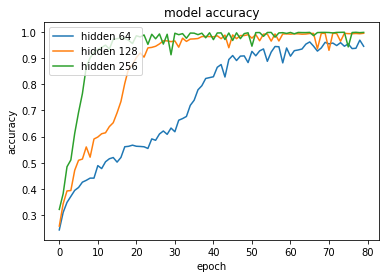

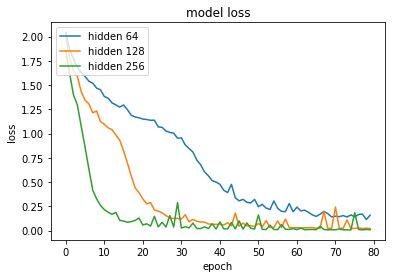

In [13]:
plt.plot(model_hidden64.history['val_acc'])
plt.plot(model_hidden128.history['val_acc'])
plt.plot(model_hidden256.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['hidden 64', 'hidden 128', 'hidden 256'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_hidden64.history['val_loss'][:80])
plt.plot(model_hidden128.history['val_loss'])
plt.plot(model_hidden256.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['hidden 64', 'hidden 128', 'hidden 256'], loc='upper left')
plt.show()